In [334]:
# import necessary libraries
import requests
import urllib
from bs4 import BeautifulSoup
from urllib.request import urlopen

import pandas as pd
import scipy as sc
import numpy as np
import seaborn as sns
import re
import time
import os
import sys
import csv
import string
import math

import statsmodels.formula.api as sm
from statistics import mode

import matplotlib.pyplot as plt 
plt.style.use('ggplot')
%matplotlib inline  
plt.rcParams['figure.figsize'] = (10, 6)

pd.set_option( "display.max_columns", 100)

## Start
We'll web scrape from this page since it has all current and former player
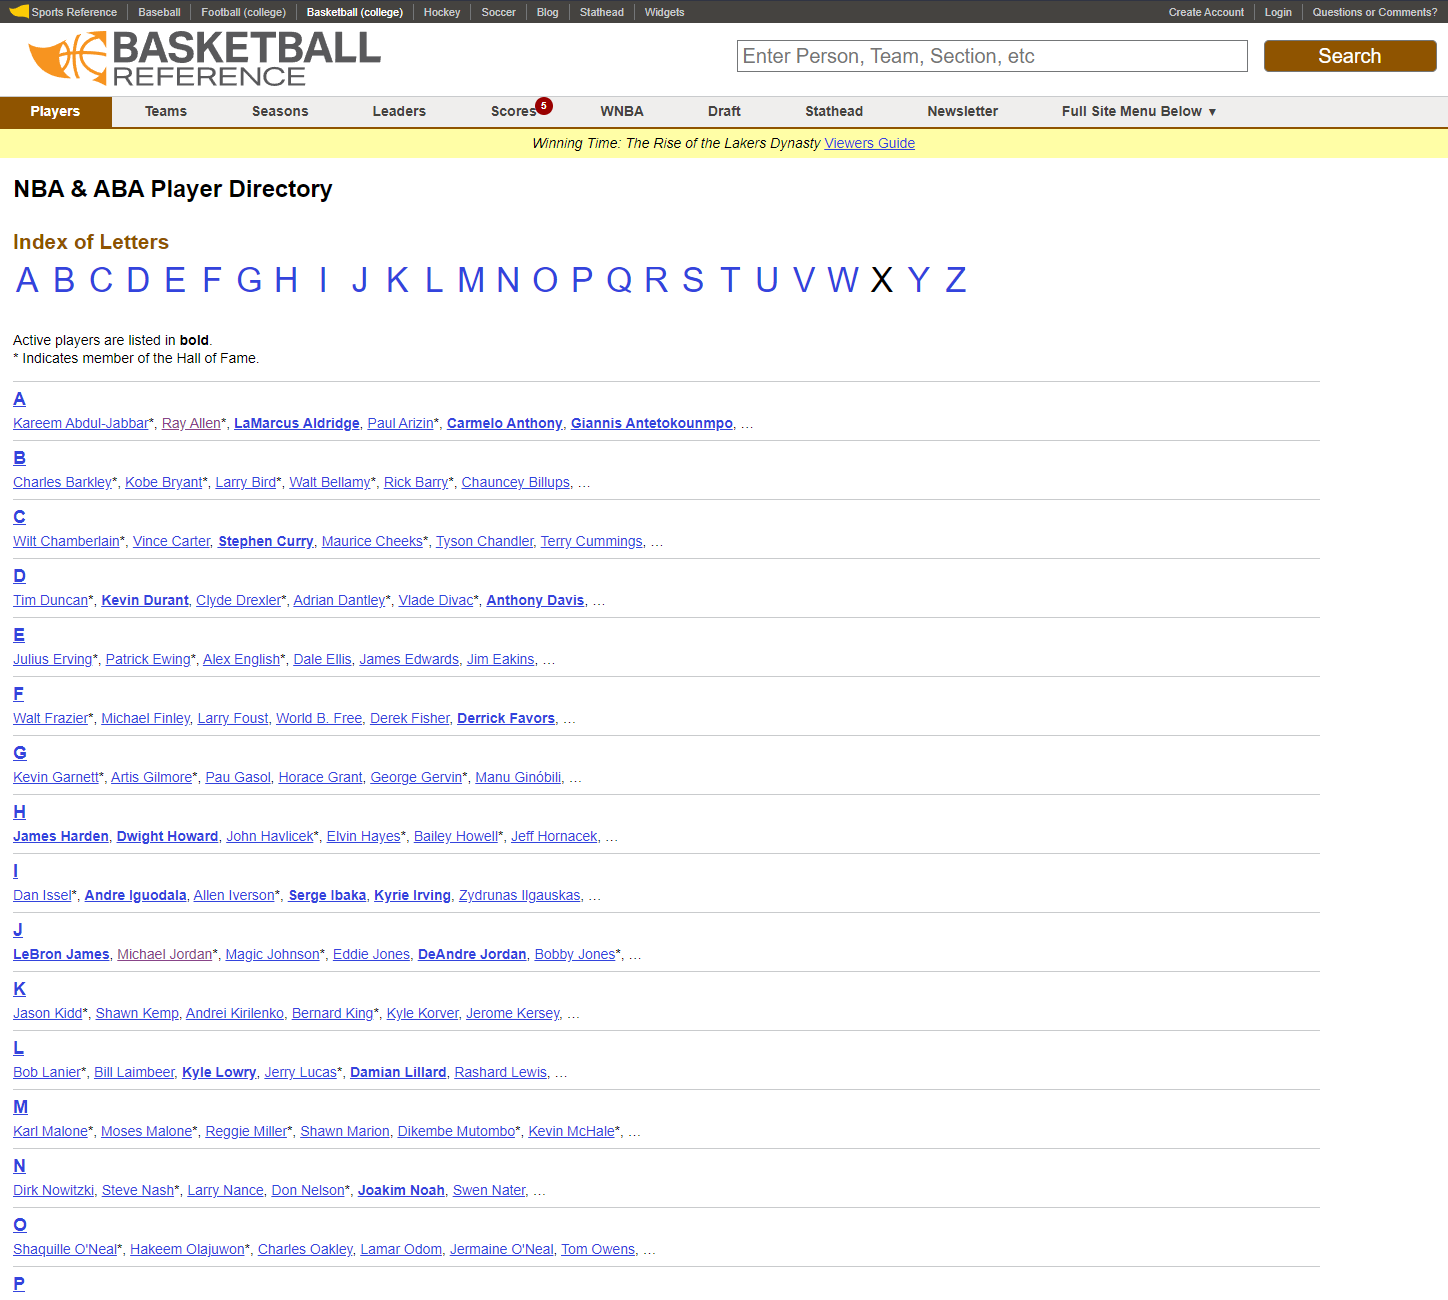

In [2]:
alphabet = list(string.ascii_lowercase)

In [3]:
# create new directories to store downloaded html pages
for letter in alphabet:
    if not os.path.exists('Webpages/Players Directory/{}-players'.format(letter)):
        os.makedirs('Webpages/Players Directory/{}-players'.format(letter))

if not os.path.exists('csv_files'):
    os.makedirs('csv_files')

In [4]:
# download the basketball-reference homepage
urllib.request.urlretrieve('https://www.basketball-reference.com/', 'Webpages/homepage.html')

# download the current players of 2022 page
urllib.request.urlretrieve('https://www.basketball-reference.com/leagues/NBA_2022_per_game.html', 'Webpages/2022-Players.html')

# download the pages corresponding to each players first letter of their last name
for letter in alphabet:
    urllib.request.urlretrieve('https://www.basketball-reference.com/players/{}/'.format(letter), 
                               'Webpages/Players Directory/{}-players-page.html'.format(letter))

In [3]:
players_list, players_names, players_urls, active, duplicate_names = [], [], [], {}, set()

In [4]:
for letter in alphabet:
    players_soup = BeautifulSoup(open('Webpages/Players Directory/{}-players-page.html'.format(letter), encoding="utf8"), 'html.parser')
    li = players_soup.select('div#div_players table#players tbody th[data-stat=player]')
    for link in li:
        players_list.append(link.a.get('href'))
        try:
            player_name = link.strong.get_text()
            players_names.append(player_name)
            if player_name in duplicate_names: count+=1
            else: count=1; duplicate_names.add(player_name)
            # based on site data, bold players are active (even if injured)
            active['{}0{}'.format(player_name, count)] = 1
        except AttributeError:
            player_name = link.get_text().replace('*', '')
            players_names.append(player_name)
            if player_name in duplicate_names: count+=1
            else: count=1; duplicate_names.add(player_name)
            # retired players/unactive players are not bolded
            active['{}0{}'.format(player_name, count)] = 0

duplicate_names.clear()            

# create reference links for each player
for player in players_list:
    players_urls.append('https://www.basketball-reference.com{}'.format(player))

In [5]:
print(len(players_list))
print(len(players_names))
print(len(players_urls))

5020
5020
5020


In [6]:
translate_eng = {'Č':'c', 'Ć': 'c', 'İ':'i', 'Š':'s', 'Ş':'s', 'Ž':'z'}
suffix = ['Jr.', 'Sr.', 'I', 'II', 'III', 'IV', 'V']

def get_last_initial(player_name):
    # there is an exception thrown for one player, so we'll handle with try/except block
    try:
        # handle middle names
        if len(player_name) == 3 and player_name[2] not in suffix:
            return player_name[2][0].lower()
        # handle last names that aren't in english alphabet
        elif player_name[1][0] in translate_eng: 
            return translate_eng.get(player_name[1][0])
        else: return player_name[1][0].lower()
    # Nenê's 'last name' isn't included in web scrape
    except IndexError: 
        if player_name[0] == 'Nenê': return 'h'

In [ ]:
# download all the players pages
i = 0

for player_link in players_urls:
    player_name = players_names[i].split(); print(player_name)
    last_initial = get_last_initial(player_name)
    
    # handle players with same names
    if players_names[i] in duplicate_names: count+=1
    else: count=1; duplicate_names.add(players_names[i])
        
    urllib.request.urlretrieve(player_link, 
                'Webpages/Players Directory/{}-players/{}0{}.html'.format(last_initial, players_names[i], count))
    i+=1
    
duplicate_names.clear()

In [308]:
# extract the stats and place into dataframe
# inits
stats_df_rows = []
awards_dict = {'hof':0, 'all_stars':0, 'score_champs':0, 'rbs_champs':0, 'ast_champs':0, 'stl_champs':0, 'blk_champs':0, 
               'nba_champs':0, 'all_nbas':0, 'most_improved':0, 'sixth_man':0, 'all_rookie':0, 'roy':0, 'all_defs':0, 'as_mvps':0, 
               'dpoys':0, 'mvps':0, 'finals_mvps':0, 'anniv_team':0}
convert_old_teams = {'TOT':'NA', 'NJN':'BRK', 'CHA':'CHO', 'NOK':'NOP', 'CHH':'CHO',
                    'NOH':'NOP', 'PHX':'PHO', 'SEA':'OKC', 'VAN':'MEM', 'WSB':'WAS', 'PHW':'GSW',
                    'SFW':'GSW', 'MNL':'LAL', 'CIN':'SAC', 'KCO':'SAC', 'DNR':'DEN', 'FTW':'DET', 
                     'SDR':'HOU', 'SYR':'PHI'}
avg_stats_dict = {'G':0,'PTS':0.0,'TRB':0.0,'AST':0.0,'STL':0.0,'BLK':0.0,'FG%':0.0,'FG3%':0.0,
              'FT%':0.0,'eFG%':0.0,'PER':0.0,'WS':0.0}
tot_stats_dict = {'PG':0,'PTS':0,'TRB':0,'AST':0,'STL':0,'BLK':0}

# extract the number or value if award is present within player
def choose_award(awards_list):
    for award in awards_list:
        if 'Hall of Fame' in award: awards_dict['hof'] = 1
        elif 'x All Star' in award: awards_dict['all_stars'] = int(''.join(i for i in award if i.isdigit()))
        elif 'Scoring Champ' in award:
            awards_dict['score_champs'] = int(''.join(i for i in award if i.isdigit())) if 'x' in award else 1
        elif 'TRB Champ' in award:
            awards_dict['rbs_champs'] = int(''.join(i for i in award if i.isdigit())) if 'x' in award else 1
        elif 'AST Champ' in award:
            awards_dict['ast_champs'] = int(''.join(i for i in award if i.isdigit())) if 'x' in award else 1
        elif 'STL Champ' in award:
            awards_dict['stl_champs'] = int(''.join(i for i in award if i.isdigit())) if 'x' in award else 1
        elif 'BLK Champ' in award:
            awards_dict['blk_champs'] = int(''.join(i for i in award if i.isdigit())) if 'x' in award else 1
        elif 'NBA Champ' in award:
            awards_dict['nba_champs'] = int(''.join(i for i in award if i.isdigit())) if 'x' in award else 1
        elif 'All-NBA' in award or 'All-BAA/NBA' in award:
            awards_dict['all_nbas'] = int(''.join(i for i in award if i.isdigit())) if 'x' in award else 1
        elif 'All-Rookie' in award: awards_dict['all_rookie'] = 1
        elif 'ROY' in award: awards_dict['roy'] = 1
        elif 'All-Defensive' in award:
            awards_dict['all_defs'] = int(''.join(i for i in award if i.isdigit())) if 'x' in award else 1
        elif 'Most Improved' in award:
            awards_dict['most_improved'] = int(''.join(i for i in award if i.isdigit())) if 'x' in award else 1
        elif 'Sixth Man' in award:
            awards_dict['sixth_man'] = int(''.join(i for i in award if i.isdigit())) if 'x Sixth Man' in award else 1
        elif 'AS MVP' in award:
            awards_dict['as_mvps'] = int(''.join(i for i in award if i.isdigit())) if 'x' in award else 1
        elif 'Def. POY' in award:
            awards_dict['dpoys'] = int(''.join(i for i in award if i.isdigit())) if 'x' in award else 1
        elif 'MVP' in award:
            if 'Finals' in award: awards_dict['finals_mvps'] = int(''.join(i for i in award if i.isdigit())) if 'x' in award else 1
            else: awards_dict['mvps'] = int(''.join(i for i in award if i.isdigit())) if 'x' in award else 1
        elif 'NBA 75th Anniv. Team' in award: awards_dict['anniv_team'] = 1
        else: continue # skip all-aba, aba champ, bba, etc (irrelevant to current players)

# get all the list of achivements and awards for player
def get_achivements(link):
    li = link.select("ul[id=bling] > li > a")
    for link in li:
        awards.append(link.get_text())

def get_info(link):
    info = link.find(id='info')
    for line in info.find_all('p'):
        try:
            # use regex to extract hof induction year
            hof_year = re.search('Hall of Fame: Inducted as Player in (\d{4})', line.get_text()).group(1); break
        except AttributeError: hof_year = 0; continue
    return int(hof_year)
    
# extract all years for each player -- note some 
# players get traded during the same season so there are duplicate years
# we'll handle that with a set
def extract_table(link, years, position, teams):
    table = link.find('table')
    if table:
        table_body = table.find('tbody')
        # loop over list of players
        for row in table_body.findAll('tr'):
            try:
                # get some player's pos and team for each year
                year = row.find('a').get_text();
                pos = row.find('td', {'data-stat':'pos'}).get_text();
                team = row.find('td', {'data-stat':'team_id'}).get_text();
                lg = row.find('td', {'data-stat':'lg_id'}).get_text();
                # add year
                if (len(year) <= 7): years.add(int(year[:4]))
                # add positions
                if pos != '': position.append(pos)
                # add main team
                get_team = convert_old_teams.get(team) if team in convert_old_teams else team
                if get_team == 'NA': 
                    find_teams = row.find('tr', {'class':'light_text partial_table'})
                    multi_team = find_teams.find('td', {'data-stat':'team_id'}).get_text();
                    for team in multi_team: 
                        get_team = convert_old_teams.get(team) if team in convert_old_teams else team
                        teams.append(get_team)
                else:
                    teams.append(get_team)
                if lg != '': league.append(lg)
            except (AttributeError, IndexError):
                continue
    
    total_table = link.find('table', {'id':'totals'}).find('tfoot'); row = total_table.find('tr')
    # we'll also extract some total stats
    try: pts = row.find('td', {'class':'right','data-stat':'pts'}).get_text(); tot_stats_dict['PTS'] = pts
    except AttributeError: pass
    try: trb = row.find('td', {'class':'right','data-stat':'trb'}).get_text(); tot_stats_dict['TRB'] = trb
    except AttributeError: pass
    try: ast = row.find('td', {'class':'right','data-stat':'ast'}).get_text(); tot_stats_dict['AST'] = ast
    except AttributeError: pass
    try: spg = row.find('td', {'class':'right','data-stat':'stl'}).get_text(); tot_stats_dict['STL'] = spg
    except AttributeError: pass
    try: bpg = row.find('td', {'class':'right','data-stat':'blk'}).get_text(); tot_stats_dict['BLK'] = bpg
    except AttributeError: pass
    
    avg_table = link.find('table', {'id':'per_game'}).find('tfoot');
    row = avg_table.find('tr');
    # gather average steals and blocks
    try: avg_stl = row.find('td', {'class':'right','data-stat':'stl_per_g'}).get_text(); avg_stats_dict['STL'] = avg_stl
    except AttributeError: pass
    try: avg_blk = row.find('td', {'class':'right','data-stat':'blk_per_g'}).get_text(); avg_stats_dict['BLK'] = avg_blk
    except AttributeError: pass
        
# get stats of player
def get_stats(stats):
    for stat in stats.find_all('div'):
        try:
            get_stat = stat.select('p')[1].get_text()
            set_stat = get_stat if (get_stat != 'Career' and get_stat != '-') else 0.0
            avg_stats_dict[stat.find('span').strong.get_text()] = float(set_stat)
        # handle out of index error for some players
        except IndexError: return 0
                
# extract each available stat for current player
def extract_player_info(player_link, player_name, awards, years, get_player_map, position, teams, league):
    with open(player_link, 'rb') as html:
        player_link_soup = BeautifulSoup(html)
    
    # extract player awards and accomplishments and place into list
    get_achivements(player_link_soup)
    averages = player_link_soup.find('div', {'class': 'stats_pullout'})
    extract_table(player_link_soup, years, position, teams)
    # sort set and convert to list so we can access first and last years
    years_list = sorted(list(years))
    
    # extract stats and set awards
    name = player_name
    main_pos = mode(position) if len(position) != 0 else 'NA'
    '''
    the team a player is mainly associated with -- this technically isn't correct,
    but we'll infer a player's main team is the team they played the most seasons with
    '''
    asso_team = mode(teams) if len(teams) != 0 else 'NA'
    main_lg = mode(league) if len(league) != 0 else 'NA'
    yoe = len(years)
    debut = years_list[0] if len(years_list) > 0 else 0
    last_active = (years_list[-1] + 1) if yoe >= 1 else 0
    # based on site data, bold players are active (even injured players)
    retired = 1 if active.get(get_player_map) == 0 else 0
    year_inducted = get_info(player_link_soup)
    
    # extract main stats
    get_stats(averages)
    # stats_dict.pop('SUMMARY');
    
    # check if players have alteast one award
    if len(awards) != 0:
        choose_award(awards)

    player_stats = {'Player':name, 'Debut':debut, 'Last Active':last_active, 'YOE':yoe, 'Retired':retired, 'Position':main_pos, 
                        'Team':asso_team,'League':main_lg,'Total Games':avg_stats_dict.get('G', 0), 'Career PPG':avg_stats_dict.get('PTS', 0.0), 
                        'Total PTS':tot_stats_dict.get('PTS', 0),'Career RPG':avg_stats_dict.get('TRB', 0.0),'Total RBS':tot_stats_dict.get('TRB', 0),'Career APG':avg_stats_dict.get('AST', 0.0), 
                        'Total AST':tot_stats_dict.get('AST', 0),'Career SPG':avg_stats_dict.get('STL', 0.0),'Total STL':tot_stats_dict.get('STL', 0),'Career BPG':avg_stats_dict.get('BLK', 0.0),
                         'Total BLK':tot_stats_dict.get('BLK', 0),'Career FG%':avg_stats_dict.get('FG%', 0.0), 
                    'Career FG3%':avg_stats_dict.get('FG3%', 0.0), 'Career FT%':avg_stats_dict.get('FT%', 0.0), 'Career eFG%':avg_stats_dict.get('eFG%', 0.0), 
                          'PER':avg_stats_dict.get('PER', 0.0),'Avg WS':round((avg_stats_dict.get('WS', 0.0)/float(yoe)), 1),'Total WS':avg_stats_dict.get('WS', 0.0),
                          'Hall of Fame':awards_dict.get('hof', 0), 'Year Inducted':year_inducted, 
                          'All-Stars':awards_dict.get('all_stars', 0), 'Scoring Champs':awards_dict.get('score_champs', 0), 
                          'Rebound Champs':awards_dict.get('rbs_champs', 0),
                       'Assist Champs':awards_dict.get('ast_champs', 0), 'Steal Champs':awards_dict.get('stl_champs', 0), 
                          'Block Champs':awards_dict.get('blk_champs', 0), 
                        'NBA Champs':awards_dict.get('nba_champs', 0), 'All-NBA':awards_dict.get('all_nbas', 0), 
                          'All-Rookie':awards_dict.get('all_rookie', 0), 'ROY':awards_dict.get('roy', 0), 
                        'All-Defensive':awards_dict.get('all_defs', 0), 'Most Improved':awards_dict.get('most_improved', 0), 
                          'Sixth Man':awards_dict.get('sixth_man', 0), 'AS MVPs':awards_dict.get('as_mvps', 0), 
                        'DPOYs':awards_dict.get('dpoys', 0), 'MVPs': awards_dict.get('mvps', 0),'Finals MVPs':awards_dict.get('finals_mvps', 0), 
                        'NBA 75th Anniv. Team':awards_dict.get('anniv_team', 0)}
    # add stats awards to list
    stats_df_rows.append(player_stats); print(player_stats)

In [309]:
start = time.process_time()
# go through each player
for player in players_names:
    # years may have duplicates
    awards, years, position, teams, league = [], set(), [], [], []
    global awards_dict; awards_dict = awards_dict.fromkeys(awards_dict, 0); print(player)
    global stats_dict; stats_dict = stats_dict.fromkeys(stats_dict, 0);
    player_name = player.split()
    last_initial = get_last_initial(player_name)
    
    # check for duplicate names
    if player in duplicate_names: count+=1
    else: count=1; duplicate_names.add(player)
    
    # get player identify number
    get_player_map = '{}0{}'.format(player, count)
    extract_player_info('Webpages/Players Directory/{}-players/{}.html'.format(last_initial, get_player_map), 
                        player, awards, years, get_player_map, position, teams, league)

end = time.process_time()
duplicate_names.clear()

Alaa Abdelnaby
{'Player': 'Alaa Abdelnaby', 'Debut': 1990, 'Last Active': 1995, 'YOE': 5, 'Retired': 1, 'Position': 'PF', 'Team': 'POR', 'League': 'NBA', 'Total Games': 256.0, 'Career PPG': 5.7, 'Total PTS': '1465', 'Career RPG': 3.3, 'Total RBS': '846', 'Career APG': 0.3, 'Total AST': '85', 'Career SPG': '0.3', 'Total STL': '71', 'Career BPG': '0.3', 'Total BLK': '69', 'Career FG%': 50.2, 'Career FG3%': 0.0, 'Career FT%': 70.1, 'Career eFG%': 50.2, 'PER': 13.0, 'Avg WS': 1.0, 'Total WS': 4.8, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Zaid Abdul-Aziz
{'Player': 'Zaid Abdul-Aziz', 'Debut': 1968, 'Last Active': 1978, 'YOE': 10, 'Retired': 1, 'Position': 'C', 'Team': 'HOU', 'League': '

{'Player': 'Don Ackerman', 'Debut': 1953, 'Last Active': 1954, 'YOE': 1, 'Retired': 1, 'Position': 'PG', 'Team': 'NYK', 'League': 'NBA', 'Total Games': 28.0, 'Career PPG': 1.5, 'Total PTS': '43', 'Career RPG': 0.5, 'Total RBS': '15', 'Career APG': 0.8, 'Total AST': '23', 'Career SPG': '0.2', 'Total STL': '6', 'Career BPG': '0.1', 'Total BLK': '4', 'Career FG%': 22.2, 'Career FG3%': 32.0, 'Career FT%': 53.6, 'Career eFG%': 41.3, 'PER': 1.0, 'Avg WS': -0.6, 'Total WS': -0.6, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Mark Acres
{'Player': 'Mark Acres', 'Debut': 1987, 'Last Active': 1993, 'YOE': 6, 'Retired': 1, 'Position': 'C', 'Team': 'ORL', 'League': 'NBA', 'Total Games': 375.0, 'Car

{'Player': 'Steven Adams', 'Debut': 2013, 'Last Active': 2022, 'YOE': 9, 'Retired': 0, 'Position': 'C', 'Team': 'OKC', 'League': 'NBA', 'Total Games': 664.0, 'Career PPG': 9.3, 'Total PTS': '6157', 'Career RPG': 8.0, 'Total RBS': '5303', 'Career APG': 1.5, 'Total AST': '982', 'Career SPG': '0.9', 'Total STL': '588', 'Career BPG': '0.9', 'Total BLK': '629', 'Career FG%': 58.7, 'Career FG3%': 7.1, 'Career FT%': 54.7, 'Career eFG%': 58.7, 'PER': 17.0, 'Avg WS': 6.2, 'Total WS': 56.0, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 1, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Rafael Addison
{'Player': 'Rafael Addison', 'Debut': 1986, 'Last Active': 1997, 'YOE': 6, 'Retired': 1, 'Position': 'SF', 'Team': 'BRK', 'League': 'NBA', 'Total Ga

{'Player': 'Alexis Ajinça', 'Debut': 2008, 'Last Active': 2017, 'YOE': 7, 'Retired': 1, 'Position': 'C', 'Team': 'NOP', 'League': 'NBA', 'Total Games': 293.0, 'Career PPG': 5.3, 'Total PTS': '1553', 'Career RPG': 3.9, 'Total RBS': '1150', 'Career APG': 0.5, 'Total AST': '143', 'Career SPG': '0.3', 'Total STL': '102', 'Career BPG': '0.6', 'Total BLK': '181', 'Career FG%': 50.3, 'Career FG3%': 28.6, 'Career FT%': 79.7, 'Career eFG%': 50.7, 'PER': 14.9, 'Avg WS': 1.1, 'Total WS': 7.5, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Henry Akin
{'Player': 'Henry Akin', 'Debut': 1966, 'Last Active': 1969, 'YOE': 3, 'Retired': 1, 'Position': 'PF', 'Team': 'NYK', 'League': 'NBA', 'Total Games': 8

{'Player': 'Cliff Alexander', 'Debut': 2015, 'Last Active': 2016, 'YOE': 1, 'Retired': 1, 'Position': 'PF', 'Team': 'POR', 'League': 'NBA', 'Total Games': 8.0, 'Career PPG': 1.3, 'Total PTS': '10', 'Career RPG': 0.8, 'Total RBS': '6', 'Career APG': 0.0, 'Total AST': '0', 'Career SPG': '0.1', 'Total STL': '1', 'Career BPG': '0.3', 'Total BLK': '2', 'Career FG%': 50.0, 'Career FG3%': 0.0, 'Career FT%': 0.0, 'Career eFG%': 50.0, 'PER': 11.6, 'Avg WS': 0.0, 'Total WS': 0.0, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Cory Alexander
{'Player': 'Cory Alexander', 'Debut': 1995, 'Last Active': 2005, 'YOE': 7, 'Retired': 1, 'Position': 'PG', 'Team': 'SAS', 'League': 'NBA', 'Total Games': 307.0

{'Player': 'Grayson Allen', 'Debut': 2018, 'Last Active': 2022, 'YOE': 4, 'Retired': 0, 'Position': 'SG', 'Team': 'MEM', 'League': 'NBA', 'Total Games': 192.0, 'Career PPG': 9.4, 'Total PTS': '1806', 'Career RPG': 2.6, 'Total RBS': '490', 'Career APG': 1.5, 'Total AST': '285', 'Career SPG': '0.6', 'Total STL': '108', 'Career BPG': '0.2', 'Total BLK': '34', 'Career FG%': 43.3, 'Career FG3%': 39.3, 'Career FT%': 84.1, 'Career eFG%': 55.9, 'PER': 12.1, 'Avg WS': 2.0, 'Total WS': 8.1, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Jarrett Allen
{'Player': 'Jarrett Allen', 'Debut': 2017, 'Last Active': 2022, 'YOE': 5, 'Retired': 0, 'Position': 'C', 'Team': 'BRK', 'League': 'NBA', 'Total Games

{'Player': 'Odis Allison', 'Debut': 1971, 'Last Active': 1972, 'YOE': 1, 'Retired': 1, 'Position': 'SF', 'Team': 'GSW', 'League': 'NBA', 'Total Games': 36.0, 'Career PPG': 1.9, 'Total PTS': '67', 'Career RPG': 1.3, 'Total RBS': '45', 'Career APG': 0.3, 'Total AST': '10', 'Career SPG': '1.4', 'Total STL': '1158', 'Career BPG': '', 'Total BLK': '', 'Career FG%': 21.8, 'Career FG3%': 0.0, 'Career FT%': 54.1, 'Career eFG%': 30.8, 'PER': 4.7, 'Avg WS': -0.6, 'Total WS': -0.6, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Lance Allred
{'Player': 'Lance Allred', 'Debut': 2007, 'Last Active': 2008, 'YOE': 1, 'Retired': 1, 'Position': 'C', 'Team': 'CLE', 'League': 'NBA', 'Total Games': 3.0, 'Car

{'Player': 'Al-Farouq Aminu', 'Debut': 2010, 'Last Active': 2021, 'YOE': 11, 'Retired': 0, 'Position': 'PF', 'Team': 'POR', 'League': 'NBA', 'Total Games': 711.0, 'Career PPG': 7.5, 'Total PTS': '5350', 'Career RPG': 6.0, 'Total RBS': '4280', 'Career APG': 1.2, 'Total AST': '879', 'Career SPG': '1.0', 'Total STL': '678', 'Career BPG': '0.6', 'Total BLK': '397', 'Career FG%': 42.0, 'Career FG3%': 33.2, 'Career FT%': 74.6, 'Career eFG%': 47.8, 'PER': 12.2, 'Avg WS': 2.5, 'Total WS': 27.6, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Lou Amundson
{'Player': 'Lou Amundson', 'Debut': 2006, 'Last Active': 2016, 'YOE': 10, 'Retired': 1, 'Position': 'PF', 'Team': 'PHI', 'League': 'NBA', 'Total

{'Player': 'Derek Anderson', 'Debut': 1997, 'Last Active': 2008, 'YOE': 11, 'Retired': 1, 'Position': 'SG', 'Team': 'POR', 'League': 'NBA', 'Total Games': 615.0, 'Career PPG': 12.0, 'Total PTS': '7357', 'Career RPG': 3.2, 'Total RBS': '1988', 'Career APG': 3.4, 'Total AST': '2083', 'Career SPG': '1.1', 'Total STL': '691', 'Career BPG': '0.1', 'Total BLK': '87', 'Career FG%': 40.8, 'Career FG3%': 34.1, 'Career FT%': 85.3, 'Career eFG%': 46.3, 'PER': 15.3, 'Avg WS': 4.0, 'Total WS': 43.9, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 1, 'All-NBA': 0, 'All-Rookie': 1, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Dwight Anderson
{'Player': 'Dwight Anderson', 'Debut': 1982, 'Last Active': 1983, 'YOE': 1, 'Retired': 1, 'Position': 'PG', 'Team': 'DEN', 'League': 'NBA', '

{'Player': 'Nick Anderson', 'Debut': 1989, 'Last Active': 2002, 'YOE': 13, 'Retired': 1, 'Position': 'SG', 'Team': 'ORL', 'League': 'NBA', 'Total Games': 800.0, 'Career PPG': 14.4, 'Total PTS': '11529', 'Career RPG': 5.1, 'Total RBS': '4064', 'Career APG': 2.6, 'Total AST': '2087', 'Career SPG': '1.4', 'Total STL': '1114', 'Career BPG': '0.5', 'Total BLK': '364', 'Career FG%': 44.6, 'Career FG3%': 35.6, 'Career FT%': 66.7, 'Career eFG%': 50.0, 'PER': 15.8, 'Avg WS': 4.3, 'Total WS': 55.3, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Richard Anderson
{'Player': 'Richard Anderson', 'Debut': 1982, 'Last Active': 1990, 'YOE': 6, 'Retired': 1, 'Position': 'PF', 'Team': 'HOU', 'League': 'NBA

{'Player': 'Chris Anstey', 'Debut': 1997, 'Last Active': 2000, 'YOE': 3, 'Retired': 1, 'Position': 'C', 'Team': 'DAL', 'League': 'NBA', 'Total Games': 155.0, 'Career PPG': 5.2, 'Total PTS': '813', 'Career RPG': 3.4, 'Total RBS': '534', 'Career APG': 0.8, 'Total AST': '127', 'Career SPG': '0.5', 'Total STL': '78', 'Career BPG': '0.4', 'Total BLK': '65', 'Career FG%': 41.3, 'Career FG3%': 13.8, 'Career FT%': 75.5, 'Career eFG%': 41.6, 'PER': 13.2, 'Avg WS': 0.9, 'Total WS': 2.8, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Giannis Antetokounmpo
{'Player': 'Giannis Antetokounmpo', 'Debut': 2013, 'Last Active': 2022, 'YOE': 9, 'Retired': 0, 'Position': 'PF', 'Team': 'MIL', 'League': 'NBA',

{'Player': 'Robert Archibald', 'Debut': 2002, 'Last Active': 2004, 'YOE': 2, 'Retired': 1, 'Position': 'PF', 'Team': 'MEM', 'League': 'NBA', 'Total Games': 44.0, 'Career PPG': 1.2, 'Total PTS': '51', 'Career RPG': 1.6, 'Total RBS': '69', 'Career APG': 0.4, 'Total AST': '16', 'Career SPG': '0.3', 'Total STL': '14', 'Career BPG': '0.1', 'Total BLK': '6', 'Career FG%': 28.3, 'Career FG3%': 0.0, 'Career FT%': 42.9, 'Career eFG%': 28.3, 'PER': 4.9, 'Avg WS': 0.0, 'Total WS': 0.0, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Tiny Archibald
{'Player': 'Tiny Archibald', 'Debut': 1970, 'Last Active': 1984, 'YOE': 13, 'Retired': 1, 'Position': 'PG', 'Team': 'SAC', 'League': 'NBA', 'Total Games':

{'Player': 'Darrell Armstrong', 'Debut': 1994, 'Last Active': 2008, 'YOE': 14, 'Retired': 1, 'Position': 'PG', 'Team': 'ORL', 'League': 'NBA', 'Total Games': 840.0, 'Career PPG': 9.2, 'Total PTS': '7712', 'Career RPG': 2.7, 'Total RBS': '2269', 'Career APG': 4.0, 'Total AST': '3394', 'Career SPG': '1.3', 'Total STL': '1133', 'Career BPG': '0.1', 'Total BLK': '98', 'Career FG%': 40.9, 'Career FG3%': 33.4, 'Career FT%': 87.1, 'Career eFG%': 48.0, 'PER': 16.3, 'Avg WS': 3.6, 'Total WS': 49.8, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 1, 'Sixth Man': 1, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Hilton Armstrong
{'Player': 'Hilton Armstrong', 'Debut': 2006, 'Last Active': 2014, 'YOE': 6, 'Retired': 1, 'Position': 'C', 'Team': 'NOP', 'League': 'NBA

{'Player': 'Ömer Aşık', 'Debut': 2010, 'Last Active': 2018, 'YOE': 8, 'Retired': 1, 'Position': 'C', 'Team': 'NOP', 'League': 'NBA', 'Total Games': 471.0, 'Career PPG': 5.3, 'Total PTS': '2479', 'Career RPG': 7.1, 'Total RBS': '3362', 'Career APG': 0.6, 'Total AST': '280', 'Career SPG': '0.4', 'Total STL': '167', 'Career BPG': '0.7', 'Total BLK': '339', 'Career FG%': 52.8, 'Career FG3%': 0.0, 'Career FT%': 55.1, 'Career eFG%': 52.8, 'PER': 13.4, 'Avg WS': 2.6, 'Total WS': 20.9, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Vincent Askew
{'Player': 'Vincent Askew', 'Debut': 1987, 'Last Active': 1998, 'YOE': 9, 'Retired': 1, 'Position': 'SG', 'Team': 'OKC', 'League': 'NBA', 'Total Games':

{'Player': 'Johnny Austin', 'Debut': 1966, 'Last Active': 1968, 'YOE': 2, 'Retired': 1, 'Position': 'SG', 'Team': 'BAL', 'League': 'NBA', 'Total Games': 45.0, 'Career PPG': 7.6, 'Total PTS': '340', 'Career RPG': 1.6, 'Total RBS': '71', 'Career APG': 1.4, 'Total AST': '62', 'Career SPG': '0.5', 'Total STL': '214', 'Career BPG': '0.5', 'Total BLK': '226', 'Career FG%': 37.5, 'Career FG3%': 0.0, 'Career FT%': 73.1, 'Career eFG%': 37.5, 'PER': 9.3, 'Avg WS': 0.5, 'Total WS': 0.9, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Ken Austin
{'Player': 'Ken Austin', 'Debut': 1983, 'Last Active': 1984, 'YOE': 1, 'Retired': 1, 'Position': 'SF', 'Team': 'DET', 'League': 'NBA', 'Total Games': 7.0, 'C

{'Player': 'Deandre Ayton', 'Debut': 2018, 'Last Active': 2022, 'YOE': 4, 'Retired': 0, 'Position': 'C', 'Team': 'PHO', 'League': 'NBA', 'Total Games': 236.0, 'Career PPG': 16.3, 'Total PTS': '3843', 'Career RPG': 10.5, 'Total RBS': '2485', 'Career APG': 1.6, 'Total AST': '380', 'Career SPG': '0.7', 'Total STL': '168', 'Career BPG': '1.0', 'Total BLK': '246', 'Career FG%': 59.9, 'Career FG3%': 25.0, 'Career FT%': 75.4, 'Career eFG%': 60.2, 'PER': 20.7, 'Avg WS': 6.2, 'Total WS': 24.7, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 1, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Kelenna Azubuike
{'Player': 'Kelenna Azubuike', 'Debut': 2006, 'Last Active': 2012, 'YOE': 5, 'Retired': 1, 'Position': 'SG', 'Team': 'GSW', 'League': 'NBA', '

{'Player': 'John Bagley', 'Debut': 1982, 'Last Active': 1994, 'YOE': 11, 'Retired': 1, 'Position': 'PG', 'Team': 'CLE', 'League': 'NBA', 'Total Games': 665.0, 'Career PPG': 8.7, 'Total PTS': '5802', 'Career RPG': 2.6, 'Total RBS': '1729', 'Career APG': 6.0, 'Total AST': '3980', 'Career SPG': '1.1', 'Total STL': '755', 'Career BPG': '0.1', 'Total BLK': '54', 'Career FG%': 43.7, 'Career FG3%': 24.1, 'Career FT%': 77.9, 'Career eFG%': 44.8, 'PER': 13.0, 'Avg WS': 1.5, 'Total WS': 16.6, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Marvin Bagley III
{'Player': 'Marvin Bagley III', 'Debut': 2018, 'Last Active': 2022, 'YOE': 4, 'Retired': 0, 'Position': 'PF', 'Team': 'SAC', 'League': 'NBA', '

{'Player': 'Norm Baker', 'Debut': 1946, 'Last Active': 1947, 'YOE': 1, 'Retired': 1, 'Position': 'NA', 'Team': 'CHS', 'League': 'BAA', 'Total Games': 4.0, 'Career PPG': 0.0, 'Total PTS': '0', 'Career RPG': 0.0, 'Total RBS': '', 'Career APG': 0.0, 'Total AST': '0', 'Career SPG': '0.2', 'Total STL': '1', 'Career BPG': '0.0', 'Total BLK': '0', 'Career FG%': 0.0, 'Career FG3%': 0.0, 'Career FT%': 0.0, 'Career eFG%': 0.0, 'PER': 0.0, 'Avg WS': 0.0, 'Total WS': 0.0, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Ron Baker
{'Player': 'Ron Baker', 'Debut': 2016, 'Last Active': 2019, 'YOE': 3, 'Retired': 1, 'Position': 'SG', 'Team': 'NYK', 'League': 'NBA', 'Total Games': 96.0, 'Career PPG': 3.1, 

{'Player': 'Gene Banks', 'Debut': 1981, 'Last Active': 1987, 'YOE': 6, 'Retired': 1, 'Position': 'SF', 'Team': 'SAS', 'League': 'NBA', 'Total Games': 468.0, 'Career PPG': 11.3, 'Total PTS': '5305', 'Career RPG': 5.8, 'Total RBS': '2718', 'Career APG': 2.9, 'Total AST': '1335', 'Career SPG': '0.9', 'Total STL': '436', 'Career BPG': '0.2', 'Total BLK': '101', 'Career FG%': 53.9, 'Career FG3%': 4.3, 'Career FT%': 73.0, 'Career eFG%': 53.9, 'PER': 15.1, 'Avg WS': 5.2, 'Total WS': 31.2, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Marcus Banks
{'Player': 'Marcus Banks', 'Debut': 2003, 'Last Active': 2011, 'YOE': 8, 'Retired': 1, 'Position': 'PG', 'Team': 'BOS', 'League': 'NBA', 'Total Games

{'Player': 'Andrea Bargnani', 'Debut': 2006, 'Last Active': 2016, 'YOE': 10, 'Retired': 1, 'Position': 'PF', 'Team': 'TOR', 'League': 'NBA', 'Total Games': 550.0, 'Career PPG': 14.3, 'Total PTS': '7873', 'Career RPG': 4.6, 'Total RBS': '2541', 'Career APG': 1.2, 'Total AST': '653', 'Career SPG': '0.4', 'Total STL': '207', 'Career BPG': '0.9', 'Total BLK': '470', 'Career FG%': 43.9, 'Career FG3%': 35.4, 'Career FT%': 82.4, 'Career eFG%': 48.6, 'PER': 14.4, 'Avg WS': 1.9, 'Total WS': 18.9, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 1, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Cliff Barker
{'Player': 'Cliff Barker', 'Debut': 1949, 'Last Active': 1952, 'YOE': 3, 'Retired': 1, 'Position': 'SG', 'Team': 'INO', 'League': 'NBA', 'Total

{'Player': 'Matt Barnes', 'Debut': 2003, 'Last Active': 2017, 'YOE': 14, 'Retired': 1, 'Position': 'SF', 'Team': 'LAC', 'League': 'NBA', 'Total Games': 929.0, 'Career PPG': 8.2, 'Total PTS': '7589', 'Career RPG': 4.6, 'Total RBS': '4281', 'Career APG': 1.8, 'Total AST': '1691', 'Career SPG': '0.8', 'Total STL': '714', 'Career BPG': '0.5', 'Total BLK': '444', 'Career FG%': 43.6, 'Career FG3%': 33.5, 'Career FT%': 74.5, 'Career eFG%': 51.3, 'PER': 12.7, 'Avg WS': 3.1, 'Total WS': 42.8, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 1, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Scottie Barnes
{'Player': 'Scottie Barnes', 'Debut': 2021, 'Last Active': 2022, 'YOE': 1, 'Retired': 0, 'Position': 'PF', 'Team': 'TOR', 'League': 'NBA', 'Total

{'Player': 'Mike Barrett', 'Debut': 1969, 'Last Active': 1973, 'YOE': 3, 'Retired': 1, 'Position': 'SG', 'Team': 'WSA', 'League': 'ABA', 'Total Games': 187.0, 'Career PPG': 13.4, 'Total PTS': '2500', 'Career RPG': 3.2, 'Total RBS': '592', 'Career APG': 3.9, 'Total AST': '730', 'Career SPG': '', 'Total STL': '', 'Career BPG': '', 'Total BLK': '', 'Career FG%': 44.0, 'Career FG3%': 31.0, 'Career FT%': 74.6, 'Career eFG%': 46.1, 'PER': 12.4, 'Avg WS': 2.5, 'Total WS': 7.4, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 1, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
RJ Barrett
{'Player': 'RJ Barrett', 'Debut': 2019, 'Last Active': 2022, 'YOE': 3, 'Retired': 0, 'Position': 'SG', 'Team': 'NYK', 'League': 'NBA', 'Total Games': 198.0, 'Caree

{'Player': 'Will Barton', 'Debut': 2012, 'Last Active': 2022, 'YOE': 10, 'Retired': 0, 'Position': 'SG', 'Team': 'DEN', 'League': 'NBA', 'Total Games': 623.0, 'Career PPG': 11.6, 'Total PTS': '7246', 'Career RPG': 4.3, 'Total RBS': '2655', 'Career APG': 2.7, 'Total AST': '1705', 'Career SPG': '0.8', 'Total STL': '476', 'Career BPG': '0.4', 'Total BLK': '259', 'Career FG%': 43.3, 'Career FG3%': 35.4, 'Career FT%': 78.7, 'Career eFG%': 50.0, 'PER': 14.2, 'Avg WS': 2.6, 'Total WS': 26.1, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Eddie Basden
{'Player': 'Eddie Basden', 'Debut': 2005, 'Last Active': 2006, 'YOE': 1, 'Retired': 1, 'Position': 'SF', 'Team': 'CHI', 'League': 'NBA', 'Total Ga

{'Player': 'Keita Bates-Diop', 'Debut': 2018, 'Last Active': 2022, 'YOE': 4, 'Retired': 0, 'Position': 'SF', 'Team': 'MIN', 'League': 'NBA', 'Total Games': 162.0, 'Career PPG': 5.2, 'Total PTS': '845', 'Career RPG': 3.0, 'Total RBS': '486', 'Career APG': 0.6, 'Total AST': '99', 'Career SPG': '0.5', 'Total STL': '75', 'Career BPG': '0.4', 'Total BLK': '57', 'Career FG%': 46.1, 'Career FG3%': 30.4, 'Career FT%': 71.0, 'Career eFG%': 51.1, 'PER': 11.7, 'Avg WS': 0.8, 'Total WS': 3.4, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Esteban Batista
{'Player': 'Esteban Batista', 'Debut': 2005, 'Last Active': 2007, 'YOE': 2, 'Retired': 1, 'Position': 'PF', 'Team': 'ATL', 'League': 'NBA', 'Total 

{'Player': 'Frankie Baumholtz', 'Debut': 1946, 'Last Active': 1947, 'YOE': 1, 'Retired': 1, 'Position': 'NA', 'Team': 'CLR', 'League': 'BAA', 'Total Games': 45.0, 'Career PPG': 14.0, 'Total PTS': '631', 'Career RPG': 0.0, 'Total RBS': '', 'Career APG': 1.2, 'Total AST': '54', 'Career SPG': '0.6', 'Total STL': '36', 'Career BPG': '0.3', 'Total BLK': '16', 'Career FG%': 29.8, 'Career FG3%': 0.0, 'Career FT%': 77.6, 'Career eFG%': 48.0, 'PER': 0.0, 'Avg WS': 3.8, 'Total WS': 3.8, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Lonny Baxter
{'Player': 'Lonny Baxter', 'Debut': 2002, 'Last Active': 2006, 'YOE': 4, 'Retired': 1, 'Position': 'PF', 'Team': 'CHI', 'League': 'NBA', 'Total Games': 16

{'Player': 'Bradley Beal', 'Debut': 2012, 'Last Active': 2022, 'YOE': 10, 'Retired': 0, 'Position': 'SG', 'Team': 'WAS', 'League': 'NBA', 'Total Games': 645.0, 'Career PPG': 22.1, 'Total PTS': '14231', 'Career RPG': 4.1, 'Total RBS': '2641', 'Career APG': 4.2, 'Total AST': '2701', 'Career SPG': '1.1', 'Total STL': '727', 'Career BPG': '0.4', 'Total BLK': '251', 'Career FG%': 45.6, 'Career FG3%': 37.2, 'Career FT%': 82.1, 'Career eFG%': 51.9, 'PER': 18.2, 'Avg WS': 4.9, 'Total WS': 48.8, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 3, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 1, 'All-Rookie': 1, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Al Beard
{'Player': 'Al Beard', 'Debut': 1967, 'Last Active': 1968, 'YOE': 1, 'Retired': 1, 'Position': 'NA', 'Team': 'NJA', 'League': 'ABA', 'Total Games': 

{'Player': 'Rodrigue Beaubois', 'Debut': 2009, 'Last Active': 2013, 'YOE': 4, 'Retired': 1, 'Position': 'PG', 'Team': 'DAL', 'League': 'NBA', 'Total Games': 182.0, 'Career PPG': 7.1, 'Total PTS': '1286', 'Career RPG': 1.9, 'Total RBS': '338', 'Career APG': 2.1, 'Total AST': '374', 'Career SPG': '0.7', 'Total STL': '124', 'Career BPG': '0.3', 'Total BLK': '52', 'Career FG%': 43.9, 'Career FG3%': 32.5, 'Career FT%': 81.0, 'Career eFG%': 49.6, 'PER': 14.5, 'Avg WS': 1.2, 'Total WS': 4.8, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 1, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Byron Beck
{'Player': 'Byron Beck', 'Debut': 1967, 'Last Active': 1977, 'YOE': 10, 'Retired': 1, 'Position': 'C', 'Team': 'DEN', 'League': 'ABA', 'Total Games'

{'Player': 'Elmer Behnke', 'Debut': 1951, 'Last Active': 1952, 'YOE': 1, 'Retired': 1, 'Position': 'NA', 'Team': 'MLH', 'League': 'NBA', 'Total Games': 4.0, 'Career PPG': 4.0, 'Total PTS': '16', 'Career RPG': 4.3, 'Total RBS': '17', 'Career APG': 1.0, 'Total AST': '4', 'Career SPG': '0.7', 'Total STL': '290', 'Career BPG': '0.4', 'Total BLK': '160', 'Career FG%': 27.3, 'Career FG3%': 0.0, 'Career FT%': 57.1, 'Career eFG%': 42.5, 'PER': 7.8, 'Avg WS': -0.1, 'Total WS': -0.1, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Marco Belinelli
{'Player': 'Marco Belinelli', 'Debut': 2007, 'Last Active': 2020, 'YOE': 13, 'Retired': 1, 'Position': 'SG', 'Team': 'SAS', 'League': 'NBA', 'Total Games'

{'Player': 'Jonathan Bender', 'Debut': 1999, 'Last Active': 2010, 'YOE': 8, 'Retired': 1, 'Position': 'SF', 'Team': 'IND', 'League': 'NBA', 'Total Games': 262.0, 'Career PPG': 5.5, 'Total PTS': '1453', 'Career RPG': 2.2, 'Total RBS': '582', 'Career APG': 0.6, 'Total AST': '170', 'Career SPG': '0.2', 'Total STL': '43', 'Career BPG': '0.6', 'Total BLK': '169', 'Career FG%': 41.7, 'Career FG3%': 34.0, 'Career FT%': 76.3, 'Career eFG%': 45.8, 'PER': 10.9, 'Avg WS': 0.5, 'Total WS': 3.8, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Jerrelle Benimon
{'Player': 'Jerrelle Benimon', 'Debut': 2014, 'Last Active': 2015, 'YOE': 1, 'Retired': 1, 'Position': 'PF', 'Team': 'UTA', 'League': 'NBA', 'To

{'Player': 'David Benoit', 'Debut': 1991, 'Last Active': 2001, 'YOE': 7, 'Retired': 1, 'Position': 'SF', 'Team': 'UTA', 'League': 'NBA', 'Total Games': 492.0, 'Career PPG': 7.0, 'Total PTS': '3455', 'Career RPG': 4.0, 'Total RBS': '1983', 'Career APG': 0.6, 'Total AST': '287', 'Career SPG': '0.4', 'Total STL': '216', 'Career BPG': '0.5', 'Total BLK': '246', 'Career FG%': 43.8, 'Career FG3%': 31.9, 'Career FT%': 79.5, 'Career eFG%': 47.2, 'PER': 12.0, 'Avg WS': 2.4, 'Total WS': 16.9, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Keith Benson
{'Player': 'Keith Benson', 'Debut': 2011, 'Last Active': 2012, 'YOE': 1, 'Retired': 1, 'Position': 'C', 'Team': 'GSW', 'League': 'NBA', 'Total Games

{'Player': 'Dāvis Bertāns', 'Debut': 2016, 'Last Active': 2022, 'YOE': 6, 'Retired': 0, 'Position': 'PF', 'Team': 'SAS', 'League': 'NBA', 'Total Games': 386.0, 'Career PPG': 8.2, 'Total PTS': '3157', 'Career RPG': 2.7, 'Total RBS': '1044', 'Career APG': 1.0, 'Total AST': '392', 'Career SPG': '0.4', 'Total STL': '167', 'Career BPG': '0.4', 'Total BLK': '147', 'Career FG%': 42.4, 'Career FG3%': 39.8, 'Career FT%': 86.0, 'Career eFG%': 58.0, 'PER': 12.9, 'Avg WS': 2.8, 'Total WS': 16.8, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Del Beshore
{'Player': 'Del Beshore', 'Debut': 1978, 'Last Active': 1980, 'YOE': 2, 'Retired': 1, 'Position': 'PG', 'Team': 'MIL', 'League': 'NBA', 'Total Games

{'Player': 'Mike Bibby', 'Debut': 1998, 'Last Active': 2012, 'YOE': 14, 'Retired': 1, 'Position': 'PG', 'Team': 'SAC', 'League': 'NBA', 'Total Games': 1001.0, 'Career PPG': 14.7, 'Total PTS': '14698', 'Career RPG': 3.1, 'Total RBS': '3103', 'Career APG': 5.5, 'Total AST': '5517', 'Career SPG': '1.2', 'Total STL': '1172', 'Career BPG': '0.1', 'Total BLK': '149', 'Career FG%': 43.6, 'Career FG3%': 37.9, 'Career FT%': 80.2, 'Career eFG%': 49.7, 'PER': 16.1, 'Avg WS': 5.2, 'Total WS': 73.2, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 1, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Ed Biedenbach
{'Player': 'Ed Biedenbach', 'Debut': 1968, 'Last Active': 1969, 'YOE': 1, 'Retired': 1, 'Position': 'NA', 'Team': 'PHO', 'League': 'NBA', 'Tota

{'Player': 'Otis Birdsong', 'Debut': 1977, 'Last Active': 1989, 'YOE': 12, 'Retired': 1, 'Position': 'SG', 'Team': 'BRK', 'League': 'NBA', 'Total Games': 696.0, 'Career PPG': 18.0, 'Total PTS': '12544', 'Career RPG': 3.0, 'Total RBS': '2072', 'Career APG': 3.2, 'Total AST': '2260', 'Career SPG': '1.2', 'Total STL': '858', 'Career BPG': '0.2', 'Total BLK': '143', 'Career FG%': 50.6, 'Career FG3%': 27.4, 'Career FT%': 65.5, 'Career eFG%': 50.9, 'PER': 16.5, 'Avg WS': 4.0, 'Total WS': 48.2, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 4, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 1, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Gale Bishop
{'Player': 'Gale Bishop', 'Debut': 1948, 'Last Active': 1949, 'YOE': 1, 'Retired': 1, 'Position': 'NA', 'Team': 'GSW', 'League': 'BAA', 'Total G

{'Player': 'Alex Blackwell', 'Debut': 1992, 'Last Active': 1993, 'YOE': 1, 'Retired': 1, 'Position': 'SF', 'Team': 'LAL', 'League': 'NBA', 'Total Games': 27.0, 'Career PPG': 1.3, 'Total PTS': '34', 'Career RPG': 0.9, 'Total RBS': '23', 'Career APG': 0.3, 'Total AST': '7', 'Career SPG': '0.1', 'Total STL': '4', 'Career BPG': '0.1', 'Total BLK': '2', 'Career FG%': 33.3, 'Career FG3%': 0.0, 'Career FT%': 75.0, 'Career eFG%': 33.3, 'PER': 8.2, 'Avg WS': 0.0, 'Total WS': 0.0, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Cory Blackwell
{'Player': 'Cory Blackwell', 'Debut': 1984, 'Last Active': 1985, 'YOE': 1, 'Retired': 1, 'Position': 'SF', 'Team': 'OKC', 'League': 'NBA', 'Total Games': 60.0

{'Player': 'Ricky Blanton', 'Debut': 1992, 'Last Active': 1993, 'YOE': 1, 'Retired': 1, 'Position': 'SF', 'Team': 'CHI', 'League': 'NBA', 'Total Games': 2.0, 'Career PPG': 3.0, 'Total PTS': '6', 'Career RPG': 1.5, 'Total RBS': '3', 'Career APG': 0.5, 'Total AST': '1', 'Career SPG': '1.0', 'Total STL': '2', 'Career BPG': '0.0', 'Total BLK': '0', 'Career FG%': 42.9, 'Career FG3%': 0.0, 'Career FT%': 0.0, 'Career eFG%': 42.9, 'PER': 19.3, 'Avg WS': 0.0, 'Total WS': 0.0, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Andray Blatche
{'Player': 'Andray Blatche', 'Debut': 2005, 'Last Active': 2014, 'YOE': 9, 'Retired': 1, 'Position': 'PF', 'Team': 'WAS', 'League': 'NBA', 'Total Games': 564.0, '

{'Player': 'Ray Blume', 'Debut': 1981, 'Last Active': 1982, 'YOE': 1, 'Retired': 1, 'Position': 'SG', 'Team': 'CHI', 'League': 'NBA', 'Total Games': 49.0, 'Career PPG': 4.6, 'Total PTS': '226', 'Career RPG': 0.8, 'Total RBS': '41', 'Career APG': 1.4, 'Total AST': '68', 'Career SPG': '0.5', 'Total STL': '23', 'Career BPG': '0.0', 'Total BLK': '2', 'Career FG%': 45.9, 'Career FG3%': 22.2, 'Career FT%': 64.3, 'Career eFG%': 46.8, 'PER': 9.7, 'Avg WS': -0.1, 'Total WS': -0.1, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Nelson Bobb
{'Player': 'Nelson Bobb', 'Debut': 1949, 'Last Active': 1953, 'YOE': 4, 'Retired': 1, 'Position': 'PG', 'Team': 'GSW', 'League': 'NBA', 'Total Games': 227.0, 'C

{'Player': 'Manute Bol', 'Debut': 1985, 'Last Active': 1995, 'YOE': 10, 'Retired': 1, 'Position': 'C', 'Team': 'WAS', 'League': 'NBA', 'Total Games': 624.0, 'Career PPG': 2.6, 'Total PTS': '1599', 'Career RPG': 4.2, 'Total RBS': '2647', 'Career APG': 0.3, 'Total AST': '171', 'Career SPG': '0.2', 'Total STL': '126', 'Career BPG': '3.3', 'Total BLK': '2086', 'Career FG%': 40.7, 'Career FG3%': 21.0, 'Career FT%': 56.1, 'Career eFG%': 42.0, 'PER': 9.4, 'Avg WS': 1.2, 'Total WS': 12.3, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 2, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 1, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Jonah Bolden
{'Player': 'Jonah Bolden', 'Debut': 2018, 'Last Active': 2020, 'YOE': 2, 'Retired': 0, 'Position': 'C', 'Team': 'PHI', 'League': 'NBA', 'Total Games':

{'Player': 'Jordan Bone', 'Debut': 2019, 'Last Active': 2021, 'YOE': 2, 'Retired': 0, 'Position': 'PG', 'Team': 'DET', 'League': 'NBA', 'Total Games': 24.0, 'Career PPG': 2.8, 'Total PTS': '68', 'Career RPG': 1.2, 'Total RBS': '28', 'Career APG': 1.1, 'Total AST': '26', 'Career SPG': '0.1', 'Total STL': '3', 'Career BPG': '0.0', 'Total BLK': '0', 'Career FG%': 37.8, 'Career FG3%': 28.6, 'Career FT%': 0.0, 'Career eFG%': 45.9, 'PER': 7.1, 'Avg WS': 0.1, 'Total WS': 0.1, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Dexter Boney
{'Player': 'Dexter Boney', 'Debut': 1996, 'Last Active': 1997, 'YOE': 1, 'Retired': 1, 'Position': 'SG', 'Team': 'PHO', 'League': 'NBA', 'Total Games': 8.0, 'Care

{'Player': 'Ron Boone', 'Debut': 1968, 'Last Active': 1981, 'YOE': 13, 'Retired': 1, 'Position': 'SG', 'Team': 'UTS', 'League': 'ABA', 'Total Games': 1041.0, 'Career PPG': 16.8, 'Total PTS': '17437', 'Career RPG': 4.2, 'Total RBS': '4348', 'Career APG': 3.7, 'Total AST': '3842', 'Career SPG': '1.3', 'Total STL': '823', 'Career BPG': '0.2', 'Total BLK': '123', 'Career FG%': 46.1, 'Career FG3%': 30.4, 'Career FT%': 83.7, 'Career eFG%': 46.6, 'PER': 15.4, 'Avg WS': 4.6, 'Total WS': 59.3, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 4, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 1, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Calvin Booth
{'Player': 'Calvin Booth', 'Debut': 1999, 'Last Active': 2009, 'YOE': 10, 'Retired': 1, 'Position': 'C', 'Team': 'WAS', 'League': 'NBA', 'Total Ga

{'Player': 'Chris Bosh', 'Debut': 2003, 'Last Active': 2016, 'YOE': 13, 'Retired': 1, 'Position': 'C', 'Team': 'TOR', 'League': 'NBA', 'Total Games': 893.0, 'Career PPG': 19.2, 'Total PTS': '17189', 'Career RPG': 8.5, 'Total RBS': '7592', 'Career APG': 2.0, 'Total AST': '1795', 'Career SPG': '0.8', 'Total STL': '730', 'Career BPG': '1.0', 'Total BLK': '932', 'Career FG%': 49.4, 'Career FG3%': 33.5, 'Career FT%': 79.9, 'Career eFG%': 50.6, 'PER': 20.6, 'Avg WS': 8.2, 'Total WS': 106.0, 'Hall of Fame': 1, 'Year Inducted': 2021, 'All-Stars': 11, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 2, 'All-NBA': 1, 'All-Rookie': 1, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Jim Bostic
{'Player': 'Jim Bostic', 'Debut': 1977, 'Last Active': 1978, 'YOE': 1, 'Retired': 1, 'Position': 'PF', 'Team': 'DET', 'League': 'NBA', 'Total Ga

{'Player': 'Bruce Bowen', 'Debut': 1996, 'Last Active': 2009, 'YOE': 13, 'Retired': 1, 'Position': 'SF', 'Team': 'SAS', 'League': 'NBA', 'Total Games': 873.0, 'Career PPG': 6.1, 'Total PTS': '5290', 'Career RPG': 2.8, 'Total RBS': '2428', 'Career APG': 1.2, 'Total AST': '1089', 'Career SPG': '0.8', 'Total STL': '712', 'Career BPG': '0.4', 'Total BLK': '336', 'Career FG%': 40.9, 'Career FG3%': 39.3, 'Career FT%': 57.5, 'Career eFG%': 49.4, 'PER': 8.2, 'Avg WS': 3.3, 'Total WS': 42.9, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 3, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 8, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Ryan Bowen
{'Player': 'Ryan Bowen', 'Debut': 1999, 'Last Active': 2010, 'YOE': 10, 'Retired': 1, 'Position': 'SF', 'Team': 'DEN', 'League': 'NBA', 'Total Games':

{'Player': 'Freddie Boyd', 'Debut': 1972, 'Last Active': 1978, 'YOE': 6, 'Retired': 1, 'Position': 'PG', 'Team': 'PHI', 'League': 'NBA', 'Total Games': 327.0, 'Career PPG': 8.5, 'Total PTS': '2784', 'Career RPG': 1.6, 'Total RBS': '533', 'Career APG': 3.0, 'Total AST': '986', 'Career SPG': '0.8', 'Total STL': '184', 'Career BPG': '0.1', 'Total BLK': '29', 'Career FG%': 41.4, 'Career FG3%': 25.0, 'Career FT%': 66.7, 'Career eFG%': 38.4, 'PER': 10.5, 'Avg WS': 0.2, 'Total WS': 1.4, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 1, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Ken Boyd
{'Player': 'Ken Boyd', 'Debut': 1974, 'Last Active': 1975, 'YOE': 1, 'Retired': 1, 'Position': 'SF', 'Team': 'NOJ', 'League': 'NBA', 'Total Games': 6.0, 'C

{'Player': 'Avery Bradley', 'Debut': 2010, 'Last Active': 2022, 'YOE': 12, 'Retired': 0, 'Position': 'SG', 'Team': 'BOS', 'League': 'NBA', 'Total Games': 660.0, 'Career PPG': 11.0, 'Total PTS': '7279', 'Career RPG': 2.8, 'Total RBS': '1863', 'Career APG': 1.7, 'Total AST': '1105', 'Career SPG': '1.0', 'Total STL': '655', 'Career BPG': '0.2', 'Total BLK': '128', 'Career FG%': 43.4, 'Career FG3%': 36.5, 'Career FT%': 78.3, 'Career eFG%': 49.8, 'PER': 10.7, 'Avg WS': 1.4, 'Total WS': 17.2, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 1, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 2, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Bill Bradley
{'Player': 'Bill Bradley', 'Debut': 1967, 'Last Active': 1968, 'YOE': 1, 'Retired': 1, 'Position': 'SG', 'Team': 'KEN', 'League': 'ABA', 'Total 

{'Player': 'Marques Bragg', 'Debut': 1995, 'Last Active': 1996, 'YOE': 1, 'Retired': 1, 'Position': 'PF', 'Team': 'MIN', 'League': 'NBA', 'Total Games': 53.0, 'Career PPG': 2.5, 'Total PTS': '131', 'Career RPG': 1.5, 'Total RBS': '79', 'Career APG': 0.2, 'Total AST': '8', 'Career SPG': '0.3', 'Total STL': '17', 'Career BPG': '0.2', 'Total BLK': '8', 'Career FG%': 45.0, 'Career FG3%': 0.0, 'Career FT%': 56.1, 'Career eFG%': 45.0, 'PER': 9.8, 'Avg WS': 0.1, 'Total WS': 0.1, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Torraye Braggs
{'Player': 'Torraye Braggs', 'Debut': 2003, 'Last Active': 2005, 'YOE': 2, 'Retired': 1, 'Position': 'PF', 'Team': 'HOU', 'League': 'NBA', 'Total Games': 22.

{'Player': 'Jim Brasco', 'Debut': 1952, 'Last Active': 1953, 'YOE': 1, 'Retired': 1, 'Position': 'NA', 'Team': 'PHI', 'League': 'NBA', 'Total Games': 20.0, 'Career PPG': 3.9, 'Total PTS': '77', 'Career RPG': 1.2, 'Total RBS': '24', 'Career APG': 1.1, 'Total AST': '21', 'Career SPG': '0.3', 'Total STL': '10', 'Career BPG': '0.2', 'Total BLK': '7', 'Career FG%': 26.6, 'Career FG3%': 36.6, 'Career FT%': 79.4, 'Career eFG%': 53.1, 'PER': 7.6, 'Avg WS': -0.2, 'Total WS': -0.2, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Mike Bratz
{'Player': 'Mike Bratz', 'Debut': 1977, 'Last Active': 1986, 'YOE': 9, 'Retired': 1, 'Position': 'PG', 'Team': 'PHO', 'League': 'NBA', 'Total Games': 586.0, 'Car

{'Player': 'Jamison Brewer', 'Debut': 2001, 'Last Active': 2005, 'YOE': 4, 'Retired': 1, 'Position': 'PG', 'Team': 'IND', 'League': 'NBA', 'Total Games': 54.0, 'Career PPG': 1.6, 'Total PTS': '89', 'Career RPG': 0.9, 'Total RBS': '50', 'Career APG': 1.0, 'Total AST': '56', 'Career SPG': '0.4', 'Total STL': '19', 'Career BPG': '0.0', 'Total BLK': '2', 'Career FG%': 37.2, 'Career FG3%': 25.0, 'Career FT%': 39.3, 'Career eFG%': 41.5, 'PER': 7.0, 'Avg WS': 0.0, 'Total WS': 0.0, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Jim Brewer
{'Player': 'Jim Brewer', 'Debut': 1973, 'Last Active': 1982, 'YOE': 9, 'Retired': 1, 'Position': 'PF', 'Team': 'CLE', 'League': 'NBA', 'Total Games': 703.0, 'C

{'Player': 'Isaiah Briscoe', 'Debut': 2018, 'Last Active': 2019, 'YOE': 1, 'Retired': 0, 'Position': 'PG', 'Team': 'ORL', 'League': 'NBA', 'Total Games': 39.0, 'Career PPG': 3.5, 'Total PTS': '136', 'Career RPG': 1.9, 'Total RBS': '74', 'Career APG': 2.2, 'Total AST': '87', 'Career SPG': '0.3', 'Total STL': '11', 'Career BPG': '0.1', 'Total BLK': '2', 'Career FG%': 39.9, 'Career FG3%': 32.4, 'Career FT%': 57.7, 'Career eFG%': 43.8, 'PER': 6.7, 'Avg WS': 0.3, 'Total WS': 0.3, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
John Brisker
{'Player': 'John Brisker', 'Debut': 1969, 'Last Active': 1975, 'YOE': 6, 'Retired': 1, 'Position': 'SF', 'Team': 'OKC', 'League': 'ABA', 'Total Games': 331.

{'Player': 'Malcolm Brogdon', 'Debut': 2016, 'Last Active': 2022, 'YOE': 6, 'Retired': 0, 'Position': 'PG', 'Team': 'MIL', 'League': 'NBA', 'Total Games': 333.0, 'Career PPG': 15.5, 'Total PTS': '5159', 'Career RPG': 4.2, 'Total RBS': '1398', 'Career APG': 4.8, 'Total AST': '1596', 'Career SPG': '0.9', 'Total STL': '285', 'Career BPG': '0.2', 'Total BLK': '77', 'Career FG%': 46.4, 'Career FG3%': 37.6, 'Career FT%': 88.1, 'Career eFG%': 52.6, 'PER': 16.8, 'Avg WS': 4.0, 'Total WS': 24.2, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 1, 'ROY': 1, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Gary Brokaw
{'Player': 'Gary Brokaw', 'Debut': 1974, 'Last Active': 1978, 'YOE': 4, 'Retired': 1, 'Position': 'SG', 'Team': 'MIL', 'League': 'NBA', 'Total Ga

{'Player': 'Scott Brooks', 'Debut': 1988, 'Last Active': 1998, 'YOE': 10, 'Retired': 1, 'Position': 'PG', 'Team': 'HOU', 'League': 'NBA', 'Total Games': 680.0, 'Career PPG': 4.9, 'Total PTS': '3317', 'Career RPG': 1.0, 'Total RBS': '685', 'Career APG': 2.4, 'Total AST': '1608', 'Career SPG': '0.7', 'Total STL': '480', 'Career BPG': '0.0', 'Total BLK': '30', 'Career FG%': 45.0, 'Career FG3%': 37.2, 'Career FT%': 84.9, 'Career eFG%': 50.3, 'PER': 14.5, 'Avg WS': 2.4, 'Total WS': 23.5, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 1, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Andre Brown
{'Player': 'Andre Brown', 'Debut': 2006, 'Last Active': 2009, 'YOE': 3, 'Retired': 1, 'Position': 'PF', 'Team': 'OKC', 'League': 'NBA', 'Total Games'

{'Player': 'Dee Brown', 'Debut': 1990, 'Last Active': 2002, 'YOE': 12, 'Retired': 1, 'Position': 'PG', 'Team': 'BOS', 'League': 'NBA', 'Total Games': 608.0, 'Career PPG': 11.1, 'Total PTS': '6758', 'Career RPG': 2.6, 'Total RBS': '1569', 'Career APG': 3.7, 'Total AST': '2227', 'Career SPG': '1.3', 'Total STL': '800', 'Career BPG': '0.3', 'Total BLK': '205', 'Career FG%': 43.6, 'Career FG3%': 35.7, 'Career FT%': 82.5, 'Career eFG%': 48.8, 'PER': 14.6, 'Avg WS': 2.8, 'Total WS': 33.4, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 1, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Dee Brown
{'Player': 'Dee Brown', 'Debut': 2006, 'Last Active': 2009, 'YOE': 2, 'Retired': 1, 'Position': 'PG', 'Team': 'UTA', 'League': 'NBA', 'Total Games': 68

{'Player': 'Jaylen Brown', 'Debut': 2016, 'Last Active': 2022, 'YOE': 6, 'Retired': 0, 'Position': 'SG', 'Team': 'BOS', 'League': 'NBA', 'Total Games': 402.0, 'Career PPG': 16.5, 'Total PTS': '6626', 'Career RPG': 5.0, 'Total RBS': '1991', 'Career APG': 2.0, 'Total AST': '818', 'Career SPG': '0.9', 'Total STL': '381', 'Career BPG': '0.4', 'Total BLK': '146', 'Career FG%': 47.3, 'Career FG3%': 37.3, 'Career FT%': 71.2, 'Career eFG%': 54.1, 'PER': 15.9, 'Avg WS': 4.1, 'Total WS': 24.5, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 1, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 1, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
John Brown
{'Player': 'John Brown', 'Debut': 1973, 'Last Active': 1980, 'YOE': 7, 'Retired': 1, 'Position': 'SF', 'Team': 'ATL', 'League': 'NBA', 'Total Games':

{'Player': 'Mike Brown', 'Debut': 1986, 'Last Active': 1997, 'YOE': 11, 'Retired': 1, 'Position': 'C', 'Team': 'UTA', 'League': 'NBA', 'Total Games': 626.0, 'Career PPG': 5.0, 'Total PTS': '3130', 'Career RPG': 4.4, 'Total RBS': '2762', 'Career APG': 0.7, 'Total AST': '424', 'Career SPG': '0.4', 'Total STL': '253', 'Career BPG': '0.3', 'Total BLK': '169', 'Career FG%': 45.5, 'Career FG3%': 12.5, 'Career FT%': 69.0, 'Career eFG%': 45.5, 'PER': 9.7, 'Avg WS': 1.4, 'Total WS': 15.9, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Moses Brown
{'Player': 'Moses Brown', 'Debut': 2019, 'Last Active': 2022, 'YOE': 3, 'Retired': 0, 'Position': 'C', 'Team': 'POR', 'League': 'NBA', 'Total Games': 91

{'Player': 'Stan Brown', 'Debut': 1947, 'Last Active': 1952, 'YOE': 2, 'Retired': 1, 'Position': 'NA', 'Team': 'GSW', 'League': 'BAA', 'Total Games': 34.0, 'Career PPG': 3.1, 'Total PTS': '104', 'Career RPG': 1.1, 'Total RBS': '17', 'Career APG': 0.3, 'Total AST': '10', 'Career SPG': '0.7', 'Total STL': '284', 'Career BPG': '0.2', 'Total BLK': '90', 'Career FG%': 30.6, 'Career FG3%': 33.2, 'Career FT%': 59.5, 'Career eFG%': 46.8, 'PER': 6.1, 'Avg WS': 0.1, 'Total WS': 0.2, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Sterling Brown
{'Player': 'Sterling Brown', 'Debut': 2017, 'Last Active': 2022, 'YOE': 5, 'Retired': 0, 'Position': 'SG', 'Team': 'MIL', 'League': 'NBA', 'Total Games': 26

{'Player': 'Rick Brunson', 'Debut': 1997, 'Last Active': 2006, 'YOE': 9, 'Retired': 1, 'Position': 'PG', 'Team': 'NYK', 'League': 'NBA', 'Total Games': 337.0, 'Career PPG': 3.2, 'Total PTS': '1090', 'Career RPG': 1.3, 'Total RBS': '447', 'Career APG': 2.6, 'Total AST': '876', 'Career SPG': '0.6', 'Total STL': '201', 'Career BPG': '0.1', 'Total BLK': '21', 'Career FG%': 37.8, 'Career FG3%': 36.2, 'Career FT%': 69.3, 'Career eFG%': 42.6, 'PER': 10.7, 'Avg WS': 0.4, 'Total WS': 3.6, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Nicolás Brussino
{'Player': 'Nicolás Brussino', 'Debut': 2016, 'Last Active': 2018, 'YOE': 2, 'Retired': 1, 'Position': 'SG', 'Team': 'DAL', 'League': 'NBA', 'Total

{'Player': 'Shaq Buchanan', 'Debut': 2021, 'Last Active': 2022, 'YOE': 1, 'Retired': 0, 'Position': 'PG', 'Team': 'MEM', 'League': 'NBA', 'Total Games': 2.0, 'Career PPG': 1.0, 'Total PTS': '2', 'Career RPG': 1.0, 'Total RBS': '2', 'Career APG': 1.0, 'Total AST': '2', 'Career SPG': '0.5', 'Total STL': '1', 'Career BPG': '0.0', 'Total BLK': '0', 'Career FG%': 25.0, 'Career FG3%': 0.0, 'Career FT%': 0.0, 'Career eFG%': 25.0, 'PER': 0.6, 'Avg WS': 0.0, 'Total WS': 0.0, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Joe Buckhalter
{'Player': 'Joe Buckhalter', 'Debut': 1961, 'Last Active': 1963, 'YOE': 2, 'Retired': 1, 'Position': 'PF', 'Team': 'SAC', 'League': 'NBA', 'Total Games': 65.0, 'Ca

{'Player': 'Matt Bullard', 'Debut': 1990, 'Last Active': 2002, 'YOE': 11, 'Retired': 1, 'Position': 'PF', 'Team': 'HOU', 'League': 'NBA', 'Total Games': 615.0, 'Career PPG': 5.3, 'Total PTS': '3270', 'Career RPG': 2.0, 'Total RBS': '1223', 'Career APG': 0.9, 'Total AST': '535', 'Career SPG': '0.3', 'Total STL': '186', 'Career BPG': '0.2', 'Total BLK': '119', 'Career FG%': 41.8, 'Career FG3%': 38.4, 'Career FT%': 76.8, 'Career eFG%': 52.1, 'PER': 11.9, 'Avg WS': 1.5, 'Total WS': 16.8, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 1, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Reggie Bullock
{'Player': 'Reggie Bullock', 'Debut': 2013, 'Last Active': 2022, 'YOE': 9, 'Retired': 0, 'Position': 'SF', 'Team': 'DET', 'League': 'NBA', 'Total

{'Player': 'Alec Burks', 'Debut': 2011, 'Last Active': 2022, 'YOE': 11, 'Retired': 0, 'Position': 'SG', 'Team': 'UTA', 'League': 'NBA', 'Total Games': 624.0, 'Career PPG': 10.6, 'Total PTS': '6639', 'Career RPG': 3.5, 'Total RBS': '2204', 'Career APG': 2.0, 'Total AST': '1256', 'Career SPG': '0.7', 'Total STL': '437', 'Career BPG': '0.2', 'Total BLK': '132', 'Career FG%': 41.7, 'Career FG3%': 37.9, 'Career FT%': 79.9, 'Career eFG%': 47.9, 'PER': 14.1, 'Avg WS': 2.4, 'Total WS': 25.9, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Antonio Burks
{'Player': 'Antonio Burks', 'Debut': 2004, 'Last Active': 2006, 'YOE': 2, 'Retired': 1, 'Position': 'PG', 'Team': 'MEM', 'League': 'NBA', 'Total G

{'Player': 'Deonte Burton', 'Debut': 2018, 'Last Active': 2020, 'YOE': 2, 'Retired': 0, 'Position': 'SG', 'Team': 'OKC', 'League': 'NBA', 'Total Games': 71.0, 'Career PPG': 2.6, 'Total PTS': '186', 'Career RPG': 1.2, 'Total RBS': '85', 'Career APG': 0.4, 'Total AST': '26', 'Career SPG': '0.2', 'Total STL': '13', 'Career BPG': '0.3', 'Total BLK': '18', 'Career FG%': 36.7, 'Career FG3%': 22.5, 'Career FT%': 61.5, 'Career eFG%': 41.1, 'PER': 5.4, 'Avg WS': -0.2, 'Total WS': -0.4, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Ed Burton
{'Player': 'Ed Burton', 'Debut': 1961, 'Last Active': 1965, 'YOE': 2, 'Retired': 1, 'Position': 'NA', 'Team': 'NYK', 'League': 'NBA', 'Total Games': 15.0, 'C

{'Player': 'Jimmy Butler', 'Debut': 2011, 'Last Active': 2022, 'YOE': 11, 'Retired': 0, 'Position': 'SG', 'Team': 'CHI', 'League': 'NBA', 'Total Games': 690.0, 'Career PPG': 17.7, 'Total PTS': '12222', 'Career RPG': 5.3, 'Total RBS': '3658', 'Career APG': 4.1, 'Total AST': '2836', 'Career SPG': '1.6', 'Total STL': '1127', 'Career BPG': '0.5', 'Total BLK': '323', 'Career FG%': 46.0, 'Career FG3%': 32.1, 'Career FT%': 84.1, 'Career eFG%': 49.2, 'PER': 21.1, 'Avg WS': 8.5, 'Total WS': 93.6, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 6, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 1, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 4, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 5, 'Most Improved': 1, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Mike Butler
{'Player': 'Mike Butler', 'Debut': 1968, 'Last Active': 1972, 'YOE': 4, 'Retired': 1, 'Position': 'SG', 'Team': 'NOB', 'League': 'ABA', 'Total G

{'Player': 'Tommy Byrnes', 'Debut': 1946, 'Last Active': 1951, 'YOE': 5, 'Retired': 1, 'Position': 'NA', 'Team': 'NYK', 'League': 'BAA', 'Total Games': 264.0, 'Career PPG': 6.5, 'Total PTS': '1708', 'Career RPG': 1.5, 'Total RBS': '71', 'Career APG': 1.2, 'Total AST': '311', 'Career SPG': '0.4', 'Total STL': '102', 'Career BPG': '0.1', 'Total BLK': '34', 'Career FG%': 29.9, 'Career FG3%': 32.6, 'Career FT%': 64.8, 'Career eFG%': 46.9, 'PER': 0.0, 'Avg WS': 1.3, 'Total WS': 6.7, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Michael Bytzura
{'Player': 'Michael Bytzura', 'Debut': 1946, 'Last Active': 1947, 'YOE': 1, 'Retired': 1, 'Position': 'NA', 'Team': 'PIT', 'League': 'BAA', 'Total Gam

{'Player': 'Adrian Caldwell', 'Debut': 1989, 'Last Active': 1998, 'YOE': 6, 'Retired': 1, 'Position': 'PF', 'Team': 'HOU', 'League': 'NBA', 'Total Games': 197.0, 'Career PPG': 2.0, 'Total PTS': '390', 'Career RPG': 2.5, 'Total RBS': '496', 'Career APG': 0.2, 'Total AST': '33', 'Career SPG': '0.3', 'Total STL': '56', 'Career BPG': '0.2', 'Total BLK': '41', 'Career FG%': 48.5, 'Career FG3%': 0.0, 'Career FT%': 45.3, 'Career eFG%': 48.5, 'PER': 8.7, 'Avg WS': 0.2, 'Total WS': 1.1, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Jim Caldwell
{'Player': 'Jim Caldwell', 'Debut': 1967, 'Last Active': 1969, 'YOE': 2, 'Retired': 1, 'Position': 'C', 'Team': 'KEN', 'League': 'ABA', 'Total Games': 13

{'Player': 'Mack Calvin', 'Debut': 1969, 'Last Active': 1981, 'YOE': 11, 'Retired': 1, 'Position': 'PG', 'Team': 'FLO', 'League': 'ABA', 'Total Games': 755.0, 'Career PPG': 16.1, 'Total PTS': '12172', 'Career RPG': 2.5, 'Total RBS': '1923', 'Career APG': 4.8, 'Total AST': '3617', 'Career SPG': '1.1', 'Total STL': '485', 'Career BPG': '0.1', 'Total BLK': '24', 'Career FG%': 44.7, 'Career FG3%': 24.5, 'Career FT%': 86.3, 'Career eFG%': 45.1, 'PER': 17.4, 'Avg WS': 5.5, 'Total WS': 60.4, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 5, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 1, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Dexter Cambridge
{'Player': 'Dexter Cambridge', 'Debut': 1992, 'Last Active': 1993, 'YOE': 1, 'Retired': 1, 'Position': 'SF', 'Team': 'DAL', 'League': 'NBA', '

{'Player': 'Frank Card', 'Debut': 1968, 'Last Active': 1973, 'YOE': 5, 'Retired': 1, 'Position': 'SF', 'Team': 'CAR', 'League': 'ABA', 'Total Games': 306.0, 'Career PPG': 9.5, 'Total PTS': '2894', 'Career RPG': 5.6, 'Total RBS': '1721', 'Career APG': 1.2, 'Total AST': '372', 'Career SPG': '', 'Total STL': '', 'Career BPG': '', 'Total BLK': '', 'Career FG%': 46.1, 'Career FG3%': 17.6, 'Career FT%': 63.2, 'Career eFG%': 46.1, 'PER': 12.3, 'Avg WS': 2.2, 'Total WS': 11.1, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Brian Cardinal
{'Player': 'Brian Cardinal', 'Debut': 2000, 'Last Active': 2012, 'YOE': 12, 'Retired': 1, 'Position': 'PF', 'Team': 'MEM', 'League': 'NBA', 'Total Games': 456.0

{'Player': 'Rodney Carney', 'Debut': 2006, 'Last Active': 2011, 'YOE': 5, 'Retired': 1, 'Position': 'SF', 'Team': 'PHI', 'League': 'NBA', 'Total Games': 299.0, 'Career PPG': 5.9, 'Total PTS': '1778', 'Career RPG': 2.0, 'Total RBS': '588', 'Career APG': 0.4, 'Total AST': '132', 'Career SPG': '0.5', 'Total STL': '159', 'Career BPG': '0.3', 'Total BLK': '100', 'Career FG%': 42.2, 'Career FG3%': 33.8, 'Career FT%': 70.4, 'Career eFG%': 48.5, 'PER': 11.9, 'Avg WS': 1.2, 'Total WS': 6.2, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Bob Carpenter
{'Player': 'Bob Carpenter', 'Debut': 1949, 'Last Active': 1951, 'YOE': 2, 'Retired': 1, 'Position': 'NA', 'Team': 'DET', 'League': 'NBA', 'Total Gam

{'Player': 'Joe Barry Carroll', 'Debut': 1980, 'Last Active': 1991, 'YOE': 10, 'Retired': 1, 'Position': 'C', 'Team': 'GSW', 'League': 'NBA', 'Total Games': 705.0, 'Career PPG': 17.7, 'Total PTS': '12455', 'Career RPG': 7.7, 'Total RBS': '5404', 'Career APG': 1.8, 'Total AST': '1264', 'Career SPG': '1.0', 'Total STL': '687', 'Career BPG': '1.6', 'Total BLK': '1121', 'Career FG%': 47.4, 'Career FG3%': 0.0, 'Career FT%': 74.7, 'Career eFG%': 47.4, 'PER': 16.4, 'Avg WS': 3.6, 'Total WS': 35.6, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 1, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 1, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Matt Carroll
{'Player': 'Matt Carroll', 'Debut': 2003, 'Last Active': 2013, 'YOE': 10, 'Retired': 1, 'Position': 'SG', 'Team': 'CHO', 'League': 'NBA', 'T

{'Player': 'Vince Carter', 'Debut': 1998, 'Last Active': 2020, 'YOE': 22, 'Retired': 1, 'Position': 'SG', 'Team': 'TOR', 'League': 'NBA', 'Total Games': 1541.0, 'Career PPG': 16.7, 'Total PTS': '25728', 'Career RPG': 4.3, 'Total RBS': '6606', 'Career APG': 3.1, 'Total AST': '4714', 'Career SPG': '1.0', 'Total STL': '1530', 'Career BPG': '0.6', 'Total BLK': '888', 'Career FG%': 43.5, 'Career FG3%': 37.1, 'Career FT%': 79.8, 'Career eFG%': 48.9, 'PER': 18.6, 'Avg WS': 5.7, 'Total WS': 125.3, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 8, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 2, 'All-Rookie': 1, 'ROY': 1, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Wendell Carter Jr.
{'Player': 'Wendell Carter Jr.', 'Debut': 2018, 'Last Active': 2022, 'YOE': 4, 'Retired': 0, 'Position': 'C', 'Team': 'CHI', 'League': 

{'Player': 'Harvey Catchings', 'Debut': 1974, 'Last Active': 1985, 'YOE': 11, 'Retired': 1, 'Position': 'C', 'Team': 'PHI', 'League': 'NBA', 'Total Games': 725.0, 'Career PPG': 3.2, 'Total PTS': '2335', 'Career RPG': 5.0, 'Total RBS': '3639', 'Career APG': 0.8, 'Total AST': '608', 'Career SPG': '0.4', 'Total STL': '261', 'Career BPG': '1.7', 'Total BLK': '1226', 'Career FG%': 43.5, 'Career FG3%': 0.0, 'Career FT%': 64.7, 'Career eFG%': 43.5, 'PER': 9.6, 'Avg WS': 1.9, 'Total WS': 21.2, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Terry Catledge
{'Player': 'Terry Catledge', 'Debut': 1985, 'Last Active': 1993, 'YOE': 8, 'Retired': 1, 'Position': 'PF', 'Team': 'ORL', 'League': 'NBA', 'Tot

{'Player': 'Cedric Ceballos', 'Debut': 1990, 'Last Active': 2001, 'YOE': 11, 'Retired': 1, 'Position': 'SF', 'Team': 'PHO', 'League': 'NBA', 'Total Games': 609.0, 'Career PPG': 14.3, 'Total PTS': '8693', 'Career RPG': 5.3, 'Total RBS': '3258', 'Career APG': 1.2, 'Total AST': '723', 'Career SPG': '0.7', 'Total STL': '450', 'Career BPG': '0.3', 'Total BLK': '183', 'Career FG%': 50.0, 'Career FG3%': 30.9, 'Career FT%': 75.3, 'Career eFG%': 51.8, 'PER': 19.3, 'Avg WS': 3.7, 'Total WS': 40.4, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 1, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
John Celestand
{'Player': 'John Celestand', 'Debut': 1999, 'Last Active': 2000, 'YOE': 1, 'Retired': 1, 'Position': 'PG', 'Team': 'LAL', 'League': 'NBA', 'T

{'Player': 'Tyson Chandler', 'Debut': 2001, 'Last Active': 2020, 'YOE': 19, 'Retired': 1, 'Position': 'C', 'Team': 'CHI', 'League': 'NBA', 'Total Games': 1160.0, 'Career PPG': 8.2, 'Total PTS': '9509', 'Career RPG': 9.0, 'Total RBS': '10467', 'Career APG': 0.8, 'Total AST': '967', 'Career SPG': '0.5', 'Total STL': '630', 'Career BPG': '1.2', 'Total BLK': '1335', 'Career FG%': 59.7, 'Career FG3%': 0.0, 'Career FT%': 64.4, 'Career eFG%': 59.7, 'PER': 16.1, 'Avg WS': 5.4, 'Total WS': 102.1, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 1, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 1, 'All-NBA': 1, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 3, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 1, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Wilson Chandler
{'Player': 'Wilson Chandler', 'Debut': 2007, 'Last Active': 2020, 'YOE': 12, 'Retired': 0, 'Position': 'SF', 'Team': 'DEN', 'League': 'NBA',

{'Player': 'Calbert Cheaney', 'Debut': 1993, 'Last Active': 2006, 'YOE': 13, 'Retired': 1, 'Position': 'SG', 'Team': 'WAS', 'League': 'NBA', 'Total Games': 825.0, 'Career PPG': 9.5, 'Total PTS': '7826', 'Career RPG': 3.2, 'Total RBS': '2610', 'Career APG': 1.7, 'Total AST': '1398', 'Career SPG': '0.8', 'Total STL': '659', 'Career BPG': '0.2', 'Total BLK': '198', 'Career FG%': 46.6, 'Career FG3%': 29.8, 'Career FT%': 69.1, 'Career eFG%': 48.0, 'PER': 11.0, 'Avg WS': 1.8, 'Total WS': 23.1, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Zylan Cheatham
{'Player': 'Zylan Cheatham', 'Debut': 2019, 'Last Active': 2022, 'YOE': 2, 'Retired': 0, 'Position': 'PF', 'Team': 'NOP', 'League': 'NBA', 'T

{'Player': 'Jim Chones', 'Debut': 1972, 'Last Active': 1982, 'YOE': 10, 'Retired': 1, 'Position': 'C', 'Team': 'CLE', 'League': 'NBA', 'Total Games': 788.0, 'Career PPG': 12.5, 'Total PTS': '9821', 'Career RPG': 8.2, 'Total RBS': '6427', 'Career APG': 1.6, 'Total AST': '1292', 'Career SPG': '0.6', 'Total STL': '391', 'Career BPG': '1.1', 'Total BLK': '774', 'Career FG%': 47.8, 'Career FG3%': 0.0, 'Career FT%': 68.0, 'Career eFG%': 47.8, 'PER': 13.9, 'Avg WS': 4.6, 'Total WS': 45.8, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 1, 'All-NBA': 0, 'All-Rookie': 1, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Marquese Chriss
{'Player': 'Marquese Chriss', 'Debut': 2016, 'Last Active': 2022, 'YOE': 6, 'Retired': 0, 'Position': 'PF', 'Team': 'PHO', 'League': 'NBA', 'Total

{'Player': 'Robert Churchwell', 'Debut': 1995, 'Last Active': 1996, 'YOE': 1, 'Retired': 1, 'Position': 'SG', 'Team': 'GSW', 'League': 'NBA', 'Total Games': 4.0, 'Career PPG': 1.5, 'Total PTS': '6', 'Career RPG': 0.8, 'Total RBS': '3', 'Career APG': 0.3, 'Total AST': '1', 'Career SPG': '0.0', 'Total STL': '0', 'Career BPG': '0.0', 'Total BLK': '0', 'Career FG%': 37.5, 'Career FG3%': 0.0, 'Career FT%': 0.0, 'Career eFG%': 37.5, 'PER': 1.2, 'Avg WS': -0.1, 'Total WS': -0.1, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Archie Clark
{'Player': 'Archie Clark', 'Debut': 1966, 'Last Active': 1976, 'YOE': 10, 'Retired': 1, 'Position': 'PG', 'Team': 'PHI', 'League': 'NBA', 'Total Games': 725.0,

{'Player': 'Jordan Clarkson', 'Debut': 2014, 'Last Active': 2022, 'YOE': 8, 'Retired': 0, 'Position': 'SG', 'Team': 'LAL', 'League': 'NBA', 'Total Games': 599.0, 'Career PPG': 15.4, 'Total PTS': '9207', 'Career RPG': 3.3, 'Total RBS': '1960', 'Career APG': 2.5, 'Total AST': '1522', 'Career SPG': '0.9', 'Total STL': '512', 'Career BPG': '0.1', 'Total BLK': '88', 'Career FG%': 44.0, 'Career FG3%': 33.9, 'Career FT%': 82.7, 'Career eFG%': 50.7, 'PER': 15.7, 'Avg WS': 2.7, 'Total WS': 21.6, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 1, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 1, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Gian Clavell
{'Player': 'Gian Clavell', 'Debut': 2017, 'Last Active': 2018, 'YOE': 1, 'Retired': 1, 'Position': 'SG', 'Team': 'DAL', 'League': 'NBA', 'Total 

{'Player': 'Antonius Cleveland', 'Debut': 2017, 'Last Active': 2020, 'YOE': 2, 'Retired': 0, 'Position': 'SG', 'Team': 'DAL', 'League': 'NBA', 'Total Games': 28.0, 'Career PPG': 1.2, 'Total PTS': '34', 'Career RPG': 0.8, 'Total RBS': '21', 'Career APG': 0.1, 'Total AST': '3', 'Career SPG': '0.3', 'Total STL': '8', 'Career BPG': '0.3', 'Total BLK': '8', 'Career FG%': 34.3, 'Career FG3%': 42.9, 'Career FT%': 63.6, 'Career eFG%': 38.6, 'PER': 4.0, 'Avg WS': -0.1, 'Total WS': -0.1, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Nat Clifton
{'Player': 'Nat Clifton', 'Debut': 1950, 'Last Active': 1958, 'YOE': 8, 'Retired': 1, 'Position': 'PF', 'Team': 'NYK', 'League': 'NBA', 'Total Games': 544

{'Player': 'Norris Cole', 'Debut': 2011, 'Last Active': 2017, 'YOE': 6, 'Retired': 1, 'Position': 'PG', 'Team': 'MIA', 'League': 'NBA', 'Total Games': 360.0, 'Career PPG': 7.0, 'Total PTS': '2506', 'Career RPG': 2.0, 'Total RBS': '702', 'Career APG': 2.7, 'Total AST': '981', 'Career SPG': '0.8', 'Total STL': '280', 'Career BPG': '0.1', 'Total BLK': '34', 'Career FG%': 40.7, 'Career FG3%': 32.4, 'Career FT%': 74.3, 'Career eFG%': 44.9, 'PER': 9.2, 'Avg WS': 0.5, 'Total WS': 3.0, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 2, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Ben Coleman
{'Player': 'Ben Coleman', 'Debut': 1986, 'Last Active': 1994, 'YOE': 5, 'Retired': 1, 'Position': 'PF', 'Team': 'BRK', 'League': 'NBA', 'Total Games': 227

{'Player': 'Jarron Collins', 'Debut': 2001, 'Last Active': 2011, 'YOE': 10, 'Retired': 1, 'Position': 'C', 'Team': 'UTA', 'League': 'NBA', 'Total Games': 542.0, 'Career PPG': 3.9, 'Total PTS': '2095', 'Career RPG': 2.9, 'Total RBS': '1579', 'Career APG': 0.8, 'Total AST': '419', 'Career SPG': '0.3', 'Total STL': '138', 'Career BPG': '0.2', 'Total BLK': '98', 'Career FG%': 45.5, 'Career FG3%': 0.0, 'Career FT%': 69.9, 'Career eFG%': 45.5, 'PER': 9.4, 'Avg WS': 1.6, 'Total WS': 15.7, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Jason Collins
{'Player': 'Jason Collins', 'Debut': 2001, 'Last Active': 2014, 'YOE': 13, 'Retired': 1, 'Position': 'C', 'Team': 'BRK', 'League': 'NBA', 'Total Gam

{'Player': 'Bonzie Colson', 'Debut': 2018, 'Last Active': 2019, 'YOE': 1, 'Retired': 0, 'Position': 'SF', 'Team': 'MIL', 'League': 'NBA', 'Total Games': 8.0, 'Career PPG': 4.9, 'Total PTS': '39', 'Career RPG': 3.8, 'Total RBS': '30', 'Career APG': 0.4, 'Total AST': '3', 'Career SPG': '0.6', 'Total STL': '5', 'Career BPG': '0.1', 'Total BLK': '1', 'Career FG%': 33.3, 'Career FG3%': 23.8, 'Career FT%': 88.9, 'Career eFG%': 39.7, 'PER': 12.9, 'Avg WS': 0.2, 'Total WS': 0.2, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Sean Colson
{'Player': 'Sean Colson', 'Debut': 2000, 'Last Active': 2001, 'YOE': 1, 'Retired': 1, 'Position': 'PG', 'Team': 'ATL', 'League': 'NBA', 'Total Games': 13.0, 'Car

{'Player': 'Ed Conlin', 'Debut': 1955, 'Last Active': 1962, 'YOE': 7, 'Retired': 1, 'Position': 'SG', 'Team': 'PHI', 'League': 'NBA', 'Total Games': 486.0, 'Career PPG': 10.1, 'Total PTS': '4891', 'Career RPG': 4.8, 'Total RBS': '2349', 'Career APG': 2.0, 'Total AST': '949', 'Career SPG': '1.4', 'Total STL': '1360', 'Career BPG': '0.2', 'Total BLK': '197', 'Career FG%': 37.0, 'Career FG3%': 38.2, 'Career FT%': 75.0, 'Career eFG%': 50.4, 'PER': 13.0, 'Avg WS': 2.0, 'Total WS': 14.2, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Marty Conlon
{'Player': 'Marty Conlon', 'Debut': 1991, 'Last Active': 2000, 'YOE': 9, 'Retired': 1, 'Position': 'C', 'Team': 'MIL', 'League': 'NBA', 'Total Games'

{'Player': 'Brian Cook', 'Debut': 2003, 'Last Active': 2012, 'YOE': 9, 'Retired': 1, 'Position': 'PF', 'Team': 'LAL', 'League': 'NBA', 'Total Games': 421.0, 'Career PPG': 5.5, 'Total PTS': '2312', 'Career RPG': 2.6, 'Total RBS': '1115', 'Career APG': 0.6, 'Total AST': '252', 'Career SPG': '0.3', 'Total STL': '135', 'Career BPG': '0.3', 'Total BLK': '134', 'Career FG%': 43.9, 'Career FG3%': 38.2, 'Career FT%': 78.3, 'Career eFG%': 50.2, 'PER': 13.1, 'Avg WS': 1.1, 'Total WS': 10.2, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Daequan Cook
{'Player': 'Daequan Cook', 'Debut': 2007, 'Last Active': 2013, 'YOE': 6, 'Retired': 1, 'Position': 'SG', 'Team': 'MIA', 'League': 'NBA', 'Total Games'

{'Player': 'Jack Cooley', 'Debut': 2014, 'Last Active': 2018, 'YOE': 2, 'Retired': 1, 'Position': 'C', 'Team': 'UTA', 'League': 'NBA', 'Total Games': 23.0, 'Career PPG': 2.9, 'Total PTS': '67', 'Career RPG': 2.4, 'Total RBS': '55', 'Career APG': 0.3, 'Total AST': '7', 'Career SPG': '0.3', 'Total STL': '7', 'Career BPG': '0.1', 'Total BLK': '3', 'Career FG%': 44.9, 'Career FG3%': 0.0, 'Career FT%': 57.5, 'Career eFG%': 44.9, 'PER': 15.6, 'Avg WS': 0.2, 'Total WS': 0.5, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Chuck Cooper
{'Player': 'Chuck Cooper', 'Debut': 1950, 'Last Active': 1956, 'YOE': 6, 'Retired': 1, 'Position': 'SF', 'Team': 'BOS', 'League': 'NBA', 'Total Games': 409.0, 'Car

{'Player': 'Tyrone Corbin', 'Debut': 1985, 'Last Active': 2001, 'YOE': 16, 'Retired': 1, 'Position': 'SF', 'Team': 'ATL', 'League': 'NBA', 'Total Games': 1065.0, 'Career PPG': 9.2, 'Total PTS': '9766', 'Career RPG': 4.7, 'Total RBS': '5046', 'Career APG': 1.8, 'Total AST': '1894', 'Career SPG': '1.2', 'Total STL': '1228', 'Career BPG': '0.3', 'Total BLK': '270', 'Career FG%': 45.6, 'Career FG3%': 29.9, 'Career FT%': 79.1, 'Career eFG%': 46.8, 'PER': 13.1, 'Avg WS': 3.5, 'Total WS': 56.5, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Chris Corchiani
{'Player': 'Chris Corchiani', 'Debut': 1991, 'Last Active': 1994, 'YOE': 3, 'Retired': 1, 'Position': 'PG', 'Team': 'ORL', 'League': 'NBA', 

{'Player': 'James Cotton', 'Debut': 1997, 'Last Active': 1999, 'YOE': 2, 'Retired': 1, 'Position': 'SG', 'Team': 'OKC', 'League': 'NBA', 'Total Games': 19.0, 'Career PPG': 2.6, 'Total PTS': '49', 'Career RPG': 0.8, 'Total RBS': '16', 'Career APG': 0.0, 'Total AST': '0', 'Career SPG': '0.2', 'Total STL': '4', 'Career BPG': '0.1', 'Total BLK': '1', 'Career FG%': 35.9, 'Career FG3%': 0.0, 'Career FT%': 77.8, 'Career eFG%': 35.9, 'PER': 12.3, 'Avg WS': 0.0, 'Total WS': 0.0, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
John Coughran
{'Player': 'John Coughran', 'Debut': 1979, 'Last Active': 1980, 'YOE': 1, 'Retired': 1, 'Position': 'SF', 'Team': 'GSW', 'League': 'NBA', 'Total Games': 24.0, '

{'Player': 'Wesley Cox', 'Debut': 1977, 'Last Active': 1979, 'YOE': 2, 'Retired': 1, 'Position': 'SF', 'Team': 'GSW', 'League': 'NBA', 'Total Games': 74.0, 'Career PPG': 4.6, 'Total PTS': '342', 'Career RPG': 2.8, 'Total RBS': '206', 'Career APG': 0.3, 'Total AST': '23', 'Career SPG': '0.5', 'Total STL': '34', 'Career BPG': '0.2', 'Total BLK': '15', 'Career FG%': 41.2, 'Career FG3%': 0.0, 'Career FT%': 51.0, 'Career eFG%': 35.1, 'PER': 8.9, 'Avg WS': 0.1, 'Total WS': 0.1, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Allen Crabbe
{'Player': 'Allen Crabbe', 'Debut': 2013, 'Last Active': 2020, 'YOE': 7, 'Retired': 0, 'Position': 'SG', 'Team': 'POR', 'League': 'NBA', 'Total Games': 381.0, 

{'Player': 'Charlie Criss', 'Debut': 1977, 'Last Active': 1985, 'YOE': 8, 'Retired': 1, 'Position': 'PG', 'Team': 'ATL', 'League': 'NBA', 'Total Games': 418.0, 'Career PPG': 8.5, 'Total PTS': '3534', 'Career RPG': 1.4, 'Total RBS': '592', 'Career APG': 3.2, 'Total AST': '1335', 'Career SPG': '0.9', 'Total STL': '366', 'Career BPG': '0.1', 'Total BLK': '21', 'Career FG%': 43.2, 'Career FG3%': 17.9, 'Career FT%': 83.1, 'Career eFG%': 43.5, 'PER': 12.8, 'Avg WS': 1.7, 'Total WS': 13.7, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Russell Critchfield
{'Player': 'Russell Critchfield', 'Debut': 1968, 'Last Active': 1969, 'YOE': 1, 'Retired': 1, 'Position': 'PG', 'Team': 'OAK', 'League': 'ABA

{'Player': 'John Crotty', 'Debut': 1992, 'Last Active': 2003, 'YOE': 11, 'Retired': 1, 'Position': 'PG', 'Team': 'UTA', 'League': 'NBA', 'Total Games': 477.0, 'Career PPG': 4.0, 'Total PTS': '1903', 'Career RPG': 1.1, 'Total RBS': '502', 'Career APG': 2.1, 'Total AST': '999', 'Career SPG': '0.4', 'Total STL': '181', 'Career BPG': '0.0', 'Total BLK': '20', 'Career FG%': 43.1, 'Career FG3%': 38.4, 'Career FT%': 83.7, 'Career eFG%': 48.1, 'PER': 12.7, 'Avg WS': 1.1, 'Total WS': 12.1, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Bill Crow
{'Player': 'Bill Crow', 'Debut': 1967, 'Last Active': 1968, 'YOE': 1, 'Retired': 1, 'Position': 'NA', 'Team': 'ANA', 'League': 'ABA', 'Total Games': 1.0,

{'Player': 'Cade Cunningham', 'Debut': 2021, 'Last Active': 2022, 'YOE': 1, 'Retired': 0, 'Position': 'PG', 'Team': 'DET', 'League': 'NBA', 'Total Games': 64.0, 'Career PPG': 17.4, 'Total PTS': '1114', 'Career RPG': 5.5, 'Total RBS': '354', 'Career APG': 5.6, 'Total AST': '356', 'Career SPG': '1.2', 'Total STL': '78', 'Career BPG': '0.7', 'Total BLK': '43', 'Career FG%': 41.6, 'Career FG3%': 31.4, 'Career FT%': 84.5, 'Career eFG%': 47.1, 'PER': 13.1, 'Avg WS': -0.5, 'Total WS': -0.5, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Dante Cunningham
{'Player': 'Dante Cunningham', 'Debut': 2009, 'Last Active': 2019, 'YOE': 10, 'Retired': 0, 'Position': 'PF', 'Team': 'NOP', 'League': 'NBA', '

{'Player': 'Dell Curry', 'Debut': 1986, 'Last Active': 2002, 'YOE': 16, 'Retired': 1, 'Position': 'SG', 'Team': 'CHO', 'League': 'NBA', 'Total Games': 1083.0, 'Career PPG': 11.7, 'Total PTS': '12670', 'Career RPG': 2.4, 'Total RBS': '2617', 'Career APG': 1.8, 'Total AST': '1909', 'Career SPG': '0.9', 'Total STL': '985', 'Career BPG': '0.2', 'Total BLK': '238', 'Career FG%': 45.7, 'Career FG3%': 40.2, 'Career FT%': 84.3, 'Career eFG%': 51.3, 'PER': 16.0, 'Avg WS': 2.6, 'Total WS': 41.5, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 1, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Eddy Curry
{'Player': 'Eddy Curry', 'Debut': 2001, 'Last Active': 2013, 'YOE': 11, 'Retired': 1, 'Position': 'C', 'Team': 'NYK', 'League': 'NBA', 'Total Games

{'Player': 'Samuel Dalembert', 'Debut': 2001, 'Last Active': 2015, 'YOE': 13, 'Retired': 1, 'Position': 'C', 'Team': 'PHI', 'League': 'NBA', 'Total Games': 886.0, 'Career PPG': 7.7, 'Total PTS': '6814', 'Career RPG': 7.8, 'Total RBS': '6942', 'Career APG': 0.5, 'Total AST': '465', 'Career SPG': '0.5', 'Total STL': '437', 'Career BPG': '1.7', 'Total BLK': '1546', 'Career FG%': 52.1, 'Career FG3%': 8.3, 'Career FT%': 70.6, 'Career eFG%': 52.1, 'PER': 15.4, 'Avg WS': 3.9, 'Total WS': 51.3, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Howie Dallmar
{'Player': 'Howie Dallmar', 'Debut': 1946, 'Last Active': 1949, 'YOE': 3, 'Retired': 1, 'Position': 'NA', 'Team': 'GSW', 'League': 'BAA', 'Tota

{'Player': 'Sasha Danilović', 'Debut': 1995, 'Last Active': 1997, 'YOE': 2, 'Retired': 1, 'Position': 'SG', 'Team': 'MIA', 'League': 'NBA', 'Total Games': 75.0, 'Career PPG': 12.8, 'Total PTS': '957', 'Career RPG': 2.4, 'Total RBS': '182', 'Career APG': 2.0, 'Total AST': '149', 'Career SPG': '0.9', 'Total STL': '69', 'Career BPG': '0.2', 'Total BLK': '12', 'Career FG%': 43.9, 'Career FG3%': 37.9, 'Career FT%': 78.9, 'Career eFG%': 51.8, 'PER': 11.7, 'Avg WS': 2.1, 'Total WS': 4.2, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Adrian Dantley
{'Player': 'Adrian Dantley', 'Debut': 1976, 'Last Active': 1991, 'YOE': 15, 'Retired': 1, 'Position': 'SF', 'Team': 'UTA', 'League': 'NBA', 'Total G

{'Player': 'Brad Daugherty', 'Debut': 1986, 'Last Active': 1994, 'YOE': 8, 'Retired': 1, 'Position': 'C', 'Team': 'CLE', 'League': 'NBA', 'Total Games': 548.0, 'Career PPG': 19.0, 'Total PTS': '10389', 'Career RPG': 9.5, 'Total RBS': '5227', 'Career APG': 3.7, 'Total AST': '2028', 'Career SPG': '0.8', 'Total STL': '422', 'Career BPG': '0.7', 'Total BLK': '397', 'Career FG%': 53.2, 'Career FG3%': 14.3, 'Career FT%': 74.7, 'Career eFG%': 53.2, 'PER': 18.9, 'Avg WS': 8.2, 'Total WS': 65.2, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 5, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 1, 'All-Rookie': 1, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Mack Daughtry
{'Player': 'Mack Daughtry', 'Debut': 1970, 'Last Active': 1971, 'YOE': 1, 'Retired': 1, 'Position': 'NA', 'Team': 'CAR', 'League': 'ABA', 'Tota

{'Player': 'Brad Davis', 'Debut': 1977, 'Last Active': 1992, 'YOE': 15, 'Retired': 1, 'Position': 'PG', 'Team': 'DAL', 'League': 'NBA', 'Total Games': 961.0, 'Career PPG': 8.2, 'Total PTS': '7866', 'Career RPG': 1.8, 'Total RBS': '1738', 'Career APG': 4.9, 'Total AST': '4709', 'Career SPG': '0.8', 'Total STL': '756', 'Career BPG': '0.2', 'Total BLK': '146', 'Career FG%': 51.0, 'Career FG3%': 32.1, 'Career FT%': 82.8, 'Career eFG%': 53.4, 'PER': 14.7, 'Avg WS': 3.6, 'Total WS': 53.6, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Brian Davis
{'Player': 'Brian Davis', 'Debut': 1993, 'Last Active': 1994, 'YOE': 1, 'Retired': 1, 'Position': 'SF', 'Team': 'MIN', 'League': 'NBA', 'Total Games'

{'Player': 'Jim Davis', 'Debut': 1967, 'Last Active': 1975, 'YOE': 8, 'Retired': 1, 'Position': 'C', 'Team': 'ATL', 'League': 'NBA', 'Total Games': 597.0, 'Career PPG': 6.7, 'Total PTS': '3997', 'Career RPG': 5.2, 'Total RBS': '3109', 'Career APG': 1.2, 'Total AST': '739', 'Career SPG': '0.6', 'Total STL': '89', 'Career BPG': '0.4', 'Total BLK': '66', 'Career FG%': 46.1, 'Career FG3%': 44.1, 'Career FT%': 67.4, 'Career eFG%': 53.7, 'PER': 14.2, 'Avg WS': 2.4, 'Total WS': 19.2, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Johnny Davis
{'Player': 'Johnny Davis', 'Debut': 1976, 'Last Active': 1986, 'YOE': 10, 'Retired': 1, 'Position': 'SG', 'Team': 'IND', 'League': 'NBA', 'Total Games': 7

{'Player': 'Paul Davis', 'Debut': 2006, 'Last Active': 2010, 'YOE': 4, 'Retired': 1, 'Position': 'PF', 'Team': 'LAC', 'League': 'NBA', 'Total Games': 82.0, 'Career PPG': 2.6, 'Total PTS': '217', 'Career RPG': 1.9, 'Total RBS': '158', 'Career APG': 0.4, 'Total AST': '32', 'Career SPG': '0.3', 'Total STL': '22', 'Career BPG': '0.2', 'Total BLK': '15', 'Career FG%': 40.2, 'Career FG3%': 0.0, 'Career FT%': 73.2, 'Career eFG%': 40.2, 'PER': 10.6, 'Avg WS': 0.1, 'Total WS': 0.5, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Ralph Davis
{'Player': 'Ralph Davis', 'Debut': 1960, 'Last Active': 1962, 'YOE': 2, 'Retired': 1, 'Position': 'SG', 'Team': 'SAC', 'League': 'NBA', 'Total Games': 150.0, '

{'Player': 'Andre Dawkins', 'Debut': 2014, 'Last Active': 2015, 'YOE': 1, 'Retired': 1, 'Position': 'SG', 'Team': 'MIA', 'League': 'NBA', 'Total Games': 4.0, 'Career PPG': 0.8, 'Total PTS': '3', 'Career RPG': 0.5, 'Total RBS': '2', 'Career APG': 0.3, 'Total AST': '1', 'Career SPG': '0.0', 'Total STL': '0', 'Career BPG': '0.0', 'Total BLK': '0', 'Career FG%': 16.7, 'Career FG3%': 16.7, 'Career FT%': 0.0, 'Career eFG%': 25.0, 'PER': -5.0, 'Avg WS': -0.1, 'Total WS': -0.1, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Darryl Dawkins
{'Player': 'Darryl Dawkins', 'Debut': 1975, 'Last Active': 1989, 'YOE': 14, 'Retired': 1, 'Position': 'C', 'Team': 'PHI', 'League': 'NBA', 'Total Games': 726.0

{'Player': 'Billy DeAngelis', 'Debut': 1970, 'Last Active': 1971, 'YOE': 1, 'Retired': 1, 'Position': 'NA', 'Team': 'NYA', 'League': 'ABA', 'Total Games': 8.0, 'Career PPG': 1.3, 'Total PTS': '10', 'Career RPG': 0.8, 'Total RBS': '6', 'Career APG': 1.0, 'Total AST': '8', 'Career SPG': '0.5', 'Total STL': '63', 'Career BPG': '0.1', 'Total BLK': '12', 'Career FG%': 50.0, 'Career FG3%': 0.0, 'Career FT%': 66.7, 'Career eFG%': 50.0, 'PER': 3.1, 'Avg WS': 0.1, 'Total WS': 0.1, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Dave DeBusschere
{'Player': 'Dave DeBusschere', 'Debut': 1962, 'Last Active': 1974, 'YOE': 12, 'Retired': 1, 'Position': 'PF', 'Team': 'DET', 'League': 'NBA', 'Total Games'

{'Player': 'Dewayne Dedmon', 'Debut': 2013, 'Last Active': 2022, 'YOE': 9, 'Retired': 0, 'Position': 'C', 'Team': 'ORL', 'League': 'NBA', 'Total Games': 477.0, 'Career PPG': 6.4, 'Total PTS': '3056', 'Career RPG': 5.9, 'Total RBS': '2836', 'Career APG': 0.7, 'Total AST': '332', 'Career SPG': '0.5', 'Total STL': '249', 'Career BPG': '0.8', 'Total BLK': '390', 'Career FG%': 52.7, 'Career FG3%': 33.8, 'Career FT%': 73.5, 'Career eFG%': 56.6, 'PER': 15.1, 'Avg WS': 2.5, 'Total WS': 22.3, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Don Dee
{'Player': 'Don Dee', 'Debut': 1968, 'Last Active': 1969, 'YOE': 1, 'Retired': 1, 'Position': 'PF', 'Team': 'INA', 'League': 'ABA', 'Total Games': 58.0,

{'Player': 'Carlos Delfino', 'Debut': 2004, 'Last Active': 2013, 'YOE': 8, 'Retired': 1, 'Position': 'SG', 'Team': 'DET', 'League': 'NBA', 'Total Games': 507.0, 'Career PPG': 8.1, 'Total PTS': '4115', 'Career RPG': 3.6, 'Total RBS': '1815', 'Career APG': 1.7, 'Total AST': '887', 'Career SPG': '0.9', 'Total STL': '461', 'Career BPG': '0.2', 'Total BLK': '88', 'Career FG%': 40.1, 'Career FG3%': 36.5, 'Career FT%': 75.8, 'Career eFG%': 49.4, 'PER': 12.6, 'Avg WS': 2.8, 'Total WS': 22.5, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Ángel Delgado
{'Player': 'Ángel Delgado', 'Debut': 2018, 'Last Active': 2019, 'YOE': 1, 'Retired': 0, 'Position': 'C', 'Team': 'LAC', 'League': 'NBA', 'Total Ga

{'Player': 'Justin Dentmon', 'Debut': 2011, 'Last Active': 2013, 'YOE': 2, 'Retired': 1, 'Position': 'PG', 'Team': 'SAS', 'League': 'NBA', 'Total Games': 8.0, 'Career PPG': 3.3, 'Total PTS': '26', 'Career RPG': 1.0, 'Total RBS': '8', 'Career APG': 1.3, 'Total AST': '10', 'Career SPG': '0.3', 'Total STL': '2', 'Career BPG': '0.0', 'Total BLK': '0', 'Career FG%': 33.3, 'Career FG3%': 14.3, 'Career FT%': 66.7, 'Career eFG%': 36.7, 'PER': 3.8, 'Avg WS': -0.1, 'Total WS': -0.1, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Randy Denton
{'Player': 'Randy Denton', 'Debut': 1971, 'Last Active': 1977, 'YOE': 6, 'Retired': 1, 'Position': 'C', 'Team': 'MMT', 'League': 'ABA', 'Total Games': 413.0, 

{'Player': 'Cheick Diallo', 'Debut': 2016, 'Last Active': 2022, 'YOE': 5, 'Retired': 0, 'Position': 'PF', 'Team': 'NOP', 'League': 'NBA', 'Total Games': 183.0, 'Career PPG': 5.2, 'Total PTS': '958', 'Career RPG': 4.1, 'Total RBS': '759', 'Career APG': 0.4, 'Total AST': '78', 'Career SPG': '0.3', 'Total STL': '56', 'Career BPG': '0.4', 'Total BLK': '73', 'Career FG%': 59.6, 'Career FG3%': 28.6, 'Career FT%': 77.4, 'Career eFG%': 59.7, 'PER': 17.0, 'Avg WS': 1.3, 'Total WS': 6.3, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Hamidou Diallo
{'Player': 'Hamidou Diallo', 'Debut': 2018, 'Last Active': 2022, 'YOE': 4, 'Retired': 0, 'Position': 'SG', 'Team': 'OKC', 'League': 'NBA', 'Total Games

{'Player': 'Derrek Dickey', 'Debut': 1973, 'Last Active': 1978, 'YOE': 5, 'Retired': 1, 'Position': 'PF', 'Team': 'GSW', 'League': 'NBA', 'Total Games': 321.0, 'Career PPG': 6.1, 'Total PTS': '1962', 'Career RPG': 4.9, 'Total RBS': '1575', 'Career APG': 1.1, 'Total AST': '346', 'Career SPG': '0.4', 'Total STL': '129', 'Career BPG': '0.2', 'Total BLK': '60', 'Career FG%': 47.0, 'Career FG3%': 13.3, 'Career FT%': 74.5, 'Career eFG%': 35.5, 'PER': 13.2, 'Avg WS': 2.2, 'Total WS': 11.1, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 1, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Dick Dickey
{'Player': 'Dick Dickey', 'Debut': 1951, 'Last Active': 1952, 'YOE': 1, 'Retired': 1, 'Position': 'PG', 'Team': 'BOS', 'League': 'NBA', 'Total Games'

{'Player': 'Bob Dille', 'Debut': 1946, 'Last Active': 1947, 'YOE': 1, 'Retired': 1, 'Position': 'NA', 'Team': 'DTF', 'League': 'BAA', 'Total Games': 57.0, 'Career PPG': 5.2, 'Total PTS': '296', 'Career RPG': 0.0, 'Total RBS': '', 'Career APG': 0.7, 'Total AST': '40', 'Career SPG': '0.2', 'Total STL': '8', 'Career BPG': '0.1', 'Total BLK': '2', 'Career FG%': 19.7, 'Career FG3%': 0.0, 'Career FT%': 66.7, 'Career eFG%': 36.7, 'PER': 0.0, 'Avg WS': -0.9, 'Total WS': -0.9, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Hook Dillon
{'Player': 'Hook Dillon', 'Debut': 1949, 'Last Active': 1950, 'YOE': 1, 'Retired': 1, 'Position': 'NA', 'Team': 'WSC', 'League': 'NBA', 'Total Games': 22.0, 'Career

{'Player': 'Fred Diute', 'Debut': 1954, 'Last Active': 1955, 'YOE': 1, 'Retired': 1, 'Position': 'SG', 'Team': 'MLH', 'League': 'NBA', 'Total Games': 7.0, 'Career PPG': 1.6, 'Total PTS': '11', 'Career RPG': 1.9, 'Total RBS': '13', 'Career APG': 0.6, 'Total AST': '4', 'Career SPG': '0.4', 'Total STL': '227', 'Career BPG': '1.0', 'Total BLK': '630', 'Career FG%': 9.5, 'Career FG3%': 16.7, 'Career FT%': 58.3, 'Career eFG%': 42.8, 'PER': -2.3, 'Avg WS': -0.3, 'Total WS': -0.3, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Vlade Divac
{'Player': 'Vlade Divac', 'Debut': 1989, 'Last Active': 2005, 'YOE': 16, 'Retired': 1, 'Position': 'C', 'Team': 'LAL', 'League': 'NBA', 'Total Games': 1134.0, 

{'Player': 'Billy Donovan', 'Debut': 1987, 'Last Active': 1988, 'YOE': 1, 'Retired': 1, 'Position': 'PG', 'Team': 'NYK', 'League': 'NBA', 'Total Games': 44.0, 'Career PPG': 2.4, 'Total PTS': '105', 'Career RPG': 0.6, 'Total RBS': '25', 'Career APG': 2.0, 'Total AST': '87', 'Career SPG': '0.4', 'Total STL': '16', 'Career BPG': '0.0', 'Total BLK': '1', 'Career FG%': 40.4, 'Career FG3%': 0.0, 'Career FT%': 81.0, 'Career eFG%': 40.4, 'PER': 8.7, 'Avg WS': -0.1, 'Total WS': -0.1, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Harry Donovan
{'Player': 'Harry Donovan', 'Debut': 1949, 'Last Active': 1950, 'YOE': 1, 'Retired': 1, 'Position': 'NA', 'Team': 'NYK', 'League': 'NBA', 'Total Games': 45

{'Player': 'Damyean Dotson', 'Debut': 2017, 'Last Active': 2022, 'YOE': 5, 'Retired': 0, 'Position': 'SG', 'Team': 'NYK', 'League': 'NBA', 'Total Games': 213.0, 'Career PPG': 7.5, 'Total PTS': '1594', 'Career RPG': 2.5, 'Total RBS': '532', 'Career APG': 1.5, 'Total AST': '315', 'Career SPG': '0.5', 'Total STL': '109', 'Career BPG': '0.1', 'Total BLK': '20', 'Career FG%': 41.7, 'Career FG3%': 34.5, 'Career FT%': 71.1, 'Career eFG%': 50.4, 'PER': 10.3, 'Avg WS': 0.6, 'Total WS': 3.0, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Devon Dotson
{'Player': 'Devon Dotson', 'Debut': 2020, 'Last Active': 2022, 'YOE': 2, 'Retired': 0, 'Position': 'PG', 'Team': 'CHI', 'League': 'NBA', 'Total Games

{'Player': 'Sonny Dove', 'Debut': 1967, 'Last Active': 1972, 'YOE': 5, 'Retired': 1, 'Position': 'PF', 'Team': 'NYA', 'League': 'ABA', 'Total Games': 222.0, 'Career PPG': 11.1, 'Total PTS': '2458', 'Career RPG': 6.0, 'Total RBS': '1334', 'Career APG': 1.0, 'Total AST': '219', 'Career SPG': '0.5', 'Total STL': '47', 'Career BPG': '', 'Total BLK': '', 'Career FG%': 45.7, 'Career FG3%': 22.2, 'Career FT%': 64.7, 'Career eFG%': 45.9, 'PER': 14.0, 'Avg WS': 1.4, 'Total WS': 7.2, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Jerry Dover
{'Player': 'Jerry Dover', 'Debut': 1971, 'Last Active': 1972, 'YOE': 1, 'Retired': 1, 'Position': 'PG', 'Team': 'MMP', 'League': 'ABA', 'Total Games': 4.0, 'C

{'Player': 'Goran Dragić', 'Debut': 2008, 'Last Active': 2022, 'YOE': 14, 'Retired': 0, 'Position': 'PG', 'Team': 'MIA', 'League': 'NBA', 'Total Games': 888.0, 'Career PPG': 13.7, 'Total PTS': '12203', 'Career RPG': 3.1, 'Total RBS': '2735', 'Career APG': 4.8, 'Total AST': '4254', 'Career SPG': '1.0', 'Total STL': '863', 'Career BPG': '0.2', 'Total BLK': '163', 'Career FG%': 46.0, 'Career FG3%': 36.2, 'Career FT%': 76.7, 'Career eFG%': 51.7, 'PER': 16.7, 'Avg WS': 4.0, 'Total WS': 56.3, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 1, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 1, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 1, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Zoran Dragić
{'Player': 'Zoran Dragić', 'Debut': 2014, 'Last Active': 2015, 'YOE': 1, 'Retired': 1, 'Position': 'SG', 'Team': 'PHO', 'League': 'NBA', 'Total 

{'Player': 'Ralph Drollinger', 'Debut': 1980, 'Last Active': 1981, 'YOE': 1, 'Retired': 1, 'Position': 'C', 'Team': 'DAL', 'League': 'NBA', 'Total Games': 6.0, 'Career PPG': 2.5, 'Total PTS': '15', 'Career RPG': 3.2, 'Total RBS': '19', 'Career APG': 2.3, 'Total AST': '14', 'Career SPG': '0.2', 'Total STL': '1', 'Career BPG': '0.3', 'Total BLK': '2', 'Career FG%': 50.0, 'Career FG3%': 0.0, 'Career FT%': 25.0, 'Career eFG%': 50.0, 'PER': 5.3, 'Avg WS': -0.2, 'Total WS': -0.2, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Andre Drummond
{'Player': 'Andre Drummond', 'Debut': 2012, 'Last Active': 2022, 'YOE': 10, 'Retired': 0, 'Position': 'C', 'Team': 'DET', 'League': 'NBA', 'Total Games': 7

{'Player': 'Bob Duffy', 'Debut': 1946, 'Last Active': 1947, 'YOE': 1, 'Retired': 1, 'Position': 'NA', 'Team': 'CHS', 'League': 'BAA', 'Total Games': 17.0, 'Career PPG': 1.1, 'Total PTS': '19', 'Career RPG': 0.0, 'Total RBS': '', 'Career APG': 0.0, 'Total AST': '0', 'Career SPG': '0.4', 'Total STL': '63', 'Career BPG': '0.1', 'Total BLK': '17', 'Career FG%': 21.9, 'Career FG3%': 32.9, 'Career FT%': 71.4, 'Career eFG%': 47.5, 'PER': 0.0, 'Avg WS': 0.0, 'Total WS': 0.0, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Bob Duffy
{'Player': 'Bob Duffy', 'Debut': 1962, 'Last Active': 1965, 'YOE': 3, 'Retired': 1, 'Position': 'PG', 'Team': 'STL', 'League': 'NBA', 'Total Games': 94.0, 'Career PPG'

{'Player': 'Andy Duncan', 'Debut': 1948, 'Last Active': 1951, 'YOE': 3, 'Retired': 1, 'Position': 'NA', 'Team': 'ROC', 'League': 'NBA', 'Total Games': 136.0, 'Career PPG': 5.5, 'Total PTS': '746', 'Career RPG': 2.1, 'Total RBS': '30', 'Career APG': 0.7, 'Total AST': '101', 'Career SPG': '0.4', 'Total STL': '65', 'Career BPG': '0.1', 'Total BLK': '19', 'Career FG%': 40.8, 'Career FG3%': 32.7, 'Career FT%': 59.6, 'Career eFG%': 45.4, 'PER': 0.0, 'Avg WS': 2.3, 'Total WS': 6.8, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Tim Duncan
{'Player': 'Tim Duncan', 'Debut': 1997, 'Last Active': 2016, 'YOE': 19, 'Retired': 1, 'Position': 'C', 'Team': 'SAS', 'League': 'NBA', 'Total Games': 1392.0, 

{'Player': 'Pat Durham', 'Debut': 1992, 'Last Active': 1995, 'YOE': 2, 'Retired': 1, 'Position': 'SF', 'Team': 'GSW', 'League': 'NBA', 'Total Games': 64.0, 'Career PPG': 5.0, 'Total PTS': '323', 'Career RPG': 1.7, 'Total RBS': '108', 'Career APG': 0.9, 'Total AST': '57', 'Career SPG': '0.6', 'Total STL': '37', 'Career BPG': '0.5', 'Total BLK': '33', 'Career FG%': 46.9, 'Career FG3%': 19.2, 'Career FT%': 66.7, 'Career eFG%': 47.9, 'PER': 11.4, 'Avg WS': 0.3, 'Total WS': 0.7, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Devin Durrant
{'Player': 'Devin Durrant', 'Debut': 1984, 'Last Active': 1986, 'YOE': 2, 'Retired': 1, 'Position': 'SF', 'Team': 'IND', 'League': 'NBA', 'Total Games': 63.

{'Player': 'Ed Earle', 'Debut': 1953, 'Last Active': 1954, 'YOE': 1, 'Retired': 1, 'Position': 'PF', 'Team': 'PHI', 'League': 'NBA', 'Total Games': 2.0, 'Career PPG': 2.0, 'Total PTS': '4', 'Career RPG': 1.0, 'Total RBS': '2', 'Career APG': 0.0, 'Total AST': '0', 'Career SPG': '0.3', 'Total STL': '63', 'Career BPG': '0.7', 'Total BLK': '126', 'Career FG%': 50.0, 'Career FG3%': 0.0, 'Career FT%': 50.0, 'Career eFG%': 40.3, 'PER': 15.2, 'Avg WS': 0.0, 'Total WS': 0.0, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Cleanthony Early
{'Player': 'Cleanthony Early', 'Debut': 2014, 'Last Active': 2016, 'YOE': 2, 'Retired': 1, 'Position': 'SF', 'Team': 'NYK', 'League': 'NBA', 'Total Games': 56.0,

{'Player': 'Jaime Echenique', 'Debut': 2021, 'Last Active': 2022, 'YOE': 1, 'Retired': 0, 'Position': 'C', 'Team': 'WAS', 'League': 'NBA', 'Total Games': 1.0, 'Career PPG': 0.0, 'Total PTS': '0', 'Career RPG': 0.0, 'Total RBS': '0', 'Career APG': 0.0, 'Total AST': '0', 'Career SPG': '0.0', 'Total STL': '0', 'Career BPG': '0.0', 'Total BLK': '0', 'Career FG%': 0.0, 'Career FG3%': 0.0, 'Career FT%': 0.0, 'Career eFG%': 0.0, 'PER': 0.0, 'Avg WS': 0.0, 'Total WS': 0.0, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Jarell Eddie
{'Player': 'Jarell Eddie', 'Debut': 2015, 'Last Active': 2018, 'YOE': 3, 'Retired': 1, 'Position': 'SF', 'Team': 'WAS', 'League': 'NBA', 'Total Games': 34.0, 'Career 

{'Player': 'Blue Edwards', 'Debut': 1989, 'Last Active': 1999, 'YOE': 10, 'Retired': 1, 'Position': 'SF', 'Team': 'UTA', 'League': 'NBA', 'Total Games': 704.0, 'Career PPG': 10.8, 'Total PTS': '7585', 'Career RPG': 3.4, 'Total RBS': '2376', 'Career APG': 2.0, 'Total AST': '1409', 'Career SPG': '1.0', 'Total STL': '728', 'Career BPG': '0.4', 'Total BLK': '297', 'Career FG%': 47.5, 'Career FG3%': 33.5, 'Career FT%': 77.9, 'Career eFG%': 49.9, 'PER': 12.8, 'Avg WS': 2.4, 'Total WS': 24.2, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 1, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Carsen Edwards
{'Player': 'Carsen Edwards', 'Debut': 2019, 'Last Active': 2022, 'YOE': 3, 'Retired': 0, 'Position': 'SG', 'Team': 'BOS', 'League': 'NBA', 'Tot

{'Player': 'Shane Edwards', 'Debut': 2013, 'Last Active': 2014, 'YOE': 1, 'Retired': 1, 'Position': 'SF', 'Team': 'CLE', 'League': 'NBA', 'Total Games': 2.0, 'Career PPG': 1.0, 'Total PTS': '2', 'Career RPG': 1.0, 'Total RBS': '2', 'Career APG': 0.0, 'Total AST': '0', 'Career SPG': '0.0', 'Total STL': '0', 'Career BPG': '0.0', 'Total BLK': '0', 'Career FG%': 33.3, 'Career FG3%': 0.0, 'Career FT%': 0.0, 'Career eFG%': 33.3, 'PER': -1.0, 'Avg WS': 0.0, 'Total WS': 0.0, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Vince Edwards
{'Player': 'Vince Edwards', 'Debut': 2018, 'Last Active': 2019, 'YOE': 1, 'Retired': 0, 'Position': 'SF', 'Team': 'HOU', 'League': 'NBA', 'Total Games': 2.0, 'Care

{'Player': 'Mario Elie', 'Debut': 1990, 'Last Active': 2001, 'YOE': 11, 'Retired': 1, 'Position': 'SF', 'Team': 'HOU', 'League': 'NBA', 'Total Games': 732.0, 'Career PPG': 8.6, 'Total PTS': '6265', 'Career RPG': 2.8, 'Total RBS': '2017', 'Career APG': 2.6, 'Total AST': '1875', 'Career SPG': '0.9', 'Total STL': '671', 'Career BPG': '0.2', 'Total BLK': '129', 'Career FG%': 47.3, 'Career FG3%': 36.5, 'Career FT%': 85.4, 'Career eFG%': 53.7, 'PER': 13.1, 'Avg WS': 4.4, 'Total WS': 48.9, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 3, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
CJ Elleby
{'Player': 'CJ Elleby', 'Debut': 2020, 'Last Active': 2022, 'YOE': 2, 'Retired': 0, 'Position': 'SF', 'Team': 'POR', 'League': 'NBA', 'Total Games': 87

{'Player': 'Joe Ellis', 'Debut': 1966, 'Last Active': 1974, 'YOE': 8, 'Retired': 1, 'Position': 'SF', 'Team': 'GSW', 'League': 'NBA', 'Total Games': 524.0, 'Career PPG': 8.8, 'Total PTS': '4623', 'Career RPG': 5.1, 'Total RBS': '2686', 'Career APG': 1.4, 'Total AST': '716', 'Career SPG': '0.7', 'Total STL': '33', 'Career BPG': '0.2', 'Total BLK': '9', 'Career FG%': 39.8, 'Career FG3%': 4.8, 'Career FT%': 72.7, 'Career eFG%': 52.8, 'PER': 12.1, 'Avg WS': 0.6, 'Total WS': 5.0, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
LaPhonso Ellis
{'Player': 'LaPhonso Ellis', 'Debut': 1992, 'Last Active': 2003, 'YOE': 11, 'Retired': 1, 'Position': 'PF', 'Team': 'DEN', 'League': 'NBA', 'Total Games':

{'Player': 'Joel Embiid', 'Debut': 2016, 'Last Active': 2022, 'YOE': 6, 'Retired': 0, 'Position': 'C', 'Team': 'PHI', 'League': 'NBA', 'Total Games': 328.0, 'Career PPG': 26.0, 'Total PTS': '8535', 'Career RPG': 11.4, 'Total RBS': '3732', 'Career APG': 3.3, 'Total AST': '1080', 'Career SPG': '0.9', 'Total STL': '285', 'Career BPG': '1.7', 'Total BLK': '542', 'Career FG%': 49.0, 'Career FG3%': 33.8, 'Career FT%': 81.0, 'Career eFG%': 52.4, 'PER': 27.1, 'Avg WS': 7.3, 'Total WS': 43.7, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 5, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 3, 'All-Rookie': 1, 'ROY': 0, 'All-Defensive': 3, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Wayne Embry
{'Player': 'Wayne Embry', 'Debut': 1958, 'Last Active': 1969, 'YOE': 11, 'Retired': 1, 'Position': 'C', 'Team': 'SAC', 'League': 'NBA', 'Total Games

{'Player': 'Kim English', 'Debut': 2012, 'Last Active': 2013, 'YOE': 1, 'Retired': 1, 'Position': 'SG', 'Team': 'DET', 'League': 'NBA', 'Total Games': 41.0, 'Career PPG': 2.9, 'Total PTS': '119', 'Career RPG': 0.9, 'Total RBS': '37', 'Career APG': 0.6, 'Total AST': '26', 'Career SPG': '0.4', 'Total STL': '16', 'Career BPG': '0.1', 'Total BLK': '3', 'Career FG%': 37.5, 'Career FG3%': 28.0, 'Career FT%': 72.4, 'Career eFG%': 43.8, 'PER': 7.9, 'Avg WS': 0.2, 'Total WS': 0.2, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Scott English
{'Player': 'Scott English', 'Debut': 1972, 'Last Active': 1975, 'YOE': 3, 'Retired': 1, 'Position': 'SF', 'Team': 'PHO', 'League': 'ABA', 'Total Games': 105.0

{'Player': 'Jack Eskridge', 'Debut': 1948, 'Last Active': 1949, 'YOE': 1, 'Retired': 1, 'Position': 'NA', 'Team': 'CHS', 'League': 'BAA', 'Total Games': 23.0, 'Career PPG': 2.8, 'Total PTS': '64', 'Career RPG': 0.0, 'Total RBS': '', 'Career APG': 0.6, 'Total AST': '14', 'Career SPG': '0.5', 'Total STL': '69', 'Career BPG': '0.6', 'Total BLK': '95', 'Career FG%': 36.2, 'Career FG3%': 0.0, 'Career FT%': 70.0, 'Career eFG%': 46.3, 'PER': 0.0, 'Avg WS': 0.6, 'Total WS': 0.6, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Vincenzo Esposito
{'Player': 'Vincenzo Esposito', 'Debut': 1995, 'Last Active': 1996, 'YOE': 1, 'Retired': 1, 'Position': 'PG', 'Team': 'TOR', 'League': 'NBA', 'Total Games'

{'Player': 'Maurice Evans', 'Debut': 2001, 'Last Active': 2012, 'YOE': 9, 'Retired': 1, 'Position': 'SG', 'Team': 'ATL', 'League': 'NBA', 'Total Games': 562.0, 'Career PPG': 6.7, 'Total PTS': '3747', 'Career RPG': 2.5, 'Total RBS': '1384', 'Career APG': 0.7, 'Total AST': '420', 'Career SPG': '0.5', 'Total STL': '294', 'Career BPG': '0.2', 'Total BLK': '88', 'Career FG%': 44.2, 'Career FG3%': 36.3, 'Career FT%': 78.5, 'Career eFG%': 50.8, 'PER': 11.9, 'Avg WS': 2.4, 'Total WS': 21.7, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Mike Evans
{'Player': 'Mike Evans', 'Debut': 1979, 'Last Active': 1988, 'YOE': 9, 'Retired': 1, 'Position': 'PG', 'Team': 'DEN', 'League': 'NBA', 'Total Games': 

{'Player': 'John Fairchild', 'Debut': 1965, 'Last Active': 1970, 'YOE': 4, 'Retired': 1, 'Position': 'SF', 'Team': 'INA', 'League': 'ABA', 'Total Games': 165.0, 'Career PPG': 6.6, 'Total PTS': '1085', 'Career RPG': 3.2, 'Total RBS': '523', 'Career APG': 0.7, 'Total AST': '115', 'Career SPG': '0.3', 'Total STL': '48', 'Career BPG': '1.0', 'Total BLK': '166', 'Career FG%': 40.4, 'Career FG3%': 36.8, 'Career FT%': 68.1, 'Career eFG%': 41.0, 'PER': 11.9, 'Avg WS': 0.5, 'Total WS': 1.8, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Tacko Fall
{'Player': 'Tacko Fall', 'Debut': 2019, 'Last Active': 2022, 'YOE': 3, 'Retired': 0, 'Position': 'C', 'Team': 'BOS', 'League': 'NBA', 'Total Games': 37

{'Player': 'Vítor Luiz Faverani', 'Debut': 2013, 'Last Active': 2014, 'YOE': 1, 'Retired': 1, 'Position': 'C', 'Team': 'BOS', 'League': 'NBA', 'Total Games': 37.0, 'Career PPG': 4.4, 'Total PTS': '164', 'Career RPG': 3.5, 'Total RBS': '128', 'Career APG': 0.4, 'Total AST': '16', 'Career SPG': '0.4', 'Total STL': '14', 'Career BPG': '0.7', 'Total BLK': '27', 'Career FG%': 43.5, 'Career FG3%': 30.0, 'Career FT%': 64.9, 'Career eFG%': 47.6, 'PER': 11.0, 'Avg WS': 0.3, 'Total WS': 0.3, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Derrick Favors
{'Player': 'Derrick Favors', 'Debut': 2010, 'Last Active': 2022, 'YOE': 12, 'Retired': 0, 'Position': 'PF', 'Team': 'UTA', 'League': 'NBA', 'Total 

{'Player': 'Kay Felder', 'Debut': 2016, 'Last Active': 2018, 'YOE': 2, 'Retired': 1, 'Position': 'PG', 'Team': 'CLE', 'League': 'NBA', 'Total Games': 58.0, 'Career PPG': 3.8, 'Total PTS': '223', 'Career RPG': 1.0, 'Total RBS': '59', 'Career APG': 1.3, 'Total AST': '78', 'Career SPG': '0.4', 'Total STL': '21', 'Career BPG': '0.1', 'Total BLK': '8', 'Career FG%': 36.4, 'Career FG3%': 26.8, 'Career FT%': 75.4, 'Career eFG%': 38.8, 'PER': 9.3, 'Avg WS': -0.2, 'Total WS': -0.4, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Cristiano Felício
{'Player': 'Cristiano Felício', 'Debut': 2015, 'Last Active': 2021, 'YOE': 6, 'Retired': 0, 'Position': 'C', 'Team': 'CHI', 'League': 'NBA', 'Total Games

{'Player': 'Rudy Fernández', 'Debut': 2008, 'Last Active': 2012, 'YOE': 4, 'Retired': 1, 'Position': 'SG', 'Team': 'POR', 'League': 'NBA', 'Total Games': 249.0, 'Career PPG': 9.1, 'Total PTS': '2254', 'Career RPG': 2.4, 'Total RBS': '608', 'Career APG': 2.2, 'Total AST': '554', 'Career SPG': '1.0', 'Total STL': '249', 'Career BPG': '0.2', 'Total BLK': '40', 'Career FG%': 39.9, 'Career FG3%': 36.0, 'Career FT%': 84.0, 'Career eFG%': 51.1, 'PER': 14.0, 'Avg WS': 3.5, 'Total WS': 14.2, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 1, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Bruno Fernando
{'Player': 'Bruno Fernando', 'Debut': 2019, 'Last Active': 2022, 'YOE': 3, 'Retired': 0, 'Position': 'C', 'Team': 'ATL', 'League': 'NBA', 'Total G

{'Player': 'Kyrylo Fesenko', 'Debut': 2007, 'Last Active': 2012, 'YOE': 5, 'Retired': 1, 'Position': 'C', 'Team': 'UTA', 'League': 'NBA', 'Total Games': 135.0, 'Career PPG': 2.3, 'Total PTS': '305', 'Career RPG': 2.0, 'Total RBS': '269', 'Career APG': 0.3, 'Total AST': '40', 'Career SPG': '0.1', 'Total STL': '19', 'Career BPG': '0.4', 'Total BLK': '53', 'Career FG%': 49.6, 'Career FG3%': 0.0, 'Career FT%': 41.0, 'Career eFG%': 49.6, 'PER': 8.5, 'Avg WS': 0.2, 'Total WS': 0.9, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Bobby Fields
{'Player': 'Bobby Fields', 'Debut': 1971, 'Last Active': 1972, 'YOE': 1, 'Retired': 1, 'Position': 'NA', 'Team': 'UTS', 'League': 'ABA', 'Total Games': 22.

{'Player': 'Dorian Finney-Smith', 'Debut': 2016, 'Last Active': 2022, 'YOE': 6, 'Retired': 0, 'Position': 'PF', 'Team': 'DAL', 'League': 'NBA', 'Total Games': 393.0, 'Career PPG': 8.2, 'Total PTS': '3213', 'Career RPG': 4.6, 'Total RBS': '1789', 'Career APG': 1.4, 'Total AST': '553', 'Career SPG': '0.8', 'Total STL': '315', 'Career BPG': '0.4', 'Total BLK': '168', 'Career FG%': 44.5, 'Career FG3%': 35.9, 'Career FT%': 71.8, 'Career eFG%': 55.0, 'PER': 11.1, 'Avg WS': 3.4, 'Total WS': 20.5, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Matt Fish
{'Player': 'Matt Fish', 'Debut': 1994, 'Last Active': 1997, 'YOE': 3, 'Retired': 1, 'Position': 'C', 'Team': 'LAC', 'League': 'NBA', 'Total Game

{'Player': 'Al Fleming', 'Debut': 1977, 'Last Active': 1978, 'YOE': 1, 'Retired': 1, 'Position': 'SF', 'Team': 'OKC', 'League': 'NBA', 'Total Games': 20.0, 'Career PPG': 2.0, 'Total PTS': '40', 'Career RPG': 1.5, 'Total RBS': '30', 'Career APG': 0.4, 'Total AST': '7', 'Career SPG': '0.0', 'Total STL': '0', 'Career BPG': '0.3', 'Total BLK': '5', 'Career FG%': 48.4, 'Career FG3%': 19.1, 'Career FT%': 58.8, 'Career eFG%': 43.9, 'PER': 10.7, 'Avg WS': 0.0, 'Total WS': 0.0, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Ed Fleming
{'Player': 'Ed Fleming', 'Debut': 1955, 'Last Active': 1960, 'YOE': 5, 'Retired': 1, 'Position': 'SG', 'Team': 'LAL', 'League': 'NBA', 'Total Games': 292.0, 'Career

{'Player': 'Jack Foley', 'Debut': 1962, 'Last Active': 1963, 'YOE': 1, 'Retired': 1, 'Position': 'NA', 'Team': 'BOS', 'League': 'NBA', 'Total Games': 11.0, 'Career PPG': 4.8, 'Total PTS': '53', 'Career RPG': 1.5, 'Total RBS': '16', 'Career APG': 0.5, 'Total AST': '5', 'Career SPG': '0.5', 'Total STL': '1', 'Career BPG': '0.0', 'Total BLK': '0', 'Career FG%': 39.2, 'Career FG3%': 25.3, 'Career FT%': 86.7, 'Career eFG%': 42.9, 'PER': 15.6, 'Avg WS': 0.1, 'Total WS': 0.1, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Isaac Fontaine
{'Player': 'Isaac Fontaine', 'Debut': 2001, 'Last Active': 2002, 'YOE': 1, 'Retired': 1, 'Position': 'SG', 'Team': 'MEM', 'League': 'NBA', 'Total Games': 6.0, '

{'Player': 'Don Ford', 'Debut': 1975, 'Last Active': 1982, 'YOE': 7, 'Retired': 1, 'Position': 'SF', 'Team': 'LAL', 'League': 'NBA', 'Total Games': 474.0, 'Career PPG': 6.4, 'Total PTS': '3016', 'Career RPG': 3.6, 'Total RBS': '1691', 'Career APG': 1.4, 'Total AST': '647', 'Career SPG': '0.6', 'Total STL': '274', 'Career BPG': '0.3', 'Total BLK': '139', 'Career FG%': 46.4, 'Career FG3%': 14.3, 'Career FT%': 77.3, 'Career eFG%': 46.4, 'PER': 10.8, 'Avg WS': 1.8, 'Total WS': 12.7, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Jake Ford
{'Player': 'Jake Ford', 'Debut': 1970, 'Last Active': 1972, 'YOE': 2, 'Retired': 1, 'Position': 'PG', 'Team': 'OKC', 'League': 'NBA', 'Total Games': 31.0, 

{'Player': 'Courtney Fortson', 'Debut': 2011, 'Last Active': 2012, 'YOE': 1, 'Retired': 1, 'Position': 'PG', 'Team': 'LAC', 'League': 'NBA', 'Total Games': 10.0, 'Career PPG': 3.5, 'Total PTS': '35', 'Career RPG': 1.5, 'Total RBS': '15', 'Career APG': 1.0, 'Total AST': '10', 'Career SPG': '0.3', 'Total STL': '3', 'Career BPG': '0.0', 'Total BLK': '0', 'Career FG%': 34.4, 'Career FG3%': 23.1, 'Career FT%': 66.7, 'Career eFG%': 39.1, 'PER': 9.9, 'Avg WS': 0.0, 'Total WS': 0.0, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Danny Fortson
{'Player': 'Danny Fortson', 'Debut': 1997, 'Last Active': 2007, 'YOE': 10, 'Retired': 1, 'Position': 'PF', 'Team': 'GSW', 'League': 'NBA', 'Total Games': 4

{'Player': 'Tremaine Fowlkes', 'Debut': 2001, 'Last Active': 2005, 'YOE': 4, 'Retired': 1, 'Position': 'SF', 'Team': 'LAC', 'League': 'NBA', 'Total Games': 103.0, 'Career PPG': 2.9, 'Total PTS': '301', 'Career RPG': 2.2, 'Total RBS': '228', 'Career APG': 0.5, 'Total AST': '54', 'Career SPG': '0.5', 'Total STL': '47', 'Career BPG': '0.1', 'Total BLK': '6', 'Career FG%': 40.9, 'Career FG3%': 20.0, 'Career FT%': 79.1, 'Career eFG%': 41.6, 'PER': 10.1, 'Avg WS': 0.5, 'Total WS': 2.1, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 1, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
De'Aaron Fox
{'Player': "De'Aaron Fox", 'Debut': 2017, 'Last Active': 2022, 'YOE': 5, 'Retired': 0, 'Position': 'PG', 'Team': 'SAC', 'League': 'NBA', 'Total Games':

{'Player': 'Nat Frankel', 'Debut': 1946, 'Last Active': 1947, 'YOE': 1, 'Retired': 1, 'Position': 'NA', 'Team': 'PIT', 'League': 'BAA', 'Total Games': 6.0, 'Career PPG': 2.7, 'Total PTS': '16', 'Career RPG': 0.0, 'Total RBS': '', 'Career APG': 0.5, 'Total AST': '3', 'Career SPG': '0.6', 'Total STL': '158', 'Career BPG': '0.4', 'Total BLK': '95', 'Career FG%': 14.8, 'Career FG3%': 0.0, 'Career FT%': 66.7, 'Career eFG%': 43.9, 'PER': 0.0, 'Avg WS': -0.2, 'Total WS': -0.2, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Jamaal Franklin
{'Player': 'Jamaal Franklin', 'Debut': 2013, 'Last Active': 2015, 'YOE': 2, 'Retired': 1, 'Position': 'SG', 'Team': 'MEM', 'League': 'NBA', 'Total Games': 24.

{'Player': 'Jimmer Fredette', 'Debut': 2011, 'Last Active': 2019, 'YOE': 6, 'Retired': 0, 'Position': 'SG', 'Team': 'SAC', 'League': 'NBA', 'Total Games': 241.0, 'Career PPG': 6.0, 'Total PTS': '1438', 'Career RPG': 1.0, 'Total RBS': '243', 'Career APG': 1.4, 'Total AST': '331', 'Career SPG': '0.4', 'Total STL': '94', 'Career BPG': '0.0', 'Total BLK': '11', 'Career FG%': 40.9, 'Career FG3%': 37.2, 'Career FT%': 87.9, 'Career eFG%': 48.4, 'PER': 12.5, 'Avg WS': 0.4, 'Total WS': 2.2, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
World B. Free
{'Player': 'World B. Free', 'Debut': 1975, 'Last Active': 1988, 'YOE': 13, 'Retired': 1, 'Position': 'SG', 'Team': 'PHI', 'League': 'NBA', 'Total Ga

{'Player': 'Pat Frink', 'Debut': 1968, 'Last Active': 1969, 'YOE': 1, 'Retired': 1, 'Position': 'SG', 'Team': 'SAC', 'League': 'NBA', 'Total Games': 48.0, 'Career PPG': 2.6, 'Total PTS': '123', 'Career RPG': 0.9, 'Total RBS': '41', 'Career APG': 1.1, 'Total AST': '55', 'Career SPG': '0.4', 'Total STL': '16', 'Career BPG': '0.1', 'Total BLK': '3', 'Career FG%': 34.0, 'Career FG3%': 22.4, 'Career FT%': 79.3, 'Career eFG%': 34.0, 'PER': 7.9, 'Avg WS': -0.5, 'Total WS': -0.5, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Jim Fritsche
{'Player': 'Jim Fritsche', 'Debut': 1953, 'Last Active': 1955, 'YOE': 2, 'Retired': 1, 'Position': 'PF', 'Team': 'LAL', 'League': 'NBA', 'Total Games': 84.0, '

{'Player': 'Tony Fuller', 'Debut': 1980, 'Last Active': 1981, 'YOE': 1, 'Retired': 1, 'Position': 'SG', 'Team': 'DET', 'League': 'NBA', 'Total Games': 15.0, 'Career PPG': 4.0, 'Total PTS': '60', 'Career RPG': 2.8, 'Total RBS': '42', 'Career APG': 1.9, 'Total AST': '28', 'Career SPG': '0.7', 'Total STL': '10', 'Career BPG': '0.1', 'Total BLK': '1', 'Career FG%': 36.4, 'Career FG3%': 0.0, 'Career FT%': 75.0, 'Career eFG%': 36.4, 'PER': 6.9, 'Avg WS': -0.1, 'Total WS': -0.1, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Markelle Fultz
{'Player': 'Markelle Fultz', 'Debut': 2017, 'Last Active': 2022, 'YOE': 5, 'Retired': 0, 'Position': 'PG', 'Team': 'ORL', 'League': 'NBA', 'Total Games': 130

{'Player': 'Bill Gaines', 'Debut': 1968, 'Last Active': 1969, 'YOE': 1, 'Retired': 1, 'Position': 'NA', 'Team': 'HSM', 'League': 'ABA', 'Total Games': 1.0, 'Career PPG': 2.0, 'Total PTS': '2', 'Career RPG': 1.0, 'Total RBS': '1', 'Career APG': 0.0, 'Total AST': '0', 'Career SPG': '0.0', 'Total STL': '0', 'Career BPG': '0.0', 'Total BLK': '0', 'Career FG%': 50.0, 'Career FG3%': 0.0, 'Career FT%': 0.0, 'Career eFG%': 50.0, 'PER': 7.6, 'Avg WS': 0.0, 'Total WS': 0.0, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Corey Gaines
{'Player': 'Corey Gaines', 'Debut': 1988, 'Last Active': 1995, 'YOE': 5, 'Retired': 1, 'Position': 'SG', 'Team': 'PHI', 'League': 'NBA', 'Total Games': 80.0, 'Career P

{'Player': 'Langston Galloway', 'Debut': 2014, 'Last Active': 2022, 'YOE': 8, 'Retired': 0, 'Position': 'SG', 'Team': 'DET', 'League': 'NBA', 'Total Games': 452.0, 'Career PPG': 8.1, 'Total PTS': '3656', 'Career RPG': 2.4, 'Total RBS': '1106', 'Career APG': 1.6, 'Total AST': '732', 'Career SPG': '0.7', 'Total STL': '304', 'Career BPG': '0.1', 'Total BLK': '64', 'Career FG%': 39.7, 'Career FG3%': 36.8, 'Career FT%': 81.6, 'Career eFG%': 49.4, 'PER': 11.4, 'Avg WS': 1.8, 'Total WS': 14.4, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 1, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Dave Gambee
{'Player': 'Dave Gambee', 'Debut': 1958, 'Last Active': 1970, 'YOE': 12, 'Retired': 1, 'Position': 'SF', 'Team': 'PHI', 'League': 'NBA', 'Total G

{'Player': 'Thomas Gardner', 'Debut': 2007, 'Last Active': 2009, 'YOE': 2, 'Retired': 1, 'Position': 'SG', 'Team': 'CHI', 'League': 'NBA', 'Total Games': 20.0, 'Career PPG': 2.3, 'Total PTS': '45', 'Career RPG': 0.6, 'Total RBS': '11', 'Career APG': 0.2, 'Total AST': '3', 'Career SPG': '0.2', 'Total STL': '4', 'Career BPG': '0.1', 'Total BLK': '1', 'Career FG%': 30.5, 'Career FG3%': 20.0, 'Career FT%': 33.3, 'Career eFG%': 36.4, 'PER': 2.4, 'Avg WS': -0.2, 'Total WS': -0.4, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Vern Gardner
{'Player': 'Vern Gardner', 'Debut': 1949, 'Last Active': 1952, 'YOE': 3, 'Retired': 1, 'Position': 'SG', 'Team': 'GSW', 'League': 'NBA', 'Total Games': 151.0

{'Player': 'Bill Garnett', 'Debut': 1982, 'Last Active': 1986, 'YOE': 4, 'Retired': 1, 'Position': 'PF', 'Team': 'DAL', 'League': 'NBA', 'Total Games': 300.0, 'Career PPG': 5.5, 'Total PTS': '1638', 'Career RPG': 4.3, 'Total RBS': '1298', 'Career APG': 1.3, 'Total AST': '393', 'Career SPG': '0.5', 'Total STL': '159', 'Career BPG': '0.6', 'Total BLK': '173', 'Career FG%': 49.0, 'Career FG3%': 0.0, 'Career FT%': 72.0, 'Career eFG%': 49.0, 'PER': 12.3, 'Avg WS': 2.7, 'Total WS': 10.8, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Kevin Garnett
{'Player': 'Kevin Garnett', 'Debut': 1995, 'Last Active': 2016, 'YOE': 21, 'Retired': 1, 'Position': 'PF', 'Team': 'MIN', 'League': 'NBA', 'Total Ga

{'Player': 'John Garris', 'Debut': 1983, 'Last Active': 1984, 'YOE': 1, 'Retired': 1, 'Position': 'PF', 'Team': 'CLE', 'League': 'NBA', 'Total Games': 33.0, 'Career PPG': 4.0, 'Total PTS': '131', 'Career RPG': 2.3, 'Total RBS': '77', 'Career APG': 0.3, 'Total AST': '10', 'Career SPG': '0.2', 'Total STL': '8', 'Career BPG': '0.2', 'Total BLK': '6', 'Career FG%': 51.0, 'Career FG3%': 0.0, 'Career FT%': 79.4, 'Career eFG%': 51.0, 'PER': 18.5, 'Avg WS': 0.9, 'Total WS': 0.9, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Kiwane Lemorris Garris
{'Player': 'Kiwane Lemorris Garris', 'Debut': 1997, 'Last Active': 2000, 'YOE': 2, 'Retired': 1, 'Position': 'SG', 'Team': 'DEN', 'League': 'NBA', 'To

{'Player': 'Rudy Gay', 'Debut': 2006, 'Last Active': 2022, 'YOE': 16, 'Retired': 0, 'Position': 'SF', 'Team': 'MEM', 'League': 'NBA', 'Total Games': 1063.0, 'Career PPG': 16.3, 'Total PTS': '17341', 'Career RPG': 5.8, 'Total RBS': '6116', 'Career APG': 2.1, 'Total AST': '2221', 'Career SPG': '1.1', 'Total STL': '1212', 'Career BPG': '0.7', 'Total BLK': '779', 'Career FG%': 45.3, 'Career FG3%': 35.0, 'Career FT%': 79.9, 'Career eFG%': 49.3, 'PER': 16.5, 'Avg WS': 3.8, 'Total WS': 60.7, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 1, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Ed Gayda
{'Player': 'Ed Gayda', 'Debut': 1950, 'Last Active': 1951, 'YOE': 1, 'Retired': 1, 'Position': 'NA', 'Team': 'TRI', 'League': 'NBA', 'Total Games': 15

{'Player': 'Paul George', 'Debut': 2010, 'Last Active': 2022, 'YOE': 12, 'Retired': 0, 'Position': 'SF', 'Team': 'IND', 'League': 'NBA', 'Total Games': 737.0, 'Career PPG': 20.4, 'Total PTS': '15029', 'Career RPG': 6.4, 'Total RBS': '4735', 'Career APG': 3.6, 'Total AST': '2641', 'Career SPG': '1.7', 'Total STL': '1268', 'Career BPG': '0.4', 'Total BLK': '324', 'Career FG%': 43.5, 'Career FG3%': 38.2, 'Career FT%': 84.8, 'Career eFG%': 51.4, 'PER': 19.4, 'Avg WS': 6.4, 'Total WS': 76.5, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 7, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 1, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 6, 'All-Rookie': 1, 'ROY': 0, 'All-Defensive': 4, 'Most Improved': 1, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Tate George
{'Player': 'Tate George', 'Debut': 1990, 'Last Active': 1995, 'YOE': 4, 'Retired': 1, 'Position': 'PG', 'Team': 'BRK', 'League': 'NBA', 'Total Ga

{'Player': 'Jonathan Gibson', 'Debut': 2016, 'Last Active': 2018, 'YOE': 2, 'Retired': 1, 'Position': 'PG', 'Team': 'DAL', 'League': 'NBA', 'Total Games': 21.0, 'Career PPG': 6.7, 'Total PTS': '140', 'Career RPG': 1.2, 'Total RBS': '25', 'Career APG': 1.4, 'Total AST': '30', 'Career SPG': '0.4', 'Total STL': '8', 'Career BPG': '0.0', 'Total BLK': '0', 'Career FG%': 41.5, 'Career FG3%': 36.8, 'Career FT%': 72.4, 'Career eFG%': 50.4, 'PER': 11.8, 'Avg WS': 0.0, 'Total WS': 0.0, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Mel Gibson
{'Player': 'Mel Gibson', 'Debut': 1963, 'Last Active': 1964, 'YOE': 1, 'Retired': 1, 'Position': 'NA', 'Team': 'LAL', 'League': 'NBA', 'Total Games': 9.0, 'C

{'Player': 'Eddie Gill', 'Debut': 2000, 'Last Active': 2009, 'YOE': 7, 'Retired': 1, 'Position': 'PG', 'Team': 'BRK', 'League': 'NBA', 'Total Games': 187.0, 'Career PPG': 3.1, 'Total PTS': '571', 'Career RPG': 1.1, 'Total RBS': '207', 'Career APG': 1.2, 'Total AST': '217', 'Career SPG': '0.6', 'Total STL': '104', 'Career BPG': '0.1', 'Total BLK': '14', 'Career FG%': 36.1, 'Career FG3%': 32.0, 'Career FT%': 84.7, 'Career eFG%': 42.4, 'PER': 9.9, 'Avg WS': 0.3, 'Total WS': 1.9, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Kendall Gill
{'Player': 'Kendall Gill', 'Debut': 1990, 'Last Active': 2005, 'YOE': 15, 'Retired': 1, 'Position': 'SG', 'Team': 'BRK', 'League': 'NBA', 'Total Games': 96

{'Player': 'Manu Ginóbili', 'Debut': 2002, 'Last Active': 2018, 'YOE': 16, 'Retired': 1, 'Position': 'SG', 'Team': 'SAS', 'League': 'NBA', 'Total Games': 1057.0, 'Career PPG': 13.3, 'Total PTS': '14043', 'Career RPG': 3.5, 'Total RBS': '3697', 'Career APG': 3.8, 'Total AST': '4001', 'Career SPG': '1.3', 'Total STL': '1392', 'Career BPG': '0.3', 'Total BLK': '319', 'Career FG%': 44.7, 'Career FG3%': 36.9, 'Career FT%': 82.7, 'Career eFG%': 52.0, 'PER': 20.2, 'Avg WS': 6.7, 'Total WS': 106.4, 'Hall of Fame': 1, 'Year Inducted': 2022, 'All-Stars': 2, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 4, 'All-NBA': 2, 'All-Rookie': 1, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 1, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Gordan Giriček
{'Player': 'Gordan Giriček', 'Debut': 2002, 'Last Active': 2008, 'YOE': 6, 'Retired': 1, 'Position': 'SG', 'Team': 'UTA', 'League': 'NB

{'Player': 'Andreas Glyniadakis', 'Debut': 2006, 'Last Active': 2007, 'YOE': 1, 'Retired': 1, 'Position': 'C', 'Team': 'OKC', 'League': 'NBA', 'Total Games': 13.0, 'Career PPG': 1.3, 'Total PTS': '17', 'Career RPG': 0.6, 'Total RBS': '8', 'Career APG': 0.1, 'Total AST': '1', 'Career SPG': '0.0', 'Total STL': '0', 'Career BPG': '0.0', 'Total BLK': '0', 'Career FG%': 47.1, 'Career FG3%': 0.0, 'Career FT%': 50.0, 'Career eFG%': 47.1, 'PER': -3.3, 'Avg WS': -0.2, 'Total WS': -0.2, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Mike Gminski
{'Player': 'Mike Gminski', 'Debut': 1980, 'Last Active': 1994, 'YOE': 14, 'Retired': 1, 'Position': 'C', 'Team': 'BRK', 'League': 'NBA', 'Total Games': 93

{'Player': 'Drew Gooden', 'Debut': 2002, 'Last Active': 2016, 'YOE': 14, 'Retired': 1, 'Position': 'PF', 'Team': 'CLE', 'League': 'NBA', 'Total Games': 790.0, 'Career PPG': 11.0, 'Total PTS': '8653', 'Career RPG': 7.1, 'Total RBS': '5618', 'Career APG': 1.1, 'Total AST': '896', 'Career SPG': '0.7', 'Total STL': '544', 'Career BPG': '0.6', 'Total BLK': '474', 'Career FG%': 46.2, 'Career FG3%': 25.7, 'Career FT%': 76.0, 'Career eFG%': 46.8, 'PER': 16.3, 'Avg WS': 3.1, 'Total WS': 43.9, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 1, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Gail Goodrich
{'Player': 'Gail Goodrich', 'Debut': 1965, 'Last Active': 1979, 'YOE': 14, 'Retired': 1, 'Position': 'SG', 'Team': 'LAL', 'League': 'NBA', 'Total 

{'Player': 'Eric Gordon', 'Debut': 2008, 'Last Active': 2022, 'YOE': 14, 'Retired': 0, 'Position': 'SG', 'Team': 'HOU', 'League': 'NBA', 'Total Games': 749.0, 'Career PPG': 16.4, 'Total PTS': '12263', 'Career RPG': 2.4, 'Total RBS': '1811', 'Career APG': 2.8, 'Total AST': '2121', 'Career SPG': '0.9', 'Total STL': '641', 'Career BPG': '0.3', 'Total BLK': '258', 'Career FG%': 42.8, 'Career FG3%': 37.1, 'Career FT%': 81.0, 'Career eFG%': 51.8, 'PER': 14.2, 'Avg WS': 2.6, 'Total WS': 36.3, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 1, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 1, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Lancaster Gordon
{'Player': 'Lancaster Gordon', 'Debut': 1984, 'Last Active': 1988, 'YOE': 4, 'Retired': 1, 'Position': 'SG', 'Team': 'LAC', 'League': 'NBA', 

{'Player': "Devonte' Graham", 'Debut': 2018, 'Last Active': 2022, 'YOE': 4, 'Retired': 0, 'Position': 'PG', 'Team': 'CHO', 'League': 'NBA', 'Total Games': 240.0, 'Career PPG': 12.8, 'Total PTS': '3080', 'Career RPG': 2.5, 'Total RBS': '600', 'Career APG': 5.0, 'Total AST': '1203', 'Career SPG': '0.9', 'Total STL': '204', 'Career BPG': '0.1', 'Total BLK': '35', 'Career FG%': 37.2, 'Career FG3%': 35.7, 'Career FT%': 82.7, 'Career eFG%': 48.9, 'PER': 13.7, 'Avg WS': 2.5, 'Total WS': 10.1, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Greg Graham
{'Player': 'Greg Graham', 'Debut': 1993, 'Last Active': 1998, 'YOE': 5, 'Retired': 1, 'Position': 'SG', 'Team': 'PHI', 'League': 'NBA', 'Total Gam

{'Player': 'Danny Granger', 'Debut': 2005, 'Last Active': 2015, 'YOE': 10, 'Retired': 1, 'Position': 'SF', 'Team': 'IND', 'League': 'NBA', 'Total Games': 586.0, 'Career PPG': 16.8, 'Total PTS': '9855', 'Career RPG': 4.9, 'Total RBS': '2888', 'Career APG': 1.9, 'Total AST': '1097', 'Career SPG': '1.0', 'Total STL': '561', 'Career BPG': '0.8', 'Total BLK': '481', 'Career FG%': 43.4, 'Career FG3%': 38.0, 'Career FT%': 84.8, 'Career eFG%': 50.0, 'PER': 16.9, 'Avg WS': 4.8, 'Total WS': 48.5, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 1, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 1, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 1, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Stewart Granger
{'Player': 'Stewart Granger', 'Debut': 1983, 'Last Active': 1987, 'YOE': 3, 'Retired': 1, 'Position': 'PG', 'Team': 'CLE', 'League': 'NBA', '

{'Player': 'Paul Grant', 'Debut': 1998, 'Last Active': 2004, 'YOE': 2, 'Retired': 1, 'Position': 'C', 'Team': 'MIN', 'League': 'NBA', 'Total Games': 16.0, 'Career PPG': 1.8, 'Total PTS': '29', 'Career RPG': 1.1, 'Total RBS': '18', 'Career APG': 0.2, 'Total AST': '3', 'Career SPG': '0.1', 'Total STL': '2', 'Career BPG': '0.1', 'Total BLK': '1', 'Career FG%': 44.8, 'Career FG3%': 0.0, 'Career FT%': 37.5, 'Career eFG%': 44.8, 'PER': 4.0, 'Avg WS': -0.1, 'Total WS': -0.1, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Travis Grant
{'Player': 'Travis Grant', 'Debut': 1972, 'Last Active': 1976, 'YOE': 4, 'Retired': 1, 'Position': 'SF', 'Team': 'LAL', 'League': 'ABA', 'Total Games': 201.0, 'Car

{'Player': 'Gary Gray', 'Debut': 1967, 'Last Active': 1968, 'YOE': 1, 'Retired': 1, 'Position': 'SG', 'Team': 'SAC', 'League': 'NBA', 'Total Games': 44.0, 'Career PPG': 2.4, 'Total PTS': '105', 'Career RPG': 0.5, 'Total RBS': '23', 'Career APG': 0.6, 'Total AST': '26', 'Career SPG': '0.2', 'Total STL': '1', 'Career BPG': '0.0', 'Total BLK': '0', 'Career FG%': 36.6, 'Career FG3%': 25.0, 'Career FT%': 70.0, 'Career eFG%': 30.0, 'PER': 5.4, 'Avg WS': -0.5, 'Total WS': -0.5, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Josh Gray
{'Player': 'Josh Gray', 'Debut': 2017, 'Last Active': 2020, 'YOE': 2, 'Retired': 0, 'Position': 'PG', 'Team': 'PHO', 'League': 'NBA', 'Total Games': 7.0, 'Career P

{'Player': 'Draymond Green', 'Debut': 2012, 'Last Active': 2022, 'YOE': 10, 'Retired': 0, 'Position': 'PF', 'Team': 'GSW', 'League': 'NBA', 'Total Games': 684.0, 'Career PPG': 8.7, 'Total PTS': '5953', 'Career RPG': 6.9, 'Total RBS': '4748', 'Career APG': 5.4, 'Total AST': '3727', 'Career SPG': '1.4', 'Total STL': '954', 'Career BPG': '1.0', 'Total BLK': '711', 'Career FG%': 44.1, 'Career FG3%': 31.5, 'Career FT%': 71.1, 'Career eFG%': 49.8, 'PER': 14.9, 'Avg WS': 5.2, 'Total WS': 52.5, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 4, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 1, 'Block Champs': 0, 'NBA Champs': 3, 'All-NBA': 2, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 6, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 1, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Erick Green
{'Player': 'Erick Green', 'Debut': 2014, 'Last Active': 2016, 'YOE': 2, 'Retired': 1, 'Position': 'PG', 'Team': 'DEN', 'League': 'NBA', 'Total Ga

{'Player': 'Kenny Green', 'Debut': 1985, 'Last Active': 1987, 'YOE': 2, 'Retired': 1, 'Position': 'SF', 'Team': 'PHI', 'League': 'NBA', 'Total Games': 60.0, 'Career PPG': 4.4, 'Total PTS': '265', 'Career RPG': 1.7, 'Total RBS': '101', 'Career APG': 0.3, 'Total AST': '16', 'Career SPG': '0.2', 'Total STL': '9', 'Career BPG': '0.2', 'Total BLK': '11', 'Career FG%': 41.2, 'Career FG3%': 0.0, 'Career FT%': 72.1, 'Career eFG%': 41.2, 'PER': 8.1, 'Avg WS': -0.1, 'Total WS': -0.3, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Lamar Green
{'Player': 'Lamar Green', 'Debut': 1969, 'Last Active': 1975, 'YOE': 6, 'Retired': 1, 'Position': 'PF', 'Team': 'PHO', 'League': 'NBA', 'Total Games': 411.0, 

{'Player': 'Taurean Green', 'Debut': 2007, 'Last Active': 2008, 'YOE': 1, 'Retired': 1, 'Position': 'PG,SG', 'Team': 'POR', 'League': 'NBA', 'Total Games': 17.0, 'Career PPG': 1.6, 'Total PTS': '27', 'Career RPG': 0.6, 'Total RBS': '10', 'Career APG': 0.6, 'Total AST': '11', 'Career SPG': '0.1', 'Total STL': '2', 'Career BPG': '0.0', 'Total BLK': '0', 'Career FG%': 28.0, 'Career FG3%': 18.2, 'Career FT%': 91.7, 'Career eFG%': 32.0, 'PER': 7.0, 'Avg WS': -0.1, 'Total WS': -0.1, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Tommie Green
{'Player': 'Tommie Green', 'Debut': 1978, 'Last Active': 1979, 'YOE': 1, 'Retired': 1, 'Position': 'PG', 'Team': 'NOJ', 'League': 'NBA', 'Total Games': 59

{'Player': 'Norm Grekin', 'Debut': 1953, 'Last Active': 1954, 'YOE': 1, 'Retired': 1, 'Position': 'NA', 'Team': 'GSW', 'League': 'NBA', 'Total Games': 1.0, 'Career PPG': 0.0, 'Total PTS': '0', 'Career RPG': 0.0, 'Total RBS': '0', 'Career APG': 0.0, 'Total AST': '0', 'Career SPG': '0.0', 'Total STL': '0', 'Career BPG': '0.1', 'Total BLK': '1', 'Career FG%': 0.0, 'Career FG3%': 0.0, 'Career FT%': 0.0, 'Career eFG%': 53.8, 'PER': -23.5, 'Avg WS': 0.0, 'Total WS': 0.0, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Kevin Grevey
{'Player': 'Kevin Grevey', 'Debut': 1975, 'Last Active': 1985, 'YOE': 10, 'Retired': 1, 'Position': 'SF', 'Team': 'WAS', 'League': 'NBA', 'Total Games': 672.0, 'Caree

{'Player': 'Chuck Grigsby', 'Debut': 1954, 'Last Active': 1955, 'YOE': 1, 'Retired': 1, 'Position': 'NA', 'Team': 'NYK', 'League': 'NBA', 'Total Games': 7.0, 'Career PPG': 2.3, 'Total PTS': '16', 'Career RPG': 1.6, 'Total RBS': '11', 'Career APG': 1.0, 'Total AST': '7', 'Career SPG': '1.2', 'Total STL': '931', 'Career BPG': '0.3', 'Total BLK': '242', 'Career FG%': 36.8, 'Career FG3%': 33.2, 'Career FT%': 25.0, 'Career eFG%': 48.7, 'PER': 10.2, 'Avg WS': 0.0, 'Total WS': 0.0, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Quentin Grimes
{'Player': 'Quentin Grimes', 'Debut': 2021, 'Last Active': 2022, 'YOE': 1, 'Retired': 0, 'Position': 'SG', 'Team': 'NYK', 'League': 'NBA', 'Total Games': 

{'Player': 'Anthony Grundy', 'Debut': 2005, 'Last Active': 2006, 'YOE': 1, 'Retired': 1, 'Position': 'SG', 'Team': 'ATL', 'League': 'NBA', 'Total Games': 12.0, 'Career PPG': 4.3, 'Total PTS': '52', 'Career RPG': 1.4, 'Total RBS': '17', 'Career APG': 0.8, 'Total AST': '9', 'Career SPG': '0.6', 'Total STL': '7', 'Career BPG': '0.0', 'Total BLK': '0', 'Career FG%': 50.0, 'Career FG3%': 33.3, 'Career FT%': 64.3, 'Career eFG%': 56.6, 'PER': 16.6, 'Avg WS': 0.2, 'Total WS': 0.2, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Ernie Grunfeld
{'Player': 'Ernie Grunfeld', 'Debut': 1977, 'Last Active': 1986, 'YOE': 9, 'Retired': 1, 'Position': 'SF', 'Team': 'NYK', 'League': 'NBA', 'Total Games': 69

{'Player': 'Dave Gunther', 'Debut': 1962, 'Last Active': 1963, 'YOE': 1, 'Retired': 1, 'Position': 'NA', 'Team': 'GSW', 'League': 'NBA', 'Total Games': 1.0, 'Career PPG': 2.0, 'Total PTS': '2', 'Career RPG': 3.0, 'Total RBS': '3', 'Career APG': 3.0, 'Total AST': '3', 'Career SPG': '0.2', 'Total STL': '13', 'Career BPG': '0.2', 'Total BLK': '15', 'Career FG%': 50.0, 'Career FG3%': 0.0, 'Career FT%': 0.0, 'Career eFG%': 40.2, 'PER': 31.6, 'Avg WS': 0.0, 'Total WS': 0.0, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Al Guokas
{'Player': 'Al Guokas', 'Debut': 1949, 'Last Active': 1950, 'YOE': 1, 'Retired': 1, 'Position': 'NA', 'Team': 'DNN', 'League': 'NBA', 'Total Games': 57.0, 'Career PPG

{'Player': 'Jim Hadnot', 'Debut': 1967, 'Last Active': 1968, 'YOE': 1, 'Retired': 1, 'Position': 'C', 'Team': 'OAK', 'League': 'ABA', 'Total Games': 77.0, 'Career PPG': 17.5, 'Total PTS': '1344', 'Career RPG': 12.2, 'Total RBS': '936', 'Career APG': 1.8, 'Total AST': '135', 'Career SPG': '0.1', 'Total STL': '11', 'Career BPG': '0.6', 'Total BLK': '92', 'Career FG%': 46.7, 'Career FG3%': 0.0, 'Career FT%': 66.8, 'Career eFG%': 46.7, 'PER': 18.2, 'Avg WS': 6.2, 'Total WS': 6.2, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Scott Haffner
{'Player': 'Scott Haffner', 'Debut': 1989, 'Last Active': 1991, 'YOE': 2, 'Retired': 1, 'Position': 'PG', 'Team': 'MIA', 'League': 'NBA', 'Total Games': 5

{'Player': 'P.J. Hairston', 'Debut': 2014, 'Last Active': 2016, 'YOE': 2, 'Retired': 1, 'Position': 'SF', 'Team': 'CHO', 'League': 'NBA', 'Total Games': 111.0, 'Career PPG': 6.0, 'Total PTS': '664', 'Career RPG': 2.4, 'Total RBS': '266', 'Career APG': 0.5, 'Total AST': '59', 'Career SPG': '0.5', 'Total STL': '53', 'Career BPG': '0.2', 'Total BLK': '24', 'Career FG%': 34.3, 'Career FG3%': 29.5, 'Career FT%': 81.0, 'Career eFG%': 43.1, 'PER': 7.6, 'Avg WS': 0.5, 'Total WS': 0.9, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Marcus Haislip
{'Player': 'Marcus Haislip', 'Debut': 2002, 'Last Active': 2010, 'YOE': 4, 'Retired': 1, 'Position': 'PF', 'Team': 'MIL', 'League': 'NBA', 'Total Games'

{'Player': 'Donta Hall', 'Debut': 2019, 'Last Active': 2021, 'YOE': 2, 'Retired': 0, 'Position': 'PF', 'Team': 'DET', 'League': 'NBA', 'Total Games': 22.0, 'Career PPG': 5.1, 'Total PTS': '112', 'Career RPG': 4.5, 'Total RBS': '100', 'Career APG': 0.7, 'Total AST': '15', 'Career SPG': '0.4', 'Total STL': '8', 'Career BPG': '0.7', 'Total BLK': '16', 'Career FG%': 70.2, 'Career FG3%': 0.0, 'Career FT%': 61.5, 'Career eFG%': 70.2, 'PER': 18.6, 'Avg WS': 0.6, 'Total WS': 1.2, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Josh Hall
{'Player': 'Josh Hall', 'Debut': 2020, 'Last Active': 2021, 'YOE': 1, 'Retired': 0, 'Position': 'SF', 'Team': 'OKC', 'League': 'NBA', 'Total Games': 21.0, 'Career

{'Player': 'Jordan Hamilton', 'Debut': 2011, 'Last Active': 2016, 'YOE': 5, 'Retired': 1, 'Position': 'SF', 'Team': 'DEN', 'League': 'NBA', 'Total Games': 151.0, 'Career PPG': 5.9, 'Total PTS': '890', 'Career RPG': 2.8, 'Total RBS': '429', 'Career APG': 0.8, 'Total AST': '127', 'Career SPG': '0.5', 'Total STL': '73', 'Career BPG': '0.2', 'Total BLK': '34', 'Career FG%': 40.8, 'Career FG3%': 35.7, 'Career FT%': 67.0, 'Career eFG%': 48.9, 'PER': 13.4, 'Avg WS': 0.6, 'Total WS': 3.0, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Justin Hamilton
{'Player': 'Justin Hamilton', 'Debut': 2013, 'Last Active': 2017, 'YOE': 3, 'Retired': 1, 'Position': 'C', 'Team': 'MIA', 'League': 'NBA', 'Total G

{'Player': 'Julian Hammond', 'Debut': 1967, 'Last Active': 1972, 'YOE': 5, 'Retired': 1, 'Position': 'SF', 'Team': 'DEN', 'League': 'ABA', 'Total Games': 329.0, 'Career PPG': 10.8, 'Total PTS': '3547', 'Career RPG': 6.2, 'Total RBS': '2036', 'Career APG': 1.3, 'Total AST': '421', 'Career SPG': '0.0', 'Total STL': '0', 'Career BPG': '', 'Total BLK': '', 'Career FG%': 51.4, 'Career FG3%': 0.0, 'Career FT%': 69.1, 'Career eFG%': 51.4, 'PER': 16.3, 'Avg WS': 5.0, 'Total WS': 24.8, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Tom Hammonds
{'Player': 'Tom Hammonds', 'Debut': 1989, 'Last Active': 2001, 'YOE': 12, 'Retired': 1, 'Position': 'PF', 'Team': 'DEN', 'League': 'NBA', 'Total Games': 6

{'Player': 'Alex Hannum', 'Debut': 1949, 'Last Active': 1957, 'YOE': 8, 'Retired': 1, 'Position': 'PF', 'Team': 'ROC', 'League': 'NBA', 'Total Games': 516.0, 'Career PPG': 6.0, 'Total PTS': '3078', 'Career RPG': 4.5, 'Total RBS': '2013', 'Career APG': 1.7, 'Total AST': '857', 'Career SPG': '0.3', 'Total STL': '1', 'Career BPG': '0.0', 'Total BLK': '0', 'Career FG%': 35.4, 'Career FG3%': 25.0, 'Career FT%': 62.9, 'Career eFG%': 38.1, 'PER': 9.3, 'Avg WS': 1.6, 'Total WS': 13.1, 'Hall of Fame': 1, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Don Hanrahan
{'Player': 'Don Hanrahan', 'Debut': 1952, 'Last Active': 1953, 'YOE': 1, 'Retired': 1, 'Position': 'NA', 'Team': 'INO', 'League': 'NBA', 'Total Games': 18

{'Player': 'Bill Hanzlik', 'Debut': 1980, 'Last Active': 1990, 'YOE': 10, 'Retired': 1, 'Position': 'SF', 'Team': 'DEN', 'League': 'NBA', 'Total Games': 748.0, 'Career PPG': 7.2, 'Total PTS': '5414', 'Career RPG': 2.8, 'Total RBS': '2058', 'Career APG': 2.8, 'Total AST': '2058', 'Career SPG': '1.0', 'Total STL': '727', 'Career BPG': '0.3', 'Total BLK': '205', 'Career FG%': 43.4, 'Career FG3%': 21.3, 'Career FT%': 78.1, 'Career eFG%': 43.9, 'PER': 11.2, 'Avg WS': 2.5, 'Total WS': 24.7, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 1, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Luke Harangody
{'Player': 'Luke Harangody', 'Debut': 2010, 'Last Active': 2012, 'YOE': 2, 'Retired': 1, 'Position': 'PF', 'Team': 'CLE', 'League': 'NBA', 'Tota

{'Player': 'Ira Harge', 'Debut': 1967, 'Last Active': 1973, 'YOE': 6, 'Retired': 1, 'Position': 'C', 'Team': 'OAK', 'League': 'ABA', 'Total Games': 427.0, 'Career PPG': 10.3, 'Total PTS': '4396', 'Career RPG': 11.6, 'Total RBS': '4955', 'Career APG': 1.7, 'Total AST': '736', 'Career SPG': '', 'Total STL': '', 'Career BPG': '', 'Total BLK': '', 'Career FG%': 45.0, 'Career FG3%': 33.3, 'Career FT%': 66.1, 'Career eFG%': 45.0, 'PER': 12.5, 'Avg WS': 2.7, 'Total WS': 16.3, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
John Hargis
{'Player': 'John Hargis', 'Debut': 1949, 'Last Active': 1951, 'YOE': 2, 'Retired': 1, 'Position': 'NA', 'Team': 'AND', 'League': 'NBA', 'Total Games': 89.0, 'Caree

{'Player': 'Ron Harper', 'Debut': 1986, 'Last Active': 2001, 'YOE': 15, 'Retired': 1, 'Position': 'SG', 'Team': 'LAC', 'League': 'NBA', 'Total Games': 1009.0, 'Career PPG': 13.8, 'Total PTS': '13910', 'Career RPG': 4.3, 'Total RBS': '4309', 'Career APG': 3.9, 'Total AST': '3916', 'Career SPG': '1.7', 'Total STL': '1716', 'Career BPG': '0.7', 'Total BLK': '729', 'Career FG%': 44.6, 'Career FG3%': 28.9, 'Career FT%': 72.0, 'Career eFG%': 46.8, 'PER': 15.6, 'Avg WS': 4.4, 'Total WS': 65.8, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 5, 'All-NBA': 0, 'All-Rookie': 1, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Matt Harpring
{'Player': 'Matt Harpring', 'Debut': 1998, 'Last Active': 2009, 'YOE': 11, 'Retired': 1, 'Position': 'SF', 'Team': 'UTA', 'League': 'NBA', 'Tot

{'Player': 'Bob Harris', 'Debut': 1949, 'Last Active': 1954, 'YOE': 5, 'Retired': 1, 'Position': 'SF', 'Team': 'BOS', 'League': 'NBA', 'Total Games': 325.0, 'Career PPG': 6.8, 'Total PTS': '2209', 'Career RPG': 6.9, 'Total RBS': '1824', 'Career APG': 1.5, 'Total AST': '502', 'Career SPG': '0.7', 'Total STL': '55', 'Career BPG': '0.1', 'Total BLK': '6', 'Career FG%': 38.5, 'Career FG3%': 21.9, 'Career FT%': 62.8, 'Career eFG%': 41.0, 'PER': 12.6, 'Avg WS': 3.1, 'Total WS': 15.7, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Chris Harris
{'Player': 'Chris Harris', 'Debut': 1955, 'Last Active': 1956, 'YOE': 1, 'Retired': 1, 'Position': 'SG', 'Team': 'STL', 'League': 'NBA', 'Total Games': 4

{'Player': 'Terrel Harris', 'Debut': 2011, 'Last Active': 2013, 'YOE': 2, 'Retired': 1, 'Position': 'SG', 'Team': 'MIA', 'League': 'NBA', 'Total Games': 42.0, 'Career PPG': 2.3, 'Total PTS': '95', 'Career RPG': 1.8, 'Total RBS': '77', 'Career APG': 0.8, 'Total AST': '35', 'Career SPG': '0.3', 'Total STL': '11', 'Career BPG': '0.1', 'Total BLK': '5', 'Career FG%': 30.0, 'Career FG3%': 17.0, 'Career FT%': 67.7, 'Career eFG%': 33.6, 'PER': 3.5, 'Avg WS': -0.3, 'Total WS': -0.6, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 1, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Tobias Harris
{'Player': 'Tobias Harris', 'Debut': 2011, 'Last Active': 2022, 'YOE': 11, 'Retired': 0, 'Position': 'PF', 'Team': 'ORL', 'League': 'NBA', 'Total Games': 7

{'Player': 'Isaiah Hartenstein', 'Debut': 2018, 'Last Active': 2022, 'YOE': 4, 'Retired': 0, 'Position': 'C', 'Team': 'HOU', 'League': 'NBA', 'Total Games': 164.0, 'Career PPG': 5.8, 'Total PTS': '947', 'Career RPG': 3.9, 'Total RBS': '643', 'Career APG': 1.5, 'Total AST': '242', 'Career SPG': '0.5', 'Total STL': '84', 'Career BPG': '0.8', 'Total BLK': '139', 'Career FG%': 60.0, 'Career FG3%': 37.8, 'Career FT%': 67.8, 'Career eFG%': 61.4, 'PER': 19.3, 'Avg WS': 2.1, 'Total WS': 8.3, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Antonio Harvey
{'Player': 'Antonio Harvey', 'Debut': 1993, 'Last Active': 2003, 'YOE': 8, 'Retired': 1, 'Position': 'PF', 'Team': 'LAL', 'League': 'NBA', 'Total

{'Player': 'Kirk Haston', 'Debut': 2001, 'Last Active': 2003, 'YOE': 2, 'Retired': 1, 'Position': 'PF', 'Team': 'CHO', 'League': 'NBA', 'Total Games': 27.0, 'Career PPG': 1.2, 'Total PTS': '32', 'Career RPG': 1.0, 'Total RBS': '27', 'Career APG': 0.3, 'Total AST': '8', 'Career SPG': '0.0', 'Total STL': '0', 'Career BPG': '0.2', 'Total BLK': '6', 'Career FG%': 23.2, 'Career FG3%': 0.0, 'Career FT%': 50.0, 'Career eFG%': 23.2, 'PER': -1.5, 'Avg WS': -0.2, 'Total WS': -0.5, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Vern Hatton
{'Player': 'Vern Hatton', 'Debut': 1958, 'Last Active': 1962, 'YOE': 4, 'Retired': 1, 'Position': 'SG', 'Team': 'GSW', 'League': 'NBA', 'Total Games': 225.0, 'Ca

{'Player': 'Michael Hawkins', 'Debut': 1996, 'Last Active': 2001, 'YOE': 4, 'Retired': 1, 'Position': 'PG', 'Team': 'BOS', 'League': 'NBA', 'Total Games': 75.0, 'Career PPG': 1.8, 'Total PTS': '132', 'Career RPG': 0.9, 'Total RBS': '68', 'Career APG': 1.6, 'Total AST': '117', 'Career SPG': '0.3', 'Total STL': '21', 'Career BPG': '0.0', 'Total BLK': '2', 'Career FG%': 37.7, 'Career FG3%': 30.5, 'Career FT%': 80.0, 'Career eFG%': 44.6, 'PER': 8.6, 'Avg WS': 0.1, 'Total WS': 0.2, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Tom Hawkins
{'Player': 'Tom Hawkins', 'Debut': 1959, 'Last Active': 1969, 'YOE': 10, 'Retired': 1, 'Position': 'SF', 'Team': 'LAL', 'League': 'NBA', 'Total Games': 764

{'Player': 'Steve Hayes', 'Debut': 1981, 'Last Active': 1986, 'YOE': 5, 'Retired': 1, 'Position': 'C', 'Team': 'SAS', 'League': 'NBA', 'Total Games': 212.0, 'Career PPG': 2.6, 'Total PTS': '545', 'Career RPG': 2.5, 'Total RBS': '526', 'Career APG': 0.4, 'Total AST': '85', 'Career SPG': '0.2', 'Total STL': '32', 'Career BPG': '0.5', 'Total BLK': '102', 'Career FG%': 48.2, 'Career FG3%': 0.0, 'Career FT%': 50.0, 'Career eFG%': 48.2, 'PER': 8.4, 'Avg WS': 0.6, 'Total WS': 2.9, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Gordon Hayward
{'Player': 'Gordon Hayward', 'Debut': 2010, 'Last Active': 2022, 'YOE': 12, 'Retired': 0, 'Position': 'SF', 'Team': 'UTA', 'League': 'NBA', 'Total Games': 

{'Player': 'Gar Heard', 'Debut': 1970, 'Last Active': 1981, 'YOE': 11, 'Retired': 1, 'Position': 'PF', 'Team': 'PHO', 'League': 'NBA', 'Total Games': 787.0, 'Career PPG': 8.7, 'Total PTS': '6828', 'Career RPG': 7.5, 'Total RBS': '5876', 'Career APG': 1.6, 'Total AST': '1220', 'Career SPG': '1.3', 'Total STL': '784', 'Career BPG': '1.3', 'Total BLK': '780', 'Career FG%': 41.4, 'Career FG3%': 0.0, 'Career FT%': 65.4, 'Career eFG%': 41.4, 'PER': 13.1, 'Avg WS': 2.5, 'Total WS': 27.0, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Reggie Hearn
{'Player': 'Reggie Hearn', 'Debut': 2017, 'Last Active': 2018, 'YOE': 1, 'Retired': 1, 'Position': 'SG', 'Team': 'DET', 'League': 'NBA', 'Total Games'

{'Player': 'Gerald Henderson', 'Debut': 1979, 'Last Active': 1992, 'YOE': 13, 'Retired': 1, 'Position': 'PG', 'Team': 'BOS', 'League': 'NBA', 'Total Games': 871.0, 'Career PPG': 8.9, 'Total PTS': '7773', 'Career RPG': 1.7, 'Total RBS': '1453', 'Career APG': 3.6, 'Total AST': '3141', 'Career SPG': '1.1', 'Total STL': '939', 'Career BPG': '0.1', 'Total BLK': '98', 'Career FG%': 47.2, 'Career FG3%': 33.2, 'Career FT%': 77.6, 'Career eFG%': 48.7, 'PER': 13.4, 'Avg WS': 2.5, 'Total WS': 32.1, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 3, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Gerald Henderson
{'Player': 'Gerald Henderson', 'Debut': 2009, 'Last Active': 2017, 'YOE': 8, 'Retired': 1, 'Position': 'SG', 'Team': 'CHO', 'League': 'NBA'

{'Player': 'Bill Henry', 'Debut': 1948, 'Last Active': 1950, 'YOE': 2, 'Retired': 1, 'Position': 'NA', 'Team': 'DET', 'League': 'NBA', 'Total Games': 95.0, 'Career PPG': 6.5, 'Total PTS': '613', 'Career RPG': 0.0, 'Total RBS': '', 'Career APG': 1.1, 'Total AST': '103', 'Career SPG': '0.0', 'Total STL': '0', 'Career BPG': '0.3', 'Total BLK': '2', 'Career FG%': 32.0, 'Career FG3%': 0.0, 'Career FT%': 64.1, 'Career eFG%': 20.0, 'PER': 0.0, 'Avg WS': 2.7, 'Total WS': 5.4, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Carl Henry
{'Player': 'Carl Henry', 'Debut': 1985, 'Last Active': 1986, 'YOE': 1, 'Retired': 1, 'Position': 'SG', 'Team': 'SAC', 'League': 'NBA', 'Total Games': 28.0, 'Career P

{'Player': 'Kleggie Hermsen', 'Debut': 1946, 'Last Active': 1953, 'YOE': 6, 'Retired': 1, 'Position': 'NA', 'Team': 'BOS', 'League': 'NBA', 'Total Games': 288.0, 'Career PPG': 9.3, 'Total PTS': '2669', 'Career RPG': 5.8, 'Total RBS': '467', 'Career APG': 1.3, 'Total AST': '366', 'Career SPG': '0.4', 'Total STL': '88', 'Career BPG': '0.0', 'Total BLK': '2', 'Career FG%': 29.7, 'Career FG3%': 0.0, 'Career FT%': 65.4, 'Career eFG%': 46.9, 'PER': -6.2, 'Avg WS': 1.9, 'Total WS': 11.4, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Dewan Hernandez
{'Player': 'Dewan Hernandez', 'Debut': 2019, 'Last Active': 2020, 'YOE': 1, 'Retired': 0, 'Position': 'C', 'Team': 'TOR', 'League': 'NBA', 'Total G

{'Player': 'Dan Hester', 'Debut': 1970, 'Last Active': 1971, 'YOE': 1, 'Retired': 1, 'Position': 'C', 'Team': 'DEN', 'League': 'ABA', 'Total Games': 42.0, 'Career PPG': 5.9, 'Total PTS': '248', 'Career RPG': 5.6, 'Total RBS': '234', 'Career APG': 0.8, 'Total AST': '35', 'Career SPG': '0.1', 'Total STL': '1', 'Career BPG': '0.1', 'Total BLK': '1', 'Career FG%': 39.6, 'Career FG3%': 41.7, 'Career FT%': 81.7, 'Career eFG%': 40.6, 'PER': 14.9, 'Avg WS': 0.5, 'Total WS': 0.5, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Fred Hetzel
{'Player': 'Fred Hetzel', 'Debut': 1965, 'Last Active': 1971, 'YOE': 6, 'Retired': 1, 'Position': 'SF', 'Team': 'GSW', 'League': 'NBA', 'Total Games': 416.0, 'Ca

{'Player': 'J.J. Hickson', 'Debut': 2008, 'Last Active': 2016, 'YOE': 8, 'Retired': 1, 'Position': 'C', 'Team': 'CLE', 'League': 'NBA', 'Total Games': 534.0, 'Career PPG': 9.5, 'Total PTS': '5081', 'Career RPG': 6.8, 'Total RBS': '3639', 'Career APG': 0.8, 'Total AST': '449', 'Career SPG': '0.5', 'Total STL': '274', 'Career BPG': '0.6', 'Total BLK': '309', 'Career FG%': 50.5, 'Career FG3%': 0.0, 'Career FT%': 61.7, 'Career eFG%': 50.5, 'PER': 16.1, 'Avg WS': 2.7, 'Total WS': 21.9, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Buddy Hield
{'Player': 'Buddy Hield', 'Debut': 2016, 'Last Active': 2022, 'YOE': 6, 'Retired': 0, 'Position': 'SG', 'Team': 'SAC', 'League': 'NBA', 'Total Games': 

{'Player': 'Haywood Highsmith', 'Debut': 2018, 'Last Active': 2022, 'YOE': 2, 'Retired': 0, 'Position': 'SF', 'Team': 'PHI', 'League': 'NBA', 'Total Games': 23.0, 'Career PPG': 1.6, 'Total PTS': '36', 'Career RPG': 1.1, 'Total RBS': '26', 'Career APG': 0.3, 'Total AST': '6', 'Career SPG': '0.1', 'Total STL': '3', 'Career BPG': '0.1', 'Total BLK': '2', 'Career FG%': 33.3, 'Career FG3%': 32.0, 'Career FT%': 33.3, 'Career eFG%': 43.6, 'PER': 5.7, 'Avg WS': 0.1, 'Total WS': 0.1, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Wayne Hightower
{'Player': 'Wayne Hightower', 'Debut': 1962, 'Last Active': 1972, 'YOE': 10, 'Retired': 1, 'Position': 'PF', 'Team': 'GSW', 'League': 'NBA', 'Total Games

{'Player': 'Solomon Hill', 'Debut': 2013, 'Last Active': 2022, 'YOE': 9, 'Retired': 0, 'Position': 'SF', 'Team': 'IND', 'League': 'NBA', 'Total Games': 448.0, 'Career PPG': 5.5, 'Total PTS': '2453', 'Career RPG': 3.1, 'Total RBS': '1399', 'Career APG': 1.5, 'Total AST': '662', 'Career SPG': '0.7', 'Total STL': '307', 'Career BPG': '0.2', 'Total BLK': '99', 'Career FG%': 38.8, 'Career FG3%': 33.1, 'Career FT%': 79.7, 'Career eFG%': 47.1, 'PER': 8.7, 'Avg WS': 1.3, 'Total WS': 11.9, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Steven Hill
{'Player': 'Steven Hill', 'Debut': 2008, 'Last Active': 2009, 'YOE': 1, 'Retired': 1, 'Position': 'PF', 'Team': 'OKC', 'League': 'NBA', 'Total Games': 

{'Player': 'Lew Hitch', 'Debut': 1951, 'Last Active': 1957, 'YOE': 6, 'Retired': 1, 'Position': 'PF', 'Team': 'LAL', 'League': 'NBA', 'Total Games': 414.0, 'Career PPG': 5.0, 'Total PTS': '2075', 'Career RPG': 5.3, 'Total RBS': '2183', 'Career APG': 1.2, 'Total AST': '499', 'Career SPG': '0.3', 'Total STL': '7', 'Career BPG': '0.1', 'Total BLK': '2', 'Career FG%': 37.6, 'Career FG3%': 21.1, 'Career FT%': 67.4, 'Career eFG%': 39.5, 'PER': 13.3, 'Avg WS': 2.5, 'Total WS': 15.1, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 2, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Robert Hite
{'Player': 'Robert Hite', 'Debut': 2006, 'Last Active': 2007, 'YOE': 1, 'Retired': 1, 'Position': 'SG', 'Team': 'MIA', 'League': 'NBA', 'Total Games': 12.0,

{'Player': 'Paul Hogue', 'Debut': 1962, 'Last Active': 1964, 'YOE': 2, 'Retired': 1, 'Position': 'C', 'Team': 'NYK', 'League': 'NBA', 'Total Games': 65.0, 'Career PPG': 6.3, 'Total PTS': '409', 'Career RPG': 7.1, 'Total RBS': '461', 'Career APG': 0.7, 'Total AST': '48', 'Career SPG': '0.8', 'Total STL': '553', 'Career BPG': '0.0', 'Total BLK': '26', 'Career FG%': 36.5, 'Career FG3%': 0.0, 'Career FT%': 44.8, 'Career eFG%': 33.3, 'PER': 7.1, 'Avg WS': -0.6, 'Total WS': -1.1, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Fred Hoiberg
{'Player': 'Fred Hoiberg', 'Debut': 1995, 'Last Active': 2005, 'YOE': 10, 'Retired': 1, 'Position': 'SG', 'Team': 'IND', 'League': 'NBA', 'Total Games': 541.

{'Player': 'Wilbur Holland', 'Debut': 1975, 'Last Active': 1979, 'YOE': 4, 'Retired': 1, 'Position': 'SG', 'Team': 'CHI', 'League': 'NBA', 'Total Games': 276.0, 'Career PPG': 13.6, 'Total PTS': '3760', 'Career RPG': 3.1, 'Total RBS': '842', 'Career APG': 3.3, 'Total AST': '922', 'Career SPG': '1.7', 'Total STL': '475', 'Career BPG': '0.2', 'Total BLK': '44', 'Career FG%': 45.2, 'Career FG3%': 30.6, 'Career FT%': 79.9, 'Career eFG%': 38.1, 'PER': 14.2, 'Avg WS': 3.5, 'Total WS': 14.0, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Lionel Hollins
{'Player': 'Lionel Hollins', 'Debut': 1975, 'Last Active': 1985, 'YOE': 10, 'Retired': 1, 'Position': 'PG', 'Team': 'POR', 'League': 'NBA', 'Tota

{'Player': 'Dick Holub', 'Debut': 1947, 'Last Active': 1948, 'YOE': 1, 'Retired': 1, 'Position': 'NA', 'Team': 'NYK', 'League': 'BAA', 'Total Games': 48.0, 'Career PPG': 10.5, 'Total PTS': '504', 'Career RPG': 0.0, 'Total RBS': '', 'Career APG': 0.8, 'Total AST': '37', 'Career SPG': '0.6', 'Total STL': '208', 'Career BPG': '0.1', 'Total BLK': '30', 'Career FG%': 29.5, 'Career FG3%': 25.7, 'Career FT%': 63.3, 'Career eFG%': 44.9, 'PER': 0.0, 'Avg WS': 4.2, 'Total WS': 4.2, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Joe Holup
{'Player': 'Joe Holup', 'Debut': 1956, 'Last Active': 1959, 'YOE': 3, 'Retired': 1, 'Position': 'SF', 'Team': 'PHI', 'League': 'NBA', 'Total Games': 192.0, 'Caree

{'Player': 'Dave Hoppen', 'Debut': 1987, 'Last Active': 1993, 'YOE': 6, 'Retired': 1, 'Position': 'C', 'Team': 'CHO', 'League': 'NBA', 'Total Games': 169.0, 'Career PPG': 5.0, 'Total PTS': '837', 'Career RPG': 3.8, 'Total RBS': '647', 'Career APG': 0.6, 'Total AST': '100', 'Career SPG': '0.3', 'Total STL': '43', 'Career BPG': '0.2', 'Total BLK': '29', 'Career FG%': 51.8, 'Career FG3%': 20.0, 'Career FT%': 75.1, 'Career eFG%': 51.9, 'PER': 11.3, 'Avg WS': 0.6, 'Total WS': 3.6, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Dennis Hopson
{'Player': 'Dennis Hopson', 'Debut': 1987, 'Last Active': 1992, 'YOE': 5, 'Retired': 1, 'Position': 'SG', 'Team': 'BRK', 'League': 'NBA', 'Total Games': 3

{'Player': 'Robert Horry', 'Debut': 1992, 'Last Active': 2008, 'YOE': 16, 'Retired': 1, 'Position': 'PF', 'Team': 'LAL', 'League': 'NBA', 'Total Games': 1107.0, 'Career PPG': 7.0, 'Total PTS': '7715', 'Career RPG': 4.8, 'Total RBS': '5269', 'Career APG': 2.1, 'Total AST': '2343', 'Career SPG': '1.0', 'Total STL': '1158', 'Career BPG': '0.9', 'Total BLK': '1035', 'Career FG%': 42.5, 'Career FG3%': 34.1, 'Career FT%': 72.6, 'Career eFG%': 48.4, 'PER': 13.4, 'Avg WS': 4.1, 'Total WS': 66.3, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 7, 'All-NBA': 0, 'All-Rookie': 1, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Ed Horton
{'Player': 'Ed Horton', 'Debut': 1989, 'Last Active': 1990, 'YOE': 1, 'Retired': 1, 'Position': 'PF', 'Team': 'WAS', 'League': 'NBA', 'Total Games

{'Player': 'Dwight Howard', 'Debut': 2004, 'Last Active': 2022, 'YOE': 18, 'Retired': 0, 'Position': 'C', 'Team': 'ORL', 'League': 'NBA', 'Total Games': 1242.0, 'Career PPG': 15.7, 'Total PTS': '19485', 'Career RPG': 11.8, 'Total RBS': '14627', 'Career APG': 1.3, 'Total AST': '1676', 'Career SPG': '0.9', 'Total STL': '1081', 'Career BPG': '1.8', 'Total BLK': '2228', 'Career FG%': 58.7, 'Career FG3%': 21.4, 'Career FT%': 56.7, 'Career eFG%': 58.8, 'PER': 21.3, 'Avg WS': 7.9, 'Total WS': 141.7, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 8, 'Scoring Champs': 0, 'Rebound Champs': 5, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 2, 'NBA Champs': 1, 'All-NBA': 8, 'All-Rookie': 1, 'ROY': 0, 'All-Defensive': 5, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 3, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Greg Howard
{'Player': 'Greg Howard', 'Debut': 1970, 'Last Active': 1972, 'YOE': 2, 'Retired': 1, 'Position': 'PF', 'Team': 'PHO', 'League': 'NBA', 'To

{'Player': 'Phil Hubbard', 'Debut': 1979, 'Last Active': 1989, 'YOE': 10, 'Retired': 1, 'Position': 'SF', 'Team': 'CLE', 'League': 'NBA', 'Total Games': 665.0, 'Career PPG': 10.9, 'Total PTS': '7228', 'Career RPG': 5.3, 'Total RBS': '3538', 'Career APG': 1.3, 'Total AST': '857', 'Career SPG': '0.9', 'Total STL': '574', 'Career BPG': '0.1', 'Total BLK': '89', 'Career FG%': 49.5, 'Career FG3%': 3.8, 'Career FT%': 70.6, 'Career eFG%': 49.5, 'PER': 13.9, 'Avg WS': 2.9, 'Total WS': 29.0, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Lester Hudson
{'Player': 'Lester Hudson', 'Debut': 2009, 'Last Active': 2015, 'YOE': 4, 'Retired': 1, 'Position': 'PG', 'Team': 'MEM', 'League': 'NBA', 'Total Ga

{'Player': 'Eddie Hughes', 'Debut': 1987, 'Last Active': 1990, 'YOE': 3, 'Retired': 1, 'Position': 'PG', 'Team': 'DEN', 'League': 'NBA', 'Total Games': 97.0, 'Career PPG': 3.1, 'Total PTS': '296', 'Career RPG': 1.0, 'Total RBS': '93', 'Career APG': 1.6, 'Total AST': '159', 'Career SPG': '0.7', 'Total STL': '65', 'Career BPG': '0.0', 'Total BLK': '3', 'Career FG%': 41.6, 'Career FG3%': 36.4, 'Career FT%': 69.2, 'Career eFG%': 46.6, 'PER': 8.9, 'Avg WS': 0.5, 'Total WS': 1.5, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Elijah Hughes
{'Player': 'Elijah Hughes', 'Debut': 2020, 'Last Active': 2022, 'YOE': 2, 'Retired': 0, 'Position': 'SF', 'Team': 'UTA', 'League': 'NBA', 'Total Games': 53.

{'Player': 'Kris Humphries', 'Debut': 2004, 'Last Active': 2017, 'YOE': 13, 'Retired': 1, 'Position': 'PF', 'Team': 'BRK', 'League': 'NBA', 'Total Games': 800.0, 'Career PPG': 6.7, 'Total PTS': '5350', 'Career RPG': 5.4, 'Total RBS': '4314', 'Career APG': 0.7, 'Total AST': '556', 'Career SPG': '0.4', 'Total STL': '326', 'Career BPG': '0.6', 'Total BLK': '454', 'Career FG%': 46.3, 'Career FG3%': 29.3, 'Career FT%': 70.0, 'Career eFG%': 46.9, 'PER': 15.4, 'Avg WS': 2.3, 'Total WS': 30.3, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Hot Rod Hundley
{'Player': 'Hot Rod Hundley', 'Debut': 1957, 'Last Active': 1963, 'YOE': 6, 'Retired': 1, 'Position': 'SG', 'Team': 'LAL', 'League': 'NBA', 'T

{'Player': 'Steven Hunter', 'Debut': 2001, 'Last Active': 2010, 'YOE': 8, 'Retired': 1, 'Position': 'C', 'Team': 'ORL', 'League': 'NBA', 'Total Games': 400.0, 'Career PPG': 4.5, 'Total PTS': '1817', 'Career RPG': 3.2, 'Total RBS': '1264', 'Career APG': 0.2, 'Total AST': '79', 'Career SPG': '0.1', 'Total STL': '49', 'Career BPG': '1.1', 'Total BLK': '422', 'Career FG%': 56.0, 'Career FG3%': 0.0, 'Career FT%': 48.5, 'Career eFG%': 56.0, 'PER': 13.0, 'Avg WS': 1.3, 'Total WS': 10.6, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Vince Hunter
{'Player': 'Vince Hunter', 'Debut': 2017, 'Last Active': 2018, 'YOE': 1, 'Retired': 1, 'Position': 'PF', 'Team': 'MEM', 'League': 'NBA', 'Total Games':

{'Player': 'Bones Hyland', 'Debut': 2021, 'Last Active': 2022, 'YOE': 1, 'Retired': 0, 'Position': 'PG', 'Team': 'DEN', 'League': 'NBA', 'Total Games': 68.0, 'Career PPG': 10.0, 'Total PTS': '681', 'Career RPG': 2.7, 'Total RBS': '184', 'Career APG': 2.7, 'Total AST': '185', 'Career SPG': '0.6', 'Total STL': '41', 'Career BPG': '0.3', 'Total BLK': '17', 'Career FG%': 40.3, 'Career FG3%': 37.0, 'Career FT%': 85.2, 'Career eFG%': 51.9, 'PER': 14.3, 'Avg WS': 2.4, 'Total WS': 2.4, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Marc Iavaroni
{'Player': 'Marc Iavaroni', 'Debut': 1982, 'Last Active': 1989, 'YOE': 7, 'Retired': 1, 'Position': 'PF', 'Team': 'UTA', 'League': 'NBA', 'Total Games':

{'Player': 'Damien Inglis', 'Debut': 2015, 'Last Active': 2016, 'YOE': 1, 'Retired': 1, 'Position': 'SF', 'Team': 'MIL', 'League': 'NBA', 'Total Games': 20.0, 'Career PPG': 1.8, 'Total PTS': '36', 'Career RPG': 1.6, 'Total RBS': '31', 'Career APG': 0.5, 'Total AST': '10', 'Career SPG': '0.3', 'Total STL': '6', 'Career BPG': '0.2', 'Total BLK': '3', 'Career FG%': 35.1, 'Career FG3%': 23.1, 'Career FT%': 87.5, 'Career eFG%': 39.2, 'PER': 6.7, 'Avg WS': -0.1, 'Total WS': -0.1, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Andre Ingram
{'Player': 'Andre Ingram', 'Debut': 2017, 'Last Active': 2019, 'YOE': 2, 'Retired': 0, 'Position': 'SG', 'Team': 'LAL', 'League': 'NBA', 'Total Games': 6.0, 

{'Player': 'Allen Iverson', 'Debut': 1996, 'Last Active': 2010, 'YOE': 14, 'Retired': 1, 'Position': 'SG', 'Team': 'PHI', 'League': 'NBA', 'Total Games': 914.0, 'Career PPG': 26.7, 'Total PTS': '24368', 'Career RPG': 3.7, 'Total RBS': '3394', 'Career APG': 6.2, 'Total AST': '5624', 'Career SPG': '2.2', 'Total STL': '1983', 'Career BPG': '0.2', 'Total BLK': '164', 'Career FG%': 42.5, 'Career FG3%': 31.3, 'Career FT%': 78.0, 'Career eFG%': 45.2, 'PER': 20.9, 'Avg WS': 7.1, 'Total WS': 99.0, 'Hall of Fame': 1, 'Year Inducted': 2016, 'All-Stars': 11, 'Scoring Champs': 4, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 3, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 7, 'All-Rookie': 1, 'ROY': 1, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 2, 'DPOYs': 0, 'MVPs': 1, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 1}
Willie Iverson
{'Player': 'Willie Iverson', 'Debut': 1968, 'Last Active': 1969, 'YOE': 1, 'Retired': 1, 'Position': 'PG', 'Team': 'MMF', 'League': 'ABA

{'Player': 'Darnell Jackson', 'Debut': 2008, 'Last Active': 2011, 'YOE': 3, 'Retired': 1, 'Position': 'PF', 'Team': 'CLE', 'League': 'NBA', 'Total Games': 138.0, 'Career PPG': 2.2, 'Total PTS': '308', 'Career RPG': 1.5, 'Total RBS': '203', 'Career APG': 0.2, 'Total AST': '26', 'Career SPG': '0.2', 'Total STL': '24', 'Career BPG': '0.1', 'Total BLK': '11', 'Career FG%': 44.9, 'Career FG3%': 23.5, 'Career FT%': 64.4, 'Career eFG%': 45.6, 'PER': 8.7, 'Avg WS': 0.4, 'Total WS': 1.3, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Demetrius Jackson
{'Player': 'Demetrius Jackson', 'Debut': 2016, 'Last Active': 2019, 'YOE': 3, 'Retired': 0, 'Position': 'PG', 'Team': 'PHI', 'League': 'NBA', 'Tota

{'Player': 'Justin Jackson', 'Debut': 2017, 'Last Active': 2022, 'YOE': 5, 'Retired': 0, 'Position': 'SF', 'Team': 'SAC', 'League': 'NBA', 'Total Games': 255.0, 'Career PPG': 6.5, 'Total PTS': '1656', 'Career RPG': 2.5, 'Total RBS': '637', 'Career APG': 1.1, 'Total AST': '276', 'Career SPG': '0.4', 'Total STL': '90', 'Career BPG': '0.2', 'Total BLK': '39', 'Career FG%': 42.6, 'Career FG3%': 32.1, 'Career FT%': 79.9, 'Career eFG%': 50.4, 'PER': 10.1, 'Avg WS': 1.1, 'Total WS': 5.3, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 1, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Luke Jackson
{'Player': 'Luke Jackson', 'Debut': 1964, 'Last Active': 1972, 'YOE': 8, 'Retired': 1, 'Position': 'PF', 'Team': 'PHI', 'League': 'NBA', 'Total Games'

{'Player': 'Pierre Jackson', 'Debut': 2016, 'Last Active': 2017, 'YOE': 1, 'Retired': 1, 'Position': 'PG', 'Team': 'DAL', 'League': 'NBA', 'Total Games': 8.0, 'Career PPG': 4.4, 'Total PTS': '35', 'Career RPG': 1.1, 'Total RBS': '9', 'Career APG': 2.4, 'Total AST': '19', 'Career SPG': '0.3', 'Total STL': '2', 'Career BPG': '0.0', 'Total BLK': '0', 'Career FG%': 33.3, 'Career FG3%': 27.3, 'Career FT%': 85.7, 'Career eFG%': 37.2, 'PER': 13.0, 'Avg WS': 0.0, 'Total WS': 0.0, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Ralph Jackson
{'Player': 'Ralph Jackson', 'Debut': 1984, 'Last Active': 1985, 'YOE': 1, 'Retired': 1, 'Position': 'PG', 'Team': 'IND', 'League': 'NBA', 'Total Games': 1.0, 

{'Player': 'Fred Jacobs', 'Debut': 1946, 'Last Active': 1947, 'YOE': 1, 'Retired': 1, 'Position': 'NA', 'Team': 'STB', 'League': 'BAA', 'Total Games': 18.0, 'Career PPG': 2.8, 'Total PTS': '50', 'Career RPG': 0.0, 'Total RBS': '', 'Career APG': 0.3, 'Total AST': '5', 'Career SPG': '0.5', 'Total STL': '26', 'Career BPG': '0.1', 'Total BLK': '5', 'Career FG%': 27.5, 'Career FG3%': 15.4, 'Career FT%': 48.0, 'Career eFG%': 46.5, 'PER': 0.0, 'Avg WS': 0.7, 'Total WS': 0.7, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Casey Jacobsen
{'Player': 'Casey Jacobsen', 'Debut': 2002, 'Last Active': 2008, 'YOE': 4, 'Retired': 1, 'Position': 'SF', 'Team': 'PHO', 'League': 'NBA', 'Total Games': 287.0, 

{'Player': 'Justin James', 'Debut': 2019, 'Last Active': 2021, 'YOE': 2, 'Retired': 0, 'Position': 'SF', 'Team': 'SAC', 'League': 'NBA', 'Total Games': 72.0, 'Career PPG': 3.2, 'Total PTS': '228', 'Career RPG': 0.9, 'Total RBS': '62', 'Career APG': 0.6, 'Total AST': '40', 'Career SPG': '0.2', 'Total STL': '14', 'Career BPG': '0.2', 'Total BLK': '12', 'Career FG%': 44.6, 'Career FG3%': 34.3, 'Career FT%': 54.4, 'Career eFG%': 50.5, 'PER': 11.2, 'Avg WS': 0.1, 'Total WS': 0.3, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
LeBron James
{'Player': 'LeBron James', 'Debut': 2003, 'Last Active': 2022, 'YOE': 19, 'Retired': 0, 'Position': 'SF', 'Team': 'CLE', 'League': 'NBA', 'Total Games': 136

{'Player': 'DeJon Jarreau', 'Debut': 2021, 'Last Active': 2022, 'YOE': 1, 'Retired': 0, 'Position': 'SG', 'Team': 'IND', 'League': 'NBA', 'Total Games': 1.0, 'Career PPG': 0.0, 'Total PTS': '0', 'Career RPG': 0.0, 'Total RBS': '0', 'Career APG': 0.0, 'Total AST': '0', 'Career SPG': '0.0', 'Total STL': '0', 'Career BPG': '0.0', 'Total BLK': '0', 'Career FG%': 0.0, 'Career FG3%': 0.0, 'Career FT%': 0.0, 'Career eFG%': 0.0, 'PER': 0.0, 'Avg WS': 0.0, 'Total WS': 0.0, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Jim Jarvis
{'Player': 'Jim Jarvis', 'Debut': 1967, 'Last Active': 1969, 'YOE': 2, 'Retired': 1, 'Position': 'PG', 'Team': 'PTP', 'League': 'ABA', 'Total Games': 125.0, 'Career PPG'

{'Player': 'Cory Jefferson', 'Debut': 2014, 'Last Active': 2016, 'YOE': 2, 'Retired': 1, 'Position': 'PF', 'Team': 'BRK', 'League': 'NBA', 'Total Games': 58.0, 'Career PPG': 3.5, 'Total PTS': '205', 'Career RPG': 2.8, 'Total RBS': '161', 'Career APG': 0.3, 'Total AST': '16', 'Career SPG': '0.2', 'Total STL': '10', 'Career BPG': '0.4', 'Total BLK': '22', 'Career FG%': 44.4, 'Career FG3%': 12.5, 'Career FT%': 58.3, 'Career eFG%': 45.0, 'PER': 13.2, 'Avg WS': 0.5, 'Total WS': 0.9, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Dontell Jefferson
{'Player': 'Dontell Jefferson', 'Debut': 2008, 'Last Active': 2009, 'YOE': 1, 'Retired': 1, 'Position': 'SG', 'Team': 'CHO', 'League': 'NBA', 'Total

{'Player': 'Chris Jent', 'Debut': 1993, 'Last Active': 1997, 'YOE': 2, 'Retired': 1, 'Position': 'SF', 'Team': 'HOU', 'League': 'NBA', 'Total Games': 6.0, 'Career PPG': 6.2, 'Total PTS': '37', 'Career RPG': 2.7, 'Total RBS': '16', 'Career APG': 1.3, 'Total AST': '8', 'Career SPG': '0.0', 'Total STL': '0', 'Career BPG': '0.0', 'Total BLK': '0', 'Career FG%': 46.9, 'Career FG3%': 42.9, 'Career FT%': 50.0, 'Career eFG%': 56.3, 'PER': 11.6, 'Avg WS': 0.1, 'Total WS': 0.2, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 1, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Les Jepsen
{'Player': 'Les Jepsen', 'Debut': 1990, 'Last Active': 1992, 'YOE': 2, 'Retired': 1, 'Position': 'C', 'Team': 'GSW', 'League': 'NBA', 'Total Games': 52.0, 'Career PP

{'Player': 'Alize Johnson', 'Debut': 2018, 'Last Active': 2022, 'YOE': 4, 'Retired': 0, 'Position': 'PF', 'Team': 'IND', 'League': 'NBA', 'Total Games': 72.0, 'Career PPG': 2.5, 'Total PTS': '182', 'Career RPG': 3.0, 'Total RBS': '218', 'Career APG': 0.4, 'Total AST': '31', 'Career SPG': '0.2', 'Total STL': '14', 'Career BPG': '0.1', 'Total BLK': '10', 'Career FG%': 48.0, 'Career FG3%': 25.0, 'Career FT%': 72.1, 'Career eFG%': 49.7, 'PER': 15.3, 'Avg WS': 0.3, 'Total WS': 1.3, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Amir Johnson
{'Player': 'Amir Johnson', 'Debut': 2005, 'Last Active': 2019, 'YOE': 14, 'Retired': 0, 'Position': 'PF', 'Team': 'TOR', 'League': 'NBA', 'Total Games': 8

{'Player': 'Cameron Johnson', 'Debut': 2019, 'Last Active': 2022, 'YOE': 3, 'Retired': 0, 'Position': 'PF', 'Team': 'PHO', 'League': 'NBA', 'Total Games': 182.0, 'Career PPG': 10.4, 'Total PTS': '1887', 'Career RPG': 3.6, 'Total RBS': '652', 'Career APG': 1.4, 'Total AST': '252', 'Career SPG': '0.7', 'Total STL': '130', 'Career BPG': '0.3', 'Total BLK': '51', 'Career FG%': 44.0, 'Career FG3%': 39.1, 'Career FT%': 84.1, 'Career eFG%': 57.1, 'PER': 13.4, 'Avg WS': 3.6, 'Total WS': 10.8, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Carldell Johnson
{'Player': 'Carldell Johnson', 'Debut': 2011, 'Last Active': 2012, 'YOE': 1, 'Retired': 1, 'Position': 'PG', 'Team': 'NOP', 'League': 'NBA', '

{'Player': 'David Johnson', 'Debut': 2021, 'Last Active': 2022, 'YOE': 1, 'Retired': 0, 'Position': 'SG', 'Team': 'TOR', 'League': 'NBA', 'Total Games': 2.0, 'Career PPG': 0.0, 'Total PTS': '0', 'Career RPG': 0.0, 'Total RBS': '0', 'Career APG': 0.0, 'Total AST': '0', 'Career SPG': '0.0', 'Total STL': '0', 'Career BPG': '0.0', 'Total BLK': '0', 'Career FG%': 0.0, 'Career FG3%': 0.0, 'Career FT%': 0.0, 'Career eFG%': 0.0, 'PER': -20.0, 'Avg WS': 0.0, 'Total WS': 0.0, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
DeMarco Johnson
{'Player': 'DeMarco Johnson', 'Debut': 1999, 'Last Active': 2000, 'YOE': 1, 'Retired': 1, 'Position': 'PF', 'Team': 'NYK', 'League': 'NBA', 'Total Games': 5.0, 'C

{'Player': 'George Johnson', 'Debut': 1970, 'Last Active': 1974, 'YOE': 4, 'Retired': 1, 'Position': 'C', 'Team': 'HOU', 'League': 'NBA', 'Total Games': 136.0, 'Career PPG': 3.7, 'Total PTS': '507', 'Career RPG': 5.0, 'Total RBS': '684', 'Career APG': 0.6, 'Total AST': '81', 'Career SPG': '0.3', 'Total STL': '8', 'Career BPG': '0.3', 'Total BLK': '8', 'Career FG%': 44.9, 'Career FG3%': 0.0, 'Career FT%': 53.9, 'Career eFG%': 44.9, 'PER': 8.6, 'Avg WS': 0.8, 'Total WS': 3.0, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
George Johnson
{'Player': 'George Johnson', 'Debut': 1972, 'Last Active': 1986, 'YOE': 13, 'Retired': 1, 'Position': 'C', 'Team': 'GSW', 'League': 'NBA', 'Total Games': 9

{'Player': 'Kannard Johnson', 'Debut': 1987, 'Last Active': 1988, 'YOE': 1, 'Retired': 1, 'Position': 'SF', 'Team': 'CLE', 'League': 'NBA', 'Total Games': 4.0, 'Career PPG': 0.5, 'Total PTS': '2', 'Career RPG': 0.0, 'Total RBS': '0', 'Career APG': 0.0, 'Total AST': '0', 'Career SPG': '0.3', 'Total STL': '1', 'Career BPG': '0.0', 'Total BLK': '0', 'Career FG%': 33.3, 'Career FG3%': 0.0, 'Career FT%': 0.0, 'Career eFG%': 33.3, 'PER': -4.6, 'Avg WS': -0.1, 'Total WS': -0.1, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Keldon Johnson
{'Player': 'Keldon Johnson', 'Debut': 2019, 'Last Active': 2022, 'YOE': 3, 'Retired': 0, 'Position': 'SF', 'Team': 'SAS', 'League': 'NBA', 'Total Games': 160.

{'Player': 'Magic Johnson', 'Debut': 1979, 'Last Active': 1996, 'YOE': 13, 'Retired': 1, 'Position': 'PG', 'Team': 'LAL', 'League': 'NBA', 'Total Games': 906.0, 'Career PPG': 19.5, 'Total PTS': '17707', 'Career RPG': 7.2, 'Total RBS': '6559', 'Career APG': 11.2, 'Total AST': '10141', 'Career SPG': '1.9', 'Total STL': '1724', 'Career BPG': '0.4', 'Total BLK': '374', 'Career FG%': 52.0, 'Career FG3%': 30.3, 'Career FT%': 84.8, 'Career eFG%': 53.3, 'PER': 24.1, 'Avg WS': 12.0, 'Total WS': 155.8, 'Hall of Fame': 1, 'Year Inducted': 2002, 'All-Stars': 12, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 4, 'Steal Champs': 2, 'Block Champs': 0, 'NBA Champs': 5, 'All-NBA': 10, 'All-Rookie': 1, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 2, 'DPOYs': 0, 'MVPs': 3, 'Finals MVPs': 3, 'NBA 75th Anniv. Team': 1}
Marques Johnson
{'Player': 'Marques Johnson', 'Debut': 1977, 'Last Active': 1990, 'YOE': 11, 'Retired': 1, 'Position': 'SF', 'Team': 'MIL', 'Leagu

{'Player': 'Ron Johnson', 'Debut': 1960, 'Last Active': 1961, 'YOE': 1, 'Retired': 1, 'Position': 'NA', 'Team': 'DET', 'League': 'NBA', 'Total Games': 14.0, 'Career PPG': 2.6, 'Total PTS': '37', 'Career RPG': 2.1, 'Total RBS': '29', 'Career APG': 0.1, 'Total AST': '2', 'Career SPG': '0.4', 'Total STL': '128', 'Career BPG': '0.6', 'Total BLK': '169', 'Career FG%': 30.2, 'Career FG3%': 0.0, 'Career FT%': 64.7, 'Career eFG%': 46.1, 'PER': 7.5, 'Avg WS': -0.1, 'Total WS': -0.1, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Stanley Johnson
{'Player': 'Stanley Johnson', 'Debut': 2015, 'Last Active': 2022, 'YOE': 7, 'Retired': 0, 'Position': 'SF', 'Team': 'DET', 'League': 'NBA', 'Total Games':

{'Player': 'Neil Johnston', 'Debut': 1951, 'Last Active': 1959, 'YOE': 8, 'Retired': 1, 'Position': 'C', 'Team': 'GSW', 'League': 'NBA', 'Total Games': 516.0, 'Career PPG': 19.4, 'Total PTS': '10023', 'Career RPG': 11.3, 'Total RBS': '5856', 'Career APG': 2.5, 'Total AST': '1269', 'Career SPG': '0.1', 'Total STL': '3', 'Career BPG': '0.4', 'Total BLK': '8', 'Career FG%': 44.4, 'Career FG3%': 25.0, 'Career FT%': 76.8, 'Career eFG%': 38.5, 'PER': 24.9, 'Avg WS': 11.5, 'Total WS': 92.0, 'Hall of Fame': 1, 'Year Inducted': 1990, 'All-Stars': 6, 'Scoring Champs': 3, 'Rebound Champs': 1, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 1, 'All-NBA': 5, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Jim Johnstone
{'Player': 'Jim Johnstone', 'Debut': 1982, 'Last Active': 1983, 'YOE': 1, 'Retired': 1, 'Position': 'C,PF', 'Team': 'SAS', 'League': 'NBA', 'To

{'Player': 'Caldwell Jones', 'Debut': 1973, 'Last Active': 1990, 'YOE': 17, 'Retired': 1, 'Position': 'C', 'Team': 'PHI', 'League': 'NBA', 'Total Games': 1299.0, 'Career PPG': 7.9, 'Total PTS': '10241', 'Career RPG': 8.2, 'Total RBS': '10685', 'Career APG': 1.4, 'Total AST': '1800', 'Career SPG': '0.5', 'Total STL': '685', 'Career BPG': '1.8', 'Total BLK': '2297', 'Career FG%': 47.4, 'Career FG3%': 12.3, 'Career FT%': 75.6, 'Career eFG%': 47.5, 'PER': 12.1, 'Avg WS': 3.9, 'Total WS': 66.2, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 1, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 2, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Carlik Jones
{'Player': 'Carlik Jones', 'Debut': 2021, 'Last Active': 2022, 'YOE': 1, 'Retired': 0, 'Position': 'PG', 'Team': 'DAL', 'League': 'NBA', 'Tot

{'Player': 'Derrick Jones Jr.', 'Debut': 2016, 'Last Active': 2022, 'YOE': 6, 'Retired': 0, 'Position': 'SF', 'Team': 'MIA', 'League': 'NBA', 'Total Games': 279.0, 'Career PPG': 6.5, 'Total PTS': '1821', 'Career RPG': 3.4, 'Total RBS': '960', 'Career APG': 0.7, 'Total AST': '195', 'Career SPG': '0.7', 'Total STL': '182', 'Career BPG': '0.7', 'Total BLK': '192', 'Career FG%': 50.9, 'Career FG3%': 29.5, 'Career FT%': 69.6, 'Career eFG%': 55.8, 'PER': 13.2, 'Avg WS': 2.2, 'Total WS': 13.3, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Dominique Jones
{'Player': 'Dominique Jones', 'Debut': 2010, 'Last Active': 2013, 'YOE': 3, 'Retired': 1, 'Position': 'SG', 'Team': 'DAL', 'League': 'NBA', '

{'Player': 'Hutch Jones', 'Debut': 1982, 'Last Active': 1984, 'YOE': 2, 'Retired': 1, 'Position': 'SF', 'Team': 'SDC', 'League': 'NBA', 'Total Games': 13.0, 'Career PPG': 3.2, 'Total PTS': '41', 'Career RPG': 1.3, 'Total RBS': '17', 'Career APG': 0.3, 'Total AST': '4', 'Career SPG': '0.3', 'Total STL': '4', 'Career BPG': '0.0', 'Total BLK': '0', 'Career FG%': 42.5, 'Career FG3%': 0.0, 'Career FT%': 70.0, 'Career eFG%': 42.5, 'PER': 9.2, 'Avg WS': 0.0, 'Total WS': 0.0, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Jake Jones
{'Player': 'Jake Jones', 'Debut': 1971, 'Last Active': 1972, 'YOE': 1, 'Retired': 1, 'Position': 'SG', 'Team': 'PHI', 'League': 'NBA', 'Total Games': 17.0, 'Career P

{'Player': 'Larry Jones', 'Debut': 1964, 'Last Active': 1974, 'YOE': 8, 'Retired': 1, 'Position': 'PG', 'Team': 'DEN', 'League': 'ABA', 'Total Games': 551.0, 'Career PPG': 19.1, 'Total PTS': '10505', 'Career RPG': 4.9, 'Total RBS': '2725', 'Career APG': 3.7, 'Total AST': '2030', 'Career SPG': '1.2', 'Total STL': '85', 'Career BPG': '0.3', 'Total BLK': '18', 'Career FG%': 45.3, 'Career FG3%': 27.7, 'Career FT%': 79.3, 'Career eFG%': 46.3, 'PER': 18.9, 'Avg WS': 7.0, 'Total WS': 56.4, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 4, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Major Jones
{'Player': 'Major Jones', 'Debut': 1979, 'Last Active': 1985, 'YOE': 6, 'Retired': 1, 'Position': 'PF', 'Team': 'HOU', 'League': 'NBA', 'Total Games'

{'Player': 'Robin Jones', 'Debut': 1976, 'Last Active': 1978, 'YOE': 2, 'Retired': 1, 'Position': 'C', 'Team': 'POR', 'League': 'NBA', 'Total Games': 75.0, 'Career PPG': 4.9, 'Total PTS': '370', 'Career RPG': 4.1, 'Total RBS': '310', 'Career APG': 1.1, 'Total AST': '82', 'Career SPG': '0.5', 'Total STL': '38', 'Career BPG': '0.5', 'Total BLK': '39', 'Career FG%': 47.0, 'Career FG3%': 30.3, 'Career FT%': 58.8, 'Career eFG%': 42.9, 'PER': 12.8, 'Avg WS': 1.1, 'Total WS': 2.1, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 1, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Sam Jones
{'Player': 'Sam Jones', 'Debut': 1957, 'Last Active': 1969, 'YOE': 12, 'Retired': 1, 'Position': 'SG', 'Team': 'BOS', 'League': 'NBA', 'Total Games': 871.0, 'Ca

{'Player': 'Wil Jones', 'Debut': 1969, 'Last Active': 1978, 'YOE': 9, 'Retired': 1, 'Position': 'PF', 'Team': 'MMP', 'League': 'ABA', 'Total Games': 725.0, 'Career PPG': 11.7, 'Total PTS': '8482', 'Career RPG': 7.7, 'Total RBS': '5560', 'Career APG': 2.0, 'Total AST': '1446', 'Career SPG': '1.2', 'Total STL': '469', 'Career BPG': '0.8', 'Total BLK': '329', 'Career FG%': 45.9, 'Career FG3%': 14.3, 'Career FT%': 73.3, 'Career eFG%': 45.9, 'PER': 13.5, 'Avg WS': 4.1, 'Total WS': 37.2, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 1, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 1, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Willie Jones
{'Player': 'Willie Jones', 'Debut': 1960, 'Last Active': 1965, 'YOE': 5, 'Retired': 1, 'Position': 'PG', 'Team': 'DET', 'League': 'NBA', 'Total Games

{'Player': 'Phil Jordon', 'Debut': 1956, 'Last Active': 1963, 'YOE': 7, 'Retired': 1, 'Position': 'C', 'Team': 'NYK', 'League': 'NBA', 'Total Games': 442.0, 'Career PPG': 10.9, 'Total PTS': '4833', 'Career RPG': 6.9, 'Total RBS': '3028', 'Career APG': 1.7, 'Total AST': '769', 'Career SPG': '0.4', 'Total STL': '11', 'Career BPG': '0.2', 'Total BLK': '5', 'Career FG%': 39.8, 'Career FG3%': 0.0, 'Career FT%': 69.4, 'Career eFG%': 38.7, 'PER': 13.4, 'Avg WS': 1.4, 'Total WS': 9.9, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Johnny Jorgensen
{'Player': 'Johnny Jorgensen', 'Debut': 1947, 'Last Active': 1949, 'YOE': 2, 'Retired': 1, 'Position': 'NA', 'Team': 'CHS', 'League': 'BAA', 'Total Ga

{'Player': 'Jeff Judkins', 'Debut': 1978, 'Last Active': 1983, 'YOE': 5, 'Retired': 1, 'Position': 'SF', 'Team': 'BOS', 'League': 'NBA', 'Total Games': 272.0, 'Career PPG': 5.4, 'Total PTS': '1482', 'Career RPG': 1.6, 'Total RBS': '427', 'Career APG': 1.0, 'Total AST': '282', 'Career SPG': '0.5', 'Total STL': '147', 'Career BPG': '0.1', 'Total BLK': '26', 'Career FG%': 47.8, 'Career FG3%': 31.5, 'Career FT%': 81.2, 'Career eFG%': 48.7, 'PER': 12.9, 'Avg WS': 1.3, 'Total WS': 6.3, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Mfiondu Kabengele
{'Player': 'Mfiondu Kabengele', 'Debut': 2019, 'Last Active': 2021, 'YOE': 2, 'Retired': 0, 'Position': 'PF', 'Team': 'LAC', 'League': 'NBA', 'Tot

{'Player': 'Coby Karl', 'Debut': 2007, 'Last Active': 2010, 'YOE': 2, 'Retired': 1, 'Position': 'SG', 'Team': 'LAL', 'League': 'NBA', 'Total Games': 24.0, 'Career PPG': 2.4, 'Total PTS': '58', 'Career RPG': 1.3, 'Total RBS': '32', 'Career APG': 1.0, 'Total AST': '24', 'Career SPG': '0.3', 'Total STL': '7', 'Career BPG': '0.1', 'Total BLK': '3', 'Career FG%': 34.5, 'Career FG3%': 25.0, 'Career FT%': 75.0, 'Career eFG%': 39.7, 'PER': 9.2, 'Avg WS': 0.0, 'Total WS': 0.0, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
George Karl
{'Player': 'George Karl', 'Debut': 1973, 'Last Active': 1978, 'YOE': 5, 'Retired': 1, 'Position': 'PG', 'Team': 'SAA', 'League': 'ABA', 'Total Games': 264.0, 'Caree

{'Player': 'Tommy Kearns', 'Debut': 1958, 'Last Active': 1959, 'YOE': 1, 'Retired': 1, 'Position': 'NA', 'Team': 'PHI', 'League': 'NBA', 'Total Games': 1.0, 'Career PPG': 2.0, 'Total PTS': '2', 'Career RPG': 0.0, 'Total RBS': '0', 'Career APG': 0.0, 'Total AST': '0', 'Career SPG': '0.2', 'Total STL': '10', 'Career BPG': '0.1', 'Total BLK': '4', 'Career FG%': 100.0, 'Career FG3%': 0.0, 'Career FT%': 0.0, 'Career eFG%': 48.5, 'PER': 8.8, 'Avg WS': 0.0, 'Total WS': 0.0, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Adam Keefe
{'Player': 'Adam Keefe', 'Debut': 1992, 'Last Active': 2001, 'YOE': 9, 'Retired': 1, 'Position': 'PF', 'Team': 'UTA', 'League': 'NBA', 'Total Games': 617.0, 'Career P

{'Player': 'Ryan Kelly', 'Debut': 2013, 'Last Active': 2017, 'YOE': 4, 'Retired': 1, 'Position': 'PF', 'Team': 'LAL', 'League': 'NBA', 'Total Games': 163.0, 'Career PPG': 6.0, 'Total PTS': '981', 'Career RPG': 3.1, 'Total RBS': '504', 'Career APG': 1.3, 'Total AST': '215', 'Career SPG': '0.5', 'Total STL': '79', 'Career BPG': '0.5', 'Total BLK': '84', 'Career FG%': 37.8, 'Career FG3%': 31.6, 'Career FT%': 79.7, 'Career eFG%': 43.8, 'PER': 10.5, 'Avg WS': 0.8, 'Total WS': 3.0, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Tom Kelly
{'Player': 'Tom Kelly', 'Debut': 1948, 'Last Active': 1949, 'YOE': 1, 'Retired': 1, 'Position': 'NA', 'Team': 'BOS', 'League': 'BAA', 'Total Games': 27.0, 'Ca

{'Player': 'Pickles Kennedy', 'Debut': 1960, 'Last Active': 1961, 'YOE': 1, 'Retired': 1, 'Position': 'NA', 'Team': 'GSW', 'League': 'NBA', 'Total Games': 7.0, 'Career PPG': 1.7, 'Total PTS': '12', 'Career RPG': 1.1, 'Total RBS': '8', 'Career APG': 1.3, 'Total AST': '9', 'Career SPG': '0.7', 'Total STL': '140', 'Career BPG': '0.2', 'Total BLK': '32', 'Career FG%': 19.0, 'Career FG3%': 0.0, 'Career FT%': 66.7, 'Career eFG%': 37.6, 'PER': 3.8, 'Avg WS': -0.1, 'Total WS': -0.1, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Larry Kenon
{'Player': 'Larry Kenon', 'Debut': 1973, 'Last Active': 1983, 'YOE': 10, 'Retired': 1, 'Position': 'PF', 'Team': 'SAS', 'League': 'NBA', 'Total Games': 752.0

{'Player': 'Lari Ketner', 'Debut': 1999, 'Last Active': 2001, 'YOE': 2, 'Retired': 1, 'Position': 'PF', 'Team': 'CHI', 'League': 'NBA', 'Total Games': 25.0, 'Career PPG': 1.4, 'Total PTS': '34', 'Career RPG': 1.4, 'Total RBS': '34', 'Career APG': 0.1, 'Total AST': '2', 'Career SPG': '0.2', 'Total STL': '4', 'Career BPG': '0.1', 'Total BLK': '3', 'Career FG%': 40.6, 'Career FG3%': 0.0, 'Career FT%': 66.7, 'Career eFG%': 40.6, 'PER': 6.2, 'Avg WS': 0.0, 'Total WS': 0.0, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Braxton Key
{'Player': 'Braxton Key', 'Debut': 2021, 'Last Active': 2022, 'YOE': 1, 'Retired': 0, 'Position': 'SF', 'Team': 'PHI', 'League': 'NBA', 'Total Games': 10.0, 'Career

{'Player': 'Jack Kiley', 'Debut': 1951, 'Last Active': 1953, 'YOE': 2, 'Retired': 1, 'Position': 'SG', 'Team': 'DET', 'League': 'NBA', 'Total Games': 53.0, 'Career PPG': 2.3, 'Total PTS': '124', 'Career RPG': 1.0, 'Total RBS': '51', 'Career APG': 1.2, 'Total AST': '65', 'Career SPG': '0.4', 'Total STL': '10', 'Career BPG': '0.1', 'Total BLK': '2', 'Career FG%': 22.7, 'Career FG3%': 0.0, 'Career FT%': 57.1, 'Career eFG%': 33.3, 'PER': 3.5, 'Avg WS': -0.9, 'Total WS': -1.8, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Earnie Killum
{'Player': 'Earnie Killum', 'Debut': 1970, 'Last Active': 1971, 'YOE': 1, 'Retired': 1, 'Position': 'NA', 'Team': 'LAL', 'League': 'NBA', 'Total Games': 4.0, 

{'Player': 'Chris King', 'Debut': 1993, 'Last Active': 1999, 'YOE': 3, 'Retired': 1, 'Position': 'SF', 'Team': 'OKC', 'League': 'NBA', 'Total Games': 103.0, 'Career PPG': 6.7, 'Total PTS': '693', 'Career RPG': 3.0, 'Total RBS': '311', 'Career APG': 1.1, 'Total AST': '116', 'Career SPG': '0.7', 'Total STL': '74', 'Career BPG': '0.3', 'Total BLK': '34', 'Career FG%': 42.3, 'Career FG3%': 38.3, 'Career FT%': 63.3, 'Career eFG%': 45.9, 'PER': 10.6, 'Avg WS': 0.3, 'Total WS': 1.0, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Dan King
{'Player': 'Dan King', 'Debut': 1954, 'Last Active': 1955, 'YOE': 1, 'Retired': 1, 'Position': 'NA', 'Team': 'BLB', 'League': 'NBA', 'Total Games': 12.0, 'Care

{'Player': 'Reggie King', 'Debut': 1979, 'Last Active': 1985, 'YOE': 6, 'Retired': 1, 'Position': 'SF', 'Team': 'KCK', 'League': 'NBA', 'Total Games': 438.0, 'Career PPG': 8.9, 'Total PTS': '3898', 'Career RPG': 6.2, 'Total RBS': '2707', 'Career APG': 1.6, 'Total AST': '691', 'Career SPG': '0.8', 'Total STL': '365', 'Career BPG': '0.3', 'Total BLK': '147', 'Career FG%': 51.4, 'Career FG3%': 0.0, 'Career FT%': 69.9, 'Career eFG%': 51.4, 'PER': 13.1, 'Avg WS': 4.1, 'Total WS': 24.8, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Rich King
{'Player': 'Rich King', 'Debut': 1991, 'Last Active': 1995, 'YOE': 4, 'Retired': 1, 'Position': 'C', 'Team': 'OKC', 'League': 'NBA', 'Total Games': 72.0,

{'Player': 'Wilbur Kirkland', 'Debut': 1969, 'Last Active': 1970, 'YOE': 1, 'Retired': 1, 'Position': 'NA', 'Team': 'PTP', 'League': 'ABA', 'Total Games': 2.0, 'Career PPG': 3.0, 'Total PTS': '6', 'Career RPG': 5.5, 'Total RBS': '11', 'Career APG': 0.5, 'Total AST': '1', 'Career SPG': '0.0', 'Total STL': '0', 'Career BPG': '0.0', 'Total BLK': '0', 'Career FG%': 42.9, 'Career FG3%': 0.0, 'Career FT%': 0.0, 'Career eFG%': 42.9, 'PER': 6.6, 'Avg WS': 0.0, 'Total WS': 0.0, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Corey Kispert
{'Player': 'Corey Kispert', 'Debut': 2021, 'Last Active': 2022, 'YOE': 1, 'Retired': 0, 'Position': 'SF', 'Team': 'WAS', 'League': 'NBA', 'Total Games': 76.0, 'C

{'Player': 'Leo Klier', 'Debut': 1948, 'Last Active': 1950, 'YOE': 2, 'Retired': 1, 'Position': 'NA', 'Team': 'DET', 'League': 'BAA', 'Total Games': 113.0, 'Career PPG': 7.1, 'Total PTS': '802', 'Career RPG': 0.0, 'Total RBS': '', 'Career APG': 1.6, 'Total AST': '177', 'Career SPG': '0.4', 'Total STL': '159', 'Career BPG': '0.2', 'Total BLK': '73', 'Career FG%': 28.0, 'Career FG3%': 33.5, 'Career FT%': 72.8, 'Career eFG%': 50.2, 'PER': 0.0, 'Avg WS': 1.3, 'Total WS': 2.6, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Herm Klotz
{'Player': 'Herm Klotz', 'Debut': 1947, 'Last Active': 1948, 'YOE': 1, 'Retired': 1, 'Position': 'NA', 'Team': 'BLB', 'League': 'BAA', 'Total Games': 11.0, 'Care

{'Player': 'Negele Knight', 'Debut': 1990, 'Last Active': 1999, 'YOE': 6, 'Retired': 1, 'Position': 'PG', 'Team': 'PHO', 'League': 'NBA', 'Total Games': 276.0, 'Career PPG': 6.2, 'Total PTS': '1699', 'Career RPG': 1.3, 'Total RBS': '351', 'Career APG': 2.8, 'Total AST': '780', 'Career SPG': '0.4', 'Total STL': '123', 'Career BPG': '0.1', 'Total BLK': '30', 'Career FG%': 43.6, 'Career FG3%': 26.3, 'Career FT%': 73.0, 'Career eFG%': 44.4, 'PER': 11.3, 'Avg WS': 0.7, 'Total WS': 4.2, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Ron Knight
{'Player': 'Ron Knight', 'Debut': 1970, 'Last Active': 1972, 'YOE': 2, 'Retired': 1, 'Position': 'PF', 'Team': 'POR', 'League': 'NBA', 'Total Games': 10

{'Player': 'Howard Komives', 'Debut': 1964, 'Last Active': 1974, 'YOE': 10, 'Retired': 1, 'Position': 'PG', 'Team': 'NYK', 'League': 'NBA', 'Total Games': 742.0, 'Career PPG': 10.2, 'Total PTS': '7550', 'Career RPG': 2.4, 'Total RBS': '1804', 'Career APG': 4.0, 'Total AST': '2941', 'Career SPG': '0.7', 'Total STL': '32', 'Career BPG': '0.1', 'Total BLK': '3', 'Career FG%': 38.8, 'Career FG3%': 18.8, 'Career FT%': 83.0, 'Career eFG%': 39.7, 'PER': 10.7, 'Avg WS': 0.5, 'Total WS': 5.0, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 1, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Jon Koncak
{'Player': 'Jon Koncak', 'Debut': 1985, 'Last Active': 1996, 'YOE': 11, 'Retired': 1, 'Position': 'C', 'Team': 'ATL', 'League': 'NBA', 'Total Games':

{'Player': 'Kyle Korver', 'Debut': 2003, 'Last Active': 2020, 'YOE': 17, 'Retired': 1, 'Position': 'SG', 'Team': 'PHI', 'League': 'NBA', 'Total Games': 1232.0, 'Career PPG': 9.7, 'Total PTS': '11953', 'Career RPG': 3.0, 'Total RBS': '3643', 'Career APG': 1.7, 'Total AST': '2114', 'Career SPG': '0.7', 'Total STL': '804', 'Career BPG': '0.3', 'Total BLK': '403', 'Career FG%': 44.2, 'Career FG3%': 42.9, 'Career FT%': 87.7, 'Career eFG%': 57.4, 'PER': 12.8, 'Avg WS': 4.3, 'Total WS': 73.4, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 1, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Tony Koski
{'Player': 'Tony Koski', 'Debut': 1968, 'Last Active': 1969, 'YOE': 1, 'Retired': 1, 'Position': 'SF', 'Team': 'NYA', 'League': 'ABA', 'Total Games

{'Player': 'Steven Kramer', 'Debut': 1967, 'Last Active': 1970, 'YOE': 3, 'Retired': 1, 'Position': 'SG', 'Team': 'ANA', 'League': 'ABA', 'Total Games': 124.0, 'Career PPG': 8.5, 'Total PTS': '1048', 'Career RPG': 2.5, 'Total RBS': '310', 'Career APG': 1.9, 'Total AST': '236', 'Career SPG': '0.4', 'Total STL': '140', 'Career BPG': '0.2', 'Total BLK': '62', 'Career FG%': 42.9, 'Career FG3%': 12.5, 'Career FT%': 78.0, 'Career eFG%': 43.0, 'PER': 12.5, 'Avg WS': 1.4, 'Total WS': 4.3, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Dan Kraus
{'Player': 'Dan Kraus', 'Debut': 1948, 'Last Active': 1949, 'YOE': 1, 'Retired': 1, 'Position': 'NA', 'Team': 'BLB', 'League': 'BAA', 'Total Games': 13.0

{'Player': 'Larry Krystkowiak', 'Debut': 1986, 'Last Active': 1997, 'YOE': 9, 'Retired': 1, 'Position': 'PF', 'Team': 'MIL', 'League': 'NBA', 'Total Games': 420.0, 'Career PPG': 8.2, 'Total PTS': '3425', 'Career RPG': 4.9, 'Total RBS': '2051', 'Career APG': 1.2, 'Total AST': '513', 'Career SPG': '0.6', 'Total STL': '264', 'Career BPG': '0.1', 'Total BLK': '62', 'Career FG%': 45.7, 'Career FG3%': 13.9, 'Career FT%': 79.5, 'Career eFG%': 45.8, 'PER': 12.0, 'Avg WS': 1.7, 'Total WS': 15.6, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Steve Kuberski
{'Player': 'Steve Kuberski', 'Debut': 1969, 'Last Active': 1978, 'YOE': 9, 'Retired': 1, 'Position': 'PF', 'Team': 'BOS', 'League': 'NBA', 'To

{'Player': 'Kevin Kunnert', 'Debut': 1973, 'Last Active': 1982, 'YOE': 9, 'Retired': 1, 'Position': 'C', 'Team': 'HOU', 'League': 'NBA', 'Total Games': 555.0, 'Career PPG': 8.3, 'Total PTS': '4602', 'Career RPG': 7.3, 'Total RBS': '4031', 'Career APG': 1.4, 'Total AST': '784', 'Career SPG': '0.5', 'Total STL': '252', 'Career BPG': '1.1', 'Total BLK': '616', 'Career FG%': 47.6, 'Career FG3%': 0.0, 'Career FT%': 68.2, 'Career eFG%': 47.6, 'PER': 14.6, 'Avg WS': 2.4, 'Total WS': 22.0, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Terry Kunze
{'Player': 'Terry Kunze', 'Debut': 1967, 'Last Active': 1968, 'YOE': 1, 'Retired': 1, 'Position': 'SG', 'Team': 'MNM', 'League': 'ABA', 'Total Games':

{'Player': 'Fred LaCour', 'Debut': 1960, 'Last Active': 1963, 'YOE': 3, 'Retired': 1, 'Position': 'SF', 'Team': 'STL', 'League': 'NBA', 'Total Games': 144.0, 'Career PPG': 6.5, 'Total PTS': '940', 'Career RPG': 3.3, 'Total RBS': '474', 'Career APG': 1.9, 'Total AST': '269', 'Career SPG': '0.4', 'Total STL': '29', 'Career BPG': '0.2', 'Total BLK': '11', 'Career FG%': 42.1, 'Career FG3%': 32.1, 'Career FT%': 77.4, 'Career eFG%': 49.9, 'PER': 11.9, 'Avg WS': 1.1, 'Total WS': 3.4, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Raef LaFrentz
{'Player': 'Raef LaFrentz', 'Debut': 1998, 'Last Active': 2008, 'YOE': 10, 'Retired': 1, 'Position': 'C', 'Team': 'DEN', 'League': 'NBA', 'Total Games': 

{'Player': 'Wendell Ladner', 'Debut': 1970, 'Last Active': 1975, 'YOE': 5, 'Retired': 1, 'Position': 'SF', 'Team': 'MMP', 'League': 'ABA', 'Total Games': 300.0, 'Career PPG': 11.6, 'Total PTS': '3474', 'Career RPG': 8.3, 'Total RBS': '2481', 'Career APG': 2.1, 'Total AST': '621', 'Career SPG': '1.6', 'Total STL': '140', 'Career BPG': '0.1', 'Total BLK': '7', 'Career FG%': 38.6, 'Career FG3%': 25.2, 'Career FT%': 71.2, 'Career eFG%': 40.0, 'PER': 12.5, 'Avg WS': 0.7, 'Total WS': 3.6, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 2, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 1, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Christian Laettner
{'Player': 'Christian Laettner', 'Debut': 1992, 'Last Active': 2005, 'YOE': 13, 'Retired': 1, 'Position': 'PF', 'Team': 'MIN', 'League': 'NBA'

{'Player': 'Jeff Lamp', 'Debut': 1981, 'Last Active': 1989, 'YOE': 6, 'Retired': 1, 'Position': 'SF', 'Team': 'POR', 'League': 'NBA', 'Total Games': 291.0, 'Career PPG': 5.1, 'Total PTS': '1495', 'Career RPG': 1.5, 'Total RBS': '437', 'Career APG': 0.9, 'Total AST': '269', 'Career SPG': '0.4', 'Total STL': '105', 'Career BPG': '0.0', 'Total BLK': '14', 'Career FG%': 47.0, 'Career FG3%': 22.2, 'Career FT%': 84.1, 'Career eFG%': 47.4, 'PER': 11.5, 'Avg WS': 0.9, 'Total WS': 5.2, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 1, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Maciej Lampe
{'Player': 'Maciej Lampe', 'Debut': 2003, 'Last Active': 2006, 'YOE': 3, 'Retired': 1, 'Position': 'C', 'Team': 'PHO', 'League': 'NBA', 'Total Games': 64.

{'Player': 'Antonio Lang', 'Debut': 1994, 'Last Active': 2000, 'YOE': 6, 'Retired': 1, 'Position': 'SF', 'Team': 'CLE', 'League': 'NBA', 'Total Games': 143.0, 'Career PPG': 2.3, 'Total PTS': '329', 'Career RPG': 1.5, 'Total RBS': '210', 'Career APG': 0.3, 'Total AST': '50', 'Career SPG': '0.4', 'Total STL': '55', 'Career BPG': '0.3', 'Total BLK': '46', 'Career FG%': 45.5, 'Career FG3%': 0.0, 'Career FT%': 71.9, 'Career eFG%': 45.5, 'PER': 8.8, 'Avg WS': 0.3, 'Total WS': 1.7, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
James Lang
{'Player': 'James Lang', 'Debut': 2006, 'Last Active': 2007, 'YOE': 1, 'Retired': 1, 'Position': 'C', 'Team': 'WAS', 'League': 'NBA', 'Total Games': 11.0, 'Ca

{'Player': 'Shane Larkin', 'Debut': 2013, 'Last Active': 2018, 'YOE': 4, 'Retired': 1, 'Position': 'PG', 'Team': 'DAL', 'League': 'NBA', 'Total Games': 256.0, 'Career PPG': 5.5, 'Total PTS': '1399', 'Career RPG': 1.9, 'Total RBS': '490', 'Career APG': 2.9, 'Total AST': '737', 'Career SPG': '0.9', 'Total STL': '243', 'Career BPG': '0.1', 'Total BLK': '24', 'Career FG%': 42.2, 'Career FG3%': 33.6, 'Career FT%': 77.7, 'Career eFG%': 46.8, 'PER': 11.4, 'Avg WS': 1.1, 'Total WS': 4.4, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
John Laskowski
{'Player': 'John Laskowski', 'Debut': 1975, 'Last Active': 1977, 'YOE': 2, 'Retired': 1, 'Position': 'SG', 'Team': 'CHI', 'League': 'NBA', 'Total Gam

{'Player': 'Acie Law', 'Debut': 2007, 'Last Active': 2011, 'YOE': 4, 'Retired': 1, 'Position': 'PG', 'Team': 'ATL', 'League': 'NBA', 'Total Games': 188.0, 'Career PPG': 3.9, 'Total PTS': '725', 'Career RPG': 1.0, 'Total RBS': '195', 'Career APG': 1.6, 'Total AST': '309', 'Career SPG': '0.4', 'Total STL': '83', 'Career BPG': '0.0', 'Total BLK': '4', 'Career FG%': 41.3, 'Career FG3%': 23.5, 'Career FT%': 77.8, 'Career eFG%': 43.4, 'PER': 9.9, 'Avg WS': 0.4, 'Total WS': 1.6, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Vic Law
{'Player': 'Vic Law', 'Debut': 2019, 'Last Active': 2020, 'YOE': 1, 'Retired': 0, 'Position': 'PF', 'Team': 'ORL', 'League': 'NBA', 'Total Games': 8.0, 'Career PPG'

{'Player': 'Manny Leaks', 'Debut': 1968, 'Last Active': 1974, 'YOE': 6, 'Retired': 1, 'Position': 'C', 'Team': 'NYA', 'League': 'ABA', 'Total Games': 446.0, 'Career PPG': 11.9, 'Total PTS': '5302', 'Career RPG': 9.0, 'Total RBS': '3998', 'Career APG': 1.1, 'Total AST': '471', 'Career SPG': '0.2', 'Total STL': '10', 'Career BPG': '0.7', 'Total BLK': '39', 'Career FG%': 44.0, 'Career FG3%': 0.0, 'Career FT%': 70.7, 'Career eFG%': 44.0, 'PER': 15.0, 'Avg WS': 2.4, 'Total WS': 14.4, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Hal Lear
{'Player': 'Hal Lear', 'Debut': 1956, 'Last Active': 1957, 'YOE': 1, 'Retired': 1, 'Position': 'NA', 'Team': 'GSW', 'League': 'NBA', 'Total Games': 3.0, 'Ca

{'Player': 'David Lee', 'Debut': 1967, 'Last Active': 1969, 'YOE': 2, 'Retired': 1, 'Position': 'SF', 'Team': 'OAK', 'League': 'ABA', 'Total Games': 58.0, 'Career PPG': 6.4, 'Total PTS': '374', 'Career RPG': 3.2, 'Total RBS': '187', 'Career APG': 0.3, 'Total AST': '20', 'Career SPG': '0.7', 'Total STL': '158', 'Career BPG': '0.1', 'Total BLK': '21', 'Career FG%': 44.2, 'Career FG3%': 33.3, 'Career FT%': 85.7, 'Career eFG%': 44.6, 'PER': 17.3, 'Avg WS': 0.9, 'Total WS': 1.9, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
David Lee
{'Player': 'David Lee', 'Debut': 2005, 'Last Active': 2017, 'YOE': 12, 'Retired': 1, 'Position': 'PF', 'Team': 'NYK', 'League': 'NBA', 'Total Games': 829.0, 'Ca

{'Player': 'Russ Lee', 'Debut': 1972, 'Last Active': 1975, 'YOE': 3, 'Retired': 1, 'Position': 'SF', 'Team': 'MIL', 'League': 'NBA', 'Total Games': 97.0, 'Career PPG': 2.9, 'Total PTS': '282', 'Career RPG': 1.2, 'Total RBS': '114', 'Career APG': 0.7, 'Total AST': '65', 'Career SPG': '0.4', 'Total STL': '22', 'Career BPG': '0.1', 'Total BLK': '3', 'Career FG%': 39.1, 'Career FG3%': 32.1, 'Career FT%': 68.5, 'Career eFG%': 42.3, 'PER': 14.0, 'Avg WS': 0.2, 'Total WS': 0.5, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Saben Lee
{'Player': 'Saben Lee', 'Debut': 2020, 'Last Active': 2022, 'YOE': 2, 'Retired': 0, 'Position': 'PG', 'Team': 'DET', 'League': 'NBA', 'Total Games': 84.0, 'Career 

{'Player': 'Leary Lentz', 'Debut': 1967, 'Last Active': 1969, 'YOE': 2, 'Retired': 1, 'Position': 'SF', 'Team': 'HSM', 'League': 'ABA', 'Total Games': 148.0, 'Career PPG': 8.0, 'Total PTS': '1179', 'Career RPG': 6.2, 'Total RBS': '919', 'Career APG': 0.8, 'Total AST': '120', 'Career SPG': '0.8', 'Total STL': '424', 'Career BPG': '0.2', 'Total BLK': '131', 'Career FG%': 40.5, 'Career FG3%': 0.0, 'Career FT%': 66.0, 'Career eFG%': 40.5, 'PER': 12.0, 'Avg WS': 1.7, 'Total WS': 3.4, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Gary Leonard
{'Player': 'Gary Leonard', 'Debut': 1989, 'Last Active': 1992, 'YOE': 3, 'Retired': 1, 'Position': 'C', 'Team': 'ATL', 'League': 'NBA', 'Total Games': 3

{'Player': 'Fat Lever', 'Debut': 1982, 'Last Active': 1994, 'YOE': 11, 'Retired': 1, 'Position': 'PG', 'Team': 'DEN', 'League': 'NBA', 'Total Games': 752.0, 'Career PPG': 13.9, 'Total PTS': '10433', 'Career RPG': 6.0, 'Total RBS': '4523', 'Career APG': 6.2, 'Total AST': '4696', 'Career SPG': '2.2', 'Total STL': '1666', 'Career BPG': '0.3', 'Total BLK': '209', 'Career FG%': 44.7, 'Career FG3%': 31.0, 'Career FT%': 77.1, 'Career eFG%': 45.5, 'PER': 17.8, 'Avg WS': 5.6, 'Total WS': 61.2, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 2, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 1, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 1, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Cliff Levingston
{'Player': 'Cliff Levingston', 'Debut': 1982, 'Last Active': 1995, 'YOE': 11, 'Retired': 1, 'Position': 'PF', 'Team': 'ATL', 'League': 'NBA', 

{'Player': 'Quincy Lewis', 'Debut': 1999, 'Last Active': 2004, 'YOE': 4, 'Retired': 1, 'Position': 'SG', 'Team': 'UTA', 'League': 'NBA', 'Total Games': 159.0, 'Career PPG': 3.6, 'Total PTS': '567', 'Career RPG': 1.3, 'Total RBS': '210', 'Career APG': 0.6, 'Total AST': '96', 'Career SPG': '0.4', 'Total STL': '59', 'Career BPG': '0.2', 'Total BLK': '36', 'Career FG%': 39.7, 'Career FG3%': 33.3, 'Career FT%': 71.0, 'Career eFG%': 42.9, 'PER': 6.7, 'Avg WS': 0.2, 'Total WS': 0.8, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Ralph Lewis
{'Player': 'Ralph Lewis', 'Debut': 1987, 'Last Active': 1990, 'YOE': 3, 'Retired': 1, 'Position': 'SG', 'Team': 'DET', 'League': 'NBA', 'Total Games': 99.0,

{'Player': 'Jeremy Lin', 'Debut': 2010, 'Last Active': 2019, 'YOE': 9, 'Retired': 0, 'Position': 'PG', 'Team': 'HOU', 'League': 'NBA', 'Total Games': 480.0, 'Career PPG': 11.6, 'Total PTS': '5567', 'Career RPG': 2.8, 'Total RBS': '1338', 'Career APG': 4.3, 'Total AST': '2042', 'Career SPG': '1.1', 'Total STL': '519', 'Career BPG': '0.4', 'Total BLK': '175', 'Career FG%': 43.3, 'Career FG3%': 34.2, 'Career FT%': 80.9, 'Career eFG%': 48.5, 'PER': 15.3, 'Avg WS': 2.6, 'Total WS': 23.5, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 1, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Steve Lingenfelter
{'Player': 'Steve Lingenfelter', 'Debut': 1982, 'Last Active': 1984, 'YOE': 2, 'Retired': 1, 'Position': 'PF', 'Team': 'WAS', 'League': 'NBA',

{'Player': 'Bobby Lloyd', 'Debut': 1967, 'Last Active': 1969, 'YOE': 2, 'Retired': 1, 'Position': 'PG', 'Team': 'NJA', 'League': 'ABA', 'Total Games': 125.0, 'Career PPG': 9.0, 'Total PTS': '1127', 'Career RPG': 1.8, 'Total RBS': '220', 'Career APG': 1.8, 'Total AST': '229', 'Career SPG': '0.4', 'Total STL': '11', 'Career BPG': '0.3', 'Total BLK': '8', 'Career FG%': 40.7, 'Career FG3%': 38.5, 'Career FT%': 87.2, 'Career eFG%': 41.5, 'PER': 13.9, 'Avg WS': 2.6, 'Total WS': 5.3, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Chuck Lloyd
{'Player': 'Chuck Lloyd', 'Debut': 1970, 'Last Active': 1971, 'YOE': 1, 'Retired': 1, 'Position': 'NA', 'Team': 'CAR', 'League': 'ABA', 'Total Games': 14.0

{'Player': 'Don Lofgran', 'Debut': 1950, 'Last Active': 1954, 'YOE': 4, 'Retired': 1, 'Position': 'SF', 'Team': 'INO', 'League': 'NBA', 'Total Games': 209.0, 'Career PPG': 6.1, 'Total PTS': '1265', 'Career RPG': 3.9, 'Total RBS': '817', 'Career APG': 1.0, 'Total AST': '216', 'Career SPG': '0.5', 'Total STL': '67', 'Career BPG': '0.3', 'Total BLK': '43', 'Career FG%': 32.9, 'Career FG3%': 26.1, 'Career FT%': 69.2, 'Career eFG%': 46.5, 'PER': 11.7, 'Avg WS': 0.8, 'Total WS': 3.0, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Zach Lofton
{'Player': 'Zach Lofton', 'Debut': 2018, 'Last Active': 2019, 'YOE': 1, 'Retired': 0, 'Position': 'SG', 'Team': 'DET', 'League': 'NBA', 'Total Games': 1.0

{'Player': 'Luc Longley', 'Debut': 1991, 'Last Active': 2001, 'YOE': 10, 'Retired': 1, 'Position': 'C', 'Team': 'CHI', 'League': 'NBA', 'Total Games': 567.0, 'Career PPG': 7.2, 'Total PTS': '4090', 'Career RPG': 4.9, 'Total RBS': '2794', 'Career APG': 1.5, 'Total AST': '836', 'Career SPG': '0.5', 'Total STL': '278', 'Career BPG': '1.0', 'Total BLK': '549', 'Career FG%': 46.2, 'Career FG3%': 0.0, 'Career FT%': 76.0, 'Career eFG%': 46.2, 'PER': 11.8, 'Avg WS': 1.8, 'Total WS': 17.5, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 3, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Kevon Looney
{'Player': 'Kevon Looney', 'Debut': 2015, 'Last Active': 2022, 'YOE': 7, 'Retired': 0, 'Position': 'C', 'Team': 'GSW', 'League': 'NBA', 'Total Games':

{'Player': 'Bob Love', 'Debut': 1966, 'Last Active': 1977, 'YOE': 11, 'Retired': 1, 'Position': 'PF', 'Team': 'CHI', 'League': 'NBA', 'Total Games': 789.0, 'Career PPG': 17.6, 'Total PTS': '13895', 'Career RPG': 5.9, 'Total RBS': '4653', 'Career APG': 1.4, 'Total AST': '1123', 'Career SPG': '0.8', 'Total STL': '232', 'Career BPG': '0.2', 'Total BLK': '56', 'Career FG%': 42.9, 'Career FG3%': 34.5, 'Career FT%': 80.5, 'Career eFG%': 43.9, 'PER': 14.9, 'Avg WS': 4.6, 'Total WS': 50.4, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 3, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 2, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 3, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Kevin Love
{'Player': 'Kevin Love', 'Debut': 2008, 'Last Active': 2022, 'YOE': 14, 'Retired': 0, 'Position': 'PF', 'Team': 'CLE', 'League': 'NBA', 'Total Games': 

{'Player': 'Kalin Lucas', 'Debut': 2014, 'Last Active': 2019, 'YOE': 2, 'Retired': 0, 'Position': 'PG', 'Team': 'MEM', 'League': 'NBA', 'Total Games': 2.0, 'Career PPG': 1.0, 'Total PTS': '2', 'Career RPG': 1.5, 'Total RBS': '3', 'Career APG': 0.5, 'Total AST': '1', 'Career SPG': '0.5', 'Total STL': '1', 'Career BPG': '0.0', 'Total BLK': '0', 'Career FG%': 0.0, 'Career FG3%': 0.0, 'Career FT%': 100.0, 'Career eFG%': 0.0, 'PER': 8.0, 'Avg WS': 0.0, 'Total WS': 0.0, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Maurice Lucas
{'Player': 'Maurice Lucas', 'Debut': 1974, 'Last Active': 1988, 'YOE': 14, 'Retired': 1, 'Position': 'PF', 'Team': 'POR', 'League': 'NBA', 'Total Games': 1021.0, 'Car

{'Player': 'Tyler Lydon', 'Debut': 2017, 'Last Active': 2019, 'YOE': 2, 'Retired': 0, 'Position': 'PF', 'Team': 'DEN', 'League': 'NBA', 'Total Games': 26.0, 'Career PPG': 0.9, 'Total PTS': '23', 'Career RPG': 0.7, 'Total RBS': '18', 'Career APG': 0.2, 'Total AST': '6', 'Career SPG': '0.1', 'Total STL': '2', 'Career BPG': '0.0', 'Total BLK': '0', 'Career FG%': 50.0, 'Career FG3%': 40.0, 'Career FT%': 33.3, 'Career eFG%': 61.1, 'PER': 9.1, 'Avg WS': 0.1, 'Total WS': 0.2, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Trey Lyles
{'Player': 'Trey Lyles', 'Debut': 2015, 'Last Active': 2022, 'YOE': 7, 'Retired': 0, 'Position': 'PF', 'Team': 'UTA', 'League': 'NBA', 'Total Games': 448.0, 'Career

{'Player': 'Don MacLean', 'Debut': 1992, 'Last Active': 2001, 'YOE': 9, 'Retired': 1, 'Position': 'SF', 'Team': 'WAS', 'League': 'NBA', 'Total Games': 319.0, 'Career PPG': 10.9, 'Total PTS': '3490', 'Career RPG': 3.8, 'Total RBS': '1210', 'Career APG': 1.3, 'Total AST': '404', 'Career SPG': '0.4', 'Total STL': '118', 'Career BPG': '0.2', 'Total BLK': '51', 'Career FG%': 45.5, 'Career FG3%': 28.4, 'Career FT%': 76.5, 'Career eFG%': 46.5, 'PER': 15.1, 'Avg WS': 1.0, 'Total WS': 9.4, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 1, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Mike Macaluso
{'Player': 'Mike Macaluso', 'Debut': 1973, 'Last Active': 1974, 'YOE': 1, 'Retired': 1, 'Position': 'SF', 'Team': 'BUF', 'League': 'NBA', 'Total Game

{'Player': 'Vernon Macklin', 'Debut': 2011, 'Last Active': 2012, 'YOE': 1, 'Retired': 1, 'Position': 'C', 'Team': 'DET', 'League': 'NBA', 'Total Games': 23.0, 'Career PPG': 2.0, 'Total PTS': '46', 'Career RPG': 1.5, 'Total RBS': '34', 'Career APG': 0.2, 'Total AST': '5', 'Career SPG': '0.2', 'Total STL': '4', 'Career BPG': '0.2', 'Total BLK': '4', 'Career FG%': 54.3, 'Career FG3%': 0.0, 'Career FT%': 57.1, 'Career eFG%': 54.3, 'PER': 18.2, 'Avg WS': 0.5, 'Total WS': 0.5, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Johnny Macknowski
{'Player': 'Johnny Macknowski', 'Debut': 1949, 'Last Active': 1951, 'YOE': 2, 'Retired': 1, 'Position': 'NA', 'Team': 'PHI', 'League': 'NBA', 'Total Games'

{'Player': 'Norm Mager', 'Debut': 1950, 'Last Active': 1951, 'YOE': 1, 'Retired': 1, 'Position': 'NA', 'Team': 'BLB', 'League': 'NBA', 'Total Games': 24.0, 'Career PPG': 5.2, 'Total PTS': '124', 'Career RPG': 2.0, 'Total RBS': '47', 'Career APG': 1.0, 'Total AST': '23', 'Career SPG': '0.3', 'Total STL': '116', 'Career BPG': '0.2', 'Total BLK': '102', 'Career FG%': 28.2, 'Career FG3%': 6.3, 'Career FT%': 78.6, 'Career eFG%': 45.7, 'PER': 0.0, 'Avg WS': 0.0, 'Total WS': 0.0, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Josh Magette
{'Player': 'Josh Magette', 'Debut': 2017, 'Last Active': 2020, 'YOE': 2, 'Retired': 0, 'Position': 'PG', 'Team': 'ATL', 'League': 'NBA', 'Total Games': 26.0, 

{'Player': 'Mo Mahoney', 'Debut': 1952, 'Last Active': 1954, 'YOE': 2, 'Retired': 1, 'Position': 'NA', 'Team': 'BOS', 'League': 'NBA', 'Total Games': 8.0, 'Career PPG': 1.5, 'Total PTS': '12', 'Career RPG': 1.1, 'Total RBS': '9', 'Career APG': 0.3, 'Total AST': '2', 'Career SPG': '', 'Total STL': '', 'Career BPG': '', 'Total BLK': '', 'Career FG%': 33.3, 'Career FG3%': 0.0, 'Career FT%': 80.0, 'Career eFG%': 29.8, 'PER': 9.5, 'Avg WS': 0.0, 'Total WS': 0.0, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Rick Mahorn
{'Player': 'Rick Mahorn', 'Debut': 1980, 'Last Active': 1999, 'YOE': 18, 'Retired': 1, 'Position': 'PF', 'Team': 'DET', 'League': 'NBA', 'Total Games': 1117.0, 'Career PPG': 6

{'Player': 'Steve Malovic', 'Debut': 1979, 'Last Active': 1980, 'YOE': 1, 'Retired': 1, 'Position': 'PF', 'Team': 'WAS', 'League': 'NBA', 'Total Games': 39.0, 'Career PPG': 2.1, 'Total PTS': '80', 'Career RPG': 2.2, 'Total RBS': '86', 'Career APG': 0.7, 'Total AST': '26', 'Career SPG': '0.2', 'Total STL': '8', 'Career BPG': '0.2', 'Total BLK': '6', 'Career FG%': 46.3, 'Career FG3%': 0.0, 'Career FT%': 66.7, 'Career eFG%': 46.3, 'PER': 7.2, 'Avg WS': 0.3, 'Total WS': 0.3, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Mike Maloy
{'Player': 'Mike Maloy', 'Debut': 1970, 'Last Active': 1973, 'YOE': 3, 'Retired': 1, 'Position': 'PF', 'Team': 'VIR', 'League': 'ABA', 'Total Games': 71.0, 'Caree

{'Player': 'Ed Manning', 'Debut': 1967, 'Last Active': 1976, 'YOE': 9, 'Retired': 1, 'Position': 'PF', 'Team': 'BAL', 'League': 'NBA', 'Total Games': 604.0, 'Career PPG': 5.9, 'Total PTS': '3541', 'Career RPG': 4.5, 'Total RBS': '2717', 'Career APG': 0.8, 'Total AST': '494', 'Career SPG': '0.8', 'Total STL': '137', 'Career BPG': '0.2', 'Total BLK': '27', 'Career FG%': 44.8, 'Career FG3%': 12.5, 'Career FT%': 76.4, 'Career eFG%': 44.8, 'PER': 10.8, 'Avg WS': 1.6, 'Total WS': 14.6, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Guy Manning
{'Player': 'Guy Manning', 'Debut': 1967, 'Last Active': 1969, 'YOE': 2, 'Retired': 1, 'Position': 'SF', 'Team': 'HSM', 'League': 'ABA', 'Total Games': 7

{'Player': 'Stephon Marbury', 'Debut': 1996, 'Last Active': 2009, 'YOE': 13, 'Retired': 1, 'Position': 'PG', 'Team': 'NYK', 'League': 'NBA', 'Total Games': 846.0, 'Career PPG': 19.3, 'Total PTS': '16297', 'Career RPG': 3.0, 'Total RBS': '2516', 'Career APG': 7.6, 'Total AST': '6471', 'Career SPG': '1.2', 'Total STL': '1022', 'Career BPG': '0.1', 'Total BLK': '121', 'Career FG%': 43.3, 'Career FG3%': 32.5, 'Career FT%': 78.4, 'Career eFG%': 47.0, 'PER': 18.7, 'Avg WS': 6.0, 'Total WS': 77.5, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 2, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 2, 'All-Rookie': 1, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Šarūnas Marčiulionis
{'Player': 'Šarūnas Marčiulionis', 'Debut': 1989, 'Last Active': 1997, 'YOE': 7, 'Retired': 1, 'Position': 'SG', 'Team': 'GSW', 'Lea

{'Player': 'Ricky Marsh', 'Debut': 1977, 'Last Active': 1978, 'YOE': 1, 'Retired': 1, 'Position': 'SG', 'Team': 'GSW', 'League': 'NBA', 'Total Games': 60.0, 'Career PPG': 4.5, 'Total PTS': '269', 'Career RPG': 1.3, 'Total RBS': '75', 'Career APG': 1.5, 'Total AST': '90', 'Career SPG': '0.5', 'Total STL': '29', 'Career BPG': '0.3', 'Total BLK': '19', 'Career FG%': 42.6, 'Career FG3%': 20.0, 'Career FT%': 69.7, 'Career eFG%': 45.2, 'PER': 8.4, 'Avg WS': 0.5, 'Total WS': 0.5, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Donny Marshall
{'Player': 'Donny Marshall', 'Debut': 1995, 'Last Active': 2003, 'YOE': 5, 'Retired': 1, 'Position': 'SF', 'Team': 'CLE', 'League': 'NBA', 'Total Games': 11

{'Player': 'Caleb Martin', 'Debut': 2019, 'Last Active': 2022, 'YOE': 3, 'Retired': 0, 'Position': 'SF', 'Team': 'CHO', 'League': 'NBA', 'Total Games': 131.0, 'Career PPG': 7.1, 'Total PTS': '926', 'Career RPG': 3.1, 'Total RBS': '409', 'Career APG': 1.2, 'Total AST': '154', 'Career SPG': '0.8', 'Total STL': '107', 'Career BPG': '0.4', 'Total BLK': '49', 'Career FG%': 45.5, 'Career FG3%': 36.3, 'Career FT%': 72.5, 'Career eFG%': 53.1, 'PER': 12.7, 'Avg WS': 1.7, 'Total WS': 5.1, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Cartier Martin
{'Player': 'Cartier Martin', 'Debut': 2008, 'Last Active': 2015, 'YOE': 7, 'Retired': 1, 'Position': 'SF', 'Team': 'WAS', 'League': 'NBA', 'Total Game

{'Player': 'Jeremiah Martin', 'Debut': 2019, 'Last Active': 2021, 'YOE': 2, 'Retired': 0, 'Position': 'PG', 'Team': 'BRK', 'League': 'NBA', 'Total Games': 18.0, 'Career PPG': 4.8, 'Total PTS': '86', 'Career RPG': 0.9, 'Total RBS': '17', 'Career APG': 1.2, 'Total AST': '22', 'Career SPG': '0.7', 'Total STL': '12', 'Career BPG': '0.2', 'Total BLK': '4', 'Career FG%': 38.4, 'Career FG3%': 26.7, 'Career FT%': 63.2, 'Career eFG%': 43.0, 'PER': 13.0, 'Avg WS': 0.0, 'Total WS': 0.0, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Kelan Martin
{'Player': 'Kelan Martin', 'Debut': 2019, 'Last Active': 2022, 'YOE': 3, 'Retired': 0, 'Position': 'SF', 'Team': 'IND', 'League': 'NBA', 'Total Games': 96.

{'Player': 'Jamal Mashburn', 'Debut': 1993, 'Last Active': 2004, 'YOE': 11, 'Retired': 1, 'Position': 'SF', 'Team': 'DAL', 'League': 'NBA', 'Total Games': 611.0, 'Career PPG': 19.1, 'Total PTS': '11644', 'Career RPG': 5.4, 'Total RBS': '3271', 'Career APG': 4.0, 'Total AST': '2414', 'Career SPG': '1.0', 'Total STL': '632', 'Career BPG': '0.2', 'Total BLK': '109', 'Career FG%': 41.8, 'Career FG3%': 34.5, 'Career FT%': 76.6, 'Career eFG%': 45.6, 'PER': 15.7, 'Avg WS': 4.0, 'Total WS': 43.7, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 1, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 1, 'All-Rookie': 1, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Al Masino
{'Player': 'Al Masino', 'Debut': 1952, 'Last Active': 1954, 'YOE': 2, 'Retired': 1, 'Position': 'PG', 'Team': 'MLH', 'League': 'NBA', 'Total Game

{'Player': 'Dakota Mathias', 'Debut': 2020, 'Last Active': 2022, 'YOE': 2, 'Retired': 0, 'Position': 'SG', 'Team': 'PHI', 'League': 'NBA', 'Total Games': 14.0, 'Career PPG': 3.9, 'Total PTS': '54', 'Career RPG': 0.6, 'Total RBS': '9', 'Career APG': 1.0, 'Total AST': '14', 'Career SPG': '0.1', 'Total STL': '2', 'Career BPG': '0.2', 'Total BLK': '3', 'Career FG%': 38.9, 'Career FG3%': 31.3, 'Career FT%': 33.3, 'Career eFG%': 48.1, 'PER': 9.9, 'Avg WS': 0.1, 'Total WS': 0.2, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Johnny Mathis
{'Player': 'Johnny Mathis', 'Debut': 1967, 'Last Active': 1968, 'YOE': 1, 'Retired': 1, 'Position': 'PF', 'Team': 'NJA', 'League': 'ABA', 'Total Games': 51.0,

{'Player': 'Scott May', 'Debut': 1976, 'Last Active': 1983, 'YOE': 7, 'Retired': 1, 'Position': 'SF', 'Team': 'CHI', 'League': 'NBA', 'Total Games': 355.0, 'Career PPG': 10.4, 'Total PTS': '3690', 'Career RPG': 4.1, 'Total RBS': '1450', 'Career APG': 1.7, 'Total AST': '610', 'Career SPG': '0.8', 'Total STL': '285', 'Career BPG': '0.1', 'Total BLK': '44', 'Career FG%': 46.2, 'Career FG3%': 0.0, 'Career FT%': 81.1, 'Career eFG%': 46.2, 'PER': 14.2, 'Avg WS': 2.5, 'Total WS': 17.4, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 1, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Sean May
{'Player': 'Sean May', 'Debut': 2005, 'Last Active': 2010, 'YOE': 4, 'Retired': 1, 'Position': 'PF', 'Team': 'CHO', 'League': 'NBA', 'Total Games': 119.0, '

{'Player': 'Travis Mays', 'Debut': 1990, 'Last Active': 1993, 'YOE': 3, 'Retired': 1, 'Position': 'PG', 'Team': 'ATL', 'League': 'NBA', 'Total Games': 115.0, 'Career PPG': 11.1, 'Total PTS': '1273', 'Career RPG': 2.0, 'Total RBS': '233', 'Career APG': 2.8, 'Total AST': '326', 'Career SPG': '0.9', 'Total STL': '102', 'Career BPG': '0.1', 'Total BLK': '14', 'Career FG%': 41.0, 'Career FG3%': 36.2, 'Career FT%': 74.9, 'Career eFG%': 45.9, 'PER': 11.7, 'Avg WS': 0.8, 'Total WS': 2.4, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 1, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Matt Mazza
{'Player': 'Matt Mazza', 'Debut': 1949, 'Last Active': 1950, 'YOE': 1, 'Retired': 1, 'Position': 'NA', 'Team': 'SHE', 'League': 'NBA', 'Total Games': 26.

{'Player': 'Mel McCants', 'Debut': 1989, 'Last Active': 1990, 'YOE': 1, 'Retired': 1, 'Position': 'SF', 'Team': 'LAL', 'League': 'NBA', 'Total Games': 13.0, 'Career PPG': 1.7, 'Total PTS': '22', 'Career RPG': 0.5, 'Total RBS': '6', 'Career APG': 0.2, 'Total AST': '2', 'Career SPG': '0.2', 'Total STL': '3', 'Career BPG': '0.1', 'Total BLK': '1', 'Career FG%': 30.8, 'Career FG3%': 0.0, 'Career FT%': 75.0, 'Career eFG%': 30.8, 'PER': 5.1, 'Avg WS': 0.0, 'Total WS': 0.0, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Rashad McCants
{'Player': 'Rashad McCants', 'Debut': 2005, 'Last Active': 2009, 'YOE': 4, 'Retired': 1, 'Position': 'SG', 'Team': 'MIN', 'League': 'NBA', 'Total Games': 249.0, '

{'Player': 'Patrick McCaw', 'Debut': 2016, 'Last Active': 2021, 'YOE': 5, 'Retired': 0, 'Position': 'SG', 'Team': 'TOR', 'League': 'NBA', 'Total Games': 199.0, 'Career PPG': 3.8, 'Total PTS': '760', 'Career RPG': 1.6, 'Total RBS': '319', 'Career APG': 1.4, 'Total AST': '270', 'Career SPG': '0.7', 'Total STL': '139', 'Career BPG': '0.2', 'Total BLK': '31', 'Career FG%': 42.0, 'Career FG3%': 30.5, 'Career FT%': 78.5, 'Career eFG%': 48.6, 'PER': 7.8, 'Avg WS': 0.9, 'Total WS': 4.4, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 3, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Dwayne McClain
{'Player': 'Dwayne McClain', 'Debut': 1985, 'Last Active': 1986, 'YOE': 1, 'Retired': 1, 'Position': 'SF', 'Team': 'IND', 'League': 'NBA', 'Total Game

{'Player': 'T.J. McConnell', 'Debut': 2015, 'Last Active': 2022, 'YOE': 7, 'Retired': 0, 'Position': 'PG', 'Team': 'PHI', 'League': 'NBA', 'Total Games': 480.0, 'Career PPG': 6.8, 'Total PTS': '3285', 'Career RPG': 3.0, 'Total RBS': '1433', 'Career APG': 5.0, 'Total AST': '2399', 'Career SPG': '1.3', 'Total STL': '610', 'Career BPG': '0.2', 'Total BLK': '94', 'Career FG%': 50.3, 'Career FG3%': 32.4, 'Career FT%': 77.0, 'Career eFG%': 52.2, 'PER': 14.6, 'Avg WS': 3.1, 'Total WS': 21.8, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Keith McCord
{'Player': 'Keith McCord', 'Debut': 1980, 'Last Active': 1981, 'YOE': 1, 'Retired': 1, 'Position': 'SG', 'Team': 'WAS', 'League': 'NBA', 'Total Ga

{'Player': 'John McCullough', 'Debut': 1981, 'Last Active': 1982, 'YOE': 1, 'Retired': 1, 'Position': 'SG', 'Team': 'PHO', 'League': 'NBA', 'Total Games': 8.0, 'Career PPG': 2.6, 'Total PTS': '21', 'Career RPG': 0.5, 'Total RBS': '4', 'Career APG': 0.4, 'Total AST': '3', 'Career SPG': '0.3', 'Total STL': '2', 'Career BPG': '0.0', 'Total BLK': '0', 'Career FG%': 69.2, 'Career FG3%': 0.0, 'Career FT%': 60.0, 'Career eFG%': 69.2, 'PER': 30.7, 'Avg WS': 0.1, 'Total WS': 0.1, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Clint McDaniel
{'Player': 'Clint McDaniel', 'Debut': 1995, 'Last Active': 1996, 'YOE': 1, 'Retired': 1, 'Position': 'SG', 'Team': 'SAC', 'League': 'NBA', 'Total Games': 12.0

{'Player': 'Glenn McDonald', 'Debut': 1974, 'Last Active': 1977, 'YOE': 3, 'Retired': 1, 'Position': 'SF', 'Team': 'BOS', 'League': 'NBA', 'Total Games': 146.0, 'Career PPG': 4.2, 'Total PTS': '609', 'Career RPG': 1.5, 'Total RBS': '215', 'Career APG': 0.7, 'Total AST': '99', 'Career SPG': '0.3', 'Total STL': '51', 'Career BPG': '0.2', 'Total BLK': '25', 'Career FG%': 40.0, 'Career FG3%': 22.7, 'Career FT%': 73.2, 'Career eFG%': 47.3, 'PER': 10.3, 'Avg WS': 0.4, 'Total WS': 1.1, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 1, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Michael McDonald
{'Player': 'Michael McDonald', 'Debut': 1997, 'Last Active': 1998, 'YOE': 1, 'Retired': 1, 'Position': 'C', 'Team': 'CHO', 'League': 'NBA', 'Total G

{'Player': 'JaVale McGee', 'Debut': 2008, 'Last Active': 2022, 'YOE': 14, 'Retired': 0, 'Position': 'C', 'Team': 'DEN', 'League': 'NBA', 'Total Games': 820.0, 'Career PPG': 8.0, 'Total PTS': '6525', 'Career RPG': 5.3, 'Total RBS': '4331', 'Career APG': 0.4, 'Total AST': '357', 'Career SPG': '0.4', 'Total STL': '327', 'Career BPG': '1.5', 'Total BLK': '1211', 'Career FG%': 57.6, 'Career FG3%': 18.2, 'Career FT%': 60.6, 'Career eFG%': 57.7, 'PER': 19.6, 'Avg WS': 3.0, 'Total WS': 42.4, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 3, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Mike McGee
{'Player': 'Mike McGee', 'Debut': 1981, 'Last Active': 1990, 'YOE': 9, 'Retired': 1, 'Position': 'SF', 'Team': 'LAL', 'League': 'NBA', 'Total Games':

{'Player': 'Alfred McGuire', 'Debut': 1951, 'Last Active': 1955, 'YOE': 4, 'Retired': 1, 'Position': 'PG', 'Team': 'NYK', 'League': 'NBA', 'Total Games': 191.0, 'Career PPG': 4.0, 'Total PTS': '757', 'Career RPG': 2.2, 'Total RBS': '418', 'Career APG': 1.9, 'Total AST': '363', 'Career SPG': '0.5', 'Total STL': '145', 'Career BPG': '0.2', 'Total BLK': '48', 'Career FG%': 37.9, 'Career FG3%': 35.3, 'Career FT%': 55.1, 'Career eFG%': 51.1, 'PER': 11.1, 'Avg WS': 1.4, 'Total WS': 5.5, 'Hall of Fame': 1, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Allie McGuire
{'Player': 'Allie McGuire', 'Debut': 1973, 'Last Active': 1974, 'YOE': 1, 'Retired': 1, 'Position': 'SG', 'Team': 'NYK', 'League': 'NBA', 'Total Game

{'Player': 'Jerry McKee', 'Debut': 1969, 'Last Active': 1970, 'YOE': 1, 'Retired': 1, 'Position': 'NA', 'Team': 'INA', 'League': 'ABA', 'Total Games': 1.0, 'Career PPG': 0.0, 'Total PTS': '0', 'Career RPG': 0.0, 'Total RBS': '0', 'Career APG': 0.0, 'Total AST': '0', 'Career SPG': '0.7', 'Total STL': '56', 'Career BPG': '0.4', 'Total BLK': '32', 'Career FG%': 0.0, 'Career FG3%': 0.0, 'Career FT%': 0.0, 'Career eFG%': 0.0, 'PER': -29.8, 'Avg WS': 0.0, 'Total WS': 0.0, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Kevin McKenna
{'Player': 'Kevin McKenna', 'Debut': 1981, 'Last Active': 1988, 'YOE': 6, 'Retired': 1, 'Position': 'SG', 'Team': 'BRK', 'League': 'NBA', 'Total Games': 243.0, 'Car

{'Player': 'Alfonzo McKinnie', 'Debut': 2017, 'Last Active': 2022, 'YOE': 5, 'Retired': 0, 'Position': 'SF', 'Team': 'TOR', 'League': 'NBA', 'Total Games': 182.0, 'Career PPG': 4.0, 'Total PTS': '721', 'Career RPG': 2.5, 'Total RBS': '454', 'Career APG': 0.3, 'Total AST': '57', 'Career SPG': '0.3', 'Total STL': '51', 'Career BPG': '0.1', 'Total BLK': '27', 'Career FG%': 46.7, 'Career FG3%': 32.6, 'Career FT%': 58.3, 'Career eFG%': 53.5, 'PER': 10.4, 'Avg WS': 0.6, 'Total WS': 3.1, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
JaQuori McLaughlin
{'Player': 'JaQuori McLaughlin', 'Debut': 2021, 'Last Active': 2022, 'YOE': 1, 'Retired': 0, 'Position': 'PG', 'Team': 'DAL', 'League': 'NBA', '

{'Player': 'Jim McMillian', 'Debut': 1970, 'Last Active': 1979, 'YOE': 9, 'Retired': 1, 'Position': 'SF', 'Team': 'LAL', 'League': 'NBA', 'Total Games': 631.0, 'Career PPG': 13.8, 'Total PTS': '8736', 'Career RPG': 5.3, 'Total RBS': '3319', 'Career APG': 2.5, 'Total AST': '1557', 'Career SPG': '1.1', 'Total STL': '435', 'Career BPG': '0.2', 'Total BLK': '80', 'Career FG%': 48.2, 'Career FG3%': 12.0, 'Career FT%': 83.2, 'Career eFG%': 48.3, 'PER': 13.9, 'Avg WS': 5.1, 'Total WS': 46.0, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 1, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Shellie McMillon
{'Player': 'Shellie McMillon', 'Debut': 1958, 'Last Active': 1962, 'YOE': 4, 'Retired': 1, 'Position': 'SF', 'Team': 'DET', 'League': 'NBA', '

{'Player': 'Carl McNulty', 'Debut': 1954, 'Last Active': 1955, 'YOE': 1, 'Retired': 1, 'Position': 'SG', 'Team': 'MLH', 'League': 'NBA', 'Total Games': 1.0, 'Career PPG': 2.0, 'Total PTS': '2', 'Career RPG': 0.0, 'Total RBS': '0', 'Career APG': 0.0, 'Total AST': '0', 'Career SPG': '0.6', 'Total STL': '183', 'Career BPG': '0.3', 'Total BLK': '78', 'Career FG%': 16.7, 'Career FG3%': 0.0, 'Career FT%': 0.0, 'Career eFG%': 45.6, 'PER': -9.9, 'Avg WS': -0.1, 'Total WS': -0.1, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Paul McPherson
{'Player': 'Paul McPherson', 'Debut': 2000, 'Last Active': 2001, 'YOE': 1, 'Retired': 1, 'Position': 'PG', 'Team': 'PHO', 'League': 'NBA', 'Total Games': 55.0

{'Player': 'Jodie Meeks', 'Debut': 2009, 'Last Active': 2019, 'YOE': 10, 'Retired': 0, 'Position': 'SG', 'Team': 'PHI', 'League': 'NBA', 'Total Games': 539.0, 'Career PPG': 9.3, 'Total PTS': '4988', 'Career RPG': 2.1, 'Total RBS': '1120', 'Career APG': 1.1, 'Total AST': '583', 'Career SPG': '0.8', 'Total STL': '413', 'Career BPG': '0.1', 'Total BLK': '36', 'Career FG%': 42.0, 'Career FG3%': 37.3, 'Career FT%': 87.9, 'Career eFG%': 51.7, 'PER': 12.8, 'Avg WS': 2.4, 'Total WS': 24.3, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 1, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Cliff Meely
{'Player': 'Cliff Meely', 'Debut': 1971, 'Last Active': 1976, 'YOE': 5, 'Retired': 1, 'Position': 'PF', 'Team': 'HOU', 'League': 'NBA', 'Total Games':

{'Player': 'Nicolò Melli', 'Debut': 2019, 'Last Active': 2021, 'YOE': 2, 'Retired': 0, 'Position': 'PF', 'Team': 'NOP', 'League': 'NBA', 'Total Games': 105.0, 'Career PPG': 5.0, 'Total PTS': '529', 'Career RPG': 2.9, 'Total RBS': '302', 'Career APG': 1.2, 'Total AST': '126', 'Career SPG': '0.5', 'Total STL': '48', 'Career BPG': '0.2', 'Total BLK': '26', 'Career FG%': 39.2, 'Career FG3%': 31.6, 'Career FT%': 74.5, 'Career eFG%': 49.1, 'PER': 10.1, 'Avg WS': 1.1, 'Total WS': 2.3, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Fab Melo
{'Player': 'Fab Melo', 'Debut': 2012, 'Last Active': 2013, 'YOE': 1, 'Retired': 1, 'Position': 'C', 'Team': 'BOS', 'League': 'NBA', 'Total Games': 6.0, 'Care

{'Player': 'Ron Mercer', 'Debut': 1997, 'Last Active': 2005, 'YOE': 8, 'Retired': 1, 'Position': 'SG', 'Team': 'BOS', 'League': 'NBA', 'Total Games': 432.0, 'Career PPG': 13.6, 'Total PTS': '5892', 'Career RPG': 3.1, 'Total RBS': '1342', 'Career APG': 2.1, 'Total AST': '921', 'Career SPG': '1.1', 'Total STL': '456', 'Career BPG': '0.3', 'Total BLK': '113', 'Career FG%': 42.9, 'Career FG3%': 25.0, 'Career FT%': 80.8, 'Career eFG%': 43.4, 'PER': 12.5, 'Avg WS': 1.2, 'Total WS': 9.4, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 1, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Joe Meriweather
{'Player': 'Joe Meriweather', 'Debut': 1975, 'Last Active': 1985, 'YOE': 10, 'Retired': 1, 'Position': 'C', 'Team': 'KCK', 'League': 'NBA', 'Total 

{'Player': 'Jordan Mickey', 'Debut': 2015, 'Last Active': 2018, 'YOE': 3, 'Retired': 1, 'Position': 'PF', 'Team': 'BOS', 'League': 'NBA', 'Total Games': 64.0, 'Career PPG': 2.4, 'Total PTS': '152', 'Career RPG': 2.0, 'Total RBS': '128', 'Career APG': 0.3, 'Total AST': '17', 'Career SPG': '0.1', 'Total STL': '9', 'Career BPG': '0.4', 'Total BLK': '27', 'Career FG%': 44.9, 'Career FG3%': 11.8, 'Career FT%': 60.5, 'Career eFG%': 45.7, 'PER': 10.9, 'Avg WS': 0.2, 'Total WS': 0.5, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Khris Middleton
{'Player': 'Khris Middleton', 'Debut': 2012, 'Last Active': 2022, 'YOE': 10, 'Retired': 0, 'Position': 'SF', 'Team': 'MIL', 'League': 'NBA', 'Total Game

{'Player': 'C.J. Miles', 'Debut': 2005, 'Last Active': 2022, 'YOE': 16, 'Retired': 0, 'Position': 'SF', 'Team': 'UTA', 'League': 'NBA', 'Total Games': 849.0, 'Career PPG': 9.6, 'Total PTS': '8108', 'Career RPG': 2.4, 'Total RBS': '2011', 'Career APG': 1.1, 'Total AST': '914', 'Career SPG': '0.7', 'Total STL': '601', 'Career BPG': '0.3', 'Total BLK': '254', 'Career FG%': 41.1, 'Career FG3%': 35.8, 'Career FT%': 80.9, 'Career eFG%': 50.0, 'PER': 13.1, 'Avg WS': 1.9, 'Total WS': 30.1, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Darius Miles
{'Player': 'Darius Miles', 'Debut': 2000, 'Last Active': 2009, 'YOE': 7, 'Retired': 1, 'Position': 'SF', 'Team': 'POR', 'League': 'NBA', 'Total Games

{'Player': 'Brad Miller', 'Debut': 1998, 'Last Active': 2012, 'YOE': 14, 'Retired': 1, 'Position': 'C', 'Team': 'SAC', 'League': 'NBA', 'Total Games': 868.0, 'Career PPG': 11.2, 'Total PTS': '9724', 'Career RPG': 7.1, 'Total RBS': '6199', 'Career APG': 2.8, 'Total AST': '2470', 'Career SPG': '0.7', 'Total STL': '639', 'Career BPG': '0.7', 'Total BLK': '592', 'Career FG%': 48.0, 'Career FG3%': 33.0, 'Career FT%': 80.4, 'Career eFG%': 49.4, 'PER': 17.5, 'Avg WS': 5.5, 'Total WS': 76.5, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 2, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Darius Miller
{'Player': 'Darius Miller', 'Debut': 2012, 'Last Active': 2021, 'YOE': 6, 'Retired': 0, 'Position': 'SF', 'Team': 'NOP', 'League': 'NBA', 'Total G

{'Player': 'Quincy Miller', 'Debut': 2012, 'Last Active': 2015, 'YOE': 3, 'Retired': 1, 'Position': 'PF', 'Team': 'DEN', 'League': 'NBA', 'Total Games': 69.0, 'Career PPG': 4.3, 'Total PTS': '295', 'Career RPG': 2.4, 'Total RBS': '169', 'Career APG': 0.5, 'Total AST': '37', 'Career SPG': '0.4', 'Total STL': '30', 'Career BPG': '0.5', 'Total BLK': '37', 'Career FG%': 35.0, 'Career FG3%': 29.2, 'Career FT%': 70.6, 'Career eFG%': 40.4, 'PER': 8.4, 'Avg WS': -0.0, 'Total WS': -0.1, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Reggie Miller
{'Player': 'Reggie Miller', 'Debut': 1987, 'Last Active': 2005, 'YOE': 18, 'Retired': 1, 'Position': 'SG', 'Team': 'IND', 'League': 'NBA', 'Total Games'

{'Player': 'Harold Miner', 'Debut': 1992, 'Last Active': 1996, 'YOE': 4, 'Retired': 1, 'Position': 'SG', 'Team': 'MIA', 'League': 'NBA', 'Total Games': 200.0, 'Career PPG': 9.0, 'Total PTS': '1801', 'Career RPG': 2.2, 'Total RBS': '432', 'Career APG': 1.2, 'Total AST': '245', 'Career SPG': '0.4', 'Total STL': '80', 'Career BPG': '0.1', 'Total BLK': '27', 'Career FG%': 46.0, 'Career FG3%': 31.1, 'Career FT%': 78.5, 'Career eFG%': 46.8, 'PER': 12.6, 'Avg WS': 1.1, 'Total WS': 4.2, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Yao Ming
{'Player': 'Yao Ming', 'Debut': 2002, 'Last Active': 2011, 'YOE': 8, 'Retired': 1, 'Position': 'C', 'Team': 'HOU', 'League': 'NBA', 'Total Games': 486.0, 'C

{'Player': 'Donovan Mitchell', 'Debut': 2017, 'Last Active': 2022, 'YOE': 5, 'Retired': 0, 'Position': 'SG', 'Team': 'UTA', 'League': 'NBA', 'Total Games': 345.0, 'Career PPG': 23.9, 'Total PTS': '8234', 'Career RPG': 4.2, 'Total RBS': '1433', 'Career APG': 4.5, 'Total AST': '1542', 'Career SPG': '1.3', 'Total STL': '445', 'Career BPG': '0.3', 'Total BLK': '99', 'Career FG%': 44.1, 'Career FG3%': 36.1, 'Career FT%': 83.3, 'Career eFG%': 51.2, 'PER': 18.9, 'Avg WS': 5.8, 'Total WS': 28.9, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 3, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 1, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Leland Mitchell
{'Player': 'Leland Mitchell', 'Debut': 1967, 'Last Active': 1968, 'YOE': 1, 'Retired': 1, 'Position': 'SG', 'Team': 'NOB', 'League': 'ABA', 

{'Player': 'Cuttino Mobley', 'Debut': 1998, 'Last Active': 2009, 'YOE': 11, 'Retired': 1, 'Position': 'SG', 'Team': 'HOU', 'League': 'NBA', 'Total Games': 747.0, 'Career PPG': 16.0, 'Total PTS': '11964', 'Career RPG': 3.9, 'Total RBS': '2902', 'Career APG': 2.7, 'Total AST': '2015', 'Career SPG': '1.2', 'Total STL': '878', 'Career BPG': '0.4', 'Total BLK': '313', 'Career FG%': 43.3, 'Career FG3%': 37.8, 'Career FT%': 83.5, 'Career eFG%': 48.7, 'PER': 14.4, 'Avg WS': 4.7, 'Total WS': 52.2, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 1, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Eric Mobley
{'Player': 'Eric Mobley', 'Debut': 1994, 'Last Active': 1997, 'YOE': 3, 'Retired': 1, 'Position': 'C', 'Team': 'MIL', 'League': 'NBA', 'Total G

{'Player': 'Wayne Molis', 'Debut': 1966, 'Last Active': 1968, 'YOE': 2, 'Retired': 1, 'Position': 'C', 'Team': 'NYK', 'League': 'ABA', 'Total Games': 59.0, 'Career PPG': 4.7, 'Total PTS': '280', 'Career RPG': 3.3, 'Total RBS': '192', 'Career APG': 0.7, 'Total AST': '41', 'Career SPG': '0.2', 'Total STL': '6', 'Career BPG': '0.0', 'Total BLK': '1', 'Career FG%': 41.7, 'Career FG3%': 66.7, 'Career FT%': 64.9, 'Career eFG%': 42.0, 'PER': 17.8, 'Avg WS': 0.5, 'Total WS': 1.0, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Sidney Moncrief
{'Player': 'Sidney Moncrief', 'Debut': 1979, 'Last Active': 1991, 'YOE': 11, 'Retired': 1, 'Position': 'SG', 'Team': 'MIL', 'League': 'NBA', 'Total Games': 

{'Player': 'Eric Montross', 'Debut': 1994, 'Last Active': 2002, 'YOE': 8, 'Retired': 1, 'Position': 'C', 'Team': 'DET', 'League': 'NBA', 'Total Games': 465.0, 'Career PPG': 4.5, 'Total PTS': '2071', 'Career RPG': 4.6, 'Total RBS': '2159', 'Career APG': 0.4, 'Total AST': '207', 'Career SPG': '0.3', 'Total STL': '122', 'Career BPG': '0.6', 'Total BLK': '275', 'Career FG%': 49.0, 'Career FG3%': 0.0, 'Career FT%': 47.8, 'Career eFG%': 49.0, 'PER': 9.1, 'Avg WS': 1.1, 'Total WS': 8.5, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 1, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Moses Moody
{'Player': 'Moses Moody', 'Debut': 2021, 'Last Active': 2022, 'YOE': 1, 'Retired': 0, 'Position': 'SG', 'Team': 'GSW', 'League': 'NBA', 'Total Games': 5

{'Player': 'Johnny Moore', 'Debut': 1980, 'Last Active': 1990, 'YOE': 9, 'Retired': 1, 'Position': 'PG', 'Team': 'SAS', 'League': 'NBA', 'Total Games': 520.0, 'Career PPG': 9.4, 'Total PTS': '4890', 'Career RPG': 3.0, 'Total RBS': '1548', 'Career APG': 7.4, 'Total AST': '3866', 'Career SPG': '2.0', 'Total STL': '1017', 'Career BPG': '0.2', 'Total BLK': '116', 'Career FG%': 46.0, 'Career FG3%': 25.1, 'Career FT%': 71.2, 'Career eFG%': 47.1, 'PER': 16.7, 'Avg WS': 3.3, 'Total WS': 30.1, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 1, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Larry Moore
{'Player': 'Larry Moore', 'Debut': 1967, 'Last Active': 1968, 'YOE': 1, 'Retired': 1, 'Position': 'NA', 'Team': 'ANA', 'League': 'ABA', 'Total Game

{'Player': 'Guy Morgan', 'Debut': 1982, 'Last Active': 1983, 'YOE': 1, 'Retired': 1, 'Position': 'SG', 'Team': 'IND', 'League': 'NBA', 'Total Games': 8.0, 'Career PPG': 1.9, 'Total PTS': '15', 'Career RPG': 2.1, 'Total RBS': '17', 'Career APG': 0.9, 'Total AST': '7', 'Career SPG': '0.3', 'Total STL': '2', 'Career BPG': '0.0', 'Total BLK': '0', 'Career FG%': 29.2, 'Career FG3%': 0.0, 'Career FT%': 25.0, 'Career eFG%': 29.2, 'PER': 9.9, 'Avg WS': -0.1, 'Total WS': -0.1, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Juwan Morgan
{'Player': 'Juwan Morgan', 'Debut': 2019, 'Last Active': 2022, 'YOE': 3, 'Retired': 0, 'Position': 'PF', 'Team': 'UTA', 'League': 'NBA', 'Total Games': 52.0, 'Care

{'Player': 'Markieff Morris', 'Debut': 2011, 'Last Active': 2022, 'YOE': 11, 'Retired': 0, 'Position': 'PF', 'Team': 'PHO', 'League': 'NBA', 'Total Games': 715.0, 'Career PPG': 10.9, 'Total PTS': '7822', 'Career RPG': 5.2, 'Total RBS': '3714', 'Career APG': 1.6, 'Total AST': '1153', 'Career SPG': '0.8', 'Total STL': '578', 'Career BPG': '0.5', 'Total BLK': '369', 'Career FG%': 44.6, 'Career FG3%': 34.1, 'Career FT%': 77.7, 'Career eFG%': 49.1, 'PER': 13.6, 'Avg WS': 2.5, 'Total WS': 27.1, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 1, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Max Morris
{'Player': 'Max Morris', 'Debut': 1949, 'Last Active': 1950, 'YOE': 1, 'Retired': 1, 'Position': 'NA', 'Team': 'SHE', 'League': 'NBA', 'Total Ga

{'Player': 'Dwayne Morton', 'Debut': 1994, 'Last Active': 1995, 'YOE': 1, 'Retired': 1, 'Position': 'PG', 'Team': 'GSW', 'League': 'NBA', 'Total Games': 41.0, 'Career PPG': 4.1, 'Total PTS': '167', 'Career RPG': 1.4, 'Total RBS': '58', 'Career APG': 0.4, 'Total AST': '18', 'Career SPG': '0.3', 'Total STL': '11', 'Career BPG': '0.4', 'Total BLK': '15', 'Career FG%': 38.8, 'Career FG3%': 36.0, 'Career FT%': 68.2, 'Career eFG%': 42.2, 'PER': 11.0, 'Avg WS': 0.2, 'Total WS': 0.2, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
John Morton
{'Player': 'John Morton', 'Debut': 1989, 'Last Active': 1992, 'YOE': 3, 'Retired': 1, 'Position': 'SG', 'Team': 'CLE', 'League': 'NBA', 'Total Games': 128.0

{'Player': 'Rick Mount', 'Debut': 1970, 'Last Active': 1975, 'YOE': 5, 'Retired': 1, 'Position': 'SG', 'Team': 'INA', 'League': 'ABA', 'Total Games': 283.0, 'Career PPG': 11.8, 'Total PTS': '3330', 'Career RPG': 1.7, 'Total RBS': '475', 'Career APG': 2.4, 'Total AST': '676', 'Career SPG': '0.7', 'Total STL': '55', 'Career BPG': '0.1', 'Total BLK': '8', 'Career FG%': 43.3, 'Career FG3%': 31.7, 'Career FT%': 82.0, 'Career eFG%': 45.3, 'PER': 13.5, 'Avg WS': 2.1, 'Total WS': 10.5, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Alonzo Mourning
{'Player': 'Alonzo Mourning', 'Debut': 1992, 'Last Active': 2008, 'YOE': 15, 'Retired': 1, 'Position': 'C', 'Team': 'MIA', 'League': 'NBA', 'Total Gam

{'Player': 'Chris Mullin', 'Debut': 1985, 'Last Active': 2001, 'YOE': 16, 'Retired': 1, 'Position': 'SF', 'Team': 'GSW', 'League': 'NBA', 'Total Games': 986.0, 'Career PPG': 18.2, 'Total PTS': '17911', 'Career RPG': 4.1, 'Total RBS': '4034', 'Career APG': 3.5, 'Total AST': '3450', 'Career SPG': '1.6', 'Total STL': '1530', 'Career BPG': '0.6', 'Total BLK': '549', 'Career FG%': 50.9, 'Career FG3%': 38.4, 'Career FT%': 86.5, 'Career eFG%': 54.0, 'PER': 18.8, 'Avg WS': 5.8, 'Total WS': 93.1, 'Hall of Fame': 1, 'Year Inducted': 2011, 'All-Stars': 5, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 4, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Jeff Mullins
{'Player': 'Jeff Mullins', 'Debut': 1964, 'Last Active': 1976, 'YOE': 12, 'Retired': 1, 'Position': 'SG', 'Team': 'GSW', 'League': 'NBA', 'T

{'Player': 'Calvin Murphy', 'Debut': 1970, 'Last Active': 1983, 'YOE': 13, 'Retired': 1, 'Position': 'PG', 'Team': 'HOU', 'League': 'NBA', 'Total Games': 1002.0, 'Career PPG': 17.9, 'Total PTS': '17949', 'Career RPG': 2.1, 'Total RBS': '2103', 'Career APG': 4.4, 'Total AST': '4402', 'Career SPG': '1.5', 'Total STL': '1165', 'Career BPG': '0.1', 'Total BLK': '51', 'Career FG%': 48.2, 'Career FG3%': 13.9, 'Career FT%': 89.2, 'Career eFG%': 48.3, 'PER': 18.0, 'Avg WS': 6.5, 'Total WS': 84.1, 'Hall of Fame': 1, 'Year Inducted': 1993, 'All-Stars': 1, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 1, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Dick Murphy
{'Player': 'Dick Murphy', 'Debut': 1946, 'Last Active': 1947, 'YOE': 1, 'Retired': 1, 'Position': 'NA', 'Team': 'NYK', 'League': 'BAA', 'Tot

{'Player': 'Dejounte Murray', 'Debut': 2016, 'Last Active': 2022, 'YOE': 5, 'Retired': 0, 'Position': 'PG', 'Team': 'SAS', 'League': 'NBA', 'Total Games': 319.0, 'Career PPG': 12.5, 'Total PTS': '3976', 'Career RPG': 6.0, 'Total RBS': '1919', 'Career APG': 4.8, 'Total AST': '1533', 'Career SPG': '1.4', 'Total STL': '452', 'Career BPG': '0.3', 'Total BLK': '84', 'Career FG%': 45.6, 'Career FG3%': 33.1, 'Career FT%': 76.9, 'Career eFG%': 48.6, 'PER': 17.5, 'Avg WS': 3.3, 'Total WS': 16.5, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 1, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 1, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Jamal Murray
{'Player': 'Jamal Murray', 'Debut': 2016, 'Last Active': 2021, 'YOE': 5, 'Retired': 0, 'Position': 'PG', 'Team': 'DEN', 'League': 'NBA', 'Total 

{'Player': 'Mike Muscala', 'Debut': 2013, 'Last Active': 2022, 'YOE': 9, 'Retired': 0, 'Position': 'C', 'Team': 'ATL', 'League': 'NBA', 'Total Games': 432.0, 'Career PPG': 6.2, 'Total PTS': '2666', 'Career RPG': 3.2, 'Total RBS': '1371', 'Career APG': 0.9, 'Total AST': '378', 'Career SPG': '0.3', 'Total STL': '150', 'Career BPG': '0.5', 'Total BLK': '211', 'Career FG%': 45.8, 'Career FG3%': 37.7, 'Career FT%': 84.7, 'Career eFG%': 55.6, 'PER': 14.1, 'Avg WS': 1.8, 'Total WS': 16.6, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Angelo Musi
{'Player': 'Angelo Musi', 'Debut': 1946, 'Last Active': 1949, 'YOE': 3, 'Retired': 1, 'Position': 'NA', 'Team': 'GSW', 'League': 'BAA', 'Total Games':

{'Player': 'Boris Nachamkin', 'Debut': 1954, 'Last Active': 1955, 'YOE': 1, 'Retired': 1, 'Position': 'NA', 'Team': 'ROC', 'League': 'NBA', 'Total Games': 6.0, 'Career PPG': 3.3, 'Total PTS': '20', 'Career RPG': 3.2, 'Total RBS': '19', 'Career APG': 0.5, 'Total AST': '3', 'Career SPG': '0.1', 'Total STL': '2', 'Career BPG': '0.2', 'Total BLK': '5', 'Career FG%': 30.0, 'Career FG3%': 0.0, 'Career FT%': 61.5, 'Career eFG%': 41.5, 'PER': 12.5, 'Avg WS': 0.0, 'Total WS': 0.0, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Boštjan Nachbar
{'Player': 'Boštjan Nachbar', 'Debut': 2002, 'Last Active': 2008, 'YOE': 6, 'Retired': 1, 'Position': 'SF', 'Team': 'HOU', 'League': 'NBA', 'Total Games': 3

{'Player': 'Bob Nash', 'Debut': 1972, 'Last Active': 1979, 'YOE': 5, 'Retired': 1, 'Position': 'SF', 'Team': 'DET', 'League': 'NBA', 'Total Games': 236.0, 'Career PPG': 4.7, 'Total PTS': '1103', 'Career RPG': 2.3, 'Total RBS': '538', 'Career APG': 0.7, 'Total AST': '159', 'Career SPG': '0.3', 'Total STL': '63', 'Career BPG': '0.2', 'Total BLK': '45', 'Career FG%': 42.9, 'Career FG3%': 0.0, 'Career FT%': 72.9, 'Career eFG%': 42.9, 'PER': 11.1, 'Avg WS': 0.5, 'Total WS': 2.4, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Cotton Nash
{'Player': 'Cotton Nash', 'Debut': 1964, 'Last Active': 1968, 'YOE': 2, 'Retired': 1, 'Position': 'SF', 'Team': 'LAL', 'League': 'NBA', 'Total Games': 84.0, '

{'Player': 'Jim Neal', 'Debut': 1953, 'Last Active': 1955, 'YOE': 2, 'Retired': 1, 'Position': 'C', 'Team': 'PHI', 'League': 'NBA', 'Total Games': 80.0, 'Career PPG': 4.4, 'Total PTS': '350', 'Career RPG': 3.8, 'Total RBS': '304', 'Career APG': 0.4, 'Total AST': '33', 'Career SPG': '0.4', 'Total STL': '145', 'Career BPG': '0.0', 'Total BLK': '10', 'Career FG%': 30.1, 'Career FG3%': 38.2, 'Career FT%': 60.1, 'Career eFG%': 49.8, 'PER': 8.2, 'Avg WS': 0.1, 'Total WS': 0.1, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Lloyd Neal
{'Player': 'Lloyd Neal', 'Debut': 1972, 'Last Active': 1979, 'YOE': 7, 'Retired': 1, 'Position': 'PF', 'Team': 'POR', 'League': 'NBA', 'Total Games': 435.0, 'Care

{'Player': 'Ron Nelson', 'Debut': 1970, 'Last Active': 1971, 'YOE': 1, 'Retired': 1, 'Position': 'SG', 'Team': 'FLO', 'League': 'ABA', 'Total Games': 59.0, 'Career PPG': 3.2, 'Total PTS': '186', 'Career RPG': 0.9, 'Total RBS': '53', 'Career APG': 0.8, 'Total AST': '47', 'Career SPG': '0.9', 'Total STL': '202', 'Career BPG': '0.1', 'Total BLK': '21', 'Career FG%': 41.9, 'Career FG3%': 33.3, 'Career FT%': 75.9, 'Career eFG%': 42.2, 'PER': 6.2, 'Avg WS': 0.3, 'Total WS': 0.3, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
RJ Nembhard Jr.
{'Player': 'RJ Nembhard Jr.', 'Debut': 2021, 'Last Active': 2022, 'YOE': 1, 'Retired': 0, 'Position': 'SG', 'Team': 'CLE', 'League': 'NBA', 'Total Games': 

{'Player': 'Johnny Neumann', 'Debut': 1971, 'Last Active': 1978, 'YOE': 7, 'Retired': 1, 'Position': 'SG', 'Team': 'MMT', 'League': 'ABA', 'Total Games': 455.0, 'Career PPG': 13.2, 'Total PTS': '6022', 'Career RPG': 2.7, 'Total RBS': '1234', 'Career APG': 3.0, 'Total AST': '1345', 'Career SPG': '0.8', 'Total STL': '226', 'Career BPG': '0.2', 'Total BLK': '74', 'Career FG%': 43.3, 'Career FG3%': 26.9, 'Career FT%': 76.4, 'Career eFG%': 44.6, 'PER': 14.0, 'Avg WS': 1.3, 'Total WS': 9.3, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 1, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Paul Neumann
{'Player': 'Paul Neumann', 'Debut': 1961, 'Last Active': 1967, 'YOE': 6, 'Retired': 1, 'Position': 'PG', 'Team': 'PHI', 'League': 'NBA', 'Total Ga

{'Player': 'Georges Niang', 'Debut': 2016, 'Last Active': 2022, 'YOE': 6, 'Retired': 0, 'Position': 'PF', 'Team': 'UTA', 'League': 'NBA', 'Total Games': 305.0, 'Career PPG': 6.1, 'Total PTS': '1857', 'Career RPG': 2.0, 'Total RBS': '619', 'Career APG': 0.8, 'Total AST': '248', 'Career SPG': '0.3', 'Total STL': '88', 'Career BPG': '0.1', 'Total BLK': '32', 'Career FG%': 43.7, 'Career FG3%': 40.4, 'Career FT%': 87.3, 'Career eFG%': 57.3, 'PER': 11.1, 'Avg WS': 1.3, 'Total WS': 8.1, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Demetris Nichols
{'Player': 'Demetris Nichols', 'Debut': 2007, 'Last Active': 2009, 'YOE': 2, 'Retired': 1, 'Position': 'SF', 'Team': 'CHI', 'League': 'NBA', 'Total

{'Player': 'Daishen Nix', 'Debut': 2021, 'Last Active': 2022, 'YOE': 1, 'Retired': 0, 'Position': 'SG', 'Team': 'HOU', 'League': 'NBA', 'Total Games': 24.0, 'Career PPG': 3.2, 'Total PTS': '77', 'Career RPG': 1.4, 'Total RBS': '33', 'Career APG': 1.7, 'Total AST': '40', 'Career SPG': '0.6', 'Total STL': '15', 'Career BPG': '0.0', 'Total BLK': '0', 'Career FG%': 40.3, 'Career FG3%': 26.9, 'Career FT%': 53.3, 'Career eFG%': 45.5, 'PER': 8.1, 'Avg WS': -0.2, 'Total WS': -0.2, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Dyron Nix
{'Player': 'Dyron Nix', 'Debut': 1989, 'Last Active': 1990, 'YOE': 1, 'Retired': 1, 'Position': 'SF', 'Team': 'IND', 'League': 'NBA', 'Total Games': 20.0, 'Caree

{'Player': 'Lucas Nogueira', 'Debut': 2014, 'Last Active': 2018, 'YOE': 4, 'Retired': 1, 'Position': 'C', 'Team': 'TOR', 'League': 'NBA', 'Total Games': 141.0, 'Career PPG': 3.2, 'Total PTS': '446', 'Career RPG': 2.8, 'Total RBS': '388', 'Career APG': 0.5, 'Total AST': '72', 'Career SPG': '0.6', 'Total STL': '89', 'Career BPG': '1.0', 'Total BLK': '144', 'Career FG%': 63.2, 'Career FG3%': 26.5, 'Career FT%': 64.0, 'Career eFG%': 64.8, 'PER': 15.8, 'Avg WS': 1.5, 'Total WS': 6.0, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Jim Nolan
{'Player': 'Jim Nolan', 'Debut': 1949, 'Last Active': 1950, 'YOE': 1, 'Retired': 1, 'Position': 'NA', 'Team': 'GSW', 'League': 'NBA', 'Total Games': 5.0, '

{'Player': 'Zach Norvell', 'Debut': 2019, 'Last Active': 2020, 'YOE': 1, 'Retired': 0, 'Position': 'SG', 'Team': 'LAL', 'League': 'NBA', 'Total Games': 5.0, 'Career PPG': 2.0, 'Total PTS': '10', 'Career RPG': 1.2, 'Total RBS': '6', 'Career APG': 0.6, 'Total AST': '3', 'Career SPG': '0.4', 'Total STL': '2', 'Career BPG': '0.0', 'Total BLK': '0', 'Career FG%': 25.0, 'Career FG3%': 37.5, 'Career FT%': 100.0, 'Career eFG%': 37.5, 'PER': 2.6, 'Avg WS': -0.1, 'Total WS': -0.1, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Willie Norwood
{'Player': 'Willie Norwood', 'Debut': 1971, 'Last Active': 1978, 'YOE': 7, 'Retired': 1, 'Position': 'SF', 'Team': 'DET', 'League': 'NBA', 'Total Games': 430.

{'Player': 'Kendrick Nunn', 'Debut': 2019, 'Last Active': 2021, 'YOE': 2, 'Retired': 0, 'Position': 'PG', 'Team': 'MIA', 'League': 'NBA', 'Total Games': 123.0, 'Career PPG': 15.0, 'Total PTS': '1840', 'Career RPG': 2.9, 'Total RBS': '359', 'Career APG': 3.0, 'Total AST': '368', 'Career SPG': '0.9', 'Total STL': '108', 'Career BPG': '0.2', 'Total BLK': '29', 'Career FG%': 45.8, 'Career FG3%': 36.4, 'Career FT%': 88.1, 'Career eFG%': 54.0, 'PER': 13.5, 'Avg WS': 2.5, 'Total WS': 4.9, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 1, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
James Nunnally
{'Player': 'James Nunnally', 'Debut': 2013, 'Last Active': 2021, 'YOE': 3, 'Retired': 0, 'Position': 'SF', 'Team': 'ATL', 'League': 'NBA', 'Total G

{'Player': "Bob O'Brien", 'Debut': 1947, 'Last Active': 1949, 'YOE': 2, 'Retired': 1, 'Position': 'NA', 'Team': 'GSW', 'League': 'BAA', 'Total Games': 46.0, 'Career PPG': 1.8, 'Total PTS': '81', 'Career RPG': 0.0, 'Total RBS': '', 'Career APG': 0.2, 'Total AST': '10', 'Career SPG': '0.6', 'Total STL': '73', 'Career BPG': '0.2', 'Total BLK': '23', 'Career FG%': 20.6, 'Career FG3%': 22.2, 'Career FT%': 46.6, 'Career eFG%': 38.7, 'PER': 0.0, 'Avg WS': -0.1, 'Total WS': -0.1, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
J.J. O'Brien
{'Player': "J.J. O'Brien", 'Debut': 2015, 'Last Active': 2016, 'YOE': 1, 'Retired': 1, 'Position': 'SF', 'Team': 'UTA', 'League': 'NBA', 'Total Games': 2.0, 'C

{'Player': "Fran O'Hanlon", 'Debut': 1970, 'Last Active': 1971, 'YOE': 1, 'Retired': 1, 'Position': 'NA', 'Team': 'FLO', 'League': 'ABA', 'Total Games': 14.0, 'Career PPG': 1.6, 'Total PTS': '22', 'Career RPG': 0.3, 'Total RBS': '4', 'Career APG': 0.9, 'Total AST': '13', 'Career SPG': '0.2', 'Total STL': '18', 'Career BPG': '0.4', 'Total BLK': '40', 'Career FG%': 36.4, 'Career FG3%': 0.0, 'Career FT%': 66.7, 'Career eFG%': 36.4, 'PER': -5.2, 'Avg WS': 0.0, 'Total WS': 0.0, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Dick O'Keefe
{'Player': "Dick O'Keefe", 'Debut': 1947, 'Last Active': 1951, 'YOE': 4, 'Retired': 1, 'Position': 'NA', 'Team': 'WSC', 'League': 'BAA', 'Total Games': 172.0,

{'Player': "Kevin O'Shea", 'Debut': 1950, 'Last Active': 1953, 'YOE': 3, 'Retired': 1, 'Position': 'PG', 'Team': 'BLB', 'League': 'NBA', 'Total Games': 174.0, 'Career PPG': 5.2, 'Total PTS': '911', 'Career RPG': 2.3, 'Total RBS': '402', 'Career APG': 2.1, 'Total AST': '358', 'Career SPG': '0.4', 'Total STL': '189', 'Career BPG': '1.0', 'Total BLK': '453', 'Career FG%': 33.7, 'Career FG3%': 21.8, 'Career FT%': 68.0, 'Career eFG%': 52.4, 'PER': 10.9, 'Avg WS': 1.3, 'Total WS': 3.8, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Garland O'Shields
{'Player': "Garland O'Shields", 'Debut': 1946, 'Last Active': 1947, 'YOE': 1, 'Retired': 1, 'Position': 'NA', 'Team': 'CHS', 'League': 'BAA', 'Tot

{'Player': 'Alan Ogg', 'Debut': 1990, 'Last Active': 1993, 'YOE': 3, 'Retired': 1, 'Position': 'C', 'Team': 'MIA', 'League': 'NBA', 'Total Games': 80.0, 'Career PPG': 2.2, 'Total PTS': '175', 'Career RPG': 1.7, 'Total RBS': '133', 'Career APG': 0.2, 'Total AST': '13', 'Career SPG': '0.2', 'Total STL': '12', 'Career BPG': '0.7', 'Total BLK': '58', 'Career FG%': 49.3, 'Career FG3%': 0.0, 'Career FT%': 56.8, 'Career eFG%': 49.3, 'PER': 9.1, 'Avg WS': 0.3, 'Total WS': 0.8, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Don Ohl
{'Player': 'Don Ohl', 'Debut': 1960, 'Last Active': 1970, 'YOE': 10, 'Retired': 1, 'Position': 'SG', 'Team': 'DET', 'League': 'NBA', 'Total Games': 727.0, 'Career PPG'

{'Player': 'Isaac Okoro', 'Debut': 2020, 'Last Active': 2022, 'YOE': 2, 'Retired': 0, 'Position': 'SG', 'Team': 'CLE', 'League': 'NBA', 'Total Games': 133.0, 'Career PPG': 9.2, 'Total PTS': '1230', 'Career RPG': 3.0, 'Total RBS': '405', 'Career APG': 1.9, 'Total AST': '247', 'Career SPG': '0.9', 'Total STL': '118', 'Career BPG': '0.3', 'Total BLK': '46', 'Career FG%': 44.6, 'Career FG3%': 31.5, 'Career FT%': 74.7, 'Career eFG%': 50.6, 'PER': 9.1, 'Avg WS': 2.5, 'Total WS': 5.1, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 1, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
KZ Okpala
{'Player': 'KZ Okpala', 'Debut': 2019, 'Last Active': 2022, 'YOE': 3, 'Retired': 0, 'Position': 'PF', 'Team': 'MIA', 'League': 'NBA', 'Total Games': 63.0, '

{'Player': 'Brian Oliver', 'Debut': 1990, 'Last Active': 1998, 'YOE': 4, 'Retired': 1, 'Position': 'SG', 'Team': 'PHI', 'League': 'NBA', 'Total Games': 118.0, 'Career PPG': 3.3, 'Total PTS': '389', 'Career RPG': 1.0, 'Total RBS': '123', 'Career APG': 1.0, 'Total AST': '114', 'Career SPG': '0.4', 'Total STL': '45', 'Career BPG': '0.1', 'Total BLK': '6', 'Career FG%': 38.8, 'Career FG3%': 22.7, 'Career FT%': 70.5, 'Career eFG%': 39.4, 'PER': 8.1, 'Avg WS': -0.1, 'Total WS': -0.5, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Cameron Oliver
{'Player': 'Cameron Oliver', 'Debut': 2020, 'Last Active': 2022, 'YOE': 2, 'Retired': 0, 'Position': 'SF', 'Team': 'HOU', 'League': 'NBA', 'Total Games

{'Player': 'Arinze Onuaku', 'Debut': 2013, 'Last Active': 2017, 'YOE': 3, 'Retired': 1, 'Position': 'PF', 'Team': 'NOP', 'League': 'NBA', 'Total Games': 19.0, 'Career PPG': 1.8, 'Total PTS': '34', 'Career RPG': 1.8, 'Total RBS': '35', 'Career APG': 0.5, 'Total AST': '9', 'Career SPG': '0.1', 'Total STL': '1', 'Career BPG': '0.2', 'Total BLK': '4', 'Career FG%': 65.2, 'Career FG3%': 0.0, 'Career FT%': 40.0, 'Career eFG%': 65.2, 'PER': 14.5, 'Avg WS': 0.1, 'Total WS': 0.2, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Chinanu Onuaku
{'Player': 'Chinanu Onuaku', 'Debut': 2016, 'Last Active': 2018, 'YOE': 2, 'Retired': 1, 'Position': 'C', 'Team': 'HOU', 'League': 'NBA', 'Total Games': 6.0, 

{'Player': 'Greg Ostertag', 'Debut': 1995, 'Last Active': 2006, 'YOE': 11, 'Retired': 1, 'Position': 'C', 'Team': 'UTA', 'League': 'NBA', 'Total Games': 756.0, 'Career PPG': 4.6, 'Total PTS': '3512', 'Career RPG': 5.5, 'Total RBS': '4145', 'Career APG': 0.6, 'Total AST': '443', 'Career SPG': '0.3', 'Total STL': '189', 'Career BPG': '1.7', 'Total BLK': '1293', 'Career FG%': 48.6, 'Career FG3%': 10.0, 'Career FT%': 56.9, 'Career eFG%': 48.6, 'PER': 13.1, 'Avg WS': 3.1, 'Total WS': 33.8, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Matt Othick
{'Player': 'Matt Othick', 'Debut': 1992, 'Last Active': 1993, 'YOE': 1, 'Retired': 1, 'Position': 'PG', 'Team': 'SAS', 'League': 'NBA', 'Total Game

{'Player': 'Andre Owens', 'Debut': 2005, 'Last Active': 2008, 'YOE': 2, 'Retired': 1, 'Position': 'PG', 'Team': 'UTA', 'League': 'NBA', 'Total Games': 54.0, 'Career PPG': 3.6, 'Total PTS': '192', 'Career RPG': 1.3, 'Total RBS': '68', 'Career APG': 1.0, 'Total AST': '55', 'Career SPG': '0.3', 'Total STL': '18', 'Career BPG': '0.1', 'Total BLK': '3', 'Career FG%': 37.0, 'Career FG3%': 37.5, 'Career FT%': 71.2, 'Career eFG%': 42.8, 'PER': 8.3, 'Avg WS': 0.1, 'Total WS': 0.2, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Billy Owens
{'Player': 'Billy Owens', 'Debut': 1991, 'Last Active': 2001, 'YOE': 10, 'Retired': 1, 'Position': 'SF', 'Team': 'GSW', 'League': 'NBA', 'Total Games': 600.0, '

{'Player': 'Olumide Oyedeji', 'Debut': 2000, 'Last Active': 2003, 'YOE': 3, 'Retired': 1, 'Position': 'C', 'Team': 'OKC', 'League': 'NBA', 'Total Games': 93.0, 'Career PPG': 1.4, 'Total PTS': '127', 'Career RPG': 2.1, 'Total RBS': '196', 'Career APG': 0.1, 'Total AST': '11', 'Career SPG': '0.2', 'Total STL': '16', 'Career BPG': '0.2', 'Total BLK': '15', 'Career FG%': 49.5, 'Career FG3%': 0.0, 'Career FT%': 65.9, 'Career eFG%': 49.5, 'PER': 10.5, 'Avg WS': 0.4, 'Total WS': 1.2, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Joe Pace
{'Player': 'Joe Pace', 'Debut': 1976, 'Last Active': 1978, 'YOE': 2, 'Retired': 1, 'Position': 'C', 'Team': 'WAS', 'League': 'NBA', 'Total Games': 79.0, 'Care

{'Player': 'Fred Paine', 'Debut': 1948, 'Last Active': 1949, 'YOE': 1, 'Retired': 1, 'Position': 'NA', 'Team': 'PRO', 'League': 'BAA', 'Total Games': 3.0, 'Career PPG': 2.3, 'Total PTS': '7', 'Career RPG': 0.0, 'Total RBS': '', 'Career APG': 0.3, 'Total AST': '1', 'Career SPG': '0.0', 'Total STL': '0', 'Career BPG': '0.0', 'Total BLK': '0', 'Career FG%': 15.8, 'Career FG3%': 25.0, 'Career FT%': 20.0, 'Career eFG%': 35.7, 'PER': 0.0, 'Avg WS': -0.3, 'Total WS': -0.3, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Milt Palacio
{'Player': 'Milt Palacio', 'Debut': 1999, 'Last Active': 2006, 'YOE': 7, 'Retired': 1, 'Position': 'PG', 'Team': 'BOS', 'League': 'NBA', 'Total Games': 470.0, 'Caree

{'Player': 'Georgios Papagiannis', 'Debut': 2016, 'Last Active': 2018, 'YOE': 2, 'Retired': 1, 'Position': 'C', 'Team': 'SAC', 'League': 'NBA', 'Total Games': 39.0, 'Career PPG': 4.1, 'Total PTS': '160', 'Career RPG': 3.2, 'Total RBS': '123', 'Career APG': 0.7, 'Total AST': '29', 'Career SPG': '0.2', 'Total STL': '7', 'Career BPG': '0.6', 'Total BLK': '23', 'Career FG%': 51.4, 'Career FG3%': 0.0, 'Career FT%': 85.7, 'Career eFG%': 51.4, 'PER': 12.6, 'Avg WS': 0.2, 'Total WS': 0.4, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Kostas Papanikolaou
{'Player': 'Kostas Papanikolaou', 'Debut': 2014, 'Last Active': 2016, 'YOE': 2, 'Retired': 1, 'Position': 'SF', 'Team': 'HOU', 'League': 'NBA',

{'Player': 'Tony Parker', 'Debut': 2001, 'Last Active': 2019, 'YOE': 18, 'Retired': 1, 'Position': 'PG', 'Team': 'SAS', 'League': 'NBA', 'Total Games': 1254.0, 'Career PPG': 15.5, 'Total PTS': '19473', 'Career RPG': 2.7, 'Total RBS': '3396', 'Career APG': 5.6, 'Total AST': '7036', 'Career SPG': '0.8', 'Total STL': '1053', 'Career BPG': '0.1', 'Total BLK': '98', 'Career FG%': 49.1, 'Career FG3%': 32.4, 'Career FT%': 75.1, 'Career eFG%': 50.8, 'PER': 18.2, 'Avg WS': 6.2, 'Total WS': 111.3, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 6, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 4, 'All-NBA': 4, 'All-Rookie': 1, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 1, 'NBA 75th Anniv. Team': 0}
Barry Parkhill
{'Player': 'Barry Parkhill', 'Debut': 1973, 'Last Active': 1976, 'YOE': 3, 'Retired': 1, 'Position': 'SG', 'Team': 'VIR', 'League': 'ABA', 'T

{'Player': 'Anžejs Pasečņiks', 'Debut': 2019, 'Last Active': 2021, 'YOE': 2, 'Retired': 0, 'Position': 'C', 'Team': 'WAS', 'League': 'NBA', 'Total Games': 28.0, 'Career PPG': 5.6, 'Total PTS': '156', 'Career RPG': 3.9, 'Total RBS': '108', 'Career APG': 0.7, 'Total AST': '19', 'Career SPG': '0.3', 'Total STL': '9', 'Career BPG': '0.4', 'Total BLK': '12', 'Career FG%': 52.1, 'Career FG3%': 0.0, 'Career FT%': 58.6, 'Career eFG%': 52.1, 'PER': 10.6, 'Avg WS': 0.2, 'Total WS': 0.4, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Žarko Paspalj
{'Player': 'Žarko Paspalj', 'Debut': 1989, 'Last Active': 1990, 'YOE': 1, 'Retired': 1, 'Position': 'SF', 'Team': 'SAS', 'League': 'NBA', 'Total Games': 

{'Player': 'Ruben Patterson', 'Debut': 1998, 'Last Active': 2008, 'YOE': 10, 'Retired': 1, 'Position': 'SF', 'Team': 'POR', 'League': 'NBA', 'Total Games': 649.0, 'Career PPG': 10.7, 'Total PTS': '6953', 'Career RPG': 4.2, 'Total RBS': '2697', 'Career APG': 1.8, 'Total AST': '1150', 'Career SPG': '1.2', 'Total STL': '751', 'Career BPG': '0.4', 'Total BLK': '249', 'Career FG%': 51.7, 'Career FG3%': 17.9, 'Career FT%': 64.1, 'Career eFG%': 52.0, 'PER': 17.1, 'Avg WS': 3.5, 'Total WS': 35.1, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Steve Patterson
{'Player': 'Steve Patterson', 'Debut': 1971, 'Last Active': 1976, 'YOE': 5, 'Retired': 1, 'Position': 'C', 'Team': 'CLE', 'League': 'NBA', 

{'Player': 'Jim Paxson', 'Debut': 1956, 'Last Active': 1958, 'YOE': 2, 'Retired': 1, 'Position': 'SF', 'Team': 'LAL', 'League': 'NBA', 'Total Games': 138.0, 'Career PPG': 8.0, 'Total PTS': '1105', 'Career RPG': 4.5, 'Total RBS': '616', 'Career APG': 1.6, 'Total AST': '225', 'Career SPG': '0.5', 'Total STL': '272', 'Career BPG': '0.2', 'Total BLK': '98', 'Career FG%': 32.3, 'Career FG3%': 34.6, 'Career FT%': 72.7, 'Career eFG%': 46.2, 'PER': 10.7, 'Avg WS': 1.4, 'Total WS': 2.8, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Jim Paxson
{'Player': 'Jim Paxson', 'Debut': 1979, 'Last Active': 1990, 'YOE': 11, 'Retired': 1, 'Position': 'SG', 'Team': 'POR', 'League': 'NBA', 'Total Games': 784.

{'Player': 'Mel Payton', 'Debut': 1951, 'Last Active': 1953, 'YOE': 2, 'Retired': 1, 'Position': 'SF', 'Team': 'GSW', 'League': 'NBA', 'Total Games': 111.0, 'Career PPG': 5.4, 'Total PTS': '595', 'Career RPG': 3.6, 'Total RBS': '396', 'Career APG': 1.1, 'Total AST': '126', 'Career SPG': '1.0', 'Total STL': '148', 'Career BPG': '0.3', 'Total BLK': '38', 'Career FG%': 36.3, 'Career FG3%': 32.0, 'Career FT%': 74.6, 'Career eFG%': 59.7, 'PER': 14.3, 'Avg WS': 1.2, 'Total WS': 2.5, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
George Pearcy
{'Player': 'George Pearcy', 'Debut': 1946, 'Last Active': 1947, 'YOE': 1, 'Retired': 1, 'Position': 'NA', 'Team': 'DTF', 'League': 'BAA', 'Total Games': 

{'Player': 'Norvel Pelle', 'Debut': 2019, 'Last Active': 2022, 'YOE': 3, 'Retired': 0, 'Position': 'C', 'Team': 'PHI', 'League': 'NBA', 'Total Games': 40.0, 'Career PPG': 2.1, 'Total PTS': '83', 'Career RPG': 2.4, 'Total RBS': '97', 'Career APG': 0.3, 'Total AST': '10', 'Career SPG': '0.1', 'Total STL': '4', 'Career BPG': '1.0', 'Total BLK': '41', 'Career FG%': 52.9, 'Career FG3%': 0.0, 'Career FT%': 55.0, 'Career eFG%': 52.9, 'PER': 10.9, 'Avg WS': 0.2, 'Total WS': 0.5, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Sam Pellom
{'Player': 'Sam Pellom', 'Debut': 1979, 'Last Active': 1983, 'YOE': 4, 'Retired': 1, 'Position': 'PF', 'Team': 'ATL', 'League': 'NBA', 'Total Games': 196.0, 'Care

{'Player': 'London Perrantes', 'Debut': 2017, 'Last Active': 2018, 'YOE': 1, 'Retired': 1, 'Position': 'PG', 'Team': 'CLE', 'League': 'NBA', 'Total Games': 14.0, 'Career PPG': 0.5, 'Total PTS': '7', 'Career RPG': 0.3, 'Total RBS': '4', 'Career APG': 0.4, 'Total AST': '5', 'Career SPG': '0.1', 'Total STL': '2', 'Career BPG': '0.1', 'Total BLK': '1', 'Career FG%': 15.4, 'Career FG3%': 0.0, 'Career FT%': 60.0, 'Career eFG%': 15.4, 'PER': 0.7, 'Avg WS': -0.1, 'Total WS': -0.1, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Aulcie Perry
{'Player': 'Aulcie Perry', 'Debut': 1974, 'Last Active': 1975, 'YOE': 1, 'Retired': 1, 'Position': 'C', 'Team': 'VIR', 'League': 'ABA', 'Total Games': 21.0, '

{'Player': 'Loy Petersen', 'Debut': 1968, 'Last Active': 1970, 'YOE': 2, 'Retired': 1, 'Position': 'SG', 'Team': 'CHI', 'League': 'NBA', 'Total Games': 69.0, 'Career PPG': 2.9, 'Total PTS': '199', 'Career RPG': 1.0, 'Total RBS': '67', 'Career APG': 0.7, 'Total AST': '48', 'Career SPG': '0.4', 'Total STL': '213', 'Career BPG': '0.7', 'Total BLK': '363', 'Career FG%': 38.7, 'Career FG3%': 7.1, 'Career FT%': 68.2, 'Career eFG%': 48.6, 'PER': 9.5, 'Avg WS': 0.1, 'Total WS': 0.2, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Bob Peterson
{'Player': 'Bob Peterson', 'Debut': 1953, 'Last Active': 1956, 'YOE': 3, 'Retired': 1, 'Position': 'PF', 'Team': 'NYK', 'League': 'NBA', 'Total Games': 103.

{'Player': 'Roger Phegley', 'Debut': 1978, 'Last Active': 1984, 'YOE': 6, 'Retired': 1, 'Position': 'SG', 'Team': 'SAS', 'League': 'NBA', 'Total Games': 345.0, 'Career PPG': 8.7, 'Total PTS': '3011', 'Career RPG': 2.0, 'Total RBS': '702', 'Career APG': 1.4, 'Total AST': '486', 'Career SPG': '0.5', 'Total STL': '171', 'Career BPG': '0.1', 'Total BLK': '40', 'Career FG%': 47.0, 'Career FG3%': 25.3, 'Career FT%': 83.4, 'Career eFG%': 47.5, 'PER': 13.6, 'Avg WS': 1.4, 'Total WS': 8.5, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Jack Phelan
{'Player': 'Jack Phelan', 'Debut': 1949, 'Last Active': 1950, 'YOE': 1, 'Retired': 1, 'Position': 'NA', 'Team': 'WAT', 'League': 'NBA', 'Total Games': 

{'Player': 'Walter Piatkowski', 'Debut': 1968, 'Last Active': 1972, 'YOE': 3, 'Retired': 1, 'Position': 'PF', 'Team': 'DEN', 'League': 'ABA', 'Total Games': 157.0, 'Career PPG': 9.3, 'Total PTS': '1465', 'Career RPG': 3.9, 'Total RBS': '617', 'Career APG': 0.6, 'Total AST': '89', 'Career SPG': '0.5', 'Total STL': '404', 'Career BPG': '', 'Total BLK': '', 'Career FG%': 40.9, 'Career FG3%': 28.8, 'Career FT%': 77.2, 'Career eFG%': 42.2, 'PER': 12.0, 'Avg WS': 0.6, 'Total WS': 1.8, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 1, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Jamorko Pickett
{'Player': 'Jamorko Pickett', 'Debut': 2021, 'Last Active': 2022, 'YOE': 1, 'Retired': 0, 'Position': 'PF', 'Team': 'DET', 'League': 'NBA', 'Total Ga

{'Player': 'Dave Piontek', 'Debut': 1956, 'Last Active': 1963, 'YOE': 7, 'Retired': 1, 'Position': 'SF', 'Team': 'SAC', 'League': 'NBA', 'Total Games': 413.0, 'Career PPG': 7.2, 'Total PTS': '2955', 'Career RPG': 4.3, 'Total RBS': '1770', 'Career APG': 1.2, 'Total AST': '478', 'Career SPG': '0.3', 'Total STL': '28', 'Career BPG': '0.1', 'Total BLK': '6', 'Career FG%': 39.1, 'Career FG3%': 20.6, 'Career FT%': 65.2, 'Career eFG%': 35.6, 'PER': 11.8, 'Avg WS': 1.0, 'Total WS': 7.0, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Tom Piotrowski
{'Player': 'Tom Piotrowski', 'Debut': 1983, 'Last Active': 1984, 'YOE': 1, 'Retired': 1, 'Position': 'C', 'Team': 'POR', 'League': 'NBA', 'Total Games

{'Player': 'Gary Plummer', 'Debut': 1984, 'Last Active': 1993, 'YOE': 2, 'Retired': 1, 'Position': 'PF', 'Team': 'GSW', 'League': 'NBA', 'Total Games': 126.0, 'Career PPG': 4.2, 'Total PTS': '531', 'Career RPG': 2.4, 'Total RBS': '307', 'Career APG': 0.5, 'Total AST': '66', 'Career SPG': '0.2', 'Total STL': '29', 'Career BPG': '0.2', 'Total BLK': '25', 'Career FG%': 43.0, 'Career FG3%': 14.3, 'Career FT%': 71.7, 'Career eFG%': 43.2, 'PER': 8.1, 'Avg WS': 0.1, 'Total WS': 0.2, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Pavel Podkolzin
{'Player': 'Pavel Podkolzin', 'Debut': 2004, 'Last Active': 2006, 'YOE': 2, 'Retired': 1, 'Position': 'C', 'Team': 'DAL', 'League': 'NBA', 'Total Games'

{'Player': 'Quincy Pondexter', 'Debut': 2010, 'Last Active': 2019, 'YOE': 7, 'Retired': 1, 'Position': 'SF', 'Team': 'MEM', 'League': 'NBA', 'Total Games': 355.0, 'Career PPG': 4.5, 'Total PTS': '1609', 'Career RPG': 1.8, 'Total RBS': '640', 'Career APG': 0.7, 'Total AST': '263', 'Career SPG': '0.3', 'Total STL': '122', 'Career BPG': '0.1', 'Total BLK': '49', 'Career FG%': 42.3, 'Career FG3%': 35.6, 'Career FT%': 74.6, 'Career eFG%': 50.1, 'PER': 9.8, 'Avg WS': 1.4, 'Total WS': 9.7, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Shamorie Ponds
{'Player': 'Shamorie Ponds', 'Debut': 2019, 'Last Active': 2020, 'YOE': 1, 'Retired': 0, 'Position': 'PG', 'Team': 'TOR', 'League': 'NBA', 'Total 

{'Player': 'Kevin Porter', 'Debut': 1972, 'Last Active': 1983, 'YOE': 10, 'Retired': 1, 'Position': 'PG', 'Team': 'WAS', 'League': 'NBA', 'Total Games': 659.0, 'Career PPG': 11.6, 'Total PTS': '7645', 'Career RPG': 1.8, 'Total RBS': '1179', 'Career APG': 8.1, 'Total AST': '5314', 'Career SPG': '1.4', 'Total STL': '830', 'Career BPG': '0.1', 'Total BLK': '72', 'Career FG%': 48.3, 'Career FG3%': 18.8, 'Career FT%': 73.7, 'Career eFG%': 48.3, 'PER': 15.6, 'Avg WS': 3.6, 'Total WS': 36.0, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 4, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Kevin Porter Jr.
{'Player': 'Kevin Porter Jr.', 'Debut': 2019, 'Last Active': 2022, 'YOE': 3, 'Retired': 0, 'Position': 'SF', 'Team': 'HOU', 'League': 'NBA', '

{'Player': 'Vitaly Potapenko', 'Debut': 1996, 'Last Active': 2007, 'YOE': 11, 'Retired': 1, 'Position': 'C', 'Team': 'BOS', 'League': 'NBA', 'Total Games': 610.0, 'Career PPG': 6.5, 'Total PTS': '3995', 'Career RPG': 4.5, 'Total RBS': '2725', 'Career APG': 0.7, 'Total AST': '418', 'Career SPG': '0.4', 'Total STL': '258', 'Career BPG': '0.3', 'Total BLK': '209', 'Career FG%': 47.9, 'Career FG3%': 16.7, 'Career FT%': 69.4, 'Career eFG%': 47.9, 'PER': 11.8, 'Avg WS': 1.4, 'Total WS': 15.5, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Micah Potter
{'Player': 'Micah Potter', 'Debut': 2021, 'Last Active': 2022, 'YOE': 1, 'Retired': 0, 'Position': 'C', 'Team': 'DET', 'League': 'NBA', 'Total G

{'Player': 'Alex Poythress', 'Debut': 2016, 'Last Active': 2019, 'YOE': 3, 'Retired': 0, 'Position': 'PF', 'Team': 'PHI', 'League': 'NBA', 'Total Games': 52.0, 'Career PPG': 3.8, 'Total PTS': '197', 'Career RPG': 2.3, 'Total RBS': '122', 'Career APG': 0.5, 'Total AST': '24', 'Career SPG': '0.2', 'Total STL': '10', 'Career BPG': '0.3', 'Total BLK': '13', 'Career FG%': 47.2, 'Career FG3%': 35.8, 'Career FT%': 66.7, 'Career eFG%': 53.1, 'PER': 11.7, 'Avg WS': 0.3, 'Total WS': 1.0, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Marlbert Pradd
{'Player': 'Marlbert Pradd', 'Debut': 1967, 'Last Active': 1969, 'YOE': 2, 'Retired': 1, 'Position': 'SG', 'Team': 'NOB', 'League': 'ABA', 'Total Games

{'Player': 'Mark Price', 'Debut': 1986, 'Last Active': 1998, 'YOE': 12, 'Retired': 1, 'Position': 'PG', 'Team': 'CLE', 'League': 'NBA', 'Total Games': 722.0, 'Career PPG': 15.2, 'Total PTS': '10989', 'Career RPG': 2.6, 'Total RBS': '1848', 'Career APG': 6.7, 'Total AST': '4863', 'Career SPG': '1.2', 'Total STL': '860', 'Career BPG': '0.1', 'Total BLK': '76', 'Career FG%': 47.2, 'Career FG3%': 40.2, 'Career FT%': 90.4, 'Career eFG%': 53.0, 'PER': 19.6, 'Avg WS': 5.9, 'Total WS': 71.1, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 4, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 4, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Mike Price
{'Player': 'Mike Price', 'Debut': 1970, 'Last Active': 1973, 'YOE': 3, 'Retired': 1, 'Position': 'SG', 'Team': 'NYK', 'League': 'NBA', 'Total Games':

{'Player': 'Kevin Pritchard', 'Debut': 1990, 'Last Active': 1996, 'YOE': 4, 'Retired': 1, 'Position': 'PG', 'Team': 'GSW', 'League': 'NBA', 'Total Games': 94.0, 'Career PPG': 3.6, 'Total PTS': '340', 'Career RPG': 1.0, 'Total RBS': '90', 'Career APG': 1.6, 'Total AST': '152', 'Career SPG': '0.4', 'Total STL': '37', 'Career BPG': '0.1', 'Total BLK': '13', 'Career FG%': 39.9, 'Career FG3%': 18.6, 'Career FT%': 79.0, 'Career eFG%': 41.3, 'PER': 8.2, 'Avg WS': 0.1, 'Total WS': 0.4, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Payton Pritchard
{'Player': 'Payton Pritchard', 'Debut': 2020, 'Last Active': 2022, 'YOE': 2, 'Retired': 0, 'Position': 'SG', 'Team': 'BOS', 'League': 'NBA', 'Total G

{'Player': 'Don Putman', 'Debut': 1946, 'Last Active': 1950, 'YOE': 4, 'Retired': 1, 'Position': 'NA', 'Team': 'STB', 'League': 'BAA', 'Total Games': 216.0, 'Career PPG': 4.8, 'Total PTS': '1030', 'Career RPG': 0.0, 'Total RBS': '', 'Career APG': 1.3, 'Total AST': '285', 'Career SPG': '0.2', 'Total STL': '3', 'Career BPG': '0.2', 'Total BLK': '3', 'Career FG%': 26.2, 'Career FG3%': 25.0, 'Career FT%': 62.1, 'Career eFG%': 38.8, 'PER': 0.0, 'Avg WS': 0.5, 'Total WS': 2.0, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Zhou Qi
{'Player': 'Zhou Qi', 'Debut': 2017, 'Last Active': 2019, 'YOE': 2, 'Retired': 0, 'Position': 'C', 'Team': 'HOU', 'League': 'NBA', 'Total Games': 19.0, 'Career PPG':

{'Player': 'Luther Rackley', 'Debut': 1969, 'Last Active': 1974, 'YOE': 5, 'Retired': 1, 'Position': 'C', 'Team': 'CLE', 'League': 'NBA', 'Total Games': 278.0, 'Career PPG': 6.3, 'Total PTS': '1755', 'Career RPG': 4.6, 'Total RBS': '1290', 'Career APG': 0.6, 'Total AST': '179', 'Career SPG': '0.3', 'Total STL': '3', 'Career BPG': '0.4', 'Total BLK': '4', 'Career FG%': 46.1, 'Career FG3%': 0.0, 'Career FT%': 63.1, 'Career eFG%': 46.1, 'PER': 12.6, 'Avg WS': 1.2, 'Total WS': 6.0, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Howie Rader
{'Player': 'Howie Rader', 'Debut': 1948, 'Last Active': 1949, 'YOE': 1, 'Retired': 1, 'Position': 'NA', 'Team': 'BLB', 'League': 'BAA', 'Total Games': 13.

{'Player': 'Ray Ragelis', 'Debut': 1951, 'Last Active': 1952, 'YOE': 1, 'Retired': 1, 'Position': 'SF', 'Team': 'ROC', 'League': 'NBA', 'Total Games': 51.0, 'Career PPG': 1.3, 'Total PTS': '68', 'Career RPG': 1.5, 'Total RBS': '76', 'Career APG': 0.6, 'Total AST': '31', 'Career SPG': '0.2', 'Total STL': '8', 'Career BPG': '0.2', 'Total BLK': '13', 'Career FG%': 26.0, 'Career FG3%': 0.0, 'Career FT%': 62.1, 'Career eFG%': 53.0, 'PER': 6.1, 'Avg WS': -0.4, 'Total WS': -0.4, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Sherwin Raiken
{'Player': 'Sherwin Raiken', 'Debut': 1952, 'Last Active': 1953, 'YOE': 1, 'Retired': 1, 'Position': 'NA', 'Team': 'NYK', 'League': 'NBA', 'Total Games': 6.0

{'Player': 'Mark Randall', 'Debut': 1991, 'Last Active': 1995, 'YOE': 4, 'Retired': 1, 'Position': 'PF', 'Team': 'MIN', 'League': 'NBA', 'Total Games': 127.0, 'Career PPG': 2.6, 'Total PTS': '332', 'Career RPG': 1.3, 'Total RBS': '160', 'Career APG': 0.4, 'Total AST': '56', 'Career SPG': '0.2', 'Total STL': '24', 'Career BPG': '0.1', 'Total BLK': '8', 'Career FG%': 44.3, 'Career FG3%': 15.4, 'Career FT%': 72.2, 'Career eFG%': 45.3, 'PER': 11.6, 'Avg WS': 0.2, 'Total WS': 1.0, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Chasson Randle
{'Player': 'Chasson Randle', 'Debut': 2016, 'Last Active': 2021, 'YOE': 4, 'Retired': 0, 'Position': 'PG', 'Team': 'PHI', 'League': 'NBA', 'Total Games':

{'Player': 'Xavier Rathan-Mayes', 'Debut': 2017, 'Last Active': 2018, 'YOE': 1, 'Retired': 1, 'Position': 'SG', 'Team': 'MEM', 'League': 'NBA', 'Total Games': 5.0, 'Career PPG': 5.8, 'Total PTS': '29', 'Career RPG': 1.0, 'Total RBS': '5', 'Career APG': 3.6, 'Total AST': '18', 'Career SPG': '1.2', 'Total STL': '6', 'Career BPG': '0.6', 'Total BLK': '3', 'Career FG%': 28.6, 'Career FG3%': 7.1, 'Career FT%': 44.4, 'Career eFG%': 29.8, 'PER': 0.9, 'Avg WS': -0.4, 'Total WS': -0.4, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
George Ratkovicz
{'Player': 'George Ratkovicz', 'Debut': 1949, 'Last Active': 1955, 'YOE': 6, 'Retired': 1, 'Position': 'PF', 'Team': 'PHI', 'League': 'NBA', 'Total Ga

{'Player': 'James Ray', 'Debut': 1980, 'Last Active': 1983, 'YOE': 3, 'Retired': 1, 'Position': 'PF', 'Team': 'DEN', 'League': 'NBA', 'Total Games': 103.0, 'Career PPG': 3.2, 'Total PTS': '334', 'Career RPG': 2.2, 'Total RBS': '228', 'Career APG': 0.7, 'Total AST': '76', 'Career SPG': '0.4', 'Total STL': '38', 'Career BPG': '0.4', 'Total BLK': '39', 'Career FG%': 42.8, 'Career FG3%': 33.3, 'Career FT%': 62.9, 'Career eFG%': 42.9, 'PER': 10.0, 'Avg WS': -0.1, 'Total WS': -0.3, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Jim Ray
{'Player': 'Jim Ray', 'Debut': 1956, 'Last Active': 1960, 'YOE': 2, 'Retired': 1, 'Position': 'NA', 'Team': 'PHI', 'League': 'NBA', 'Total Games': 8.0, 'Career 

{'Player': 'Michael Redd', 'Debut': 2000, 'Last Active': 2012, 'YOE': 12, 'Retired': 1, 'Position': 'SG', 'Team': 'MIL', 'League': 'NBA', 'Total Games': 629.0, 'Career PPG': 19.0, 'Total PTS': '11972', 'Career RPG': 3.8, 'Total RBS': '2411', 'Career APG': 2.1, 'Total AST': '1338', 'Career SPG': '0.9', 'Total STL': '579', 'Career BPG': '0.1', 'Total BLK': '66', 'Career FG%': 44.7, 'Career FG3%': 38.0, 'Career FT%': 83.8, 'Career eFG%': 50.3, 'PER': 19.5, 'Avg WS': 4.7, 'Total WS': 55.9, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 1, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 1, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Cam Reddish
{'Player': 'Cam Reddish', 'Debut': 2019, 'Last Active': 2022, 'YOE': 3, 'Retired': 0, 'Position': 'SF', 'Team': 'ATL', 'League': 'NBA', 'Total Gam

{'Player': 'Willis Reed', 'Debut': 1964, 'Last Active': 1974, 'YOE': 10, 'Retired': 1, 'Position': 'C', 'Team': 'NYK', 'League': 'NBA', 'Total Games': 650.0, 'Career PPG': 18.7, 'Total PTS': '12183', 'Career RPG': 12.9, 'Total RBS': '8414', 'Career APG': 1.8, 'Total AST': '1186', 'Career SPG': '0.6', 'Total STL': '12', 'Career BPG': '1.1', 'Total BLK': '21', 'Career FG%': 47.6, 'Career FG3%': 33.3, 'Career FT%': 74.7, 'Career eFG%': 59.4, 'PER': 18.6, 'Avg WS': 7.5, 'Total WS': 74.9, 'Hall of Fame': 1, 'Year Inducted': 1982, 'All-Stars': 7, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 2, 'All-NBA': 5, 'All-Rookie': 1, 'ROY': 1, 'All-Defensive': 1, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 1, 'DPOYs': 0, 'MVPs': 1, 'Finals MVPs': 2, 'NBA 75th Anniv. Team': 1}
Bryant Reeves
{'Player': 'Bryant Reeves', 'Debut': 1995, 'Last Active': 2001, 'YOE': 6, 'Retired': 1, 'Position': 'C', 'Team': 'MEM', 'League': 'NBA', 'Total

{'Player': 'Robert Reid', 'Debut': 1977, 'Last Active': 1991, 'YOE': 13, 'Retired': 1, 'Position': 'SF', 'Team': 'HOU', 'League': 'NBA', 'Total Games': 919.0, 'Career PPG': 11.4, 'Total PTS': '10448', 'Career RPG': 4.5, 'Total RBS': '4168', 'Career APG': 2.7, 'Total AST': '2500', 'Career SPG': '1.1', 'Total STL': '973', 'Career BPG': '0.4', 'Total BLK': '403', 'Career FG%': 45.8, 'Career FG3%': 29.1, 'Career FT%': 73.2, 'Career eFG%': 46.3, 'PER': 13.1, 'Avg WS': 3.1, 'Total WS': 40.3, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Ryan Reid
{'Player': 'Ryan Reid', 'Debut': 2011, 'Last Active': 2012, 'YOE': 1, 'Retired': 1, 'Position': 'PF', 'Team': 'OKC', 'League': 'NBA', 'Total Games':

{'Player': 'Cameron Reynolds', 'Debut': 2018, 'Last Active': 2021, 'YOE': 2, 'Retired': 0, 'Position': 'SF', 'Team': 'MIN', 'League': 'NBA', 'Total Games': 24.0, 'Career PPG': 4.6, 'Total PTS': '110', 'Career RPG': 1.5, 'Total RBS': '36', 'Career APG': 0.6, 'Total AST': '15', 'Career SPG': '0.3', 'Total STL': '6', 'Career BPG': '0.1', 'Total BLK': '2', 'Career FG%': 40.6, 'Career FG3%': 38.1, 'Career FT%': 88.9, 'Career eFG%': 53.1, 'PER': 9.9, 'Avg WS': 0.2, 'Total WS': 0.4, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
George Reynolds
{'Player': 'George Reynolds', 'Debut': 1969, 'Last Active': 1970, 'YOE': 1, 'Retired': 1, 'Position': 'NA', 'Team': 'DET', 'League': 'NBA', 'Total Games

{'Player': 'Clint Richardson', 'Debut': 1979, 'Last Active': 1987, 'YOE': 8, 'Retired': 1, 'Position': 'SG', 'Team': 'PHI', 'League': 'NBA', 'Total Games': 586.0, 'Career PPG': 7.0, 'Total PTS': '4084', 'Career RPG': 2.4, 'Total RBS': '1378', 'Career APG': 2.5, 'Total AST': '1461', 'Career SPG': '0.6', 'Total STL': '360', 'Career BPG': '0.2', 'Total BLK': '105', 'Career FG%': 46.3, 'Career FG3%': 24.4, 'Career FT%': 77.0, 'Career eFG%': 46.5, 'PER': 11.1, 'Avg WS': 2.1, 'Total WS': 16.6, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 1, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Jason Richardson
{'Player': 'Jason Richardson', 'Debut': 2001, 'Last Active': 2015, 'YOE': 13, 'Retired': 1, 'Position': 'SG', 'Team': 'GSW', 'League': 'NBA

{'Player': 'John Richter', 'Debut': 1959, 'Last Active': 1960, 'YOE': 1, 'Retired': 1, 'Position': 'C', 'Team': 'BOS', 'League': 'NBA', 'Total Games': 66.0, 'Career PPG': 4.3, 'Total PTS': '285', 'Career RPG': 4.7, 'Total RBS': '312', 'Career APG': 0.4, 'Total AST': '27', 'Career SPG': '1.2', 'Total STL': '1211', 'Career BPG': '0.3', 'Total BLK': '254', 'Career FG%': 34.0, 'Career FG3%': 38.8, 'Career FT%': 50.4, 'Career eFG%': 49.7, 'PER': 8.1, 'Avg WS': 0.4, 'Total WS': 0.4, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 1, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Dick Ricketts
{'Player': 'Dick Ricketts', 'Debut': 1955, 'Last Active': 1958, 'YOE': 3, 'Retired': 1, 'Position': 'PF', 'Team': 'ROC', 'League': 'NBA', 'Total Games': 

{'Player': 'Eric Riley', 'Debut': 1993, 'Last Active': 1999, 'YOE': 5, 'Retired': 1, 'Position': 'C', 'Team': 'HOU', 'League': 'NBA', 'Total Games': 186.0, 'Career PPG': 3.1, 'Total PTS': '574', 'Career RPG': 2.6, 'Total RBS': '479', 'Career APG': 0.3, 'Total AST': '60', 'Career SPG': '0.3', 'Total STL': '54', 'Career BPG': '0.7', 'Total BLK': '132', 'Career FG%': 45.6, 'Career FG3%': 0.0, 'Career FT%': 70.4, 'Career eFG%': 45.6, 'PER': 12.5, 'Avg WS': 0.5, 'Total WS': 2.5, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 1, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Pat Riley
{'Player': 'Pat Riley', 'Debut': 1967, 'Last Active': 1976, 'YOE': 9, 'Retired': 1, 'Position': 'SG', 'Team': 'LAL', 'League': 'NBA', 'Total Games': 528.0, 'Car

{'Player': 'Doc Rivers', 'Debut': 1983, 'Last Active': 1996, 'YOE': 13, 'Retired': 1, 'Position': 'PG', 'Team': 'ATL', 'League': 'NBA', 'Total Games': 864.0, 'Career PPG': 10.9, 'Total PTS': '9377', 'Career RPG': 3.0, 'Total RBS': '2625', 'Career APG': 5.7, 'Total AST': '4889', 'Career SPG': '1.8', 'Total STL': '1563', 'Career BPG': '0.4', 'Total BLK': '351', 'Career FG%': 44.4, 'Career FG3%': 32.8, 'Career FT%': 78.4, 'Career eFG%': 46.9, 'PER': 16.6, 'Avg WS': 5.2, 'Total WS': 68.2, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 1, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Lee Robbins
{'Player': 'Lee Robbins', 'Debut': 1947, 'Last Active': 1949, 'YOE': 2, 'Retired': 1, 'Position': 'NA', 'Team': 'PRO', 'League': 'BAA', 'Total Game

{'Player': 'Fred Roberts', 'Debut': 1983, 'Last Active': 1997, 'YOE': 13, 'Retired': 1, 'Position': 'PF', 'Team': 'MIL', 'League': 'NBA', 'Total Games': 818.0, 'Career PPG': 7.3, 'Total PTS': '5962', 'Career RPG': 2.8, 'Total RBS': '2308', 'Career APG': 1.2, 'Total AST': '977', 'Career SPG': '0.5', 'Total STL': '412', 'Career BPG': '0.3', 'Total BLK': '253', 'Career FG%': 50.2, 'Career FG3%': 32.5, 'Career FT%': 79.6, 'Career eFG%': 50.8, 'PER': 12.6, 'Avg WS': 2.0, 'Total WS': 26.2, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Joe Roberts
{'Player': 'Joe Roberts', 'Debut': 1960, 'Last Active': 1968, 'YOE': 4, 'Retired': 1, 'Position': 'SF', 'Team': 'PHI', 'League': 'NBA', 'Total Games

{'Player': 'Bernard Robinson', 'Debut': 2004, 'Last Active': 2007, 'YOE': 3, 'Retired': 1, 'Position': 'SG', 'Team': 'CHO', 'League': 'NBA', 'Total Games': 128.0, 'Career PPG': 4.5, 'Total PTS': '576', 'Career RPG': 2.5, 'Total RBS': '315', 'Career APG': 1.0, 'Total AST': '126', 'Career SPG': '0.9', 'Total STL': '109', 'Career BPG': '0.1', 'Total BLK': '16', 'Career FG%': 41.7, 'Career FG3%': 16.1, 'Career FT%': 78.6, 'Career eFG%': 42.2, 'PER': 11.0, 'Avg WS': 0.7, 'Total WS': 2.0, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Chris Robinson
{'Player': 'Chris Robinson', 'Debut': 1996, 'Last Active': 1998, 'YOE': 2, 'Retired': 1, 'Position': 'SG', 'Team': 'MEM', 'League': 'NBA', 'Total 

{'Player': 'Jackie Robinson', 'Debut': 1978, 'Last Active': 1982, 'YOE': 3, 'Retired': 1, 'Position': 'SF', 'Team': 'OKC', 'League': 'NBA', 'Total Games': 22.0, 'Career PPG': 3.8, 'Total PTS': '83', 'Career RPG': 1.2, 'Total RBS': '27', 'Career APG': 0.6, 'Total AST': '13', 'Career SPG': '0.4', 'Total STL': '8', 'Career BPG': '0.2', 'Total BLK': '4', 'Career FG%': 46.3, 'Career FG3%': 0.0, 'Career FT%': 70.0, 'Career eFG%': 46.3, 'PER': 13.7, 'Avg WS': 0.1, 'Total WS': 0.3, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 1, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Jamal Robinson
{'Player': 'Jamal Robinson', 'Debut': 2000, 'Last Active': 2001, 'YOE': 1, 'Retired': 1, 'Position': 'SF', 'Team': 'MIA', 'League': 'NBA', 'Total Games': 6

{'Player': 'Samuel Robinson', 'Debut': 1970, 'Last Active': 1972, 'YOE': 2, 'Retired': 1, 'Position': 'SF', 'Team': 'FLO', 'League': 'ABA', 'Total Games': 134.0, 'Career PPG': 9.1, 'Total PTS': '1223', 'Career RPG': 4.1, 'Total RBS': '546', 'Career APG': 1.2, 'Total AST': '160', 'Career SPG': '0.9', 'Total STL': '301', 'Career BPG': '', 'Total BLK': '', 'Career FG%': 44.4, 'Career FG3%': 19.0, 'Career FT%': 77.7, 'Career eFG%': 44.6, 'PER': 12.8, 'Avg WS': 0.9, 'Total WS': 1.9, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 1, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Thomas Robinson
{'Player': 'Thomas Robinson', 'Debut': 2012, 'Last Active': 2017, 'YOE': 5, 'Retired': 1, 'Position': 'PF', 'Team': 'POR', 'League': 'NBA', 'Total Gam

{'Player': 'Gene Rock', 'Debut': 1947, 'Last Active': 1948, 'YOE': 1, 'Retired': 1, 'Position': 'NA', 'Team': 'CHS', 'League': 'BAA', 'Total Games': 11.0, 'Career PPG': 0.9, 'Total PTS': '10', 'Career RPG': 0.0, 'Total RBS': '', 'Career APG': 0.0, 'Total AST': '0', 'Career SPG': '0.7', 'Total STL': '234', 'Career BPG': '0.1', 'Total BLK': '45', 'Career FG%': 22.2, 'Career FG3%': 35.5, 'Career FT%': 50.0, 'Career eFG%': 49.0, 'PER': 0.0, 'Avg WS': 0.0, 'Total WS': 0.0, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Jack Rocker
{'Player': 'Jack Rocker', 'Debut': 1947, 'Last Active': 1948, 'YOE': 1, 'Retired': 1, 'Position': 'NA', 'Team': 'GSW', 'League': 'BAA', 'Total Games': 9.0, 'Career 

{'Player': 'Rodney Rogers', 'Debut': 1993, 'Last Active': 2005, 'YOE': 12, 'Retired': 1, 'Position': 'SF', 'Team': 'LAC', 'League': 'NBA', 'Total Games': 866.0, 'Career PPG': 10.9, 'Total PTS': '9468', 'Career RPG': 4.5, 'Total RBS': '3881', 'Career APG': 2.0, 'Total AST': '1722', 'Career SPG': '1.0', 'Total STL': '868', 'Career BPG': '0.5', 'Total BLK': '451', 'Career FG%': 45.1, 'Career FG3%': 34.7, 'Career FT%': 69.0, 'Career eFG%': 49.4, 'PER': 14.4, 'Avg WS': 3.2, 'Total WS': 38.8, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 1, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Roy Rogers
{'Player': 'Roy Rogers', 'Debut': 1996, 'Last Active': 2000, 'YOE': 3, 'Retired': 1, 'Position': 'PF', 'Team': 'MEM', 'League': 'NBA', 'Total Game

{'Player': 'Sean Rooks', 'Debut': 1992, 'Last Active': 2004, 'YOE': 12, 'Retired': 1, 'Position': 'C', 'Team': 'DAL', 'League': 'NBA', 'Total Games': 749.0, 'Career PPG': 6.2, 'Total PTS': '4676', 'Career RPG': 3.8, 'Total RBS': '2877', 'Career APG': 0.8, 'Total AST': '631', 'Career SPG': '0.3', 'Total STL': '255', 'Career BPG': '0.7', 'Total BLK': '499', 'Career FG%': 45.9, 'Career FG3%': 9.1, 'Career FT%': 69.9, 'Career eFG%': 45.9, 'PER': 12.0, 'Avg WS': 1.3, 'Total WS': 16.2, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Derrick Rose
{'Player': 'Derrick Rose', 'Debut': 2008, 'Last Active': 2022, 'YOE': 13, 'Retired': 0, 'Position': 'PG', 'Team': 'CHI', 'League': 'NBA', 'Total Games'

{'Player': 'Terrence Ross', 'Debut': 2012, 'Last Active': 2022, 'YOE': 10, 'Retired': 0, 'Position': 'SG', 'Team': 'ORL', 'League': 'NBA', 'Total Games': 670.0, 'Career PPG': 11.2, 'Total PTS': '7525', 'Career RPG': 2.8, 'Total RBS': '1907', 'Career APG': 1.3, 'Total AST': '841', 'Career SPG': '0.8', 'Total STL': '552', 'Career BPG': '0.3', 'Total BLK': '221', 'Career FG%': 41.7, 'Career FG3%': 36.1, 'Career FT%': 83.9, 'Career eFG%': 51.1, 'PER': 12.6, 'Avg WS': 2.3, 'Total WS': 23.4, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Doug Roth
{'Player': 'Doug Roth', 'Debut': 1989, 'Last Active': 1990, 'YOE': 1, 'Retired': 1, 'Position': 'C', 'Team': 'WAS', 'League': 'NBA', 'Total Games': 

{'Player': 'Derrick Rowland', 'Debut': 1985, 'Last Active': 1986, 'YOE': 1, 'Retired': 1, 'Position': 'SG', 'Team': 'MIL', 'League': 'NBA', 'Total Games': 2.0, 'Career PPG': 1.5, 'Total PTS': '3', 'Career RPG': 0.5, 'Total RBS': '1', 'Career APG': 0.5, 'Total AST': '1', 'Career SPG': '0.0', 'Total STL': '0', 'Career BPG': '0.0', 'Total BLK': '0', 'Career FG%': 33.3, 'Career FG3%': 0.0, 'Career FT%': 50.0, 'Career eFG%': 33.3, 'PER': 7.0, 'Avg WS': 0.0, 'Total WS': 0.0, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Brian Rowsom
{'Player': 'Brian Rowsom', 'Debut': 1987, 'Last Active': 1990, 'YOE': 3, 'Retired': 1, 'Position': 'PF', 'Team': 'CHO', 'League': 'NBA', 'Total Games': 82.0, 'Car

{'Player': 'Delaney Rudd', 'Debut': 1989, 'Last Active': 1993, 'YOE': 4, 'Retired': 1, 'Position': 'PG', 'Team': 'UTA', 'League': 'NBA', 'Total Games': 239.0, 'Career PPG': 3.4, 'Total PTS': '816', 'Career RPG': 0.8, 'Total RBS': '184', 'Career APG': 2.2, 'Total AST': '519', 'Career SPG': '0.3', 'Total STL': '74', 'Career BPG': '0.0', 'Total BLK': '4', 'Career FG%': 41.3, 'Career FG3%': 25.7, 'Career FT%': 76.1, 'Career eFG%': 44.2, 'PER': 9.8, 'Avg WS': 0.2, 'Total WS': 0.7, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
John Rudd
{'Player': 'John Rudd', 'Debut': 1978, 'Last Active': 1979, 'YOE': 1, 'Retired': 1, 'Position': 'SF', 'Team': 'NYK', 'League': 'NBA', 'Total Games': 58.0, 'Ca

{'Player': 'Jerry Rullo', 'Debut': 1946, 'Last Active': 1950, 'YOE': 4, 'Retired': 1, 'Position': 'NA', 'Team': 'GSW', 'League': 'BAA', 'Total Games': 95.0, 'Career PPG': 2.9, 'Total PTS': '271', 'Career RPG': 0.0, 'Total RBS': '', 'Career APG': 0.7, 'Total AST': '70', 'Career SPG': '0.4', 'Total STL': '12', 'Career BPG': '0.4', 'Total BLK': '10', 'Career FG%': 29.2, 'Career FG3%': 15.8, 'Career FT%': 59.1, 'Career eFG%': 56.4, 'PER': 0.0, 'Avg WS': 0.5, 'Total WS': 2.0, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Stefano Rusconi
{'Player': 'Stefano Rusconi', 'Debut': 1995, 'Last Active': 1996, 'YOE': 1, 'Retired': 1, 'Position': 'PF', 'Team': 'PHO', 'League': 'NBA', 'Total Games': 7.

{'Player': 'Walker Russell', 'Debut': 1982, 'Last Active': 1988, 'YOE': 6, 'Retired': 1, 'Position': 'PG', 'Team': 'DET', 'League': 'NBA', 'Total Games': 155.0, 'Career PPG': 3.0, 'Total PTS': '464', 'Career RPG': 1.2, 'Total RBS': '187', 'Career APG': 2.3, 'Total AST': '350', 'Career SPG': '0.4', 'Total STL': '57', 'Career BPG': '0.1', 'Total BLK': '10', 'Career FG%': 39.3, 'Career FG3%': 15.8, 'Career FT%': 80.0, 'Career eFG%': 39.9, 'PER': 7.5, 'Avg WS': -0.1, 'Total WS': -0.7, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Walker Russell
{'Player': 'Walker Russell', 'Debut': 2011, 'Last Active': 2012, 'YOE': 1, 'Retired': 1, 'Position': 'PG', 'Team': 'DET', 'League': 'NBA', 'Total Ga

{'Player': 'Soumaila Samake', 'Debut': 2000, 'Last Active': 2003, 'YOE': 2, 'Retired': 1, 'Position': 'C', 'Team': 'BRK', 'League': 'NBA', 'Total Games': 47.0, 'Career PPG': 1.4, 'Total PTS': '68', 'Career RPG': 1.6, 'Total RBS': '76', 'Career APG': 0.1, 'Total AST': '5', 'Career SPG': '0.0', 'Total STL': '2', 'Career BPG': '0.4', 'Total BLK': '19', 'Career FG%': 38.9, 'Career FG3%': 0.0, 'Career FT%': 46.2, 'Career eFG%': 38.9, 'PER': 10.0, 'Avg WS': 0.1, 'Total WS': 0.3, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Luka Šamanić
{'Player': 'Luka Šamanić', 'Debut': 2019, 'Last Active': 2021, 'YOE': 2, 'Retired': 0, 'Position': 'PF', 'Team': 'SAS', 'League': 'NBA', 'Total Games': 36.0, 

{'Player': 'Frankie Sanders', 'Debut': 1978, 'Last Active': 1981, 'YOE': 2, 'Retired': 1, 'Position': 'SF', 'Team': 'SAS', 'League': 'NBA', 'Total Games': 69.0, 'Career PPG': 5.1, 'Total PTS': '352', 'Career RPG': 1.9, 'Total RBS': '131', 'Career APG': 1.0, 'Total AST': '69', 'Career SPG': '0.5', 'Total STL': '37', 'Career BPG': '0.1', 'Total BLK': '7', 'Career FG%': 43.0, 'Career FG3%': 0.0, 'Career FT%': 82.2, 'Career eFG%': 43.0, 'PER': 13.6, 'Avg WS': 0.2, 'Total WS': 0.5, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Jeff Sanders
{'Player': 'Jeff Sanders', 'Debut': 1989, 'Last Active': 1993, 'YOE': 4, 'Retired': 1, 'Position': 'PF', 'Team': 'ATL', 'League': 'NBA', 'Total Games': 55

{'Player': 'Dario Šarić', 'Debut': 2016, 'Last Active': 2021, 'YOE': 5, 'Retired': 0, 'Position': 'PF', 'Team': 'PHI', 'League': 'NBA', 'Total Games': 356.0, 'Career PPG': 11.7, 'Total PTS': '4180', 'Career RPG': 5.9, 'Total RBS': '2086', 'Career APG': 2.0, 'Total AST': '699', 'Career SPG': '0.6', 'Total STL': '220', 'Career BPG': '0.2', 'Total BLK': '79', 'Career FG%': 44.1, 'Career FG3%': 35.7, 'Career FT%': 83.8, 'Career eFG%': 51.7, 'PER': 14.0, 'Avg WS': 3.3, 'Total WS': 16.4, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 1, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Olivier Sarr
{'Player': 'Olivier Sarr', 'Debut': 2021, 'Last Active': 2022, 'YOE': 1, 'Retired': 0, 'Position': 'C', 'Team': 'OKC', 'League': 'NBA', 'Total Games'

{'Player': 'Don Savage', 'Debut': 1951, 'Last Active': 1957, 'YOE': 2, 'Retired': 1, 'Position': 'NA', 'Team': 'PHI', 'League': 'NBA', 'Total Games': 17.0, 'Career PPG': 3.2, 'Total PTS': '54', 'Career RPG': 1.8, 'Total RBS': '31', 'Career APG': 0.8, 'Total AST': '14', 'Career SPG': '0.4', 'Total STL': '93', 'Career BPG': '0.2', 'Total BLK': '37', 'Career FG%': 24.2, 'Career FG3%': 0.0, 'Career FT%': 68.6, 'Career eFG%': 31.4, 'PER': 7.2, 'Avg WS': -0.1, 'Total WS': -0.1, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Predrag Savović
{'Player': 'Predrag Savović', 'Debut': 2002, 'Last Active': 2003, 'YOE': 1, 'Retired': 1, 'Position': 'SG', 'Team': 'DEN', 'League': 'NBA', 'Total Games': 2

{'Player': 'Ben Scharnus', 'Debut': 1946, 'Last Active': 1949, 'YOE': 2, 'Retired': 1, 'Position': 'NA', 'Team': 'CLR', 'League': 'BAA', 'Total Games': 52.0, 'Career PPG': 2.0, 'Total PTS': '103', 'Career RPG': 0.0, 'Total RBS': '', 'Career APG': 0.4, 'Total AST': '19', 'Career SPG': '0.3', 'Total STL': '1', 'Career BPG': '0.0', 'Total BLK': '0', 'Career FG%': 19.9, 'Career FG3%': 16.7, 'Career FT%': 61.7, 'Career eFG%': 15.0, 'PER': 0.0, 'Avg WS': -0.1, 'Total WS': -0.1, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Marv Schatzman
{'Player': 'Marv Schatzman', 'Debut': 1949, 'Last Active': 1950, 'YOE': 1, 'Retired': 1, 'Position': 'NA', 'Team': 'BLB', 'League': 'NBA', 'Total Games': 34.

{'Player': 'Herb Scherer', 'Debut': 1950, 'Last Active': 1952, 'YOE': 2, 'Retired': 1, 'Position': 'C', 'Team': 'TRI', 'League': 'NBA', 'Total Games': 32.0, 'Career PPG': 3.6, 'Total PTS': '115', 'Career RPG': 2.4, 'Total RBS': '76', 'Career APG': 0.7, 'Total AST': '23', 'Career SPG': '0.1', 'Total STL': '3', 'Career BPG': '0.2', 'Total BLK': '7', 'Career FG%': 28.9, 'Career FG3%': 0.0, 'Career FT%': 59.2, 'Career eFG%': 46.9, 'PER': 3.9, 'Avg WS': -0.2, 'Total WS': -0.4, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Dwayne Schintzius
{'Player': 'Dwayne Schintzius', 'Debut': 1990, 'Last Active': 1999, 'YOE': 8, 'Retired': 1, 'Position': 'C', 'Team': 'BRK', 'League': 'NBA', 'Total Games'

{'Player': 'Dennis Schröder', 'Debut': 2013, 'Last Active': 2022, 'YOE': 9, 'Retired': 0, 'Position': 'PG', 'Team': 'ATL', 'League': 'NBA', 'Total Games': 621.0, 'Career PPG': 14.2, 'Total PTS': '8806', 'Career RPG': 2.9, 'Total RBS': '1829', 'Career APG': 4.7, 'Total AST': '2907', 'Career SPG': '0.8', 'Total STL': '515', 'Career BPG': '0.1', 'Total BLK': '82', 'Career FG%': 43.6, 'Career FG3%': 33.8, 'Career FT%': 83.3, 'Career eFG%': 48.3, 'PER': 14.7, 'Avg WS': 2.6, 'Total WS': 23.4, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Howie Schultz
{'Player': 'Howie Schultz', 'Debut': 1949, 'Last Active': 1953, 'YOE': 3, 'Retired': 1, 'Position': 'PF', 'Team': 'LAL', 'League': 'NBA', 'Tota

{'Player': 'Dennis Scott', 'Debut': 1990, 'Last Active': 2000, 'YOE': 10, 'Retired': 1, 'Position': 'SF', 'Team': 'ORL', 'League': 'NBA', 'Total Games': 629.0, 'Career PPG': 12.9, 'Total PTS': '8094', 'Career RPG': 2.8, 'Total RBS': '1774', 'Career APG': 2.1, 'Total AST': '1296', 'Career SPG': '0.8', 'Total STL': '525', 'Career BPG': '0.3', 'Total BLK': '197', 'Career FG%': 41.7, 'Career FG3%': 39.7, 'Career FT%': 79.3, 'Career eFG%': 50.2, 'PER': 13.4, 'Avg WS': 3.3, 'Total WS': 33.4, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 1, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
James Scott
{'Player': 'James Scott', 'Debut': 1996, 'Last Active': 1997, 'YOE': 1, 'Retired': 1, 'Position': 'SF', 'Team': 'MIA', 'League': 'NBA', 'Total Gam

{'Player': 'Bruce Seals', 'Debut': 1973, 'Last Active': 1978, 'YOE': 5, 'Retired': 1, 'Position': 'SF', 'Team': 'OKC', 'League': 'NBA', 'Total Games': 348.0, 'Career PPG': 8.9, 'Total PTS': '3107', 'Career RPG': 4.2, 'Total RBS': '1463', 'Career APG': 1.0, 'Total AST': '360', 'Career SPG': '0.6', 'Total STL': '226', 'Career BPG': '0.6', 'Total BLK': '208', 'Career FG%': 42.3, 'Career FG3%': 20.4, 'Career FT%': 67.2, 'Career eFG%': 42.6, 'PER': 11.5, 'Avg WS': 1.6, 'Total WS': 7.8, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Shea Seals
{'Player': 'Shea Seals', 'Debut': 1997, 'Last Active': 1998, 'YOE': 1, 'Retired': 1, 'Position': 'SG', 'Team': 'LAL', 'League': 'NBA', 'Total Games': 4.

{'Player': 'Brad Sellers', 'Debut': 1986, 'Last Active': 1993, 'YOE': 6, 'Retired': 1, 'Position': 'PF', 'Team': 'CHI', 'League': 'NBA', 'Total Games': 398.0, 'Career PPG': 6.3, 'Total PTS': '2509', 'Career RPG': 2.7, 'Total RBS': '1064', 'Career APG': 1.1, 'Total AST': '435', 'Career SPG': '0.3', 'Total STL': '137', 'Career BPG': '0.6', 'Total BLK': '246', 'Career FG%': 45.2, 'Career FG3%': 20.0, 'Career FT%': 79.3, 'Career eFG%': 45.4, 'PER': 11.1, 'Avg WS': 1.6, 'Total WS': 9.8, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Phil Sellers
{'Player': 'Phil Sellers', 'Debut': 1976, 'Last Active': 1977, 'YOE': 1, 'Retired': 1, 'Position': 'SG', 'Team': 'DET', 'League': 'NBA', 'Total Games

{'Player': 'Ramon Sessions', 'Debut': 2007, 'Last Active': 2018, 'YOE': 11, 'Retired': 1, 'Position': 'PG', 'Team': 'MIL', 'League': 'NBA', 'Total Games': 691.0, 'Career PPG': 10.3, 'Total PTS': '7141', 'Career RPG': 2.7, 'Total RBS': '1840', 'Career APG': 4.1, 'Total AST': '2807', 'Career SPG': '0.7', 'Total STL': '472', 'Career BPG': '0.1', 'Total BLK': '52', 'Career FG%': 43.4, 'Career FG3%': 31.6, 'Career FT%': 79.1, 'Career eFG%': 45.3, 'PER': 15.9, 'Avg WS': 2.6, 'Total WS': 28.8, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Ha Seung-Jin
{'Player': 'Ha Seung-Jin', 'Debut': 2004, 'Last Active': 2006, 'YOE': 2, 'Retired': 1, 'Position': 'C', 'Team': 'POR', 'League': 'NBA', 'Total G

{'Player': 'Mustafa Shakur', 'Debut': 2010, 'Last Active': 2014, 'YOE': 2, 'Retired': 1, 'Position': 'PG', 'Team': 'WAS', 'League': 'NBA', 'Total Games': 25.0, 'Career PPG': 2.1, 'Total PTS': '52', 'Career RPG': 0.9, 'Total RBS': '22', 'Career APG': 1.2, 'Total AST': '29', 'Career SPG': '0.2', 'Total STL': '5', 'Career BPG': '0.1', 'Total BLK': '3', 'Career FG%': 33.9, 'Career FG3%': 9.1, 'Career FT%': 52.9, 'Career eFG%': 34.7, 'PER': 5.8, 'Avg WS': -0.2, 'Total WS': -0.5, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Landry Shamet
{'Player': 'Landry Shamet', 'Debut': 2018, 'Last Active': 2022, 'YOE': 4, 'Retired': 0, 'Position': 'SG', 'Team': 'LAC', 'League': 'NBA', 'Total Games': 261

{'Player': 'Brian Shaw', 'Debut': 1988, 'Last Active': 2003, 'YOE': 14, 'Retired': 1, 'Position': 'PG', 'Team': 'LAL', 'League': 'NBA', 'Total Games': 943.0, 'Career PPG': 6.9, 'Total PTS': '6547', 'Career RPG': 3.4, 'Total RBS': '3183', 'Career APG': 4.2, 'Total AST': '3918', 'Career SPG': '0.8', 'Total STL': '747', 'Career BPG': '0.3', 'Total BLK': '252', 'Career FG%': 40.3, 'Career FG3%': 30.4, 'Career FT%': 78.2, 'Career eFG%': 43.7, 'PER': 11.7, 'Avg WS': 1.7, 'Total WS': 23.8, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 3, 'All-NBA': 0, 'All-Rookie': 1, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Casey Shaw
{'Player': 'Casey Shaw', 'Debut': 1998, 'Last Active': 1999, 'YOE': 1, 'Retired': 1, 'Position': 'C', 'Team': 'PHI', 'League': 'NBA', 'Total Games': 9

{'Player': 'Steve Sheppard', 'Debut': 1977, 'Last Active': 1979, 'YOE': 2, 'Retired': 1, 'Position': 'SF', 'Team': 'CHI', 'League': 'NBA', 'Total Games': 106.0, 'Career PPG': 3.5, 'Total PTS': '367', 'Career RPG': 1.7, 'Total RBS': '178', 'Career APG': 0.6, 'Total AST': '62', 'Career SPG': '0.2', 'Total STL': '22', 'Career BPG': '0.0', 'Total BLK': '4', 'Career FG%': 45.9, 'Career FG3%': 28.6, 'Career FT%': 63.3, 'Career eFG%': 41.0, 'PER': 10.8, 'Avg WS': 0.5, 'Total WS': 0.9, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Ed Sherod
{'Player': 'Ed Sherod', 'Debut': 1982, 'Last Active': 1983, 'YOE': 1, 'Retired': 1, 'Position': 'PG', 'Team': 'NYK', 'League': 'NBA', 'Total Games': 64.0, '

{'Player': 'Iman Shumpert', 'Debut': 2011, 'Last Active': 2021, 'YOE': 10, 'Retired': 0, 'Position': 'SG', 'Team': 'NYK', 'League': 'NBA', 'Total Games': 461.0, 'Career PPG': 7.2, 'Total PTS': '3320', 'Career RPG': 3.3, 'Total RBS': '1534', 'Career APG': 1.8, 'Total AST': '845', 'Career SPG': '1.1', 'Total STL': '514', 'Career BPG': '0.3', 'Total BLK': '120', 'Career FG%': 39.1, 'Career FG3%': 33.7, 'Career FT%': 76.4, 'Career eFG%': 46.9, 'PER': 9.7, 'Avg WS': 1.3, 'Total WS': 12.9, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 1, 'All-NBA': 0, 'All-Rookie': 1, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Alexey Shved
{'Player': 'Alexey Shved', 'Debut': 2012, 'Last Active': 2015, 'YOE': 3, 'Retired': 1, 'Position': 'SG', 'Team': 'MIN', 'League': 'NBA', 'Total Gam

{'Player': 'Jack Sikma', 'Debut': 1977, 'Last Active': 1991, 'YOE': 14, 'Retired': 1, 'Position': 'C', 'Team': 'OKC', 'League': 'NBA', 'Total Games': 1107.0, 'Career PPG': 15.6, 'Total PTS': '17287', 'Career RPG': 9.8, 'Total RBS': '10816', 'Career APG': 3.2, 'Total AST': '3488', 'Career SPG': '1.0', 'Total STL': '1162', 'Career BPG': '0.9', 'Total BLK': '1048', 'Career FG%': 46.4, 'Career FG3%': 32.8, 'Career FT%': 84.9, 'Career eFG%': 47.1, 'PER': 17.3, 'Avg WS': 8.0, 'Total WS': 112.5, 'Hall of Fame': 1, 'Year Inducted': 2019, 'All-Stars': 7, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 1, 'All-NBA': 0, 'All-Rookie': 1, 'ROY': 0, 'All-Defensive': 1, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
James Silas
{'Player': 'James Silas', 'Debut': 1972, 'Last Active': 1982, 'YOE': 10, 'Retired': 1, 'Position': 'PG', 'Team': 'SAS', 'League': 'NBA', 'To

{'Player': 'Connie Simmons', 'Debut': 1946, 'Last Active': 1956, 'YOE': 10, 'Retired': 1, 'Position': 'C', 'Team': 'NYK', 'League': 'NBA', 'Total Games': 598.0, 'Career PPG': 9.8, 'Total PTS': '5859', 'Career RPG': 6.2, 'Total RBS': '2294', 'Career APG': 1.6, 'Total AST': '940', 'Career SPG': '0.1', 'Total STL': '11', 'Career BPG': '0.4', 'Total BLK': '32', 'Career FG%': 35.1, 'Career FG3%': 0.0, 'Career FT%': 67.8, 'Career eFG%': 40.9, 'PER': 15.0, 'Avg WS': 2.9, 'Total WS': 29.3, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Grant Simmons
{'Player': 'Grant Simmons', 'Debut': 1967, 'Last Active': 1969, 'YOE': 2, 'Retired': 1, 'Position': 'PG', 'Team': 'DEN', 'League': 'ABA', 'Total Gam

{'Player': 'Ralph Simpson', 'Debut': 1970, 'Last Active': 1980, 'YOE': 10, 'Retired': 1, 'Position': 'SG', 'Team': 'DEN', 'League': 'ABA', 'Total Games': 705.0, 'Career PPG': 16.7, 'Total PTS': '11785', 'Career RPG': 3.7, 'Total RBS': '2616', 'Career APG': 3.3, 'Total AST': '2357', 'Career SPG': '1.4', 'Total STL': '738', 'Career BPG': '0.2', 'Total BLK': '71', 'Career FG%': 44.9, 'Career FG3%': 19.0, 'Career FT%': 76.3, 'Career eFG%': 45.1, 'PER': 16.2, 'Avg WS': 2.9, 'Total WS': 29.0, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 5, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Zavier Simpson
{'Player': 'Zavier Simpson', 'Debut': 2021, 'Last Active': 2022, 'YOE': 1, 'Retired': 0, 'Position': 'PG', 'Team': 'OKC', 'League': 'NBA', 'To

{'Player': 'Chris Singleton', 'Debut': 2011, 'Last Active': 2014, 'YOE': 3, 'Retired': 1, 'Position': 'SF', 'Team': 'WAS', 'League': 'NBA', 'Total Games': 148.0, 'Career PPG': 4.1, 'Total PTS': '612', 'Career RPG': 3.2, 'Total RBS': '472', 'Career APG': 0.6, 'Total AST': '92', 'Career SPG': '0.8', 'Total STL': '117', 'Career BPG': '0.4', 'Total BLK': '57', 'Career FG%': 37.6, 'Career FG3%': 31.9, 'Career FT%': 63.3, 'Career eFG%': 42.3, 'PER': 8.2, 'Avg WS': 0.8, 'Total WS': 2.3, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
James Singleton
{'Player': 'James Singleton', 'Debut': 2005, 'Last Active': 2012, 'YOE': 5, 'Retired': 1, 'Position': 'PF', 'Team': 'LAC', 'League': 'NBA', 'Total G

{'Player': 'Whitey Skoog', 'Debut': 1951, 'Last Active': 1957, 'YOE': 6, 'Retired': 1, 'Position': 'SG', 'Team': 'LAL', 'League': 'NBA', 'Total Games': 341.0, 'Career PPG': 8.2, 'Total PTS': '2800', 'Career RPG': 3.3, 'Total RBS': '1133', 'Career APG': 2.6, 'Total AST': '903', 'Career SPG': '0.7', 'Total STL': '99', 'Career BPG': '0.2', 'Total BLK': '24', 'Career FG%': 38.8, 'Career FG3%': 33.3, 'Career FT%': 79.9, 'Career eFG%': 49.4, 'PER': 11.0, 'Avg WS': 2.4, 'Total WS': 14.3, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 3, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Jeff Slade
{'Player': 'Jeff Slade', 'Debut': 1962, 'Last Active': 1963, 'YOE': 1, 'Retired': 1, 'Position': 'NA', 'Team': 'CHZ', 'League': 'NBA', 'Total Games': 3.

{'Player': 'Alen Smailagić', 'Debut': 2019, 'Last Active': 2021, 'YOE': 2, 'Retired': 0, 'Position': 'C', 'Team': 'GSW', 'League': 'NBA', 'Total Games': 29.0, 'Career PPG': 3.0, 'Total PTS': '87', 'Career RPG': 1.5, 'Total RBS': '43', 'Career APG': 0.6, 'Total AST': '17', 'Career SPG': '0.2', 'Total STL': '6', 'Career BPG': '0.3', 'Total BLK': '9', 'Career FG%': 46.3, 'Career FG3%': 30.4, 'Career FT%': 72.0, 'Career eFG%': 51.5, 'PER': 12.4, 'Avg WS': 0.1, 'Total WS': 0.3, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Javonte Smart
{'Player': 'Javonte Smart', 'Debut': 2021, 'Last Active': 2022, 'YOE': 1, 'Retired': 0, 'Position': 'PG', 'Team': 'MIL', 'League': 'NBA', 'Total Games': 16.0

{'Player': 'Charles Smith', 'Debut': 1988, 'Last Active': 1997, 'YOE': 9, 'Retired': 1, 'Position': 'PF', 'Team': 'LAC', 'League': 'NBA', 'Total Games': 564.0, 'Career PPG': 14.4, 'Total PTS': '8107', 'Career RPG': 5.8, 'Total RBS': '3246', 'Career APG': 1.4, 'Total AST': '798', 'Career SPG': '0.8', 'Total STL': '462', 'Career BPG': '1.4', 'Total BLK': '789', 'Career FG%': 47.5, 'Career FG3%': 19.4, 'Career FT%': 77.4, 'Career eFG%': 47.7, 'PER': 15.7, 'Avg WS': 4.5, 'Total WS': 40.9, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 1, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Charles Smith
{'Player': 'Charles Smith', 'Debut': 1989, 'Last Active': 1996, 'YOE': 3, 'Retired': 1, 'Position': 'PG', 'Team': 'BOS', 'League': 'NBA', 'Total 

{'Player': 'Donta Smith', 'Debut': 2004, 'Last Active': 2006, 'YOE': 2, 'Retired': 1, 'Position': 'SG', 'Team': 'ATL', 'League': 'NBA', 'Total Games': 61.0, 'Career PPG': 2.7, 'Total PTS': '165', 'Career RPG': 1.1, 'Total RBS': '66', 'Career APG': 0.8, 'Total AST': '48', 'Career SPG': '0.5', 'Total STL': '31', 'Career BPG': '0.1', 'Total BLK': '5', 'Career FG%': 42.1, 'Career FG3%': 30.8, 'Career FT%': 65.0, 'Career eFG%': 45.0, 'PER': 11.1, 'Avg WS': 0.2, 'Total WS': 0.5, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Doug Smith
{'Player': 'Doug Smith', 'Debut': 1991, 'Last Active': 1996, 'YOE': 5, 'Retired': 1, 'Position': 'PF', 'Team': 'DAL', 'League': 'NBA', 'Total Games': 296.0, 'Ca

{'Player': 'Jalen Smith', 'Debut': 2020, 'Last Active': 2022, 'YOE': 2, 'Retired': 0, 'Position': 'PF', 'Team': 'PHO', 'League': 'NBA', 'Total Games': 78.0, 'Career PPG': 6.7, 'Total PTS': '523', 'Career RPG': 4.4, 'Total RBS': '344', 'Career APG': 0.4, 'Total AST': '28', 'Career SPG': '0.2', 'Total STL': '16', 'Career BPG': '0.6', 'Total BLK': '46', 'Career FG%': 49.5, 'Career FG3%': 31.7, 'Career FT%': 76.1, 'Career eFG%': 55.0, 'PER': 17.0, 'Avg WS': 1.4, 'Total WS': 2.9, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Jason Smith
{'Player': 'Jason Smith', 'Debut': 2007, 'Last Active': 2019, 'YOE': 11, 'Retired': 1, 'Position': 'C', 'Team': 'NOP', 'League': 'NBA', 'Total Games': 616.0,

{'Player': 'LaBradford Smith', 'Debut': 1991, 'Last Active': 1994, 'YOE': 3, 'Retired': 1, 'Position': 'SG', 'Team': 'WAS', 'League': 'NBA', 'Total Games': 183.0, 'Career PPG': 6.7, 'Total PTS': '1218', 'Career RPG': 1.5, 'Total RBS': '271', 'Career APG': 2.2, 'Total AST': '394', 'Career SPG': '0.8', 'Total STL': '142', 'Career BPG': '0.1', 'Total BLK': '15', 'Career FG%': 43.2, 'Career FG3%': 29.8, 'Career FT%': 81.3, 'Career eFG%': 44.6, 'PER': 10.8, 'Avg WS': 0.5, 'Total WS': 1.5, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Larry Smith
{'Player': 'Larry Smith', 'Debut': 1980, 'Last Active': 1993, 'YOE': 13, 'Retired': 1, 'Position': 'PF', 'Team': 'GSW', 'League': 'NBA', 'Total Game

{'Player': 'Randy Smith', 'Debut': 1971, 'Last Active': 1983, 'YOE': 12, 'Retired': 1, 'Position': 'SG', 'Team': 'BUF', 'League': 'NBA', 'Total Games': 976.0, 'Career PPG': 16.7, 'Total PTS': '16262', 'Career RPG': 3.7, 'Total RBS': '3597', 'Career APG': 4.6, 'Total AST': '4487', 'Career SPG': '1.7', 'Total STL': '1403', 'Career BPG': '0.1', 'Total BLK': '57', 'Career FG%': 47.0, 'Career FG3%': 15.5, 'Career FT%': 78.1, 'Career eFG%': 47.0, 'PER': 16.5, 'Avg WS': 5.0, 'Total WS': 60.1, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 2, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 1, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 1, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Reggie Smith
{'Player': 'Reggie Smith', 'Debut': 1992, 'Last Active': 1994, 'YOE': 2, 'Retired': 1, 'Position': 'C', 'Team': 'POR', 'League': 'NBA', 'Total Ga

{'Player': 'William Smith', 'Debut': 1971, 'Last Active': 1973, 'YOE': 2, 'Retired': 1, 'Position': 'C', 'Team': 'POR', 'League': 'NBA', 'Total Games': 30.0, 'Career PPG': 6.8, 'Total PTS': '205', 'Career RPG': 4.8, 'Total RBS': '143', 'Career APG': 0.7, 'Total AST': '20', 'Career SPG': '0.7', 'Total STL': '319', 'Career BPG': '0.2', 'Total BLK': '79', 'Career FG%': 43.1, 'Career FG3%': 30.7, 'Career FT%': 59.7, 'Career eFG%': 45.6, 'PER': 11.2, 'Avg WS': 0.1, 'Total WS': 0.1, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Willie Smith
{'Player': 'Willie Smith', 'Debut': 1976, 'Last Active': 1980, 'YOE': 4, 'Retired': 1, 'Position': 'PG', 'Team': 'CHI', 'League': 'NBA', 'Total Games': 78

{'Player': 'Chips Sobek', 'Debut': 1949, 'Last Active': 1950, 'YOE': 1, 'Retired': 1, 'Position': 'NA', 'Team': 'SHE', 'League': 'NBA', 'Total Games': 60.0, 'Career PPG': 5.8, 'Total PTS': '346', 'Career RPG': 0.0, 'Total RBS': '', 'Career APG': 1.6, 'Total AST': '95', 'Career SPG': '0.4', 'Total STL': '86', 'Career BPG': '0.3', 'Total BLK': '69', 'Career FG%': 37.8, 'Career FG3%': 32.7, 'Career FT%': 76.1, 'Career eFG%': 47.9, 'PER': 0.0, 'Avg WS': 3.1, 'Total WS': 3.1, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Ricky Sobers
{'Player': 'Ricky Sobers', 'Debut': 1975, 'Last Active': 1986, 'YOE': 11, 'Retired': 1, 'Position': 'SG', 'Team': 'CHI', 'League': 'NBA', 'Total Games': 821.0, 

{'Player': 'Ken Spain', 'Debut': 1970, 'Last Active': 1971, 'YOE': 1, 'Retired': 1, 'Position': 'NA', 'Team': 'PTC', 'League': 'ABA', 'Total Games': 11.0, 'Career PPG': 2.2, 'Total PTS': '24', 'Career RPG': 3.6, 'Total RBS': '40', 'Career APG': 0.2, 'Total AST': '2', 'Career SPG': '0.4', 'Total STL': '34', 'Career BPG': '0.3', 'Total BLK': '24', 'Career FG%': 36.4, 'Career FG3%': 0.0, 'Career FT%': 47.1, 'Career eFG%': 36.4, 'PER': 5.2, 'Avg WS': 0.0, 'Total WS': 0.0, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Ray Spalding
{'Player': 'Ray Spalding', 'Debut': 2018, 'Last Active': 2021, 'YOE': 2, 'Retired': 0, 'Position': 'PF', 'Team': 'DAL', 'League': 'NBA', 'Total Games': 16.0, 'Care

{'Player': 'Andre Spencer', 'Debut': 1992, 'Last Active': 1994, 'YOE': 2, 'Retired': 1, 'Position': 'SF', 'Team': 'GSW', 'League': 'NBA', 'Total Games': 48.0, 'Career PPG': 7.2, 'Total PTS': '346', 'Career RPG': 3.2, 'Total RBS': '154', 'Career APG': 1.0, 'Total AST': '46', 'Career SPG': '0.8', 'Total STL': '36', 'Career BPG': '0.3', 'Total BLK': '14', 'Career FG%': 44.5, 'Career FG3%': 0.0, 'Career FT%': 73.3, 'Career eFG%': 44.5, 'PER': 14.1, 'Avg WS': 0.7, 'Total WS': 1.4, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Elmore Spencer
{'Player': 'Elmore Spencer', 'Debut': 1992, 'Last Active': 1997, 'YOE': 5, 'Retired': 1, 'Position': 'C', 'Team': 'LAC', 'League': 'NBA', 'Total Games': 

{'Player': 'Jim Springer', 'Debut': 1948, 'Last Active': 1949, 'YOE': 1, 'Retired': 1, 'Position': 'NA', 'Team': 'INJ', 'League': 'BAA', 'Total Games': 2.0, 'Career PPG': 0.5, 'Total PTS': '1', 'Career RPG': 0.0, 'Total RBS': '', 'Career APG': 0.0, 'Total AST': '0', 'Career SPG': '0.0', 'Total STL': '0', 'Career BPG': '1.0', 'Total BLK': '2', 'Career FG%': 0.0, 'Career FG3%': 0.0, 'Career FT%': 100.0, 'Career eFG%': 100.0, 'PER': 0.0, 'Avg WS': 0.0, 'Total WS': 0.0, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Jim Spruill
{'Player': 'Jim Spruill', 'Debut': 1948, 'Last Active': 1949, 'YOE': 1, 'Retired': 1, 'Position': 'NA', 'Team': 'INJ', 'League': 'BAA', 'Total Games': 1.0, 'Career PP

{'Player': 'John Starks', 'Debut': 1988, 'Last Active': 2002, 'YOE': 13, 'Retired': 1, 'Position': 'SG', 'Team': 'NYK', 'League': 'NBA', 'Total Games': 866.0, 'Career PPG': 12.5, 'Total PTS': '10829', 'Career RPG': 2.5, 'Total RBS': '2129', 'Career APG': 3.6, 'Total AST': '3085', 'Career SPG': '1.1', 'Total STL': '951', 'Career BPG': '0.1', 'Total BLK': '106', 'Career FG%': 41.2, 'Career FG3%': 34.0, 'Career FT%': 76.9, 'Career eFG%': 47.6, 'PER': 14.0, 'Avg WS': 3.8, 'Total WS': 49.9, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 1, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 1, 'Most Improved': 0, 'Sixth Man': 1, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Keith Starr
{'Player': 'Keith Starr', 'Debut': 1976, 'Last Active': 1977, 'YOE': 1, 'Retired': 1, 'Position': 'SG', 'Team': 'CHI', 'League': 'NBA', 'Total Gam

{'Player': 'Lance Stephenson', 'Debut': 2010, 'Last Active': 2022, 'YOE': 10, 'Retired': 0, 'Position': 'SG', 'Team': 'IND', 'League': 'NBA', 'Total Games': 553.0, 'Career PPG': 8.5, 'Total PTS': '4728', 'Career RPG': 4.1, 'Total RBS': '2250', 'Career APG': 2.9, 'Total AST': '1616', 'Career SPG': '0.6', 'Total STL': '356', 'Career BPG': '0.1', 'Total BLK': '76', 'Career FG%': 44.5, 'Career FG3%': 31.4, 'Career FT%': 69.4, 'Career eFG%': 48.9, 'PER': 12.2, 'Avg WS': 1.8, 'Total WS': 17.5, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Alex Stepheson
{'Player': 'Alex Stepheson', 'Debut': 2015, 'Last Active': 2016, 'YOE': 1, 'Retired': 1, 'Position': 'PF', 'Team': 'LAC', 'League': 'NBA', 'T

{'Player': 'Larry Stewart', 'Debut': 1991, 'Last Active': 1997, 'YOE': 5, 'Retired': 1, 'Position': 'SF', 'Team': 'WAS', 'League': 'NBA', 'Total Games': 270.0, 'Career PPG': 7.4, 'Total PTS': '2005', 'Career RPG': 4.0, 'Total RBS': '1077', 'Career APG': 1.3, 'Total AST': '338', 'Career SPG': '0.5', 'Total STL': '147', 'Career BPG': '0.4', 'Total BLK': '106', 'Career FG%': 50.9, 'Career FG3%': 20.5, 'Career FT%': 75.3, 'Career eFG%': 51.2, 'PER': 13.0, 'Avg WS': 1.9, 'Total WS': 9.7, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 1, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Michael Stewart
{'Player': 'Michael Stewart', 'Debut': 1997, 'Last Active': 2005, 'YOE': 8, 'Retired': 1, 'Position': 'C', 'Team': 'TOR', 'League': 'NBA', 'Total

{'Player': 'John Stockton', 'Debut': 1984, 'Last Active': 2003, 'YOE': 19, 'Retired': 1, 'Position': 'PG', 'Team': 'UTA', 'League': 'NBA', 'Total Games': 1504.0, 'Career PPG': 13.1, 'Total PTS': '19711', 'Career RPG': 2.7, 'Total RBS': '4051', 'Career APG': 10.5, 'Total AST': '15806', 'Career SPG': '2.2', 'Total STL': '3265', 'Career BPG': '0.2', 'Total BLK': '315', 'Career FG%': 51.5, 'Career FG3%': 38.4, 'Career FT%': 82.6, 'Career eFG%': 54.6, 'PER': 21.8, 'Avg WS': 10.9, 'Total WS': 207.7, 'Hall of Fame': 1, 'Year Inducted': 2009, 'All-Stars': 10, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 9, 'Steal Champs': 2, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 11, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 5, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 1, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 1}
Peja Stojaković
{'Player': 'Peja Stojaković', 'Debut': 1998, 'Last Active': 2011, 'YOE': 13, 'Retired': 1, 'Position': 'SF', 'Team': 'SAC', 'Leag

{'Player': 'Julyan Stone', 'Debut': 2011, 'Last Active': 2018, 'YOE': 4, 'Retired': 1, 'Position': 'SG', 'Team': 'DEN', 'League': 'NBA', 'Total Games': 70.0, 'Career PPG': 1.1, 'Total PTS': '80', 'Career RPG': 1.1, 'Total RBS': '77', 'Career APG': 1.1, 'Total AST': '77', 'Career SPG': '0.2', 'Total STL': '16', 'Career BPG': '0.1', 'Total BLK': '8', 'Career FG%': 44.4, 'Career FG3%': 31.3, 'Career FT%': 70.0, 'Career eFG%': 52.4, 'PER': 9.5, 'Avg WS': 0.2, 'Total WS': 0.9, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Awvee Storey
{'Player': 'Awvee Storey', 'Debut': 2004, 'Last Active': 2008, 'YOE': 3, 'Retired': 1, 'Position': 'SG', 'Team': 'BRK', 'League': 'NBA', 'Total Games': 60.0, '

{'Player': 'Mark Strickland', 'Debut': 1994, 'Last Active': 2003, 'YOE': 8, 'Retired': 1, 'Position': 'SF', 'Team': 'MIA', 'League': 'NBA', 'Total Games': 281.0, 'Career PPG': 4.6, 'Total PTS': '1281', 'Career RPG': 2.7, 'Total RBS': '771', 'Career APG': 0.4, 'Total AST': '102', 'Career SPG': '0.3', 'Total STL': '79', 'Career BPG': '0.4', 'Total BLK': '110', 'Career FG%': 48.8, 'Career FG3%': 22.2, 'Career FT%': 66.8, 'Career eFG%': 48.9, 'PER': 14.5, 'Avg WS': 0.9, 'Total WS': 7.0, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Rod Strickland
{'Player': 'Rod Strickland', 'Debut': 1988, 'Last Active': 2005, 'YOE': 17, 'Retired': 1, 'Position': 'PG', 'Team': 'POR', 'League': 'NBA', 'Total

{'Player': 'Stan Stutz', 'Debut': 1946, 'Last Active': 1949, 'YOE': 3, 'Retired': 1, 'Position': 'NA', 'Team': 'NYK', 'League': 'BAA', 'Total Games': 166.0, 'Career PPG': 7.1, 'Total PTS': '1181', 'Career RPG': 0.0, 'Total RBS': '', 'Career APG': 1.1, 'Total AST': '188', 'Career SPG': '0.9', 'Total STL': '568', 'Career BPG': '0.1', 'Total BLK': '94', 'Career FG%': 25.6, 'Career FG3%': 30.0, 'Career FT%': 81.3, 'Career eFG%': 44.3, 'PER': 0.0, 'Avg WS': 2.2, 'Total WS': 6.7, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Jalen Suggs
{'Player': 'Jalen Suggs', 'Debut': 2021, 'Last Active': 2022, 'YOE': 1, 'Retired': 0, 'Position': 'PG', 'Team': 'ORL', 'League': 'NBA', 'Total Games': 48.0, '

{'Player': 'Dick Surhoff', 'Debut': 1952, 'Last Active': 1954, 'YOE': 2, 'Retired': 1, 'Position': 'SF', 'Team': 'NYK', 'League': 'NBA', 'Total Games': 58.0, 'Career PPG': 3.1, 'Total PTS': '178', 'Career RPG': 1.6, 'Total RBS': '94', 'Career APG': 0.6, 'Total AST': '32', 'Career SPG': '1.0', 'Total STL': '641', 'Career BPG': '0.2', 'Total BLK': '142', 'Career FG%': 29.5, 'Career FG3%': 32.5, 'Career FT%': 71.7, 'Career eFG%': 46.0, 'PER': 10.0, 'Avg WS': 0.1, 'Total WS': 0.1, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
George Sutor
{'Player': 'George Sutor', 'Debut': 1967, 'Last Active': 1970, 'YOE': 3, 'Retired': 1, 'Position': 'C', 'Team': 'KEN', 'League': 'ABA', 'Total Games': 79.

{'Player': 'Skeeter Swift', 'Debut': 1969, 'Last Active': 1974, 'YOE': 5, 'Retired': 1, 'Position': 'SG', 'Team': 'PTC', 'League': 'ABA', 'Total Games': 283.0, 'Career PPG': 11.6, 'Total PTS': '3279', 'Career RPG': 2.2, 'Total RBS': '631', 'Career APG': 2.9, 'Total AST': '820', 'Career SPG': '0.2', 'Total STL': '3', 'Career BPG': '0.0', 'Total BLK': '0', 'Career FG%': 44.5, 'Career FG3%': 29.8, 'Career FT%': 84.1, 'Career eFG%': 46.9, 'PER': 11.5, 'Avg WS': 2.4, 'Total WS': 12.2, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Stromile Swift
{'Player': 'Stromile Swift', 'Debut': 2000, 'Last Active': 2009, 'YOE': 9, 'Retired': 1, 'Position': 'PF', 'Team': 'MEM', 'League': 'NBA', 'Total Gam

{'Player': 'Žan Tabak', 'Debut': 1994, 'Last Active': 2001, 'YOE': 6, 'Retired': 1, 'Position': 'C', 'Team': 'TOR', 'League': 'NBA', 'Total Games': 247.0, 'Career PPG': 5.0, 'Total PTS': '1233', 'Career RPG': 3.6, 'Total RBS': '883', 'Career APG': 0.7, 'Total AST': '165', 'Career SPG': '0.3', 'Total STL': '65', 'Career BPG': '0.5', 'Total BLK': '126', 'Career FG%': 50.6, 'Career FG3%': 0.0, 'Career FT%': 52.5, 'Career eFG%': 50.6, 'PER': 11.3, 'Avg WS': 0.4, 'Total WS': 2.4, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 1, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Yuta Tabuse
{'Player': 'Yuta Tabuse', 'Debut': 2004, 'Last Active': 2005, 'YOE': 1, 'Retired': 1, 'Position': 'PG', 'Team': 'PHO', 'League': 'NBA', 'Total Games': 4.0, '

{'Player': 'Anthony Taylor', 'Debut': 1988, 'Last Active': 1989, 'YOE': 1, 'Retired': 1, 'Position': 'PG', 'Team': 'MIA', 'League': 'NBA', 'Total Games': 21.0, 'Career PPG': 6.9, 'Total PTS': '144', 'Career RPG': 1.6, 'Total RBS': '34', 'Career APG': 2.0, 'Total AST': '43', 'Career SPG': '1.0', 'Total STL': '22', 'Career BPG': '0.2', 'Total BLK': '5', 'Career FG%': 39.7, 'Career FG3%': 0.0, 'Career FT%': 75.0, 'Career eFG%': 39.7, 'PER': 11.1, 'Avg WS': 0.2, 'Total WS': 0.2, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Brian Taylor
{'Player': 'Brian Taylor', 'Debut': 1972, 'Last Active': 1982, 'YOE': 10, 'Retired': 1, 'Position': 'PG', 'Team': 'NYA', 'League': 'NBA', 'Total Games': 601

{'Player': 'Johnny Taylor', 'Debut': 1997, 'Last Active': 2000, 'YOE': 3, 'Retired': 1, 'Position': 'SF', 'Team': 'ORL', 'League': 'NBA', 'Total Games': 54.0, 'Career PPG': 4.7, 'Total PTS': '256', 'Career RPG': 2.2, 'Total RBS': '120', 'Career APG': 0.5, 'Total AST': '26', 'Career SPG': '0.6', 'Total STL': '32', 'Career BPG': '0.4', 'Total BLK': '20', 'Career FG%': 40.2, 'Career FG3%': 39.4, 'Career FT%': 71.8, 'Career eFG%': 45.8, 'PER': 8.7, 'Avg WS': 0.0, 'Total WS': 0.1, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Leonard Taylor
{'Player': 'Leonard Taylor', 'Debut': 1989, 'Last Active': 1990, 'YOE': 1, 'Retired': 1, 'Position': 'PF', 'Team': 'GSW', 'League': 'NBA', 'Total Games':

{'Player': 'Jeff Teague', 'Debut': 2009, 'Last Active': 2021, 'YOE': 12, 'Retired': 0, 'Position': 'PG', 'Team': 'ATL', 'League': 'NBA', 'Total Games': 826.0, 'Career PPG': 12.2, 'Total PTS': '10061', 'Career RPG': 2.4, 'Total RBS': '1989', 'Career APG': 5.6, 'Total AST': '4585', 'Career SPG': '1.1', 'Total STL': '936', 'Career BPG': '0.3', 'Total BLK': '277', 'Career FG%': 44.4, 'Career FG3%': 36.0, 'Career FT%': 84.4, 'Career eFG%': 48.9, 'PER': 16.8, 'Avg WS': 4.4, 'Total WS': 52.4, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 1, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 1, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Marquis Teague
{'Player': 'Marquis Teague', 'Debut': 2012, 'Last Active': 2018, 'YOE': 3, 'Retired': 1, 'Position': 'SG', 'Team': 'CHI', 'League': 'NBA', 'Tot

{'Player': 'Chuck Terry', 'Debut': 1972, 'Last Active': 1977, 'YOE': 5, 'Retired': 1, 'Position': 'SF', 'Team': 'MIL', 'League': 'NBA', 'Total Games': 341.0, 'Career PPG': 3.8, 'Total PTS': '1298', 'Career RPG': 2.4, 'Total RBS': '818', 'Career APG': 0.8, 'Total AST': '262', 'Career SPG': '0.6', 'Total STL': '151', 'Career BPG': '0.1', 'Total BLK': '24', 'Career FG%': 41.9, 'Career FG3%': 32.3, 'Career FT%': 77.5, 'Career eFG%': 42.2, 'PER': 8.5, 'Avg WS': 1.3, 'Total WS': 6.4, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Claude Terry
{'Player': 'Claude Terry', 'Debut': 1972, 'Last Active': 1978, 'YOE': 6, 'Retired': 1, 'Position': 'SG', 'Team': 'DEN', 'League': 'ABA', 'Total Games': 3

{'Player': 'Peter Thibeaux', 'Debut': 1984, 'Last Active': 1986, 'YOE': 2, 'Retired': 1, 'Position': 'SF', 'Team': 'GSW', 'League': 'NBA', 'Total Games': 93.0, 'Career PPG': 5.0, 'Total PTS': '462', 'Career RPG': 1.5, 'Total RBS': '144', 'Career APG': 0.5, 'Total AST': '45', 'Career SPG': '0.4', 'Total STL': '34', 'Career BPG': '0.3', 'Total BLK': '32', 'Career FG%': 45.3, 'Career FG3%': 28.6, 'Career FT%': 62.6, 'Career eFG%': 45.6, 'PER': 10.5, 'Avg WS': 0.1, 'Total WS': 0.1, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Bill Thieben
{'Player': 'Bill Thieben', 'Debut': 1956, 'Last Active': 1958, 'YOE': 2, 'Retired': 1, 'Position': 'PF', 'Team': 'DET', 'League': 'NBA', 'Total Games': 8

{'Player': 'Etan Thomas', 'Debut': 2001, 'Last Active': 2011, 'YOE': 9, 'Retired': 1, 'Position': 'C', 'Team': 'WAS', 'League': 'NBA', 'Total Games': 409.0, 'Career PPG': 5.7, 'Total PTS': '2341', 'Career RPG': 4.7, 'Total RBS': '1927', 'Career APG': 0.4, 'Total AST': '149', 'Career SPG': '0.3', 'Total STL': '128', 'Career BPG': '1.0', 'Total BLK': '427', 'Career FG%': 51.3, 'Career FG3%': 0.0, 'Career FT%': 60.3, 'Career eFG%': 51.3, 'PER': 14.5, 'Avg WS': 1.7, 'Total WS': 14.9, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Irving Thomas
{'Player': 'Irving Thomas', 'Debut': 1990, 'Last Active': 1991, 'YOE': 1, 'Retired': 1, 'Position': 'PF', 'Team': 'LAL', 'League': 'NBA', 'Total Games

{'Player': 'Kurt Thomas', 'Debut': 1995, 'Last Active': 2013, 'YOE': 18, 'Retired': 1, 'Position': 'PF', 'Team': 'NYK', 'League': 'NBA', 'Total Games': 1110.0, 'Career PPG': 8.1, 'Total PTS': '8973', 'Career RPG': 6.6, 'Total RBS': '7328', 'Career APG': 1.1, 'Total AST': '1204', 'Career SPG': '0.7', 'Total STL': '724', 'Career BPG': '0.8', 'Total BLK': '841', 'Career FG%': 48.6, 'Career FG3%': 28.1, 'Career FT%': 76.0, 'Career eFG%': 48.7, 'PER': 13.9, 'Avg WS': 3.6, 'Total WS': 64.2, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Lance Thomas
{'Player': 'Lance Thomas', 'Debut': 2011, 'Last Active': 2020, 'YOE': 9, 'Retired': 0, 'Position': 'PF', 'Team': 'NYK', 'League': 'NBA', 'Total Ga

{'Player': 'Bernard Thompson', 'Debut': 1984, 'Last Active': 1989, 'YOE': 5, 'Retired': 1, 'Position': 'SF', 'Team': 'PHO', 'League': 'NBA', 'Total Games': 204.0, 'Career PPG': 5.3, 'Total PTS': '1078', 'Career RPG': 1.7, 'Total RBS': '352', 'Career APG': 1.3, 'Total AST': '266', 'Career SPG': '0.6', 'Total STL': '127', 'Career BPG': '0.1', 'Total BLK': '27', 'Career FG%': 43.9, 'Career FG3%': 0.0, 'Career FT%': 78.9, 'Career eFG%': 43.9, 'PER': 10.2, 'Avg WS': 0.7, 'Total WS': 3.4, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Billy Thompson
{'Player': 'Billy Thompson', 'Debut': 1986, 'Last Active': 1992, 'YOE': 6, 'Retired': 1, 'Position': 'SF', 'Team': 'MIA', 'League': 'NBA', 'Total 

{'Player': 'John Thompson', 'Debut': 1964, 'Last Active': 1966, 'YOE': 2, 'Retired': 1, 'Position': 'PF', 'Team': 'BOS', 'League': 'NBA', 'Total Games': 74.0, 'Career PPG': 3.5, 'Total PTS': '262', 'Career RPG': 3.5, 'Total RBS': '260', 'Career APG': 0.3, 'Total AST': '19', 'Career SPG': '0.5', 'Total STL': '283', 'Career BPG': '0.7', 'Total BLK': '414', 'Career FG%': 41.0, 'Career FG3%': 14.3, 'Career FT%': 59.5, 'Career eFG%': 49.7, 'PER': 10.2, 'Avg WS': 1.1, 'Total WS': 2.1, 'Hall of Fame': 1, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 2, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Kevin Thompson
{'Player': 'Kevin Thompson', 'Debut': 1993, 'Last Active': 1994, 'YOE': 1, 'Retired': 1, 'Position': 'C', 'Team': 'POR', 'League': 'NBA', 'Total Games

{'Player': 'Rod Thorn', 'Debut': 1963, 'Last Active': 1971, 'YOE': 8, 'Retired': 1, 'Position': 'SG', 'Team': 'OKC', 'League': 'NBA', 'Total Games': 466.0, 'Career PPG': 10.8, 'Total PTS': '5012', 'Career RPG': 3.1, 'Total RBS': '1463', 'Career APG': 2.6, 'Total AST': '1214', 'Career SPG': '0.3', 'Total STL': '8', 'Career BPG': '0.3', 'Total BLK': '11', 'Career FG%': 43.3, 'Career FG3%': 0.0, 'Career FT%': 72.3, 'Career eFG%': 46.5, 'PER': 14.5, 'Avg WS': 2.1, 'Total WS': 17.2, 'Hall of Fame': 1, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 1, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Al Thornton
{'Player': 'Al Thornton', 'Debut': 2007, 'Last Active': 2011, 'YOE': 4, 'Retired': 1, 'Position': 'SF', 'Team': 'LAC', 'League': 'NBA', 'Total Games': 296

{'Player': 'Hal Tidrick', 'Debut': 1948, 'Last Active': 1949, 'YOE': 1, 'Retired': 1, 'Position': 'NA', 'Team': 'INJ', 'League': 'BAA', 'Total Games': 61.0, 'Career PPG': 9.0, 'Total PTS': '552', 'Career RPG': 0.0, 'Total RBS': '', 'Career APG': 1.7, 'Total AST': '101', 'Career SPG': '1.6', 'Total STL': '313', 'Career BPG': '1.0', 'Total BLK': '187', 'Career FG%': 31.5, 'Career FG3%': 32.4, 'Career FT%': 80.0, 'Career eFG%': 53.8, 'PER': 0.0, 'Avg WS': 2.5, 'Total WS': 2.5, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Dan Tieman
{'Player': 'Dan Tieman', 'Debut': 1962, 'Last Active': 1963, 'YOE': 1, 'Retired': 1, 'Position': 'PG', 'Team': 'SAC', 'League': 'NBA', 'Total Games': 29.0, 'Ca

{'Player': 'Mike Todorovich', 'Debut': 1949, 'Last Active': 1951, 'YOE': 2, 'Retired': 1, 'Position': 'NA', 'Team': 'TRI', 'League': 'NBA', 'Total Games': 131.0, 'Career PPG': 11.0, 'Total PTS': '1445', 'Career RPG': 6.9, 'Total RBS': '455', 'Career APG': 2.9, 'Total AST': '386', 'Career SPG': '0.2', 'Total STL': '2', 'Career BPG': '0.2', 'Total BLK': '2', 'Career FG%': 30.9, 'Career FG3%': 28.6, 'Career FT%': 71.1, 'Career eFG%': 39.1, 'PER': 0.0, 'Avg WS': 2.6, 'Total WS': 5.3, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Ray Tolbert
{'Player': 'Ray Tolbert', 'Debut': 1981, 'Last Active': 1989, 'YOE': 5, 'Retired': 1, 'Position': 'PF', 'Team': 'OKC', 'League': 'NBA', 'Total Games': 2

{'Player': 'Bernard Toone', 'Debut': 1979, 'Last Active': 1980, 'YOE': 1, 'Retired': 1, 'Position': 'PF', 'Team': 'PHI', 'League': 'NBA', 'Total Games': 23.0, 'Career PPG': 2.4, 'Total PTS': '55', 'Career RPG': 1.5, 'Total RBS': '34', 'Career APG': 0.5, 'Total AST': '12', 'Career SPG': '0.2', 'Total STL': '4', 'Career BPG': '0.2', 'Total BLK': '5', 'Career FG%': 35.9, 'Career FG3%': 14.3, 'Career FT%': 80.0, 'Career eFG%': 36.7, 'PER': 8.9, 'Avg WS': -0.1, 'Total WS': -0.1, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Obi Toppin
{'Player': 'Obi Toppin', 'Debut': 2020, 'Last Active': 2022, 'YOE': 2, 'Retired': 0, 'Position': 'PF', 'Team': 'NYK', 'League': 'NBA', 'Total Games': 133.0, 'C

{'Player': 'Keith Tower', 'Debut': 1993, 'Last Active': 1997, 'YOE': 4, 'Retired': 1, 'Position': 'C', 'Team': 'ORL', 'League': 'NBA', 'Total Games': 53.0, 'Career PPG': 1.8, 'Total PTS': '98', 'Career RPG': 1.3, 'Total RBS': '69', 'Career APG': 0.1, 'Total AST': '7', 'Career SPG': '0.1', 'Total STL': '6', 'Career BPG': '0.2', 'Total BLK': '12', 'Career FG%': 42.9, 'Career FG3%': 0.0, 'Career FT%': 55.6, 'Career eFG%': 42.9, 'PER': 5.9, 'Avg WS': 0.0, 'Total WS': 0.0, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Blackie Towery
{'Player': 'Blackie Towery', 'Debut': 1948, 'Last Active': 1950, 'YOE': 2, 'Retired': 1, 'Position': 'NA', 'Team': 'DET', 'League': 'BAA', 'Total Games': 128.0, 

{'Player': 'John Tresvant', 'Debut': 1964, 'Last Active': 1973, 'YOE': 9, 'Retired': 1, 'Position': 'PF', 'Team': 'DET', 'League': 'NBA', 'Total Games': 559.0, 'Career PPG': 9.2, 'Total PTS': '5118', 'Career RPG': 6.3, 'Total RBS': '3546', 'Career APG': 1.4, 'Total AST': '806', 'Career SPG': '0.6', 'Total STL': '19', 'Career BPG': '0.1', 'Total BLK': '4', 'Career FG%': 45.1, 'Career FG3%': 46.2, 'Career FT%': 69.3, 'Career eFG%': 36.6, 'PER': 13.5, 'Avg WS': 2.7, 'Total WS': 24.4, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Allonzo Trier
{'Player': 'Allonzo Trier', 'Debut': 2018, 'Last Active': 2020, 'YOE': 2, 'Retired': 0, 'Position': 'SG', 'Team': 'NYK', 'League': 'NBA', 'Total Game

{'Player': 'Alando Tucker', 'Debut': 2007, 'Last Active': 2010, 'YOE': 3, 'Retired': 1, 'Position': 'SF', 'Team': 'PHO', 'League': 'NBA', 'Total Games': 51.0, 'Career PPG': 4.1, 'Total PTS': '211', 'Career RPG': 1.0, 'Total RBS': '49', 'Career APG': 0.3, 'Total AST': '16', 'Career SPG': '0.1', 'Total STL': '5', 'Career BPG': '0.0', 'Total BLK': '2', 'Career FG%': 42.3, 'Career FG3%': 29.4, 'Career FT%': 78.3, 'Career eFG%': 45.1, 'PER': 13.0, 'Avg WS': 0.1, 'Total WS': 0.4, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Anthony Tucker
{'Player': 'Anthony Tucker', 'Debut': 1994, 'Last Active': 1995, 'YOE': 1, 'Retired': 1, 'Position': 'SF', 'Team': 'WAS', 'League': 'NBA', 'Total Games': 6

{'Player': 'Elston Turner', 'Debut': 1981, 'Last Active': 1989, 'YOE': 8, 'Retired': 1, 'Position': 'SF', 'Team': 'DAL', 'League': 'NBA', 'Total Games': 505.0, 'Career PPG': 4.7, 'Total PTS': '2397', 'Career RPG': 2.7, 'Total RBS': '1375', 'Career APG': 1.8, 'Total AST': '914', 'Career SPG': '0.9', 'Total STL': '442', 'Career BPG': '0.1', 'Total BLK': '27', 'Career FG%': 43.2, 'Career FG3%': 15.2, 'Career FT%': 71.4, 'Career eFG%': 43.3, 'PER': 9.6, 'Avg WS': 1.1, 'Total WS': 8.5, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Evan Turner
{'Player': 'Evan Turner', 'Debut': 2010, 'Last Active': 2020, 'YOE': 10, 'Retired': 1, 'Position': 'SF', 'Team': 'PHI', 'League': 'NBA', 'Total Games':

{'Player': 'Melvin Turpin', 'Debut': 1984, 'Last Active': 1990, 'YOE': 5, 'Retired': 1, 'Position': 'C', 'Team': 'CLE', 'League': 'NBA', 'Total Games': 361.0, 'Career PPG': 8.5, 'Total PTS': '3071', 'Career RPG': 4.6, 'Total RBS': '1655', 'Career APG': 0.5, 'Total AST': '183', 'Career SPG': '0.4', 'Total STL': '155', 'Career BPG': '1.0', 'Total BLK': '348', 'Career FG%': 51.6, 'Career FG3%': 11.1, 'Career FT%': 77.7, 'Career eFG%': 51.6, 'PER': 14.3, 'Avg WS': 2.7, 'Total WS': 13.7, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Dave Twardzik
{'Player': 'Dave Twardzik', 'Debut': 1972, 'Last Active': 1980, 'YOE': 8, 'Retired': 1, 'Position': 'PG', 'Team': 'VIR', 'League': 'ABA', 'Total Ga

{'Player': 'Beno Udrih', 'Debut': 2004, 'Last Active': 2017, 'YOE': 13, 'Retired': 1, 'Position': 'PG', 'Team': 'SAC', 'League': 'NBA', 'Total Games': 831.0, 'Career PPG': 8.4, 'Total PTS': '6952', 'Career RPG': 2.1, 'Total RBS': '1712', 'Career APG': 3.4, 'Total AST': '2858', 'Career SPG': '0.7', 'Total STL': '576', 'Career BPG': '0.1', 'Total BLK': '71', 'Career FG%': 46.3, 'Career FG3%': 34.9, 'Career FT%': 83.3, 'Career eFG%': 50.2, 'PER': 14.0, 'Avg WS': 2.4, 'Total WS': 31.4, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 2, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Roko Ukić
{'Player': 'Roko Ukić', 'Debut': 2008, 'Last Active': 2010, 'YOE': 2, 'Retired': 1, 'Position': 'PG', 'Team': 'TOR', 'League': 'NBA', 'Total Games': 85.

{'Player': 'Darnell Valentine', 'Debut': 1981, 'Last Active': 1991, 'YOE': 9, 'Retired': 1, 'Position': 'PG', 'Team': 'POR', 'League': 'NBA', 'Total Games': 620.0, 'Career PPG': 8.7, 'Total PTS': '5400', 'Career RPG': 2.1, 'Total RBS': '1318', 'Career APG': 5.0, 'Total AST': '3080', 'Career SPG': '1.5', 'Total STL': '910', 'Career BPG': '0.1', 'Total BLK': '58', 'Career FG%': 43.7, 'Career FG3%': 26.1, 'Career FT%': 78.7, 'Career eFG%': 44.2, 'PER': 14.0, 'Avg WS': 2.5, 'Total WS': 22.1, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Denzel Valentine
{'Player': 'Denzel Valentine', 'Debut': 2016, 'Last Active': 2022, 'YOE': 5, 'Retired': 0, 'Position': 'SG', 'Team': 'CHI', 'League': 'NBA'

{'Player': 'Fred VanVleet', 'Debut': 2016, 'Last Active': 2022, 'YOE': 6, 'Retired': 0, 'Position': 'PG', 'Team': 'TOR', 'League': 'NBA', 'Total Games': 348.0, 'Career PPG': 13.7, 'Total PTS': '4755', 'Career RPG': 3.2, 'Total RBS': '1105', 'Career APG': 4.9, 'Total AST': '1704', 'Career SPG': '1.3', 'Total STL': '439', 'Career BPG': '0.4', 'Total BLK': '131', 'Career FG%': 40.4, 'Career FG3%': 38.2, 'Career FT%': 86.0, 'Career eFG%': 50.4, 'PER': 16.0, 'Avg WS': 4.4, 'Total WS': 26.1, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 1, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 1, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Gene Vance
{'Player': 'Gene Vance', 'Debut': 1947, 'Last Active': 1952, 'YOE': 5, 'Retired': 1, 'Position': 'NA', 'Team': 'CHS', 'League': 'NBA', 'Total Games

{'Player': 'Greivis Vásquez', 'Debut': 2010, 'Last Active': 2017, 'YOE': 7, 'Retired': 1, 'Position': 'PG', 'Team': 'NOP', 'League': 'NBA', 'Total Games': 401.0, 'Career PPG': 9.0, 'Total PTS': '3591', 'Career RPG': 2.5, 'Total RBS': '1021', 'Career APG': 4.8, 'Total AST': '1935', 'Career SPG': '0.6', 'Total STL': '236', 'Career BPG': '0.1', 'Total BLK': '34', 'Career FG%': 41.8, 'Career FG3%': 34.9, 'Career FT%': 81.7, 'Career eFG%': 48.0, 'PER': 13.7, 'Avg WS': 1.8, 'Total WS': 12.6, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Devin Vassell
{'Player': 'Devin Vassell', 'Debut': 2020, 'Last Active': 2022, 'YOE': 2, 'Retired': 0, 'Position': 'SF', 'Team': 'SAS', 'League': 'NBA', 'Total

{'Player': 'Pete Verhoeven', 'Debut': 1981, 'Last Active': 1987, 'YOE': 6, 'Retired': 1, 'Position': 'PF', 'Team': 'POR', 'League': 'NBA', 'Total Games': 282.0, 'Career PPG': 3.5, 'Total PTS': '1000', 'Career RPG': 2.3, 'Total RBS': '641', 'Career APG': 0.5, 'Total AST': '152', 'Career SPG': '0.5', 'Total STL': '128', 'Career BPG': '0.2', 'Total BLK': '67', 'Career FG%': 50.5, 'Career FG3%': 25.0, 'Career FT%': 68.9, 'Career eFG%': 50.5, 'PER': 10.3, 'Avg WS': 0.9, 'Total WS': 5.2, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Jan Veselý
{'Player': 'Jan Veselý', 'Debut': 2011, 'Last Active': 2014, 'YOE': 3, 'Retired': 1, 'Position': 'PF', 'Team': 'WAS', 'League': 'NBA', 'Total Games': 1

{'Player': 'Gary Voce', 'Debut': 1989, 'Last Active': 1990, 'YOE': 1, 'Retired': 1, 'Position': 'PF', 'Team': 'CLE', 'League': 'NBA', 'Total Games': 1.0, 'Career PPG': 2.0, 'Total PTS': '2', 'Career RPG': 2.0, 'Total RBS': '2', 'Career APG': 0.0, 'Total AST': '0', 'Career SPG': '0.0', 'Total STL': '0', 'Career BPG': '0.0', 'Total BLK': '0', 'Career FG%': 33.3, 'Career FG3%': 0.0, 'Career FT%': 0.0, 'Career eFG%': 33.3, 'PER': 19.2, 'Avg WS': 0.0, 'Total WS': 0.0, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Floyd Volker
{'Player': 'Floyd Volker', 'Debut': 1949, 'Last Active': 1950, 'YOE': 1, 'Retired': 1, 'Position': 'NA', 'Team': 'INO', 'League': 'NBA', 'Total Games': 54.0, 'Career PP

{'Player': 'Nikola Vučević', 'Debut': 2011, 'Last Active': 2022, 'YOE': 11, 'Retired': 0, 'Position': 'C', 'Team': 'ORL', 'League': 'NBA', 'Total Games': 741.0, 'Career PPG': 16.9, 'Total PTS': '12553', 'Career RPG': 10.4, 'Total RBS': '7731', 'Career APG': 2.7, 'Total AST': '2037', 'Career SPG': '0.9', 'Total STL': '650', 'Career BPG': '0.9', 'Total BLK': '675', 'Career FG%': 49.4, 'Career FG3%': 34.8, 'Career FT%': 75.7, 'Career eFG%': 51.9, 'PER': 20.5, 'Avg WS': 5.4, 'Total WS': 58.9, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 2, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Sasha Vujačić
{'Player': 'Sasha Vujačić', 'Debut': 2004, 'Last Active': 2017, 'YOE': 10, 'Retired': 1, 'Position': 'SG', 'Team': 'LAL', 'League': 'NBA', 'T

{'Player': 'Milt Wagner', 'Debut': 1987, 'Last Active': 1991, 'YOE': 2, 'Retired': 1, 'Position': 'SG', 'Team': 'LAL', 'League': 'NBA', 'Total Games': 53.0, 'Career PPG': 4.1, 'Total PTS': '215', 'Career RPG': 0.7, 'Total RBS': '35', 'Career APG': 1.4, 'Total AST': '76', 'Career SPG': '0.2', 'Total STL': '8', 'Career BPG': '0.1', 'Total BLK': '7', 'Career FG%': 42.2, 'Career FG3%': 29.6, 'Career FT%': 87.5, 'Career eFG%': 44.1, 'PER': 10.6, 'Avg WS': 0.2, 'Total WS': 0.4, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 1, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Moritz Wagner
{'Player': 'Moritz Wagner', 'Debut': 2018, 'Last Active': 2022, 'YOE': 4, 'Retired': 0, 'Position': 'C', 'Team': 'WAS', 'League': 'NBA', 'Total Games': 195.0,

{'Player': 'Chet Walker', 'Debut': 1962, 'Last Active': 1975, 'YOE': 13, 'Retired': 1, 'Position': 'SF', 'Team': 'PHI', 'League': 'NBA', 'Total Games': 1032.0, 'Career PPG': 18.2, 'Total PTS': '18831', 'Career RPG': 7.1, 'Total RBS': '7314', 'Career APG': 2.1, 'Total AST': '2126', 'Career SPG': '0.7', 'Total STL': '117', 'Career BPG': '0.1', 'Total BLK': '10', 'Career FG%': 47.0, 'Career FG3%': 32.5, 'Career FT%': 79.6, 'Career eFG%': 46.1, 'PER': 17.6, 'Avg WS': 9.0, 'Total WS': 117.4, 'Hall of Fame': 1, 'Year Inducted': 2012, 'All-Stars': 7, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 1, 'All-NBA': 0, 'All-Rookie': 1, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Darrell Walker
{'Player': 'Darrell Walker', 'Debut': 1983, 'Last Active': 1993, 'YOE': 10, 'Retired': 1, 'Position': 'PG', 'Team': 'WAS', 'League': 'NBA',

{'Player': 'Phil Walker', 'Debut': 1977, 'Last Active': 1978, 'YOE': 1, 'Retired': 1, 'Position': 'SG', 'Team': 'WAS', 'League': 'NBA', 'Total Games': 40.0, 'Career PPG': 4.5, 'Total PTS': '178', 'Career RPG': 1.3, 'Total RBS': '52', 'Career APG': 1.4, 'Total AST': '54', 'Career SPG': '0.4', 'Total STL': '14', 'Career BPG': '0.1', 'Total BLK': '5', 'Career FG%': 35.4, 'Career FG3%': 0.0, 'Career FT%': 66.7, 'Career eFG%': 0.0, 'PER': 9.0, 'Avg WS': -0.4, 'Total WS': -0.4, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 1, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Samaki Walker
{'Player': 'Samaki Walker', 'Debut': 1996, 'Last Active': 2006, 'YOE': 10, 'Retired': 1, 'Position': 'PF', 'Team': 'DAL', 'League': 'NBA', 'Total Games': 445.

{'Player': 'Jamie Waller', 'Debut': 1987, 'Last Active': 1988, 'YOE': 1, 'Retired': 1, 'Position': 'SG', 'Team': 'BRK', 'League': 'NBA', 'Total Games': 9.0, 'Career PPG': 4.7, 'Total PTS': '42', 'Career RPG': 1.4, 'Total RBS': '13', 'Career APG': 0.3, 'Total AST': '3', 'Career SPG': '0.4', 'Total STL': '4', 'Career BPG': '0.1', 'Total BLK': '1', 'Career FG%': 40.0, 'Career FG3%': 0.0, 'Career FT%': 55.6, 'Career eFG%': 40.0, 'PER': 7.1, 'Avg WS': -0.2, 'Total WS': -0.2, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Jim Walsh
{'Player': 'Jim Walsh', 'Debut': 1957, 'Last Active': 1958, 'YOE': 1, 'Retired': 1, 'Position': 'NA', 'Team': 'GSW', 'League': 'NBA', 'Total Games': 10.0, 'Career P

{'Player': 'Brad Wanamaker', 'Debut': 2018, 'Last Active': 2022, 'YOE': 4, 'Retired': 0, 'Position': 'PG', 'Team': 'BOS', 'League': 'NBA', 'Total Games': 191.0, 'Career PPG': 5.5, 'Total PTS': '1046', 'Career RPG': 1.7, 'Total RBS': '329', 'Career APG': 2.4, 'Total AST': '464', 'Career SPG': '0.6', 'Total STL': '123', 'Career BPG': '0.2', 'Total BLK': '33', 'Career FG%': 42.1, 'Career FG3%': 30.0, 'Career FT%': 90.7, 'Career eFG%': 46.4, 'PER': 11.3, 'Avg WS': 1.4, 'Total WS': 5.4, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Bobby Wanzer
{'Player': 'Bobby Wanzer', 'Debut': 1948, 'Last Active': 1957, 'YOE': 9, 'Retired': 1, 'Position': 'SG', 'Team': 'ROC', 'League': 'NBA', 'Total Games

{'Player': 'Cornell Warner', 'Debut': 1970, 'Last Active': 1977, 'YOE': 7, 'Retired': 1, 'Position': 'C', 'Team': 'BUF', 'League': 'NBA', 'Total Games': 445.0, 'Career PPG': 6.4, 'Total PTS': '2860', 'Career RPG': 7.5, 'Total RBS': '3353', 'Career APG': 1.1, 'Total AST': '494', 'Career SPG': '0.5', 'Total STL': '132', 'Career BPG': '0.6', 'Total BLK': '144', 'Career FG%': 45.2, 'Career FG3%': 0.0, 'Career FT%': 67.2, 'Career eFG%': 40.1, 'PER': 11.3, 'Avg WS': 2.3, 'Total WS': 15.8, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Jameel Warney
{'Player': 'Jameel Warney', 'Debut': 2017, 'Last Active': 2018, 'YOE': 1, 'Retired': 1, 'Position': 'PF', 'Team': 'DAL', 'League': 'NBA', 'Total Ga

{'Player': 'Bobby Washington', 'Debut': 1969, 'Last Active': 1972, 'YOE': 3, 'Retired': 1, 'Position': 'PG', 'Team': 'CLE', 'League': 'NBA', 'Total Games': 118.0, 'Career PPG': 5.9, 'Total PTS': '700', 'Career RPG': 2.0, 'Total RBS': '234', 'Career APG': 3.5, 'Total AST': '413', 'Career SPG': '0.7', 'Total STL': '13', 'Career BPG': '0.1', 'Total BLK': '2', 'Career FG%': 39.7, 'Career FG3%': 0.0, 'Career FT%': 77.6, 'Career eFG%': 39.7, 'PER': 14.4, 'Avg WS': 0.7, 'Total WS': 2.1, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Darius Washington
{'Player': 'Darius Washington', 'Debut': 2007, 'Last Active': 2008, 'YOE': 1, 'Retired': 1, 'Position': 'SG', 'Team': 'SAS', 'League': 'NBA', 'Tot

{'Player': 'Richard Washington', 'Debut': 1976, 'Last Active': 1982, 'YOE': 6, 'Retired': 1, 'Position': 'PF', 'Team': 'KCK', 'League': 'NBA', 'Total Games': 351.0, 'Career PPG': 9.8, 'Total PTS': '3456', 'Career RPG': 6.3, 'Total RBS': '2204', 'Career APG': 1.2, 'Total AST': '409', 'Career SPG': '0.6', 'Total STL': '224', 'Career BPG': '0.8', 'Total BLK': '277', 'Career FG%': 45.3, 'Career FG3%': 25.0, 'Career FT%': 71.1, 'Career eFG%': 45.3, 'PER': 13.3, 'Avg WS': 1.8, 'Total WS': 10.8, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Stan Washington
{'Player': 'Stan Washington', 'Debut': 1974, 'Last Active': 1975, 'YOE': 1, 'Retired': 1, 'Position': 'SG', 'Team': 'WAS', 'League': 'NBA',

{'Player': 'C.J. Watson', 'Debut': 2007, 'Last Active': 2017, 'YOE': 10, 'Retired': 1, 'Position': 'PG', 'Team': 'GSW', 'League': 'NBA', 'Total Games': 600.0, 'Career PPG': 7.2, 'Total PTS': '4344', 'Career RPG': 1.9, 'Total RBS': '1156', 'Career APG': 2.5, 'Total AST': '1485', 'Career SPG': '0.9', 'Total STL': '559', 'Career BPG': '0.1', 'Total BLK': '67', 'Career FG%': 41.9, 'Career FG3%': 37.3, 'Career FT%': 81.2, 'Career eFG%': 48.4, 'PER': 13.1, 'Avg WS': 2.4, 'Total WS': 24.1, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Earl Watson
{'Player': 'Earl Watson', 'Debut': 2001, 'Last Active': 2014, 'YOE': 13, 'Retired': 1, 'Position': 'PG', 'Team': 'OKC', 'League': 'NBA', 'Total Games

{'Player': 'Clarence Weatherspoon', 'Debut': 1992, 'Last Active': 2005, 'YOE': 13, 'Retired': 1, 'Position': 'PF', 'Team': 'PHI', 'League': 'NBA', 'Total Games': 915.0, 'Career PPG': 11.5, 'Total PTS': '10483', 'Career RPG': 7.5, 'Total RBS': '6846', 'Career APG': 1.5, 'Total AST': '1346', 'Career SPG': '1.0', 'Total STL': '880', 'Career BPG': '0.9', 'Total BLK': '794', 'Career FG%': 47.1, 'Career FG3%': 19.6, 'Career FT%': 74.3, 'Career eFG%': 47.2, 'PER': 15.6, 'Avg WS': 4.5, 'Total WS': 58.4, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 1, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Nick Weatherspoon
{'Player': 'Nick Weatherspoon', 'Debut': 1973, 'Last Active': 1980, 'YOE': 7, 'Retired': 1, 'Position': 'SF', 'Team': 'WAS', 'Leag

{'Player': 'Jake Weber', 'Debut': 1946, 'Last Active': 1947, 'YOE': 1, 'Retired': 1, 'Position': 'NA', 'Team': 'NYK', 'League': 'BAA', 'Total Games': 50.0, 'Career PPG': 3.5, 'Total PTS': '173', 'Career RPG': 0.0, 'Total RBS': '', 'Career APG': 0.1, 'Total AST': '4', 'Career SPG': '0.9', 'Total STL': '39', 'Career BPG': '0.2', 'Total BLK': '9', 'Career FG%': 29.2, 'Career FG3%': 19.2, 'Career FT%': 69.6, 'Career eFG%': 42.6, 'PER': 0.0, 'Avg WS': 1.4, 'Total WS': 1.4, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Elnardo Webster
{'Player': 'Elnardo Webster', 'Debut': 1971, 'Last Active': 1972, 'YOE': 1, 'Retired': 1, 'Position': 'SF', 'Team': 'NYA', 'League': 'ABA', 'Total Games': 24.0,

{'Player': 'Bonzi Wells', 'Debut': 1998, 'Last Active': 2008, 'YOE': 10, 'Retired': 1, 'Position': 'SG', 'Team': 'POR', 'League': 'NBA', 'Total Games': 591.0, 'Career PPG': 12.1, 'Total PTS': '7147', 'Career RPG': 4.6, 'Total RBS': '2737', 'Career APG': 2.1, 'Total AST': '1249', 'Career SPG': '1.3', 'Total STL': '769', 'Career BPG': '0.3', 'Total BLK': '192', 'Career FG%': 46.0, 'Career FG3%': 32.7, 'Career FT%': 69.7, 'Career eFG%': 47.9, 'PER': 16.1, 'Avg WS': 2.9, 'Total WS': 29.4, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Bubba Wells
{'Player': 'Bubba Wells', 'Debut': 1997, 'Last Active': 1998, 'YOE': 1, 'Retired': 1, 'Position': 'SG', 'Team': 'DAL', 'League': 'NBA', 'Total Game

{'Player': 'Ray Wertis', 'Debut': 1946, 'Last Active': 1948, 'YOE': 2, 'Retired': 1, 'Position': 'NA', 'Team': 'TRH', 'League': 'BAA', 'Total Games': 68.0, 'Career PPG': 3.6, 'Total PTS': '246', 'Career RPG': 0.0, 'Total RBS': '', 'Career APG': 0.7, 'Total AST': '45', 'Career SPG': '0.3', 'Total STL': '13', 'Career BPG': '0.2', 'Total BLK': '8', 'Career FG%': 21.0, 'Career FG3%': 0.0, 'Career FT%': 59.0, 'Career eFG%': 37.8, 'PER': 0.0, 'Avg WS': -0.7, 'Total WS': -1.4, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
David Wesley
{'Player': 'David Wesley', 'Debut': 1993, 'Last Active': 2007, 'YOE': 14, 'Retired': 1, 'Position': 'SG', 'Team': 'CHO', 'League': 'NBA', 'Total Games': 949.0, '

{'Player': 'Dexter Westbrook', 'Debut': 1967, 'Last Active': 1968, 'YOE': 1, 'Retired': 1, 'Position': 'NA', 'Team': 'NJA', 'League': 'ABA', 'Total Games': 12.0, 'Career PPG': 4.0, 'Total PTS': '48', 'Career RPG': 1.9, 'Total RBS': '23', 'Career APG': 0.4, 'Total AST': '5', 'Career SPG': '0.3', 'Total STL': '326', 'Career BPG': '1.3', 'Total BLK': '1403', 'Career FG%': 48.7, 'Career FG3%': 0.0, 'Career FT%': 71.4, 'Career eFG%': 48.7, 'PER': 7.0, 'Avg WS': 0.3, 'Total WS': 0.3, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Russell Westbrook
{'Player': 'Russell Westbrook', 'Debut': 2008, 'Last Active': 2022, 'YOE': 14, 'Retired': 0, 'Position': 'PG', 'Team': 'OKC', 'League': 'NBA', 'Tota

{'Player': 'Coby White', 'Debut': 2019, 'Last Active': 2022, 'YOE': 3, 'Retired': 0, 'Position': 'PG', 'Team': 'CHI', 'League': 'NBA', 'Total Games': 195.0, 'Career PPG': 13.7, 'Total PTS': '2672', 'Career RPG': 3.6, 'Total RBS': '696', 'Career APG': 3.5, 'Total AST': '679', 'Career SPG': '0.6', 'Total STL': '116', 'Career BPG': '0.2', 'Total BLK': '32', 'Career FG%': 41.3, 'Career FG3%': 36.5, 'Career FT%': 85.1, 'Career eFG%': 50.6, 'PER': 12.1, 'Avg WS': 1.9, 'Total WS': 5.6, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 1, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
D.J. White
{'Player': 'D.J. White', 'Debut': 2008, 'Last Active': 2014, 'YOE': 6, 'Retired': 1, 'Position': 'PF', 'Team': 'OKC', 'League': 'NBA', 'Total Games': 138.

{'Player': 'Randy White', 'Debut': 1989, 'Last Active': 1994, 'YOE': 5, 'Retired': 1, 'Position': 'PF', 'Team': 'DAL', 'League': 'NBA', 'Total Games': 281.0, 'Career PPG': 7.4, 'Total PTS': '2083', 'Career RPG': 4.9, 'Total RBS': '1366', 'Career APG': 0.6, 'Total AST': '175', 'Career SPG': '0.7', 'Total STL': '209', 'Career BPG': '0.5', 'Total BLK': '127', 'Career FG%': 40.1, 'Career FG3%': 19.3, 'Career FT%': 70.7, 'Career eFG%': 40.8, 'PER': 11.0, 'Avg WS': 0.4, 'Total WS': 1.9, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Rodney White
{'Player': 'Rodney White', 'Debut': 2001, 'Last Active': 2005, 'YOE': 4, 'Retired': 1, 'Position': 'SF', 'Team': 'DEN', 'League': 'NBA', 'Total Games'

{'Player': 'Hassan Whiteside', 'Debut': 2010, 'Last Active': 2022, 'YOE': 10, 'Retired': 0, 'Position': 'C', 'Team': 'MIA', 'League': 'NBA', 'Total Games': 510.0, 'Career PPG': 12.6, 'Total PTS': '6443', 'Career RPG': 10.8, 'Total RBS': '5516', 'Career APG': 0.6, 'Total AST': '324', 'Career SPG': '0.5', 'Total STL': '271', 'Career BPG': '2.2', 'Total BLK': '1141', 'Career FG%': 58.6, 'Career FG3%': 30.8, 'Career FT%': 60.5, 'Career eFG%': 58.7, 'PER': 23.9, 'Avg WS': 5.2, 'Total WS': 51.8, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 1, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 2, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 1, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Dwayne Whitfield
{'Player': 'Dwayne Whitfield', 'Debut': 1995, 'Last Active': 1996, 'YOE': 1, 'Retired': 1, 'Position': 'PF', 'Team': 'TOR', 'League': 'NB

{'Player': 'Bob Wiesenhahn', 'Debut': 1961, 'Last Active': 1962, 'YOE': 1, 'Retired': 1, 'Position': 'SF', 'Team': 'SAC', 'League': 'NBA', 'Total Games': 60.0, 'Career PPG': 2.0, 'Total PTS': '119', 'Career RPG': 1.9, 'Total RBS': '112', 'Career APG': 0.4, 'Total AST': '23', 'Career SPG': '1.0', 'Total STL': '592', 'Career BPG': '0.7', 'Total BLK': '431', 'Career FG%': 31.7, 'Career FG3%': 0.0, 'Career FT%': 56.7, 'Career eFG%': 38.6, 'PER': 7.5, 'Avg WS': -0.7, 'Total WS': -0.7, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Joe Wieskamp
{'Player': 'Joe Wieskamp', 'Debut': 2021, 'Last Active': 2022, 'YOE': 1, 'Retired': 0, 'Position': 'SG', 'Team': 'SAS', 'League': 'NBA', 'Total Games':

{'Player': 'Gene Wiley', 'Debut': 1962, 'Last Active': 1968, 'YOE': 5, 'Retired': 1, 'Position': 'C', 'Team': 'LAL', 'League': 'NBA', 'Total Games': 309.0, 'Career PPG': 4.2, 'Total PTS': '1291', 'Career RPG': 7.2, 'Total RBS': '2214', 'Career APG': 0.8, 'Total AST': '254', 'Career SPG': '0.5', 'Total STL': '322', 'Career BPG': '0.4', 'Total BLK': '246', 'Career FG%': 46.9, 'Career FG3%': 0.0, 'Career FT%': 50.6, 'Career eFG%': 46.9, 'PER': 9.3, 'Avg WS': 1.7, 'Total WS': 8.3, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Jacob Wiley
{'Player': 'Jacob Wiley', 'Debut': 2017, 'Last Active': 2018, 'YOE': 1, 'Retired': 1, 'Position': 'PF', 'Team': 'BRK', 'League': 'NBA', 'Total Games': 5.0,

{'Player': 'Dominique Wilkins', 'Debut': 1982, 'Last Active': 1999, 'YOE': 15, 'Retired': 1, 'Position': 'SF', 'Team': 'ATL', 'League': 'NBA', 'Total Games': 1074.0, 'Career PPG': 24.8, 'Total PTS': '26668', 'Career RPG': 6.7, 'Total RBS': '7169', 'Career APG': 2.5, 'Total AST': '2677', 'Career SPG': '1.3', 'Total STL': '1378', 'Career BPG': '0.6', 'Total BLK': '642', 'Career FG%': 46.1, 'Career FG3%': 31.9, 'Career FT%': 81.1, 'Career eFG%': 47.8, 'PER': 21.6, 'Avg WS': 7.8, 'Total WS': 117.5, 'Hall of Fame': 1, 'Year Inducted': 2006, 'All-Stars': 9, 'Scoring Champs': 1, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 7, 'All-Rookie': 1, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 1}
Eddie Lee Wilkins
{'Player': 'Eddie Lee Wilkins', 'Debut': 1984, 'Last Active': 1993, 'YOE': 6, 'Retired': 1, 'Position': 'C', 'Team': 'NYK', 'Lea

{'Player': 'Art Williams', 'Debut': 1967, 'Last Active': 1975, 'YOE': 8, 'Retired': 1, 'Position': 'PG', 'Team': 'BOS', 'League': 'NBA', 'Total Games': 548.0, 'Career PPG': 5.3, 'Total PTS': '2892', 'Career RPG': 3.1, 'Total RBS': '1712', 'Career APG': 4.4, 'Total AST': '2397', 'Career SPG': '0.7', 'Total STL': '51', 'Career BPG': '0.0', 'Total BLK': '3', 'Career FG%': 41.0, 'Career FG3%': 0.0, 'Career FT%': 72.9, 'Career eFG%': 41.0, 'PER': 13.6, 'Avg WS': 2.2, 'Total WS': 17.7, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 1, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Bernie Williams
{'Player': 'Bernie Williams', 'Debut': 1969, 'Last Active': 1974, 'YOE': 5, 'Retired': 1, 'Position': 'SG', 'Team': 'VIR', 'League': 'ABA', 'Total G

{'Player': 'Deron Williams', 'Debut': 2005, 'Last Active': 2017, 'YOE': 12, 'Retired': 1, 'Position': 'PG', 'Team': 'UTA', 'League': 'NBA', 'Total Games': 845.0, 'Career PPG': 16.3, 'Total PTS': '13804', 'Career RPG': 3.1, 'Total RBS': '2619', 'Career APG': 8.1, 'Total AST': '6819', 'Career SPG': '1.0', 'Total STL': '867', 'Career BPG': '0.2', 'Total BLK': '206', 'Career FG%': 44.5, 'Career FG3%': 35.7, 'Career FT%': 82.2, 'Career eFG%': 49.8, 'PER': 18.2, 'Avg WS': 6.4, 'Total WS': 77.3, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 3, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 2, 'All-Rookie': 1, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Derrick Williams
{'Player': 'Derrick Williams', 'Debut': 2011, 'Last Active': 2018, 'YOE': 7, 'Retired': 1, 'Position': 'PF', 'Team': 'MIN', 'League': 'NBA

{'Player': 'Grant Williams', 'Debut': 2019, 'Last Active': 2022, 'YOE': 3, 'Retired': 0, 'Position': 'PF', 'Team': 'BOS', 'League': 'NBA', 'Total Games': 208.0, 'Career PPG': 5.4, 'Total PTS': '1124', 'Career RPG': 3.0, 'Total RBS': '627', 'Career APG': 1.0, 'Total AST': '209', 'Career SPG': '0.5', 'Total STL': '100', 'Career BPG': '0.6', 'Total BLK': '116', 'Career FG%': 45.1, 'Career FG3%': 37.0, 'Career FT%': 77.0, 'Career eFG%': 55.1, 'PER': 9.3, 'Avg WS': 2.6, 'Total WS': 7.7, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Gus Williams
{'Player': 'Gus Williams', 'Debut': 1975, 'Last Active': 1987, 'YOE': 11, 'Retired': 1, 'Position': 'PG', 'Team': 'OKC', 'League': 'NBA', 'Total Game

{'Player': 'Jerome Williams', 'Debut': 1996, 'Last Active': 2005, 'YOE': 9, 'Retired': 1, 'Position': 'PF', 'Team': 'DET', 'League': 'NBA', 'Total Games': 587.0, 'Career PPG': 6.6, 'Total PTS': '3865', 'Career RPG': 6.4, 'Total RBS': '3743', 'Career APG': 0.8, 'Total AST': '474', 'Career SPG': '1.1', 'Total STL': '618', 'Career BPG': '0.2', 'Total BLK': '128', 'Career FG%': 50.2, 'Career FG3%': 3.8, 'Career FT%': 64.5, 'Career eFG%': 50.2, 'PER': 15.9, 'Avg WS': 4.2, 'Total WS': 37.9, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
John Williams
{'Player': 'John Williams', 'Debut': 1986, 'Last Active': 1995, 'YOE': 8, 'Retired': 1, 'Position': 'SF', 'Team': 'WAS', 'League': 'NBA', 'Total 

{'Player': 'Marcus Williams', 'Debut': 2007, 'Last Active': 2009, 'YOE': 2, 'Retired': 1, 'Position': 'PF', 'Team': 'SAS', 'League': 'NBA', 'Total Games': 13.0, 'Career PPG': 1.1, 'Total PTS': '14', 'Career RPG': 0.9, 'Total RBS': '12', 'Career APG': 0.2, 'Total AST': '3', 'Career SPG': '0.1', 'Total STL': '1', 'Career BPG': '0.1', 'Total BLK': '1', 'Career FG%': 31.8, 'Career FG3%': 0.0, 'Career FT%': 0.0, 'Career eFG%': 31.8, 'PER': 10.4, 'Avg WS': -0.1, 'Total WS': -0.1, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Marvin Williams
{'Player': 'Marvin Williams', 'Debut': 2005, 'Last Active': 2020, 'YOE': 15, 'Retired': 1, 'Position': 'PF', 'Team': 'ATL', 'League': 'NBA', 'Total Games'

{'Player': 'Pete Williams', 'Debut': 1985, 'Last Active': 1987, 'YOE': 2, 'Retired': 1, 'Position': 'PF', 'Team': 'DEN', 'League': 'NBA', 'Total Games': 58.0, 'Career PPG': 2.6, 'Total PTS': '153', 'Career RPG': 2.5, 'Total RBS': '147', 'Career APG': 0.3, 'Total AST': '15', 'Career SPG': '0.3', 'Total STL': '19', 'Career BPG': '0.4', 'Total BLK': '23', 'Career FG%': 60.2, 'Career FG3%': 0.0, 'Career FT%': 42.5, 'Career eFG%': 60.2, 'PER': 11.4, 'Avg WS': 0.7, 'Total WS': 1.4, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Ray Williams
{'Player': 'Ray Williams', 'Debut': 1977, 'Last Active': 1987, 'YOE': 10, 'Retired': 1, 'Position': 'PG', 'Team': 'NYK', 'League': 'NBA', 'Total Games': 65

{'Player': 'Scott Williams', 'Debut': 1990, 'Last Active': 2005, 'YOE': 15, 'Retired': 1, 'Position': 'C', 'Team': 'PHI', 'League': 'NBA', 'Total Games': 746.0, 'Career PPG': 5.1, 'Total PTS': '3825', 'Career RPG': 4.7, 'Total RBS': '3506', 'Career APG': 0.6, 'Total AST': '431', 'Career SPG': '0.5', 'Total STL': '393', 'Career BPG': '0.6', 'Total BLK': '421', 'Career FG%': 46.7, 'Career FG3%': 11.1, 'Career FT%': 72.1, 'Career eFG%': 46.8, 'PER': 13.3, 'Avg WS': 1.8, 'Total WS': 26.4, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 3, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Sean Williams
{'Player': 'Sean Williams', 'Debut': 2007, 'Last Active': 2012, 'YOE': 4, 'Retired': 1, 'Position': 'C', 'Team': 'BRK', 'League': 'NBA', 'Total G

{'Player': 'Ziaire Williams', 'Debut': 2021, 'Last Active': 2022, 'YOE': 1, 'Retired': 0, 'Position': 'SF', 'Team': 'MEM', 'League': 'NBA', 'Total Games': 61.0, 'Career PPG': 7.9, 'Total PTS': '483', 'Career RPG': 2.0, 'Total RBS': '125', 'Career APG': 1.0, 'Total AST': '64', 'Career SPG': '0.6', 'Total STL': '34', 'Career BPG': '0.2', 'Total BLK': '12', 'Career FG%': 45.6, 'Career FG3%': 31.2, 'Career FT%': 77.4, 'Career eFG%': 54.4, 'PER': 9.6, 'Avg WS': 2.2, 'Total WS': 2.2, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Nigel Williams-Goss
{'Player': 'Nigel Williams-Goss', 'Debut': 2019, 'Last Active': 2020, 'YOE': 1, 'Retired': 0, 'Position': 'PG', 'Team': 'UTA', 'League': 'NBA', 'T

{'Player': 'Bobby Wilson', 'Debut': 1974, 'Last Active': 1978, 'YOE': 4, 'Retired': 1, 'Position': 'SG', 'Team': 'CHI', 'League': 'NBA', 'Total Games': 143.0, 'Career PPG': 5.5, 'Total PTS': '792', 'Career RPG': 1.2, 'Total RBS': '167', 'Career APG': 0.8, 'Total AST': '110', 'Career SPG': '0.4', 'Total STL': '52', 'Career BPG': '0.0', 'Total BLK': '4', 'Career FG%': 42.6, 'Career FG3%': 50.0, 'Career FT%': 77.3, 'Career eFG%': 39.0, 'PER': 13.3, 'Avg WS': 0.4, 'Total WS': 1.7, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Bubba Wilson
{'Player': 'Bubba Wilson', 'Debut': 1979, 'Last Active': 1980, 'YOE': 1, 'Retired': 1, 'Position': 'SG', 'Team': 'GSW', 'League': 'NBA', 'Total Games': 16

{'Player': 'Ricky Wilson', 'Debut': 1987, 'Last Active': 1988, 'YOE': 1, 'Retired': 1, 'Position': 'PG', 'Team': 'BRK', 'League': 'NBA', 'Total Games': 24.0, 'Career PPG': 5.2, 'Total PTS': '125', 'Career RPG': 1.1, 'Total RBS': '27', 'Career APG': 2.9, 'Total AST': '69', 'Career SPG': '1.0', 'Total STL': '23', 'Career BPG': '0.1', 'Total BLK': '3', 'Career FG%': 39.1, 'Career FG3%': 38.5, 'Career FT%': 72.5, 'Career eFG%': 43.6, 'PER': 10.0, 'Avg WS': 0.3, 'Total WS': 0.3, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Stephen Wilson
{'Player': 'Stephen Wilson', 'Debut': 1970, 'Last Active': 1972, 'YOE': 2, 'Retired': 1, 'Position': 'SG', 'Team': 'DEN', 'League': 'ABA', 'Total Games': 4

{'Player': 'Harthorne Wingo', 'Debut': 1972, 'Last Active': 1976, 'YOE': 4, 'Retired': 1, 'Position': 'PF', 'Team': 'NYK', 'League': 'NBA', 'Total Games': 212.0, 'Career PPG': 4.8, 'Total PTS': '1023', 'Career RPG': 3.5, 'Total RBS': '745', 'Career APG': 0.6, 'Total AST': '128', 'Career SPG': '0.4', 'Total STL': '74', 'Career BPG': '0.3', 'Total BLK': '57', 'Career FG%': 45.9, 'Career FG3%': 30.9, 'Career FT%': 70.2, 'Career eFG%': 44.7, 'PER': 13.5, 'Avg WS': 1.6, 'Total WS': 6.2, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 1, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Marv Winkler
{'Player': 'Marv Winkler', 'Debut': 1970, 'Last Active': 1972, 'YOE': 2, 'Retired': 1, 'Position': 'SG', 'Team': 'MIL', 'League': 'NBA', 'Total Games

{'Player': 'Jeff Withey', 'Debut': 2013, 'Last Active': 2018, 'YOE': 5, 'Retired': 1, 'Position': 'C', 'Team': 'NOP', 'League': 'NBA', 'Total Games': 206.0, 'Career PPG': 3.2, 'Total PTS': '666', 'Career RPG': 2.5, 'Total RBS': '518', 'Career APG': 0.3, 'Total AST': '64', 'Career SPG': '0.3', 'Total STL': '56', 'Career BPG': '0.8', 'Total BLK': '156', 'Career FG%': 52.5, 'Career FG3%': 14.3, 'Career FT%': 71.6, 'Career eFG%': 52.7, 'PER': 16.9, 'Avg WS': 1.4, 'Total WS': 6.8, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Luke Witte
{'Player': 'Luke Witte', 'Debut': 1973, 'Last Active': 1976, 'YOE': 3, 'Retired': 1, 'Position': 'C', 'Team': 'CLE', 'League': 'NBA', 'Total Games': 118.0, '

{'Player': 'Bob Wood', 'Debut': 1949, 'Last Active': 1950, 'YOE': 1, 'Retired': 1, 'Position': 'NA', 'Team': 'SHE', 'League': 'NBA', 'Total Games': 6.0, 'Career PPG': 1.2, 'Total PTS': '7', 'Career RPG': 0.0, 'Total RBS': '', 'Career APG': 0.2, 'Total AST': '1', 'Career SPG': '0.7', 'Total STL': '310', 'Career BPG': '0.4', 'Total BLK': '159', 'Career FG%': 21.4, 'Career FG3%': 21.1, 'Career FT%': 100.0, 'Career eFG%': 47.0, 'PER': 0.0, 'Avg WS': -0.2, 'Total WS': -0.2, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Christian Wood
{'Player': 'Christian Wood', 'Debut': 2015, 'Last Active': 2022, 'YOE': 6, 'Retired': 0, 'Position': 'PF', 'Team': 'HOU', 'League': 'NBA', 'Total Games': 222.0,

{'Player': 'Mike Woodson', 'Debut': 1980, 'Last Active': 1991, 'YOE': 11, 'Retired': 1, 'Position': 'SG', 'Team': 'KCK', 'League': 'NBA', 'Total Games': 786.0, 'Career PPG': 14.0, 'Total PTS': '10981', 'Career RPG': 2.3, 'Total RBS': '1838', 'Career APG': 2.3, 'Total AST': '1822', 'Career SPG': '1.2', 'Total STL': '952', 'Career BPG': '0.3', 'Total BLK': '275', 'Career FG%': 46.6, 'Career FG3%': 27.1, 'Career FT%': 81.3, 'Career eFG%': 47.3, 'PER': 15.0, 'Avg WS': 3.1, 'Total WS': 34.6, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Bob Woollard
{'Player': 'Bob Woollard', 'Debut': 1969, 'Last Active': 1970, 'YOE': 1, 'Retired': 1, 'Position': 'C', 'Team': 'MMF', 'League': 'ABA', 'Total G

{'Player': 'Bracey Wright', 'Debut': 2005, 'Last Active': 2007, 'YOE': 2, 'Retired': 1, 'Position': 'SG', 'Team': 'MIN', 'League': 'NBA', 'Total Games': 26.0, 'Career PPG': 5.0, 'Total PTS': '129', 'Career RPG': 1.5, 'Total RBS': '39', 'Career APG': 0.8, 'Total AST': '20', 'Career SPG': '0.4', 'Total STL': '10', 'Career BPG': '0.0', 'Total BLK': '1', 'Career FG%': 40.5, 'Career FG3%': 32.4, 'Career FT%': 79.4, 'Career eFG%': 45.9, 'PER': 13.1, 'Avg WS': 0.2, 'Total WS': 0.5, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Brad Wright
{'Player': 'Brad Wright', 'Debut': 1986, 'Last Active': 1988, 'YOE': 2, 'Retired': 1, 'Position': 'PF', 'Team': 'NYK', 'League': 'NBA', 'Total Games': 16.0, 

{'Player': 'Julian Wright', 'Debut': 2007, 'Last Active': 2011, 'YOE': 4, 'Retired': 1, 'Position': 'SF', 'Team': 'NOP', 'League': 'NBA', 'Total Games': 231.0, 'Career PPG': 3.9, 'Total PTS': '907', 'Career RPG': 2.3, 'Total RBS': '531', 'Career APG': 0.8, 'Total AST': '182', 'Career SPG': '0.6', 'Total STL': '132', 'Career BPG': '0.3', 'Total BLK': '69', 'Career FG%': 49.9, 'Career FG3%': 26.2, 'Career FT%': 58.4, 'Career eFG%': 50.9, 'PER': 12.8, 'Avg WS': 1.0, 'Total WS': 3.9, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Larry Wright
{'Player': 'Larry Wright', 'Debut': 1976, 'Last Active': 1982, 'YOE': 6, 'Retired': 1, 'Position': 'PG', 'Team': 'WAS', 'League': 'NBA', 'Total Games':

{'Player': 'Dennis Wuycik', 'Debut': 1972, 'Last Active': 1975, 'YOE': 3, 'Retired': 1, 'Position': 'SF', 'Team': 'CAR', 'League': 'ABA', 'Total Games': 157.0, 'Career PPG': 4.4, 'Total PTS': '684', 'Career RPG': 2.1, 'Total RBS': '323', 'Career APG': 0.8, 'Total AST': '128', 'Career SPG': '0.3', 'Total STL': '22', 'Career BPG': '0.1', 'Total BLK': '5', 'Career FG%': 46.0, 'Career FG3%': 14.3, 'Career FT%': 67.2, 'Career eFG%': 46.1, 'PER': 9.0, 'Avg WS': 0.7, 'Total WS': 2.2, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 1, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
A.J. Wynder
{'Player': 'A.J. Wynder', 'Debut': 1990, 'Last Active': 1991, 'YOE': 1, 'Retired': 1, 'Position': 'PG', 'Team': 'BOS', 'League': 'NBA', 'Total Games': 6.0,

{'Player': 'Joe Young', 'Debut': 2015, 'Last Active': 2018, 'YOE': 3, 'Retired': 1, 'Position': 'PG', 'Team': 'IND', 'League': 'NBA', 'Total Games': 127.0, 'Career PPG': 3.4, 'Total PTS': '429', 'Career RPG': 1.0, 'Total RBS': '130', 'Career APG': 0.9, 'Total AST': '119', 'Career SPG': '0.3', 'Total STL': '33', 'Career BPG': '0.0', 'Total BLK': '1', 'Career FG%': 39.3, 'Career FG3%': 29.6, 'Career FT%': 76.8, 'Career eFG%': 44.0, 'PER': 10.2, 'Avg WS': 0.1, 'Total WS': 0.4, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Korleone Young
{'Player': 'Korleone Young', 'Debut': 1998, 'Last Active': 1999, 'YOE': 1, 'Retired': 1, 'Position': 'SF', 'Team': 'DET', 'League': 'NBA', 'Total Games': 3

{'Player': 'Max Zaslofsky', 'Debut': 1946, 'Last Active': 1956, 'YOE': 10, 'Retired': 1, 'Position': 'SG', 'Team': 'CHS', 'League': 'NBA', 'Total Games': 540.0, 'Career PPG': 14.8, 'Total PTS': '7990', 'Career RPG': 2.8, 'Total RBS': '864', 'Career APG': 2.0, 'Total AST': '1093', 'Career SPG': '0.3', 'Total STL': '16', 'Career BPG': '0.3', 'Total BLK': '19', 'Career FG%': 34.3, 'Career FG3%': 12.5, 'Career FT%': 76.9, 'Career eFG%': 54.7, 'PER': 13.6, 'Avg WS': 4.8, 'Total WS': 48.3, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 1, 'Scoring Champs': 1, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 4, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
Zeke Zawoluk
{'Player': 'Zeke Zawoluk', 'Debut': 1952, 'Last Active': 1955, 'YOE': 3, 'Retired': 1, 'Position': 'PF', 'Team': 'GSW', 'League': 'NBA', 'Total Gam

{'Player': 'Wang Zhizhi', 'Debut': 2000, 'Last Active': 2005, 'YOE': 5, 'Retired': 1, 'Position': 'C', 'Team': 'DAL', 'League': 'NBA', 'Total Games': 137.0, 'Career PPG': 4.4, 'Total PTS': '604', 'Career RPG': 1.7, 'Total RBS': '231', 'Career APG': 0.3, 'Total AST': '39', 'Career SPG': '0.2', 'Total STL': '25', 'Career BPG': '0.3', 'Total BLK': '35', 'Career FG%': 41.7, 'Career FG3%': 38.5, 'Career FT%': 73.5, 'Career eFG%': 48.5, 'PER': 14.2, 'Avg WS': 0.4, 'Total WS': 2.1, 'Hall of Fame': 0, 'Year Inducted': 0, 'All-Stars': 0, 'Scoring Champs': 0, 'Rebound Champs': 0, 'Assist Champs': 0, 'Steal Champs': 0, 'Block Champs': 0, 'NBA Champs': 0, 'All-NBA': 0, 'All-Rookie': 0, 'ROY': 0, 'All-Defensive': 0, 'Most Improved': 0, 'Sixth Man': 0, 'AS MVPs': 0, 'DPOYs': 0, 'MVPs': 0, 'Finals MVPs': 0, 'NBA 75th Anniv. Team': 0}
George Zídek
{'Player': 'George Zídek', 'Debut': 1995, 'Last Active': 1998, 'YOE': 3, 'Retired': 1, 'Position': 'C', 'Team': 'CHO', 'League': 'NBA', 'Total Games': 135.0

In [307]:
duplicate_names.clear()
# print('Total time: {}m'.format((end-start)/60))

In [310]:
# create a dataframe of players
all_players_df = pd.DataFrame(stats_df_rows)

In [335]:
display(all_players_df)

Player  Debut  Last Active  YOE  Retired Position Team  \
0          Alaa Abdelnaby   1990         1995    5        1       PF  POR   
1         Zaid Abdul-Aziz   1968         1978   10        1        C  HOU   
2     Kareem Abdul-Jabbar   1969         1989   20        1        C  LAL   
3      Mahmoud Abdul-Rauf   1990         2001    9        1       PG  DEN   
4       Tariq Abdul-Wahad   1997         2003    6        1       SG  DEN   
...                   ...    ...          ...  ...      ...      ...  ...   
5015           Ante Žižić   2017         2020    3        0        C  CLE   
5016             Jim Zoet   1982         1983    1        1        C  DET   
5017            Bill Zopf   1970         1971    1        1       PG  MIL   
5018          Ivica Zubac   2016         2022    6        0        C  LAC   
5019           Matt Zunic   1948         1949    1        1       NA  WSC   

     League  Total Games  Career PPG Total PTS  Career RPG Total RBS  \
0       NBA        256.0         5.7      1465         3.3       846   
1       NBA        505.0         9.0      4557         8.0      4065   
2       NBA       1560.0        24.6     38387        11.2     17440   
3       NBA        586.0        14.6      8553         1.9      1087   
4       NBA        236.0         7.8      1830         3.3       776   
...     ...          ...         ...       ...         ...       ...   
5015    NBA        113.0         6.0       674         3.9       446   
5016    NBA          7.0         0.3         2         1.1         8   
5017    NBA         53.0         2.2       118         0.9        46   
5018    NBA        359.0         8.3      2989         6.5      2339   
5019    BAA         56.0         4.9       273         0.0             

      Career APG Total AST Career SPG Total STL Career BPG Total BLK  \
0            0.3        85        0.3        71        0.3        69   
1            1.2       601        0.6       131        1.0       205   
2            3.6      5660        0.9      1160        2.6      3189   
3            3.5      2079        0.8       487        0.1        46   
4            1.1       266        0.8       184        0.4        83   
...          ...       ...        ...       ...        ...       ...   
5015         0.6        64        0.2        22        0.4        40   
5016         0.1         1        0.1         1        0.4         3   
5017         1.4        73        0.1         1        0.4         3   
5018         1.1       408        0.3       112        0.8       302   
5019         0.9        50        0.3       112        0.8       302   

      Career FG%  Career FG3%  Career FT%  Career eFG%   PER  Avg WS  \
0           50.2          0.0        70.1         50.2  13.0     1.0   
1           42.8          0.0        72.8         50.2  15.1     1.8   
2           55.9          5.6        72.1         55.9  24.6    13.7   
3           44.2         35.4        90.5         47.2  15.4     2.8   
4           41.7         23.7        70.3         42.2  11.4     0.6   
...          ...          ...         ...          ...   ...     ...   
5015        58.1          0.0        71.1         58.1  17.4     1.2   
5016        20.0          0.0         0.0         20.0  -0.8    -0.1   
5017        36.3          0.0        55.6         20.0   9.6    -0.1   
5018        59.7         10.0        75.4         59.7  19.2     4.3   
5019        30.3         10.0        70.6         59.7   0.0     2.0   

      Total WS  Hall of Fame  Year Inducted  All-Stars  Scoring Champs  \
0          4.8             0              0          0               0   
1         17.5             0              0          0               0   
2        273.4             1           1995         19               2   
3         25.2             0              0          0               0   
4          3.5             0              0          0               0   
...        ...           ...            ...        ... 

In [312]:
print(all_players_df.shape)

(5020, 46)


In [313]:
all_players_df.to_csv('csv_files/all_players.csv', index=False)

In [336]:
# we want to delete this players since they didn't play in the NBA for the majority of their careers
display(all_players_df[all_players_df['League'] == 'ABA'])
display(all_players_df[all_players_df['League'] == 'BAA'])

Player  Debut  Last Active  YOE  Retired Position Team League  \
18       George Adams   1972         1975    3        1       SF  SDA    ABA   
34      Matthew Aitch   1967         1968    1        1       PF  INA    ABA   
58         Bill Allen   1967         1968    1        1        C  ANA    ABA   
70       Willie Allen   1971         1972    1        1       PF  FLO    ABA   
87    Andrew Anderson   1967         1970    3        1       SG  OAK    ABA   
...               ...    ...          ...  ...      ...      ...  ...    ...   
4965     Howie Wright   1970         1972    2        1       SG  KEN    ABA   
4966      Joby Wright   1972         1976    3        1       PF  OKC    ABA   
4969     Leroy Wright   1967         1969    2        1       PF  PTP    ABA   
4970    Lonnie Wright   1967         1972    5        1       SG  DEN    ABA   
4978    Dennis Wuycik   1972         1975    3        1       SF  CAR    ABA   

      Total Games  Career PPG Total PTS  Career RPG Total RBS  Career APG  \
18          215.0         7.7      1652         4.1       873         1.5   
34           45.0         5.6       252         3.6       160         0.4   
58           38.0         7.9       300         7.1       269         0.6   
70            7.0         1.9        13         2.0        14         0.6   
87          194.0        10.7      2081         2.7       527         1.7   
...           ...         ...       ...         ...       ...         ...   
4965         53.0         4.5       237         1.5        80         1.2   
4966        103.0         4.2       436         2.8       291         0.4   
4969         27.0         2.4        65         5.1       138         0.6   
4970        335.0        10.7      3590         2.7       913         1.9   
4978        157.0         4.4       684         2.1       323         0.8   

     Total AST Career SPG Total STL Career BPG Total BLK  Career FG%  \
18         317        0.6        88        0.4        59        49.7   
34          18        1.1      1133        0.1       132        40.5   
58          23        0.1         1        0.0         0        42.9   
70           4        1.4      1158                             30.8   
87         327        0.6       182        0.1        31        41.0   
...        ...        ...       ...        ...       ...         ...   
4965        63        0.2         4                             38.4   
4966        38        0.2         5        0.2         5        46.7   
4969        15        0.8       283        0.2        58        38.4   
4970       641        0.8       283                             40.7   
4978       128        0.3        22        0.1         5        46.0   

      Career FG3%  Career FT%  Career eFG%   PER  Avg WS  Total WS  \
18           23.5        79.4         49.9  14.0     2.2       6.6   
34            0.0        67.5         40.5  11.9     0.5       0.5   
58          100.0        58.6         43.2  11.9     0.6       0.6   
70            0.0        83.3         30.8   5.7     0.0       0.0   
87           15.9        75.5         41.3  10.9     1.2       3.5   
...           ...         ...          ...   ...     ...       ...   
4965         21.4        80.0         40.2   6.5     0.0       0.0   
4966          0.0        46.5         46.7   8.8     0.2       0.6   
4969          0.0        33.3         38.4   5.7     0.1       0.2   
4970         25.5        72.1         42.3  10.1     1.2       5.9   
4978         14.3        67.2         46.1   9.0     0.7       2.2   

      Hall of Fame  Year Inducted  All-Stars  Scoring Champs  Rebound Champs  \
18               0              0          0               0               0   
34               0              0          0               0               0   
58               0              0          0               0               0   
70               0              0          0               0               0   
87               0     

Player  Debut  Last Active  YOE  Retired Position Team  \
8         John Abramovic   1946         1948    2        1       NA  PIT   
157        Chet Aubuchon   1946         1947    1        1       NA  DTF   
178          Johnny Bach   1948         1949    1        1       NA  BOS   
194           Norm Baker   1946         1947    1        1       NA  CHS   
203   Herschel Baltimore   1946         1947    1        1       NA  STB   
...                  ...    ...          ...  ...      ...      ...  ...   
4725          Ray Wertis   1946         1948    2        1       NA  TRH   
4785        D.C. Wilcutt   1948         1950    2        1       NA  STB   
4879       Ward Williams   1948         1949    1        1       NA  DET   
5005        Harry Zeller   1946         1947    1        1       NA  PIT   
5019          Matt Zunic   1948         1949    1        1       NA  WSC   

     League  Total Games  Career PPG Total PTS  Career RPG Total RBS  \
8       BAA         56.0         9.5       533         0.0             
157     BAA         30.0         2.2        65         0.0             
178     BAA         34.0         3.5       119         0.0             
194     BAA          4.0         0.0         0         0.0             
203     BAA         58.0         2.4       138         0.0             
...     ...          ...         ...       ...         ...       ...   
4725    BAA         68.0         3.6       246         0.0             
4785    BAA         59.0         2.2       128         0.0             
4879    BAA         53.0         4.1       215         0.0             
5005    BAA         48.0         7.5       362         0.0             
5019    BAA         56.0         4.9       273         0.0             

      Career APG Total AST Career SPG Total STL Career BPG Total BLK  \
8            0.7        37        0.6       185        0.2        60   
157          0.7        20        0.7       465        0.1        36   
178          0.7        25        0.1         2        0.0         1   
194          0.0         0        0.2         1        0.0         0   
203          0.3        16        1.1       877        0.3       256   
...          ...       ...        ...       ...        ...       ...   
4725         0.7        45        0.3        13        0.2         8   
4785         1.4        80        0.5       322        0.4       246   
4879         1.5        82        0.9       658        0.6       406   
5005         0.6        31        0.6       320                        
5019         0.9        50        0.3       112        0.8       302   

      Career FG%  Career FG3%  Career FT%  Career eFG%  PER  Avg WS  Total WS  \
8           23.7          0.0        68.6         49.2  0.0    -0.9      -1.9   
157         25.3         36.4        54.3         48.9  0.0     1.2       1.2   
178         28.6          0.0        68.0         37.5  0.0     0.8       0.8   
194          0.0          0.0         0.0          0.0  0.0     0.0       0.0   
203         20.2         33.8        46.4         47.7  0.0     0.3       0.3   
...          ...          ...         ...          ...  ...     ...       ...   
4725        21.0          0.0        59.0         37.8  0.0    -0.7      -1.4   
4785        33.9          0.0        73.3         54.1  0.0     0.6       1.1   
4879        23.7         37.9        75.0         49.4  0.0     1.8       1.8   
5005        31.4          0.0        68.9         33.2  0.0     3.7       3.7   
5019        30.3         10.0        70.6         59.7  0.0     2.0       2.0   

      Hall of Fame  Year Inducted  All-Stars  Scoring Champs  Rebound Champs  \
8                0              0          0               0               0   
157              0              0          0               0               0   
178              0              0          0               0               0   
194              0              0          0               0               0   
20

In [337]:
# create new dataframe to clean

# error checking -- we'll remove non-NBA players
all_nba_players_df_clean = all_players_df[(all_players_df['League'] != 'ABA') &
                                                    (all_players_df['League'] != 'BAA')]
all_nba_players_df_clean = all_nba_players_df_clean.fillna(0)
all_nba_players_df_clean.drop('League', axis=1, inplace=True)

# reformat and begin to clean the dataframe
float_cols = ['Career PPG','Career RPG','Career APG','Career SPG','Career BPG','Career FG%','Career FG3%',
                                          'Career FT%','Career eFG%','PER','Total WS']
int_cols = ['Total Games','Total PTS','Total RBS', 'Total AST','Total STL','Total BLK']

# if player has - as stat, replace with 0.0
all_nba_players_df_clean[float_cols] = all_nba_players_df_clean[float_cols].replace(('-',''), 0.0, regex=True).astype(np.float64)
all_nba_players_df_clean[int_cols] = all_nba_players_df_clean[int_cols].replace(('-',''), 0, regex=True).astype(np.int64)

# all_nba_players_df_clean = all_nba_players_df_clean.astype(cg_datatyptes)

# check if there are duplicate players and stas
display(all_nba_players_df_clean[all_nba_players_df_clean.duplicated()])

print(all_nba_players_df_clean.shape)

Empty DataFrame
Columns: [Player, Debut, Last Active, YOE, Retired, Position, Team, Total Games, Career PPG, Total PTS, Career RPG, Total RBS, Career APG, Total AST, Career SPG, Total STL, Career BPG, Total BLK, Career FG%, Career FG3%, Career FT%, Career eFG%, PER, Avg WS, Total WS, Hall of Fame, Year Inducted, All-Stars, Scoring Champs, Rebound Champs, Assist Champs, Steal Champs, Block Champs, NBA Champs, All-NBA, All-Rookie, ROY, All-Defensive, Most Improved, Sixth Man, AS MVPs, DPOYs, MVPs, Finals MVPs, NBA 75th Anniv. Team]
Index: []

(4397, 45)


In [321]:
all_nba_players_df_clean.to_csv('csv_files/all_nba_players.csv', index=False)

In [338]:
retired_players_df = all_nba_players_df_clean[all_nba_players_df_clean['Retired'] == 1]

print(retired_players_df.shape)
display(retired_players_df)

(3552, 45)


Player  Debut  Last Active  YOE  Retired Position Team  \
0          Alaa Abdelnaby   1990         1995    5        1       PF  POR   
1         Zaid Abdul-Aziz   1968         1978   10        1        C  HOU   
2     Kareem Abdul-Jabbar   1969         1989   20        1        C  LAL   
3      Mahmoud Abdul-Rauf   1990         2001    9        1       PG  DEN   
4       Tariq Abdul-Wahad   1997         2003    6        1       SG  DEN   
...                   ...    ...          ...  ...      ...      ...  ...   
5012    Derrick Zimmerman   2005         2006    1        1       PG  BRK   
5013    Stephen Zimmerman   2016         2017    1        1        C  ORL   
5014          Paul Zipser   2016         2018    2        1       SF  CHI   
5016             Jim Zoet   1982         1983    1        1        C  DET   
5017            Bill Zopf   1970         1971    1        1       PG  MIL   

      Total Games  Career PPG  Total PTS  Career RPG  Total RBS  Career APG  \
0             256         5.7       1465         3.3        846         0.3   
1             505         9.0       4557         8.0       4065         1.2   
2            1560        24.6      38387        11.2      17440         3.6   
3             586        14.6       8553         1.9       1087         3.5   
4             236         7.8       1830         3.3        776         1.1   
...           ...         ...        ...         ...        ...         ...   
5012            2         2.0          4         2.0          4         3.5   
5013           19         1.2         23         1.8         35         0.2   
5014           98         4.7        458         2.6        256         0.8   
5016            7         0.3          2         1.1          8         0.1   
5017           53         2.2        118         0.9         46         1.4   

      Total AST  Career SPG  Total STL  Career BPG  Total BLK  Career FG%  \
0            85         0.3         71         0.3         69        50.2   
1           601         0.6        131         1.0        205        42.8   
2          5660         0.9       1160         2.6       3189        55.9   
3          2079         0.8        487         0.1         46        44.2   
4           266         0.8        184         0.4         83        41.7   
...         ...         ...        ...         ...        ...         ...   
5012          7         0.0          0         0.0          0        66.7   
5013          4         0.1          2         0.3          5        32.3   
5014         82         0.4         35         0.3         31        37.1   
5016          1         0.1          1         0.4          3        20.0   
5017         73         0.1          1         0.4          3        36.3   

      Career FG3%  Career FT%  Career eFG%   PER  Avg WS  Total WS  \
0             0.0        70.1         50.2  13.0     1.0       4.8   
1             0.0        72.8         50.2  15.1     1.8      17.5   
2             5.6        72.1         55.9  24.6    13.7     273.4   
3            35.4        90.5         47.2  15.4     2.8      25.2   
4            23.7        70.3         42.2  11.4     0.6       3.5   
...           ...         ...          ...   ...     ...       ...   
5012          0.0         0.0         66.7   5.5     0.0       0.0   
5013          0.0        60.0         32.3   7.3     0.0       0.0   
5014         33.5        76.9         44.8   6.1     0.0       0.0   
5016          0.0         0.0         20.0  -0.8    -0.1      -0.1   
5017          0.0        55.6         20.0   9.6    -0.1      -0.1   

      Hall of Fame  Year Inducted  All-Stars  Scoring Champs  Rebound Champs  \
0                0              0          0               0               0   
1                0              0          0               0               0   
2                1           1995         19               2               1   
3                0              0          0               

In [323]:
retired_players_df.to_csv('csv_files/retired_players.csv', index=False)

In [324]:
retired_non_hof_df = retired_players_df[retired_players_df['Hall of Fame'] == 0]

In [339]:
print(retired_non_hof_df.shape)
display(retired_non_hof_df)

(3394, 45)


Player  Debut  Last Active  YOE  Retired Position Team  \
0          Alaa Abdelnaby   1990         1995    5        1       PF  POR   
1         Zaid Abdul-Aziz   1968         1978   10        1        C  HOU   
3      Mahmoud Abdul-Rauf   1990         2001    9        1       PG  DEN   
4       Tariq Abdul-Wahad   1997         2003    6        1       SG  DEN   
5     Shareef Abdur-Rahim   1996         2008   12        1       PF  MEM   
...                   ...    ...          ...  ...      ...      ...  ...   
5012    Derrick Zimmerman   2005         2006    1        1       PG  BRK   
5013    Stephen Zimmerman   2016         2017    1        1        C  ORL   
5014          Paul Zipser   2016         2018    2        1       SF  CHI   
5016             Jim Zoet   1982         1983    1        1        C  DET   
5017            Bill Zopf   1970         1971    1        1       PG  MIL   

      Total Games  Career PPG  Total PTS  Career RPG  Total RBS  Career APG  \
0             256         5.7       1465         3.3        846         0.3   
1             505         9.0       4557         8.0       4065         1.2   
3             586        14.6       8553         1.9       1087         3.5   
4             236         7.8       1830         3.3        776         1.1   
5             830        18.1      15028         7.5       6239         2.5   
...           ...         ...        ...         ...        ...         ...   
5012            2         2.0          4         2.0          4         3.5   
5013           19         1.2         23         1.8         35         0.2   
5014           98         4.7        458         2.6        256         0.8   
5016            7         0.3          2         1.1          8         0.1   
5017           53         2.2        118         0.9         46         1.4   

      Total AST  Career SPG  Total STL  Career BPG  Total BLK  Career FG%  \
0            85         0.3         71         0.3         69        50.2   
1           601         0.6        131         1.0        205        42.8   
3          2079         0.8        487         0.1         46        44.2   
4           266         0.8        184         0.4         83        41.7   
5          2109         1.0        820         0.8        638        47.2   
...         ...         ...        ...         ...        ...         ...   
5012          7         0.0          0         0.0          0        66.7   
5013          4         0.1          2         0.3          5        32.3   
5014         82         0.4         35         0.3         31        37.1   
5016          1         0.1          1         0.4          3        20.0   
5017         73         0.1          1         0.4          3        36.3   

      Career FG3%  Career FT%  Career eFG%   PER  Avg WS  Total WS  \
0             0.0        70.1         50.2  13.0     1.0       4.8   
1             0.0        72.8         50.2  15.1     1.8      17.5   
3            35.4        90.5         47.2  15.4     2.8      25.2   
4            23.7        70.3         42.2  11.4     0.6       3.5   
5            29.7        81.0         47.9  19.0     5.9      71.2   
...           ...         ...          ...   ...     ...       ...   
5012          0.0         0.0         66.7   5.5     0.0       0.0   
5013          0.0        60.0         32.3   7.3     0.0       0.0   
5014         33.5        76.9         44.8   6.1     0.0       0.0   
5016          0.0         0.0         20.0  -0.8    -0.1      -0.1   
5017          0.0        55.6         20.0   9.6    -0.1      -0.1   

      Hall of Fame  Year Inducted  All-Stars  Scoring Champs  Rebound Champs  \
0                0              0          0               0               0   
1                0              0          0               0               0   
3                0              0          0               0               0   
4                0              0          0               

In [326]:
retired_non_hof_df.to_csv('csv_files/retired_non_hof.csv', index=False)

In [340]:
hof_df = all_nba_players_df_clean[all_nba_players_df_clean['Hall of Fame'] == 1]
display(hof_df.head())

Player  Debut  Last Active  YOE  Retired Position Team  \
2    Kareem Abdul-Jabbar   1969         1989   20        1        C  LAL   
27          Rick Adelman   1968         1975    7        1       PG  POR   
68             Ray Allen   1996         2014   18        1       SG  MIL   
129       Tiny Archibald   1970         1984   13        1       PG  SAC   
134          Paul Arizin   1950         1962   10        1       SF  GSW   

     Total Games  Career PPG  Total PTS  Career RPG  Total RBS  Career APG  \
2           1560        24.6      38387        11.2      17440         3.6   
27           462         7.7       3579         2.4       1129         3.5   
68          1300        18.9      24505         4.1       5272         3.4   
129          876        18.8      16481         2.3       2046         7.4   
134          713        22.8      16266         8.6       6129         2.3   

     Total AST  Career SPG  Total STL  Career BPG  Total BLK  Career FG%  \
2         5660         0.9       1160         2.6       3189        55.9   
27        1606         0.9        106         0.1          9        41.5   
68        4361         1.1       1451         0.2        244        45.2   
129       6476         1.1        719         0.1         81        46.7   
134       1665         1.5       1628         0.3        355        42.1   

     Career FG3%  Career FT%  Career eFG%   PER  Avg WS  Total WS  \
2            5.6        72.1         55.9  24.6    13.7     273.4   
27          26.1        71.3         38.9  11.3     1.4      10.0   
68          40.0        89.4         53.0  18.6     8.1     145.1   
129         22.4        81.0         46.8  18.0     6.4      83.4   
134         35.1        81.0         50.4  19.8    10.9     108.8   

     Hall of Fame  Year Inducted  All-Stars  Scoring Champs  Rebound Champs  \
2               1           1995         19               2               1   
27              1              0          0               0               0   
68              1           2018         10               0               0   
129             1           1991          6               1               0   
134             1           1978         10               2               0   

     Assist Champs  Steal Champs  Block Champs  NBA Champs  All-NBA  \
2                0             0             4           6       15   
27               0             0             0           0        0   
68               0             0             0           2        2   
129              1             0             0           1        5   
134              0             0             0           1        4   

     All-Rookie  ROY  All-Defensive  Most Improved  Sixth Man  AS MVPs  DPOYs  \
2             1    1             11              0          0        0      0   
27            0    0              0              0          0        0      0   
68            1    0              0              0          0        0      0   
129           0    0              0              0          0        1      0   
134           0    1              0              0          0        1      0   

     MVPs  Finals MVPs  NBA 75th Anniv. Team  
2       6            2                     1  
27      0            0                     0  
68      0            0                     1  
129     0            0                     1  
134     0            0                     1

In [328]:
# remove players who were inducted only as coaches, contributors, or international players
non_nba_hof = ['Rick Adelman', 'Al Attles', 'Don Barksdale', 'Larry Brown', 'Al Cervi', 'Chuck Cooper',
                 'Nat Clifton', 'Vlade Divac', 'Wayne Embry', 'Alex Hannum', 'Lusia Harris',
                 'Red Holzman', 'Bob Houbregs', 'Phil Jackson', 'Buddy Jeannette', 
                 'K.C. Jones', 'Toni Kukoč', 'Slick Leonard', 'Earl Lloyd', 'Šarūnas Marčiulionis',
                 'Alfred McGuire', 'Don Nelson', 'Dražen Petrović', 'Jim Pollard', 
                 'Dino Radja', 'Pat Riley', 'Arvydas Sabonis', 'Tom Sanders', 'Jerry Sloan',
                 'John Thompson', 'Rod Thorn', 'Rudy Tomjanovich'] 

hof_df_cleaned = hof_df[~hof_df['Player'].isin(non_nba_hof)]
hof_df_cleaned.reset_index(drop=True, inplace=True)

In [341]:
hof_df_cleaned.head()

Player  Debut  Last Active  YOE  Retired Position Team  \
0  Kareem Abdul-Jabbar   1969         1989   20        1        C  LAL   
1            Ray Allen   1996         2014   18        1       SG  MIL   
2       Tiny Archibald   1970         1984   13        1       PG  SAC   
3          Paul Arizin   1950         1962   10        1       SF  GSW   
4      Charles Barkley   1984         2000   16        1       PF  PHI   

   Total Games  Career PPG  Total PTS  Career RPG  Total RBS  Career APG  \
0         1560        24.6      38387        11.2      17440         3.6   
1         1300        18.9      24505         4.1       5272         3.4   
2          876        18.8      16481         2.3       2046         7.4   
3          713        22.8      16266         8.6       6129         2.3   
4         1073        22.1      23757        11.7      12546         3.9   

   Total AST  Career SPG  Total STL  Career BPG  Total BLK  Career FG%  \
0       5660         0.9       1160         2.6       3189        55.9   
1       4361         1.1       1451         0.2        244        45.2   
2       6476         1.1        719         0.1         81        46.7   
3       1665         1.5       1628         0.3        355        42.1   
4       4215         1.5       1648         0.8        888        54.1   

   Career FG3%  Career FT%  Career eFG%   PER  Avg WS  Total WS  Hall of Fame  \
0          5.6        72.1         55.9  24.6    13.7     273.4             1   
1         40.0        89.4         53.0  18.6     8.1     145.1             1   
2         22.4        81.0         46.8  18.0     6.4      83.4             1   
3         35.1        81.0         50.4  19.8    10.9     108.8             1   
4         26.6        73.5         55.8  24.6    11.1     177.2             1   

   Year Inducted  All-Stars  Scoring Champs  Rebound Champs  Assist Champs  \
0           1995         19               2               1              0   
1           2018         10               0               0              0   
2           1991          6               1               0              1   
3           1978         10               2               0              0   
4           2006         11               0               1              0   

   Steal Champs  Block Champs  NBA Champs  All-NBA  All-Rookie  ROY  \
0             0             4           6       15           1    1   
1             0             0           2        2           1    0   
2             0             0           1        5           0    0   
3             0             0           1        4           0    1   
4             0             0           0       11           1    0   

   All-Defensive  Most Improved  Sixth Man  AS MVPs  DPOYs  MVPs  Finals MVPs  \
0             11              0          0        0      0     6            2   
1              0              0          0        0      0     0            0   
2              0              0          0        1      0     0            0   
3              0              0          0        1      0     0            0   
4              0              0          0        1      0     1            0   

   NBA 75th Anniv. Team  
0                     1  
1                     1  
2                     1  
3                     1  
4                     1

In [330]:
print(hof_df_cleaned.shape)
# hof_df_cleaned.describe()

(129, 45)


In [331]:
hof_df_cleaned.to_csv('csv_files/hall_of_famers.csv', index=False)

In [332]:
active_players_df = all_nba_players_df_clean[(all_nba_players_df_clean['Retired'] == 0) | 
                                             (all_nba_players_df_clean['Last Active'] == 2022)]

print(active_players_df.shape)
# display(active_players_df.head(50))

(845, 45)


In [333]:
active_players_df.to_csv('csv_files/active_players.csv', index=False)